# Training and validating LSTM + MPL model with the WHXE loss function

## Imports

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pickle
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree
from vizualizations import make_gif, plot_confusion_matrix, plot_roc_curves
from interpret_results import get_conditional_probabilites, get_all_confusion_matrices

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras

## Load and balance the tensors:

This step takes a while because it has load from disc to memory...

In [2]:
X_ts = load("processed/train/x_ts.pkl")
X_static = load("processed/train/x_static.pkl")
Y = load("processed/train/y.pkl")
lengths = load("processed/train/lengths.pkl")
astrophysical_classes = load("processed/train/a_labels.pkl")
elasticc_classes = load("processed/train/e_label.pkl")

Small step to convert X_static from a dictionary to an array

In [3]:
static_list = ['MWEBV', 'MWEBV_ERR']
for i in range(len(X_static)):
    
    if i%1000 == 0:
        print(f"{(i/len(X_static) * 100):.3f} %", end="\r")
        
    X_static[i] = get_static_features(X_static[i], feature_list=static_list)

Balance the data set in some way

In [4]:
max_class_count = 7000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

# Print summary of the data set used for training and validation
a, b = np.unique(astrophysical_classes_balanced, return_counts=True)
data_summary = pd.DataFrame(data = {'Class': a, 'Count': b})
data_summary

Class  Count
0             AGN   7000
1            CART   7000
2         Cepheid   7000
3     Delta Scuti   7000
4     Dwarf Novae   7000
5              EB   7000
6            ILOT   7000
7              KN   4426
8   M-dwarf Flare   1859
9            PISN   7000
10       RR Lyrae   7000
11           SLSN   7000
12        SNI91bg   7000
13           SNII   7000
14           SNIa   7000
15          SNIax   7000
16         SNIb/c   7000
17            TDE   7000
18          uLens   7000

In [5]:
# clear up memory
del X_ts
del X_static
del Y
del astrophysical_classes
del elasticc_classes

Split into train and validation

In [6]:
val_fraction = 0.05
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, shuffle=True, random_state = 40, test_size = val_fraction)

In [7]:
# clear up memory
del X_ts_balanced
del X_static_balanced
del Y_balanced
del astrophysical_classes_balanced
del elasticc_classes_balanced

## Augment the Time Series lengths

In [8]:
old_n_smaple = len(X_ts_train)

In [9]:
fractions = [0.1, 0.3, 0.70, 1]
X_ts_train, X_static_train, Y_train, astrophysical_classes_train, lc_fraction_train = get_augmented_data(X_ts_train, X_static_train, Y_train, astrophysical_classes_train, fractions)
print("Finished augmenting training set...")

Augmenting light curve to 10.00%
Augmenting light curve to 30.00%
Augmenting light curve to 70.00%
Augmenting light curve to 100.00%
Finished augmenting training set...


In [10]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
X_ts_val, X_static_val, Y_val, astrophysical_classes_val, lc_fraction_val = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fractions)
print("Finished augmenting validation set...")

Augmenting light curve to 10.00%
Augmenting light curve to 20.00%
Augmenting light curve to 30.00%
Augmenting light curve to 40.00%
Augmenting light curve to 50.00%
Augmenting light curve to 60.00%
Augmenting light curve to 70.00%
Augmenting light curve to 80.00%
Augmenting light curve to 90.00%
Augmenting light curve to 100.00%
Finished augmenting validation set...


In [11]:
new_n_sample = X_ts_train.shape[0]
print(f"Number of samples in training set before data augmentation: {old_n_smaple}")
print(f"Number of samples in training set after data augmentation: {new_n_sample}")

Number of samples in training set before data augmentation: 119020
Number of samples in training set after data augmentation: 476080


## Declare the Loss function

In [12]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train, alpha=0) 
criterion = loss_object.compute_loss

## Train the classifier using WHXE loss and save the model

In [13]:
# Inputs for model
ts_dim = X_ts_train.shape[2]
static_dim = X_static_train.shape[1]
output_dim = 26
latent_size = 64

num_epochs = 50
batch_size = 1024

In [14]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size, criterion)
keras.utils.plot_model(model, to_file='lstm.png', show_shapes=True, show_layer_names=True)
plt.close()

2024-06-04 03:10:59.335209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2024-06-04 03:10:59.336530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


In [ ]:
early_stopping = EarlyStopping(
                          patience=3,
                          min_delta=0.001,                               
                          monitor="val_loss",
                          restore_best_weights=True
                          )


history = model.fit(x = [X_ts_train, X_static_train],  y = Y_train, validation_data=([X_ts_val, X_static_val], Y_val), epochs=num_epochs, batch_size = batch_size, callbacks=[early_stopping])


model.save(f"models/lstm.keras")

## Load the saved model and validate everthing looks okay

In [13]:
saved_model = keras.models.load_model(f"models/lstm.keras", compile=False)

2024-06-05 01:39:12.446241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2024-06-05 01:39:12.447640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


In [14]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    # Get all the indices for where 'f' fraction of the LC was used
    idx = np.where(lc_fraction_val == f)[0]

    # Get the correct samples to run the inference
    x1 = X_ts_val[idx, :, :]
    x2 = X_static_val[idx, :]
    y_true = Y_val[idx, :]
    
    # Run inference on these
    y_pred = saved_model.predict([x1, x2])

    # Get the conditional probabilities
    
    
    
    
    
    #################################
    
    # Get the predictions at the leaf
    for i in range(y_pred.shape[0]):
    
        pseudo_probs, weighted_tree = get_prediction_probs(y_pred[[i], :])
        y_pred[i, 1:3] =  pseudo_probs[0, 1:3]

    y_pred_label = np.argmax(y_pred[:, 1:3], axis=1)
    y_true_label = np.argmax(Y_val[idx, 1:3], axis=1)

    # Print the stats
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    report = classification_report(y_true_label, y_pred_label, target_names=list(loss_object.level_order_nodes)[1:3])
    print(report)

    # Make plots
    leaf_labels = list(loss_object.level_order_nodes)[1:3]
    plot_title = f"~{f * 100}% of each LC visible"
    cf_plot_file = f"gif/root_cf/{f}.png"
    roc_plot_file = f"gif/root_roc/{f}.png"
    
    plot_confusion_matrix(y_true_label, y_pred_label, leaf_labels, plot_title, cf_plot_file)
    plt.close()
    plot_roc_curves(Y_val[idx, 1:3], y_pred[:, 1:3], leaf_labels, plot_title, roc_plot_file)
    plt.close()

Running inference for 10% light curves...


2024-06-05 01:39:25.004910: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000


196/196 [==============================] - 10s 3ms/step
For 10% of the light curve, these are the statistics
              precision    recall  f1-score   support

   Transient       0.94      0.99      0.97      4586
    Variable       0.97      0.83      0.90      1679

    accuracy                           0.95      6265
   macro avg       0.96      0.91      0.93      6265
weighted avg       0.95      0.95      0.95      6265

Running inference for 20% light curves...
196/196 [==============================] - 1s 4ms/step
For 20% of the light curve, these are the statistics
              precision    recall  f1-score   support

   Transient       0.97      0.99      0.98      4586
    Variable       0.97      0.91      0.94      1679

    accuracy                           0.97      6265
   macro avg       0.97      0.95      0.96      6265
weighted avg       0.97      0.97      0.97      6265

Running inference for 30% light curves...
196/196 [==============================] - 1s

In [60]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    # Get all the indices for where 'f' fraction of the LC was used
    idx = np.where(lc_fraction_val == f)[0]

    # Run inference on these
    x1 = X_ts_val[idx, :, :]
    x2 = X_static_val[idx, :]
    y_pred = saved_model.predict([x1, x2])

    # Get the predictions at the leaf
    for i in range(y_pred.shape[0]):
    
        pseudo_probs, weighted_tree = get_prediction_probs(y_pred[[i], :])
        leaf_prob , _ = get_highest_prob_path(weighted_tree)
        y_pred[i, -19:] =  leaf_prob

    y_pred_label = np.argmax(y_pred[:, -19:], axis=1)
    y_true_label = np.argmax(Y_val[idx, -19:], axis=1)

    # Print the stats
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    report = classification_report(y_true_label, y_pred_label, target_names=list(loss_object.level_order_nodes)[-19:])
    print(report)

    # Make plots
    leaf_labels = list(loss_object.level_order_nodes)[-19:]
    plot_title = f"~{f * 100}% of each LC visible"
    cf_plot_file = f"gif/leaf_cf/{f}.png"
    roc_plot_file = f"gif/leaf_roc/{f}.png"
    
    plot_confusion_matrix(y_true_label, y_pred_label, leaf_labels, plot_title, cf_plot_file)
    plt.close()
    plot_roc_curves(Y_val[idx, -19:], y_pred[:, -19:], leaf_labels, plot_title, roc_plot_file)
    plt.close()

Running inference for 10% light curves...
196/196 [==============================] - 1s 3ms/step
For 10% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.55      0.61      0.58       348
         SNIa       0.25      0.12      0.16       372
       SNIb/c       0.20      0.07      0.11       345
        SNIax       0.22      0.07      0.11       361
      SNI91bg       0.34      0.17      0.23       333
         SNII       0.17      0.10      0.13       357
           KN       0.08      0.64      0.14       221
  Dwarf Novae       0.67      0.28      0.40       347
        uLens       0.75      0.30      0.43       350
M-dwarf Flare       0.26      0.36      0.30        94
         SLSN       0.41      0.09      0.14       373
          TDE       0.25      0.47      0.33       388
         ILOT       0.36      0.28      0.31       353
         CART       0.14      0.16      0.15       341
         PISN       0.52

## Making a cool animation:

In [24]:
cf_files = [f"gif/root_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/root_cf/root_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [25]:
roc_files = [f"gif/root_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/root_roc/root_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [26]:
cf_files = [f"gif/leaf_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/leaf_cf/leaf_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [27]:
roc_files = [f"gif/leaf_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/leaf_roc/leaf_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


For the love of everthing that is good in this world, please use a different notebook for testing and genearting statistics. Keep this notebook simple enought to be converted into a script. 

Running inference for 10% light curves...
196/196 [==============================] - 1s 3ms/step
Running inference for 20% light curves...
196/196 [==============================] - 1s 4ms/step
Running inference for 30% light curves...
196/196 [==============================] - 1s 4ms/step
Running inference for 40% light curves...
196/196 [==============================] - 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Running inference for 50% light curves...
196/196 [==============================] - 1s 6ms/step
Running inference for 60% light curves...
196/196 [==============================] - 1s 6ms/step
Running inference for 70% light curves...
196/196 [==============================] - 1s 7ms/step
Running inference for 80% light curves...
196/196 [==============================] - 1s 7ms/step
Running inference for 90% light curves...
196/196 [==============================] - 2s 8ms/step
Running inference for 100% light curves...
196/196 [==============================] - 2s 9ms/step


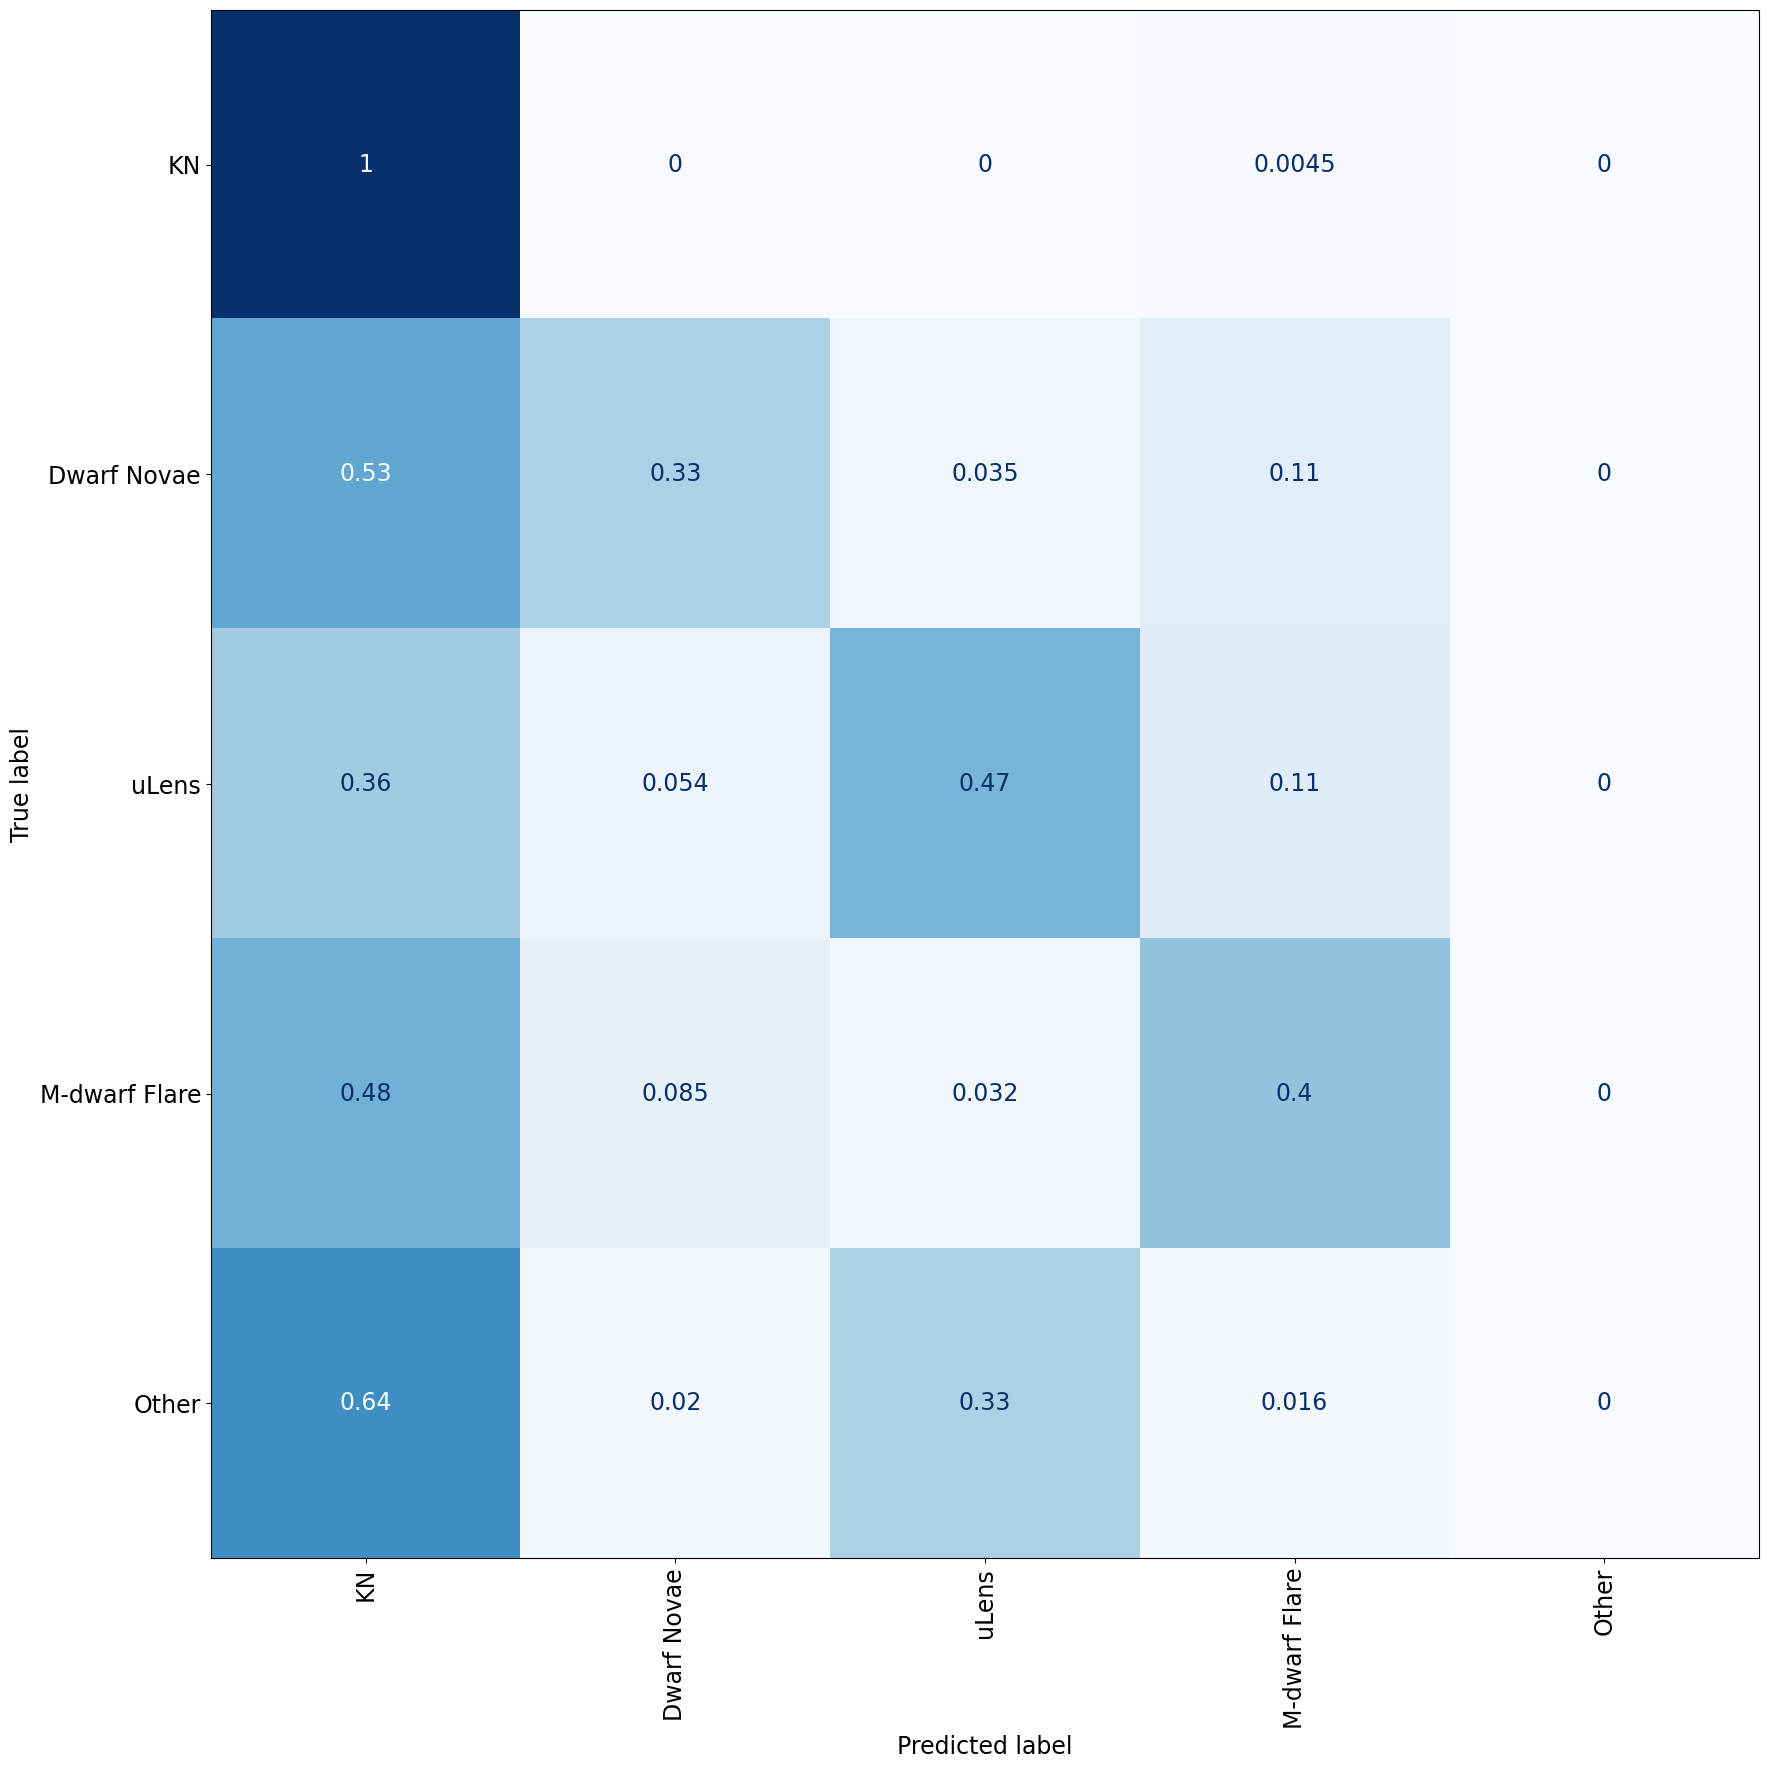

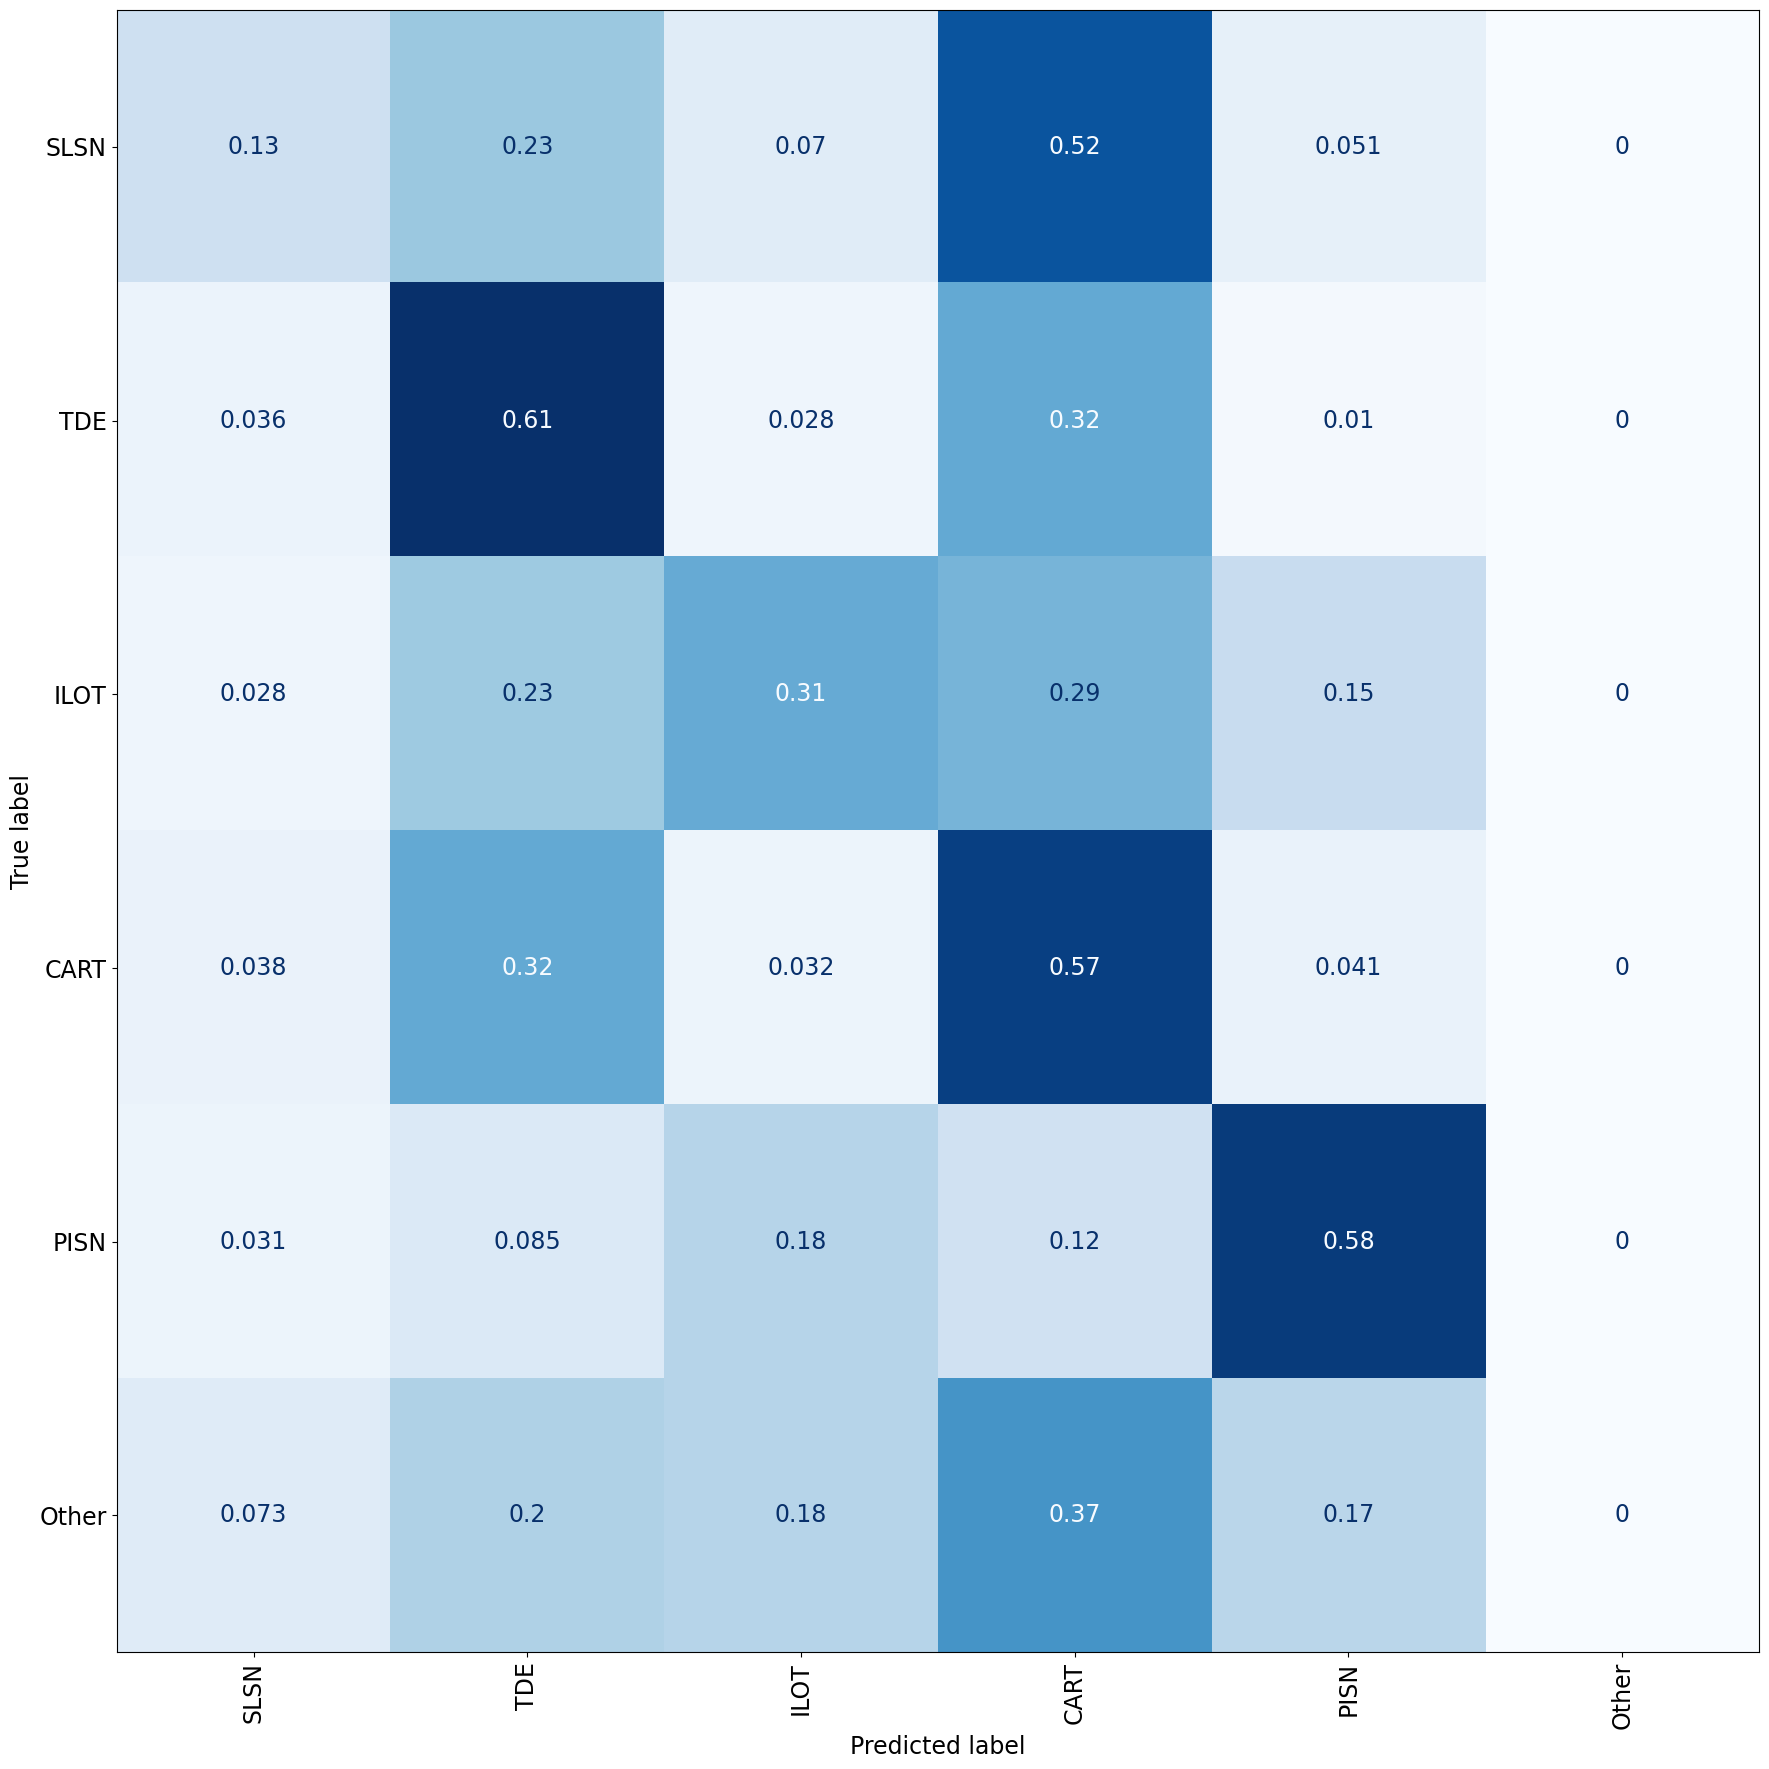

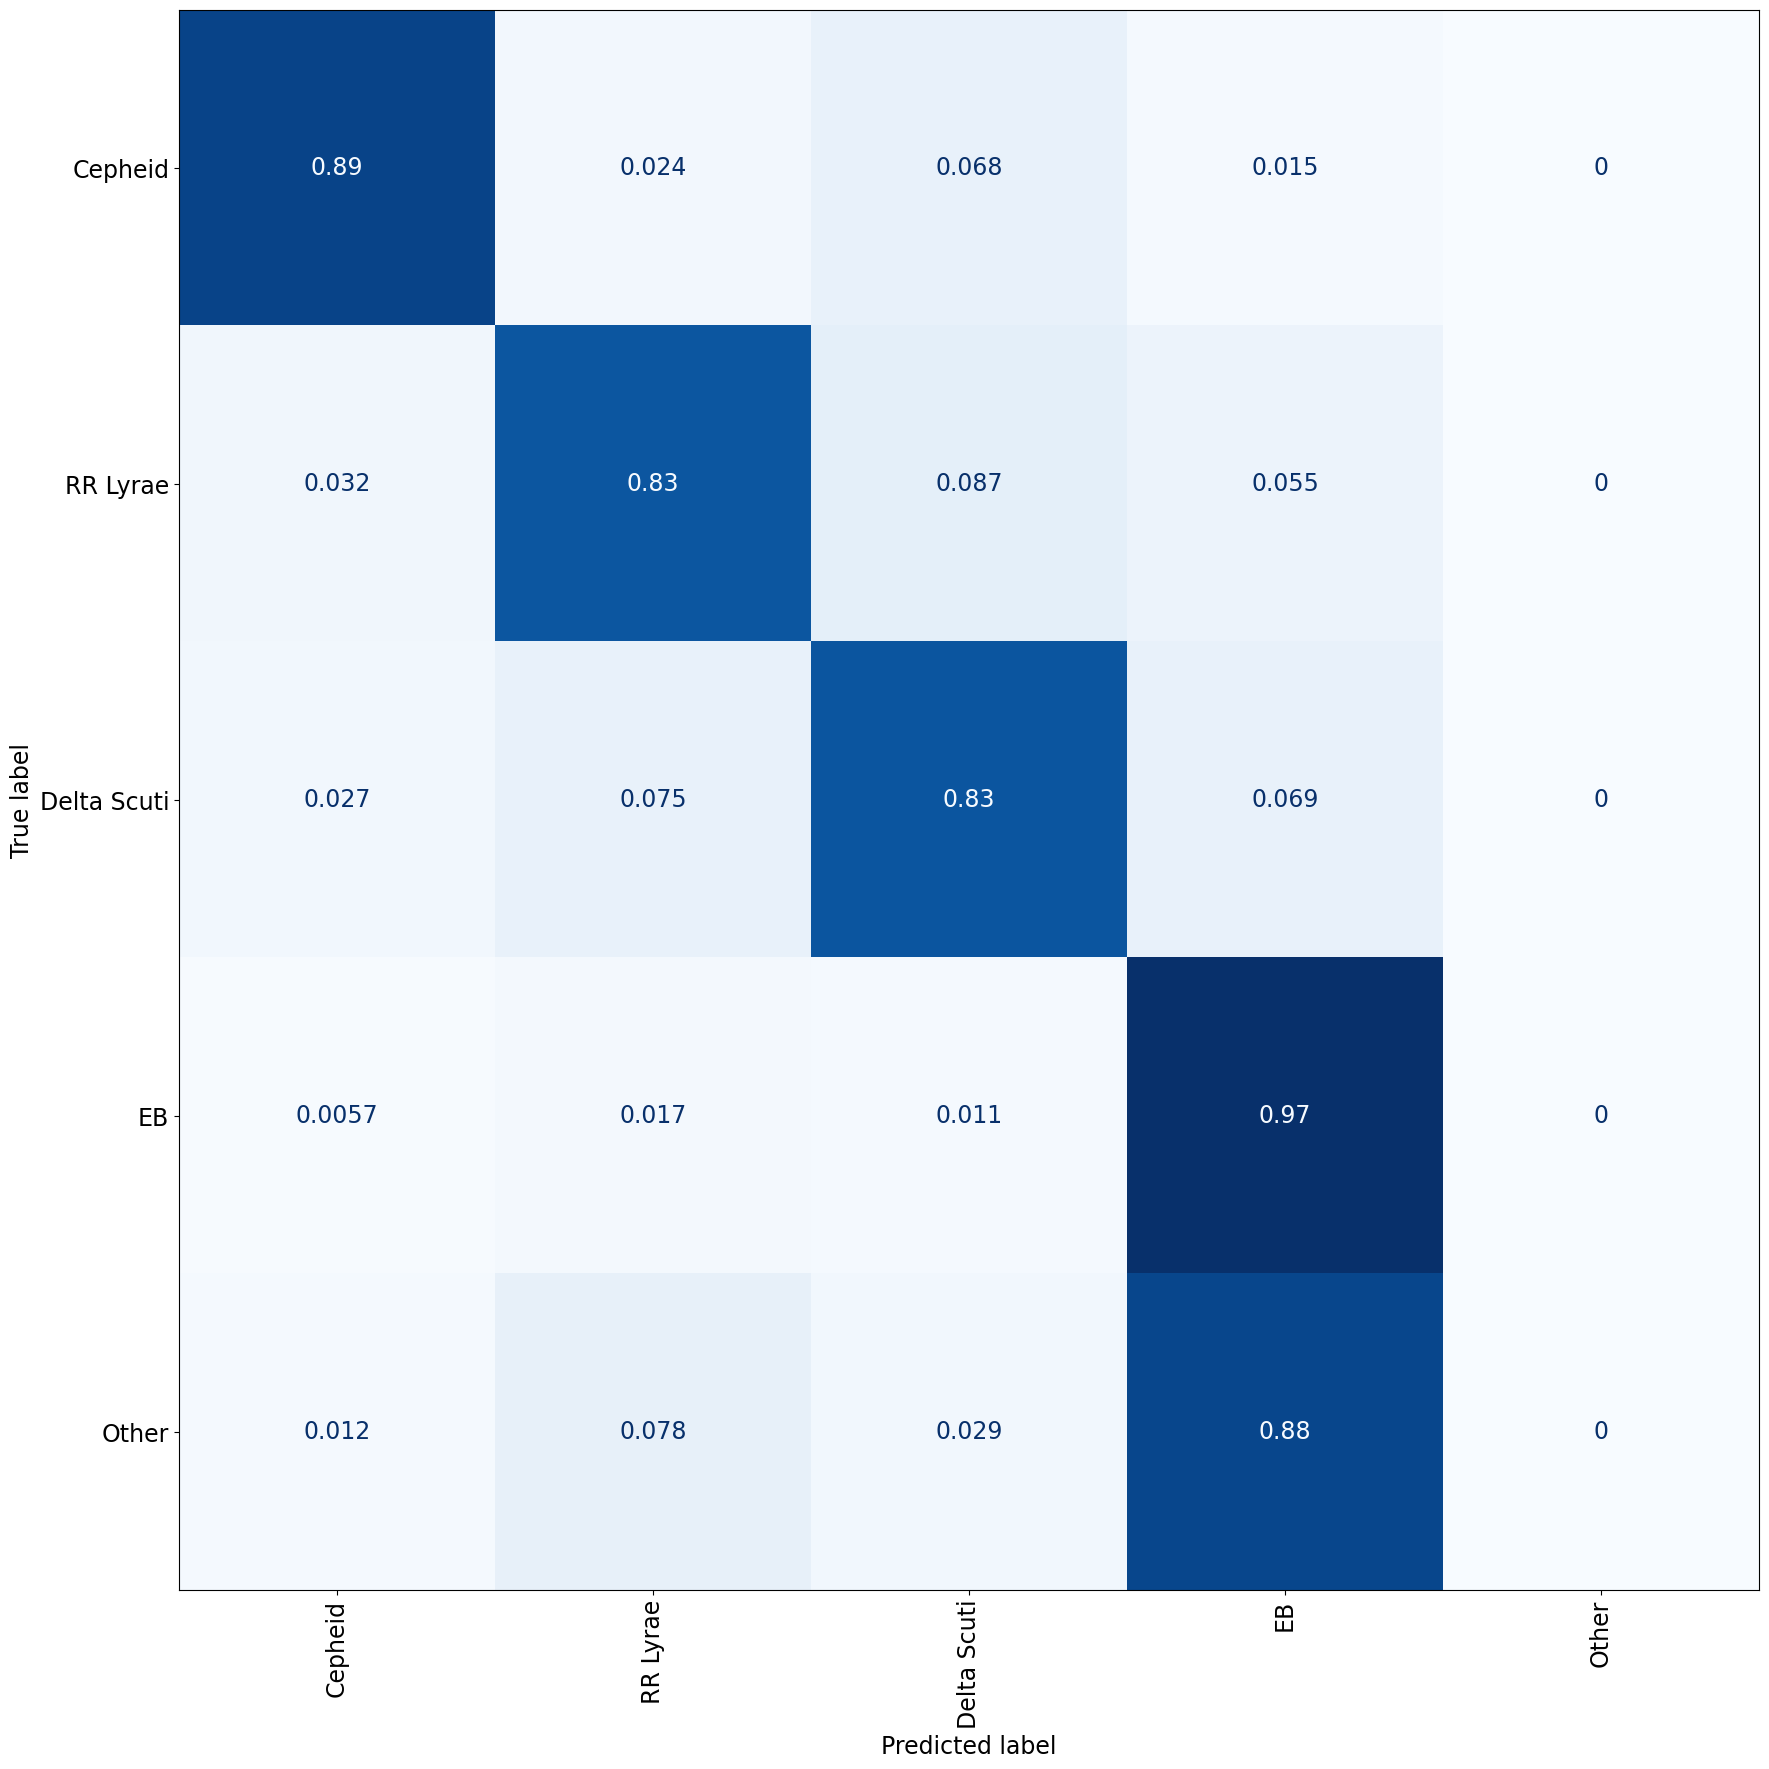

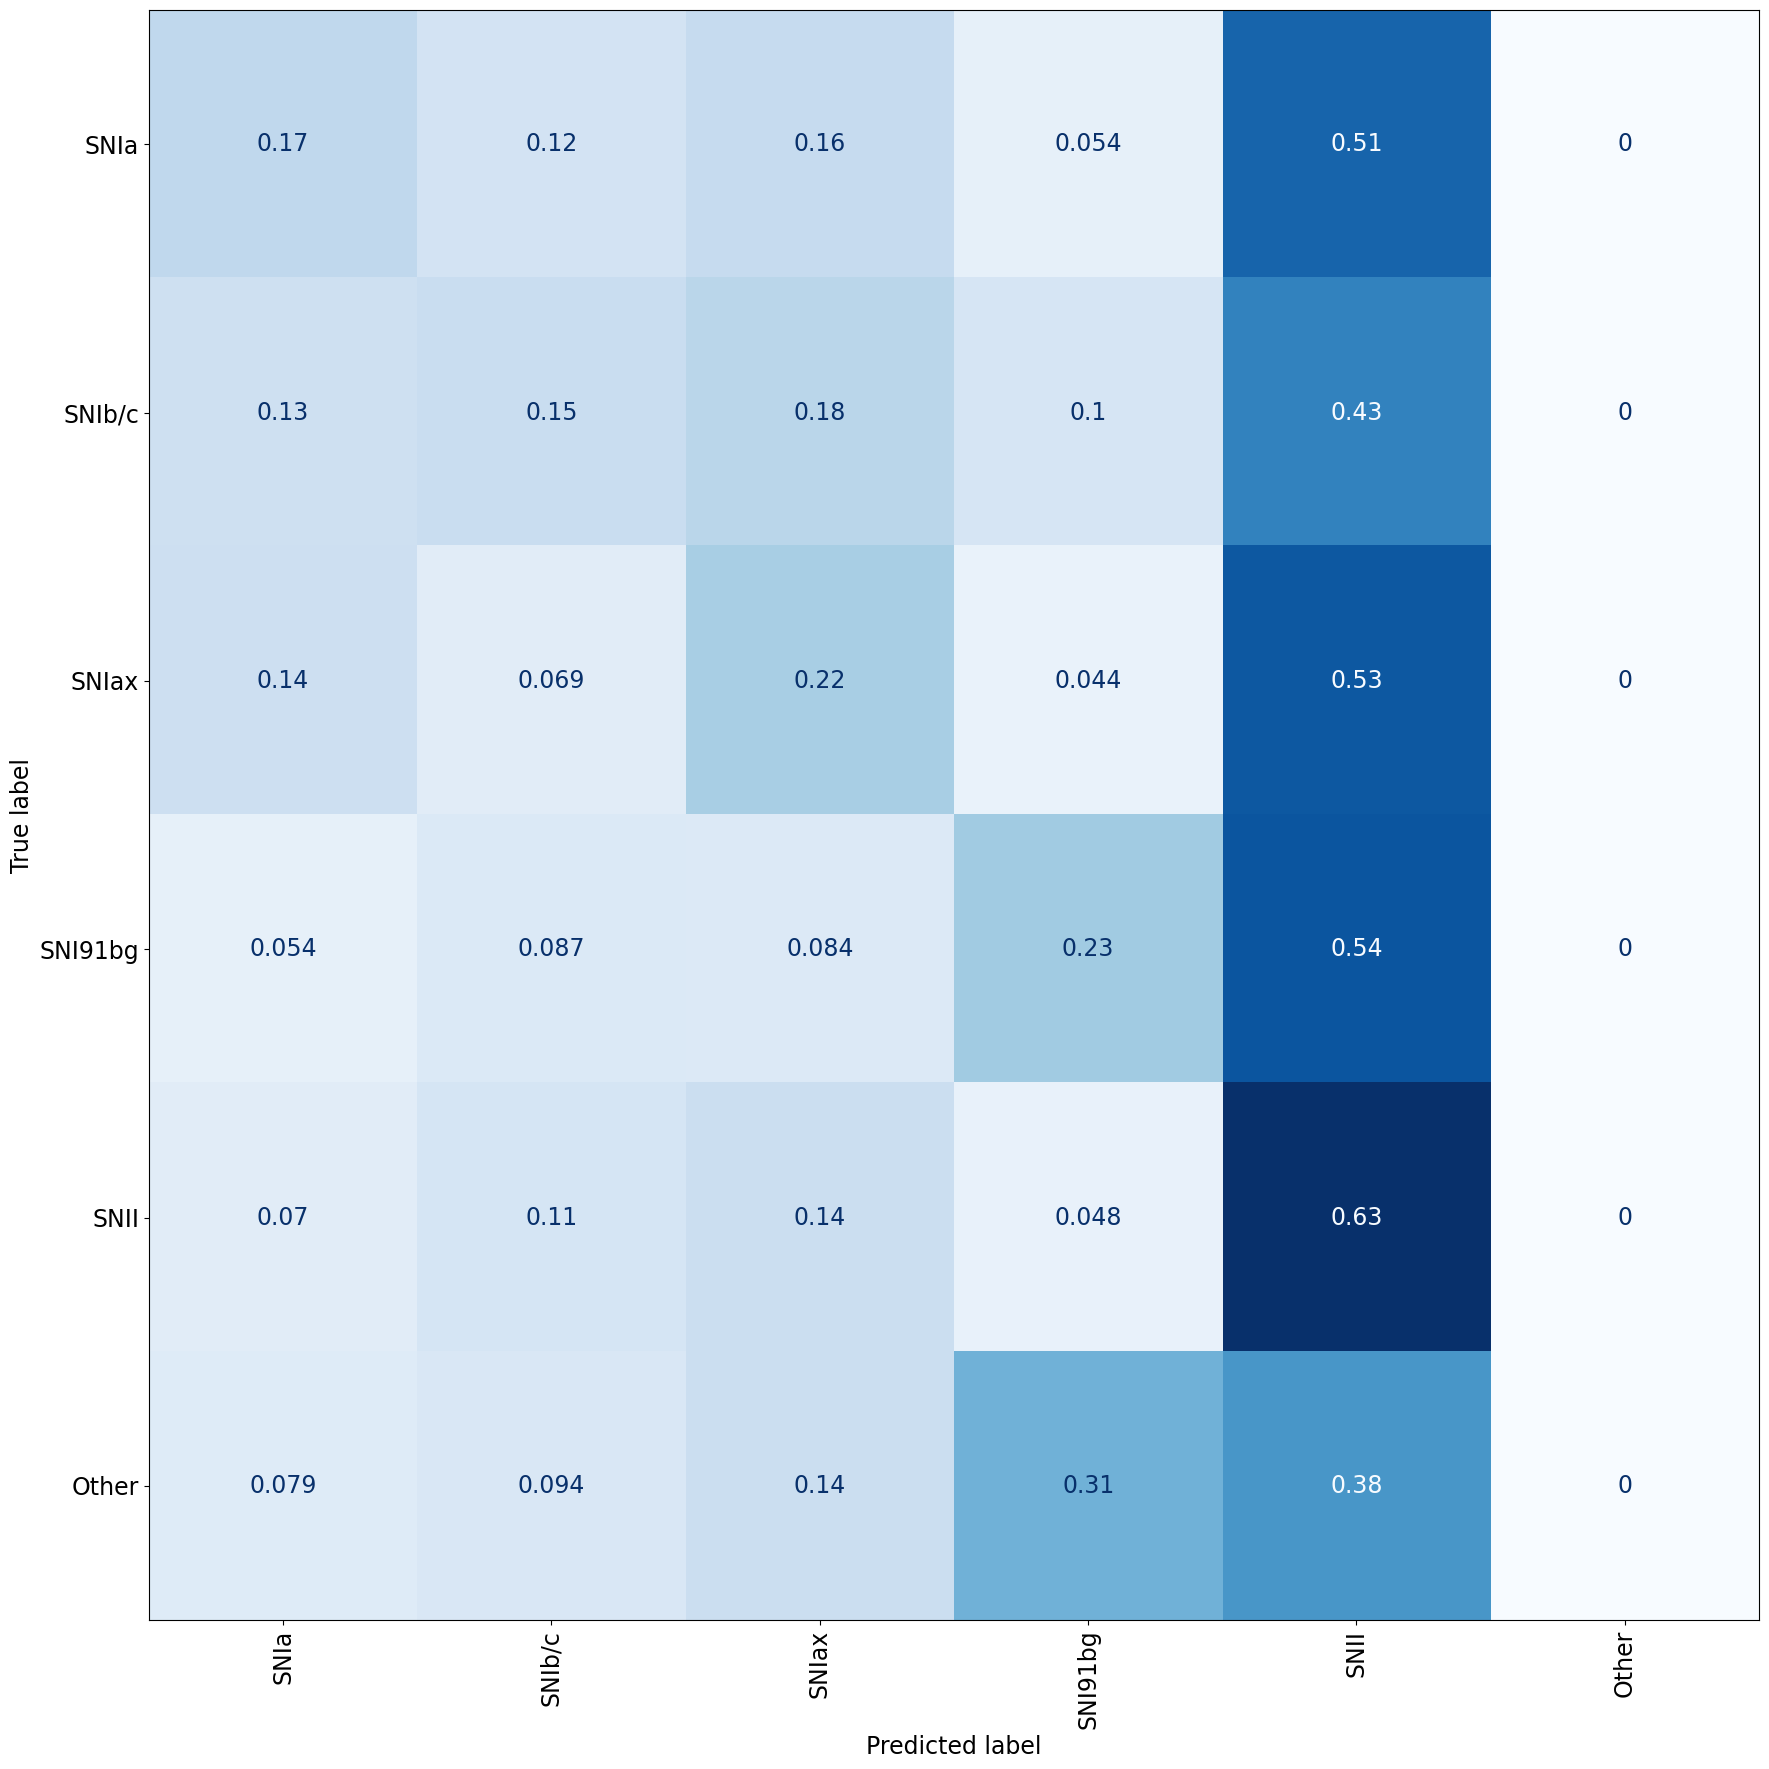

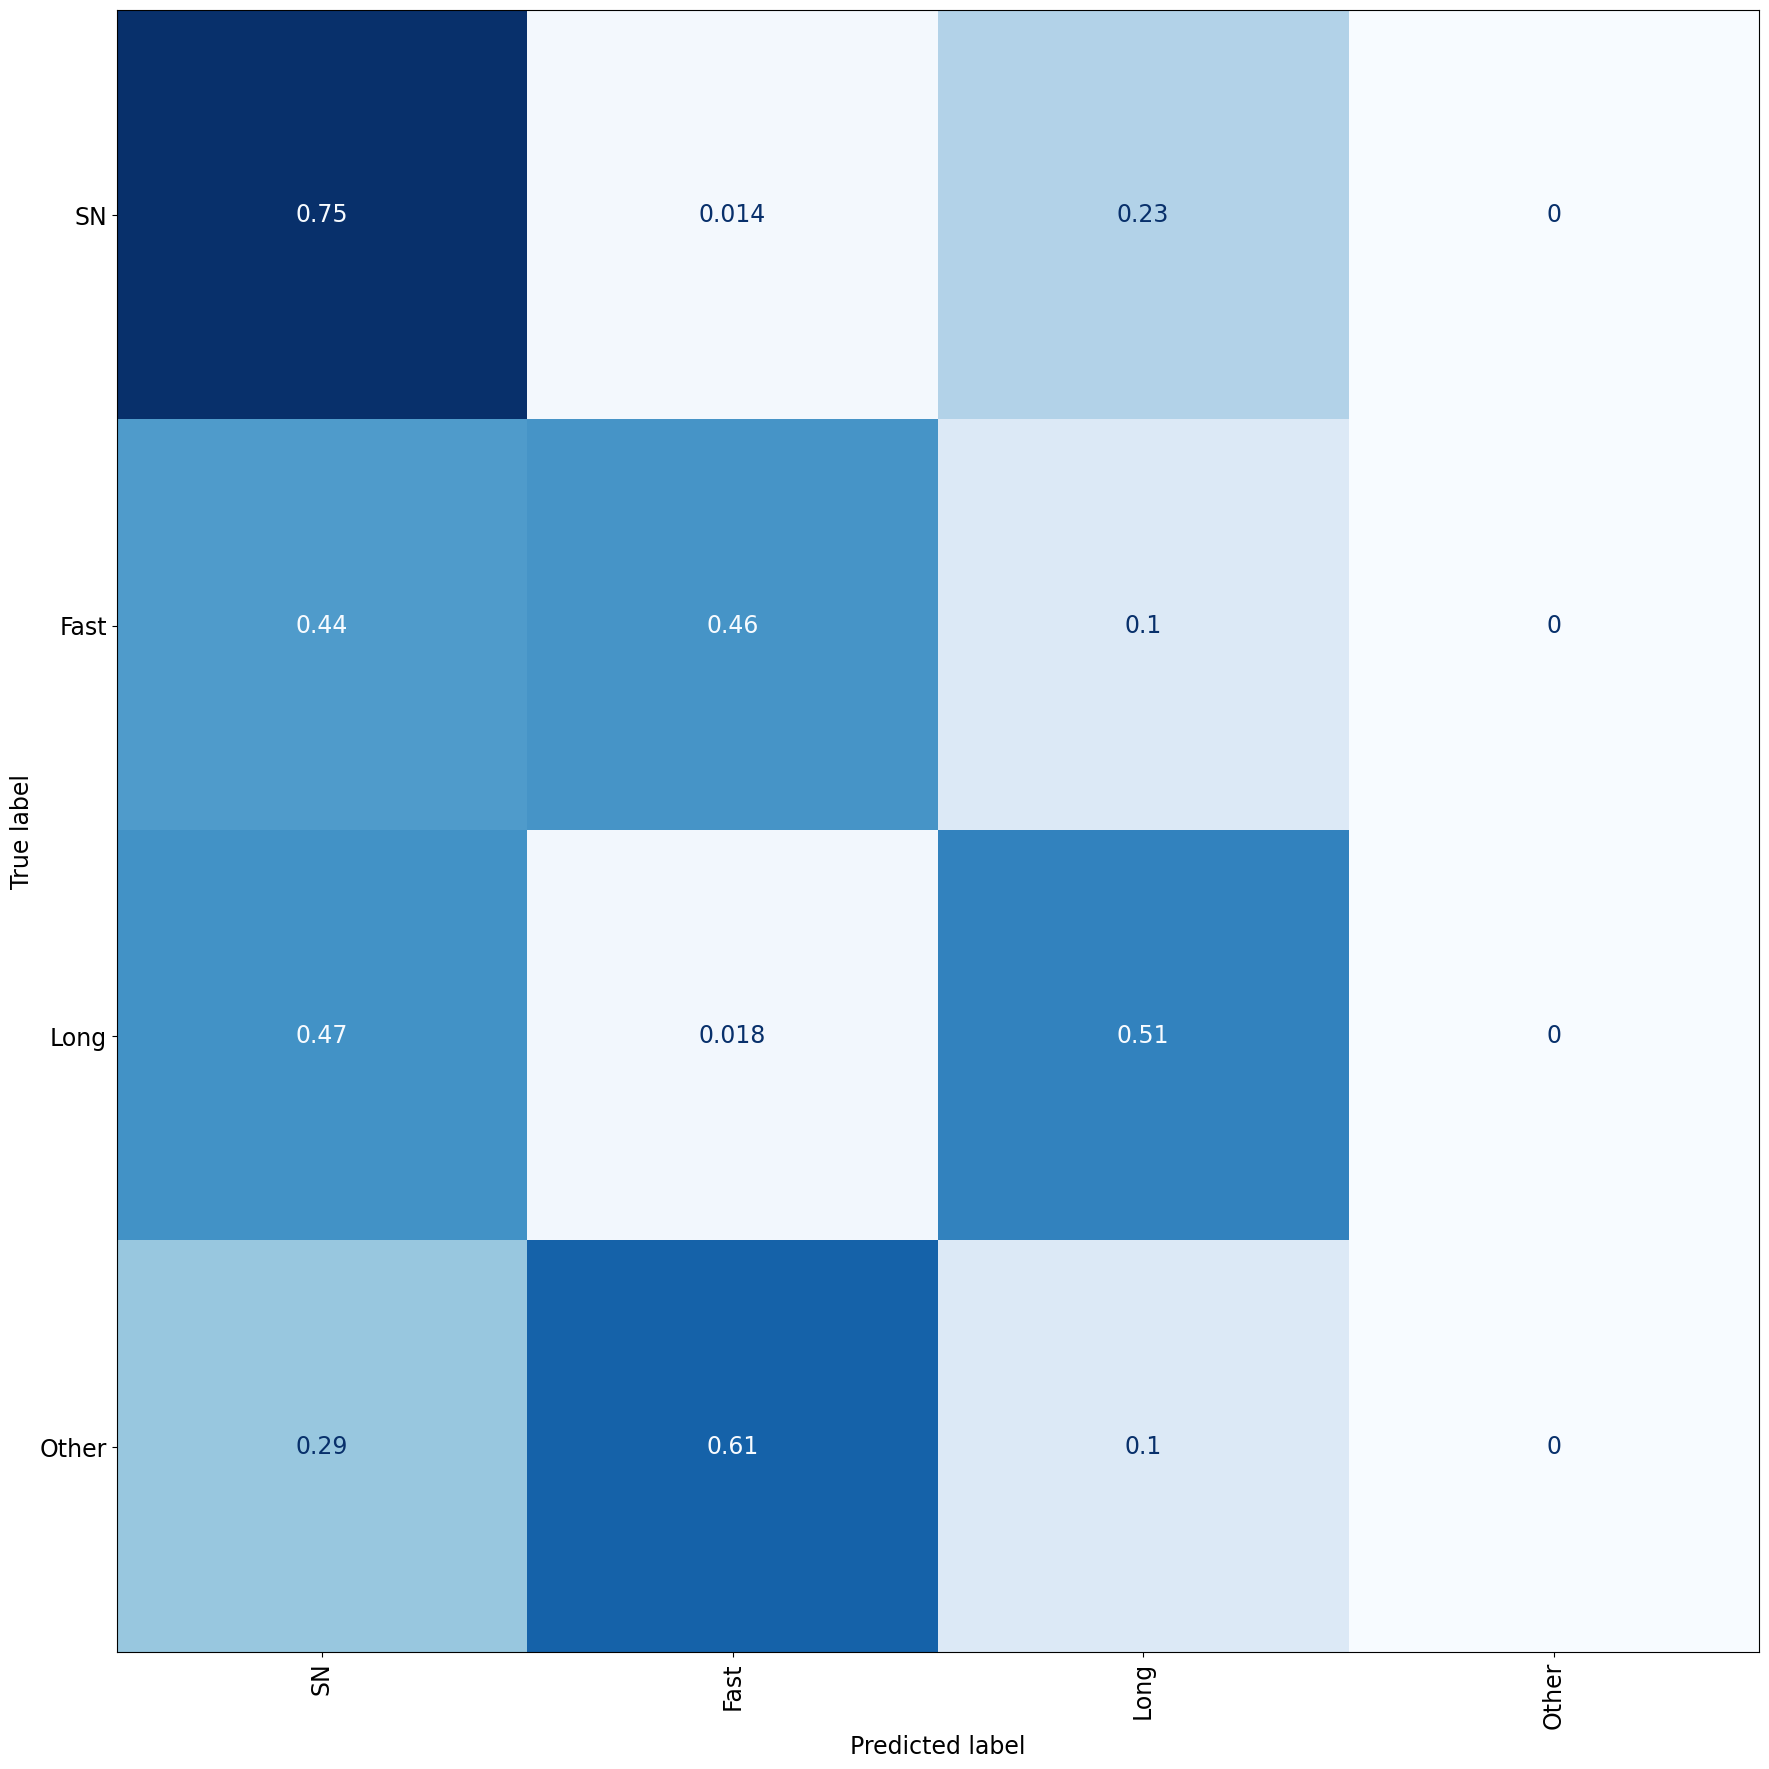

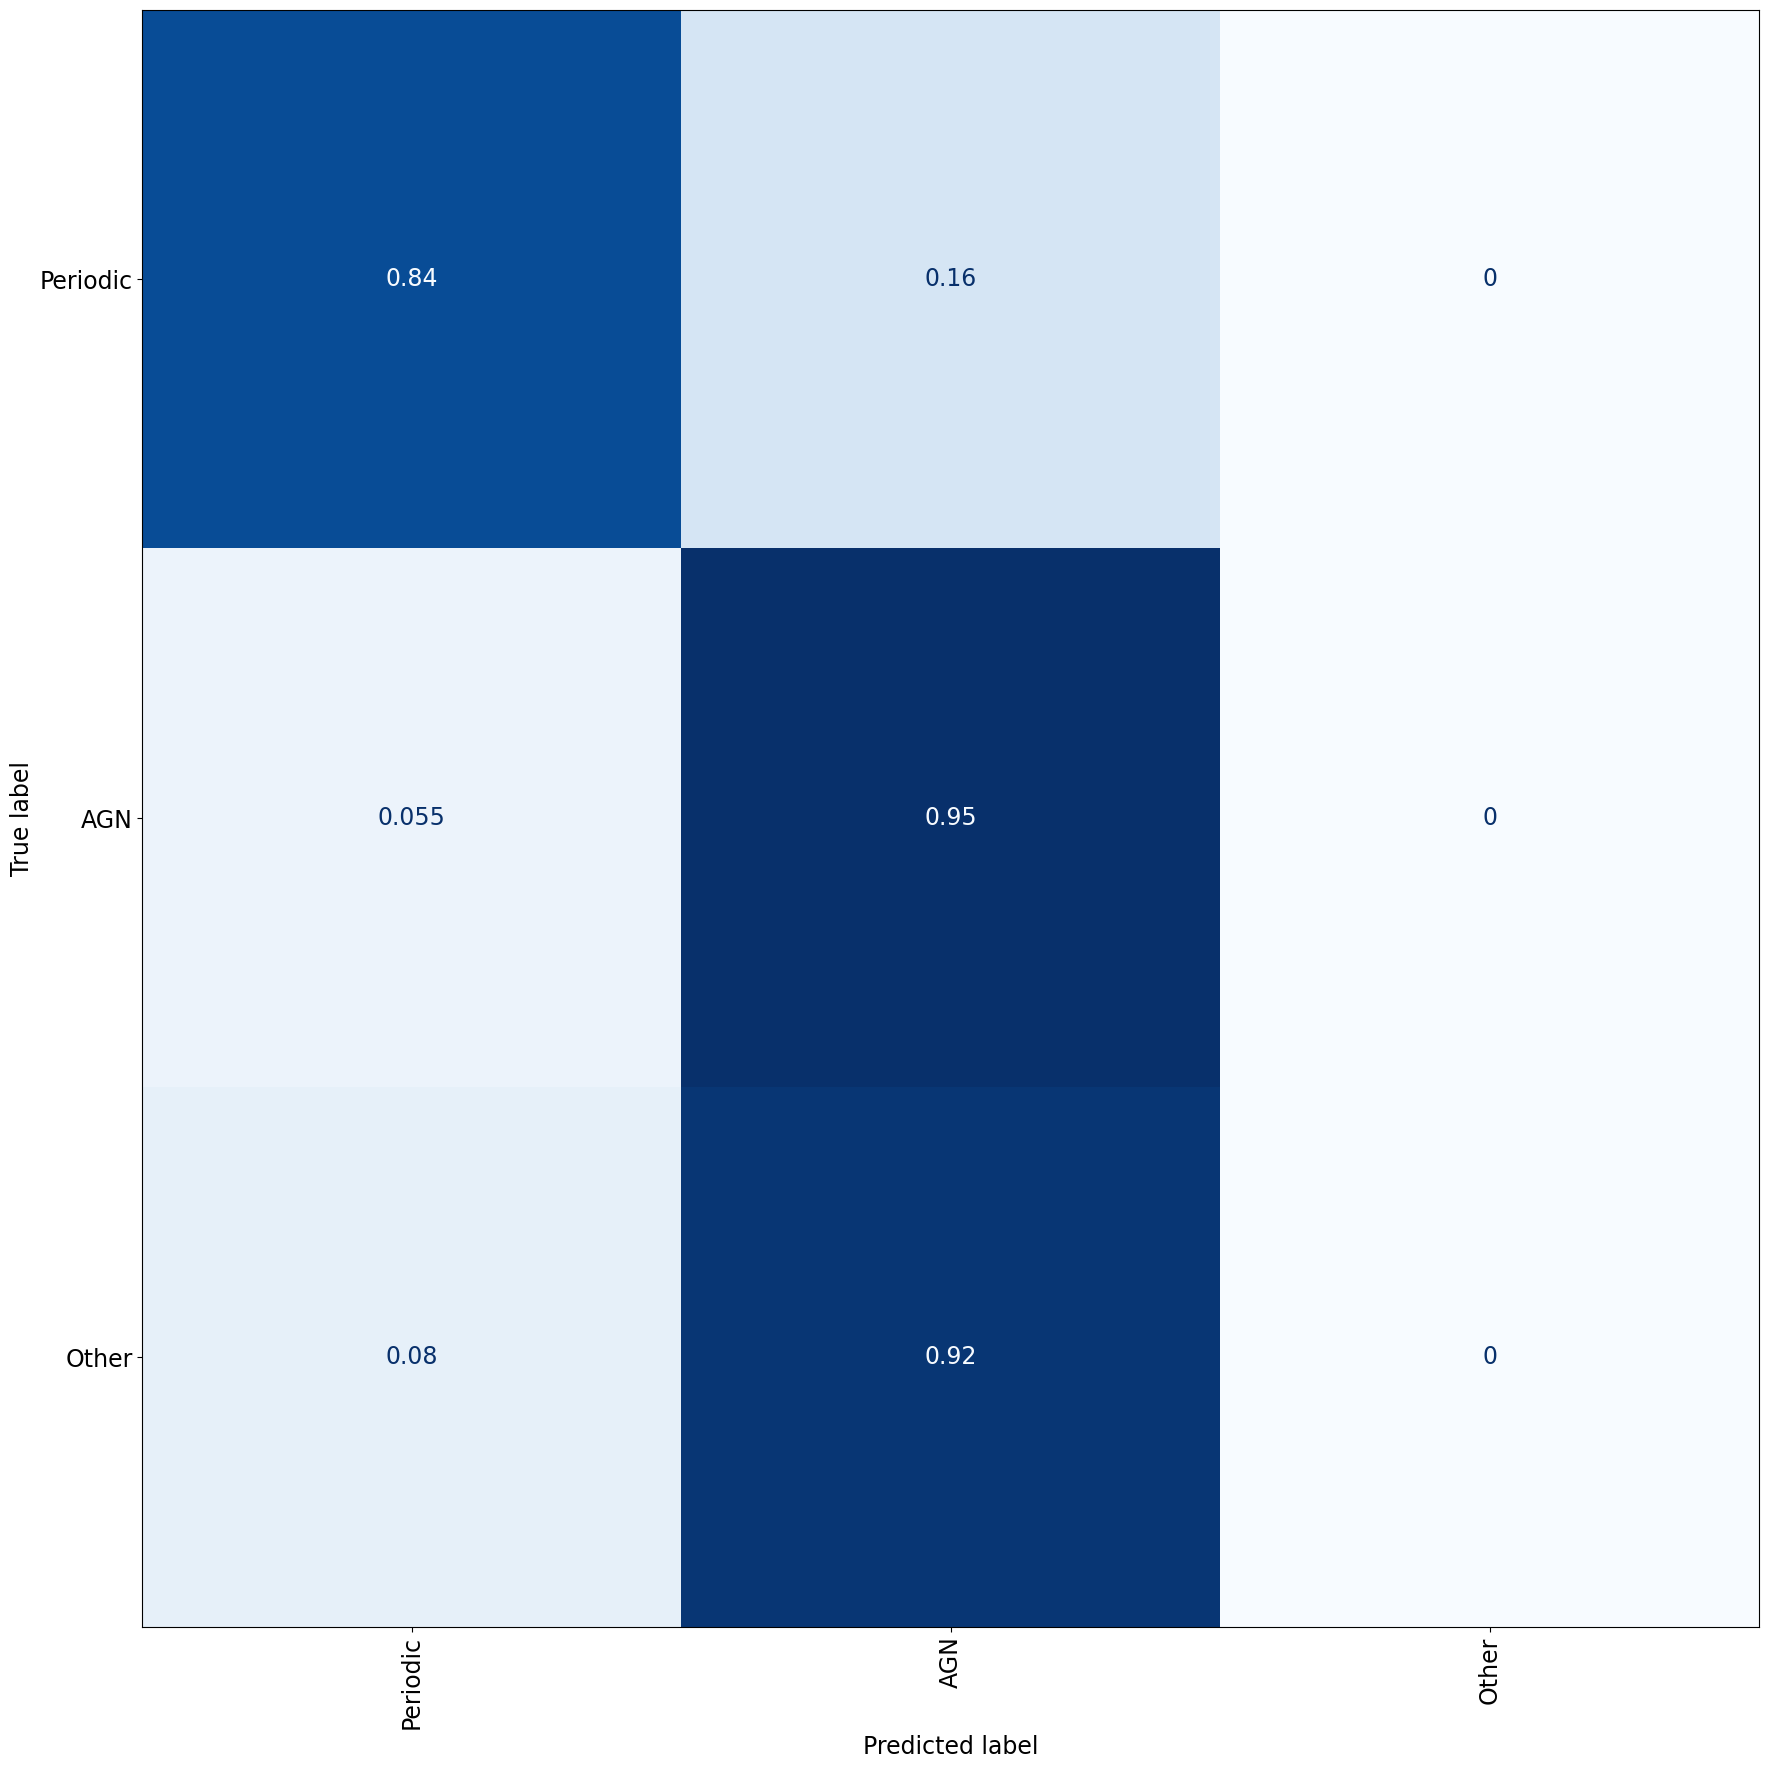

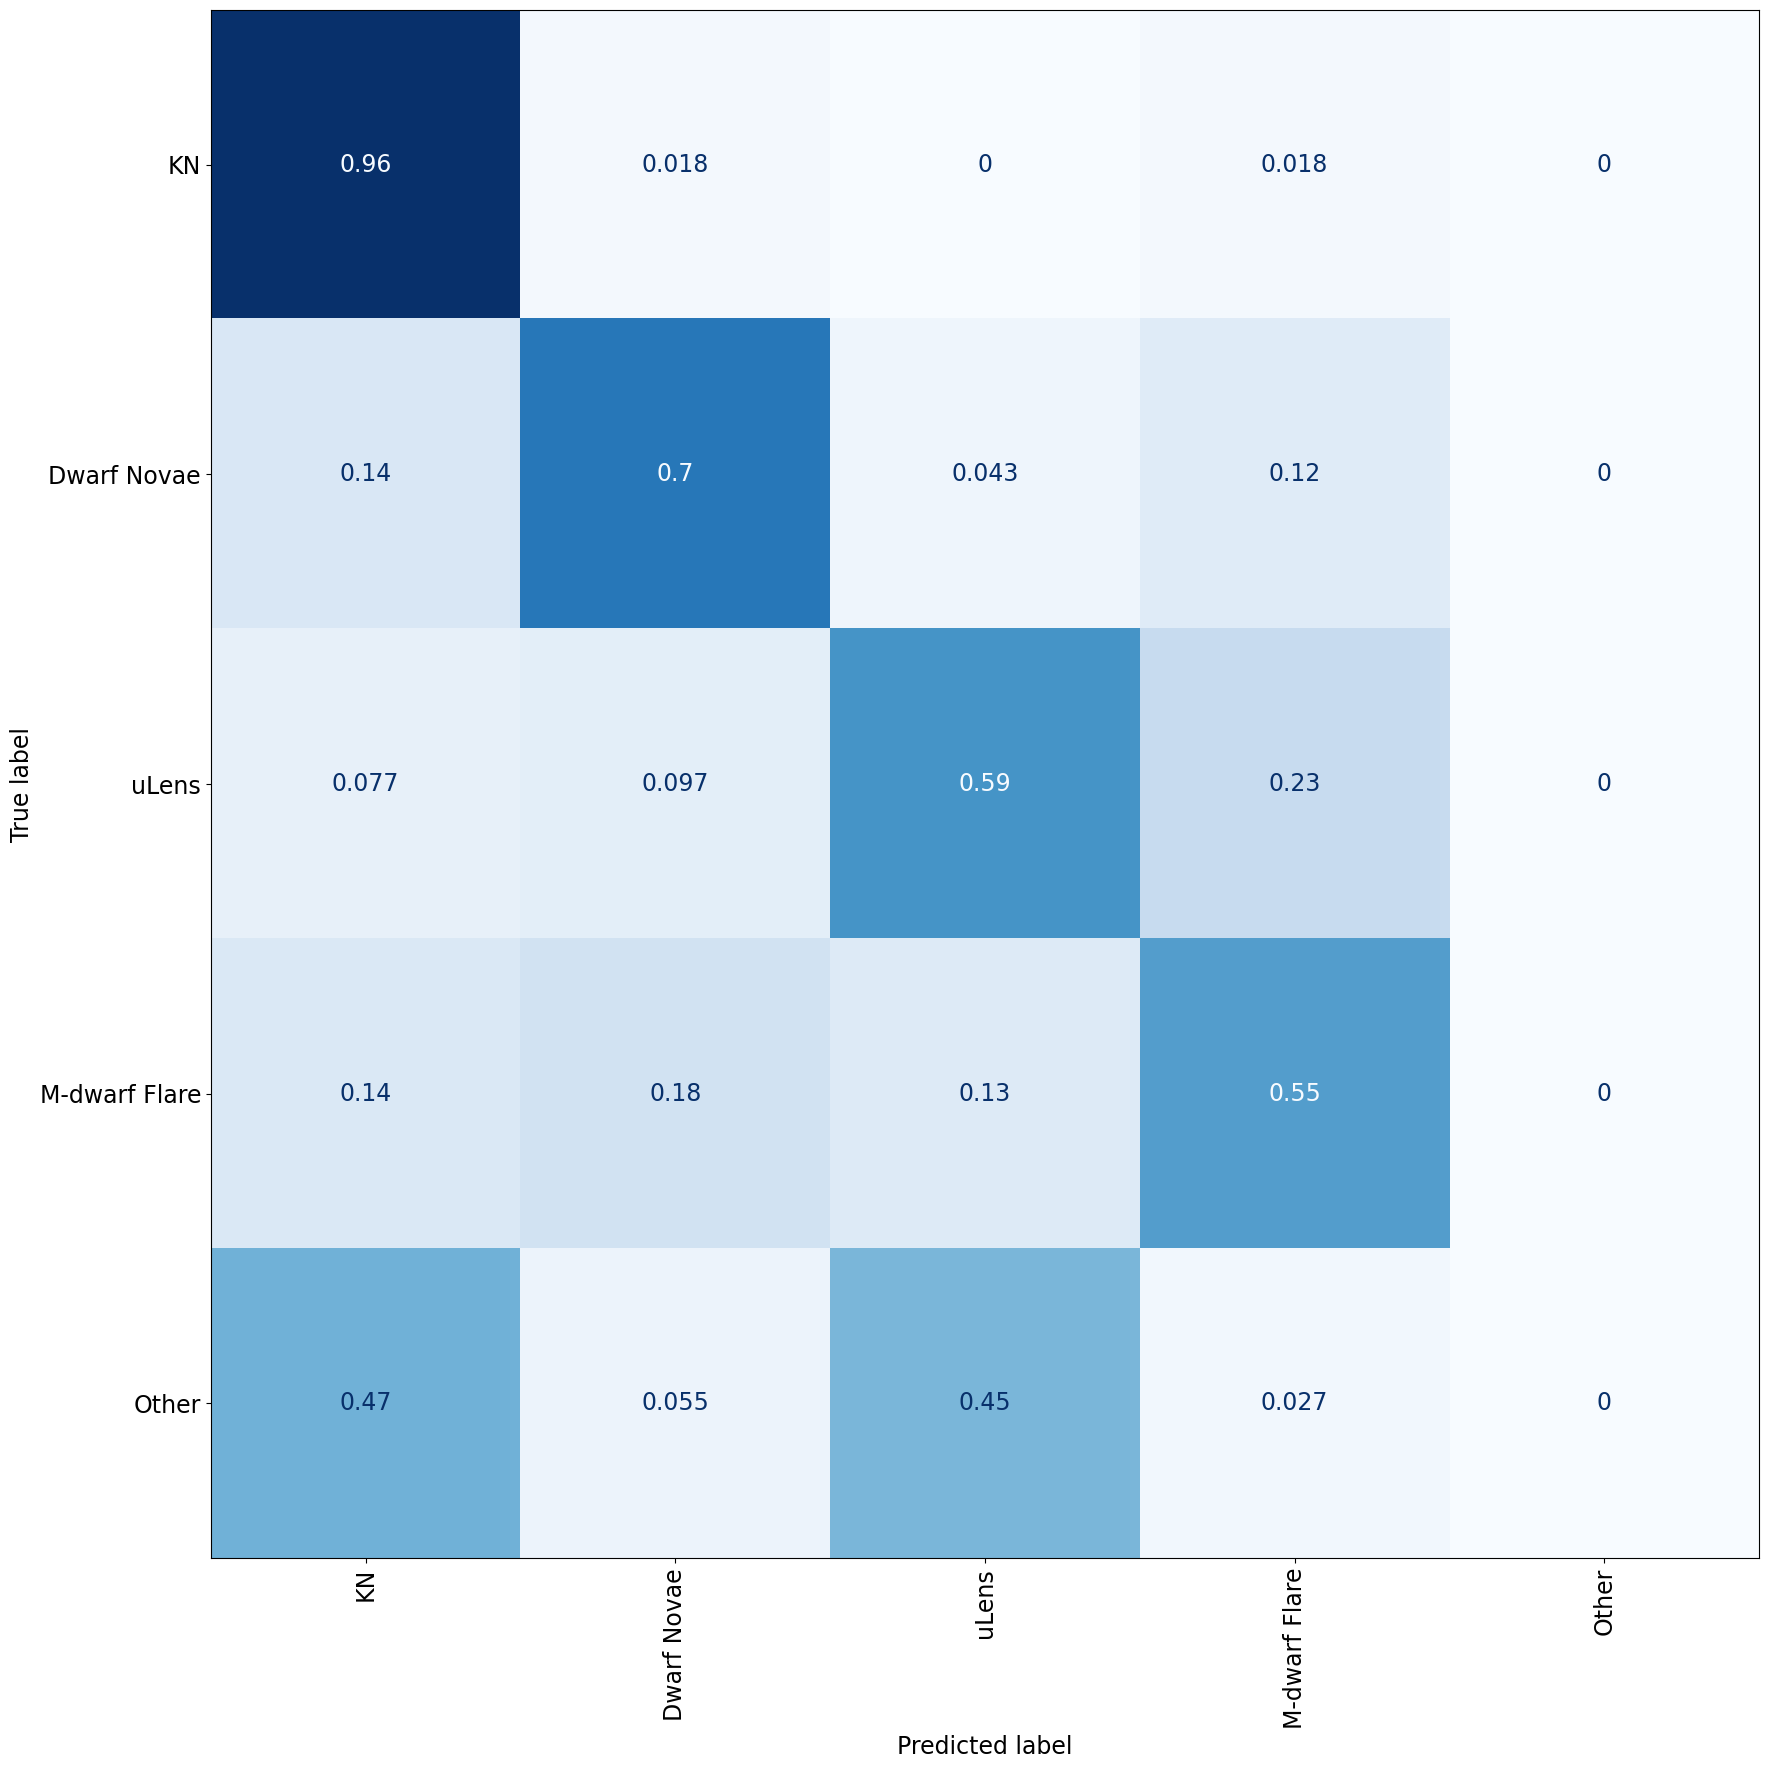

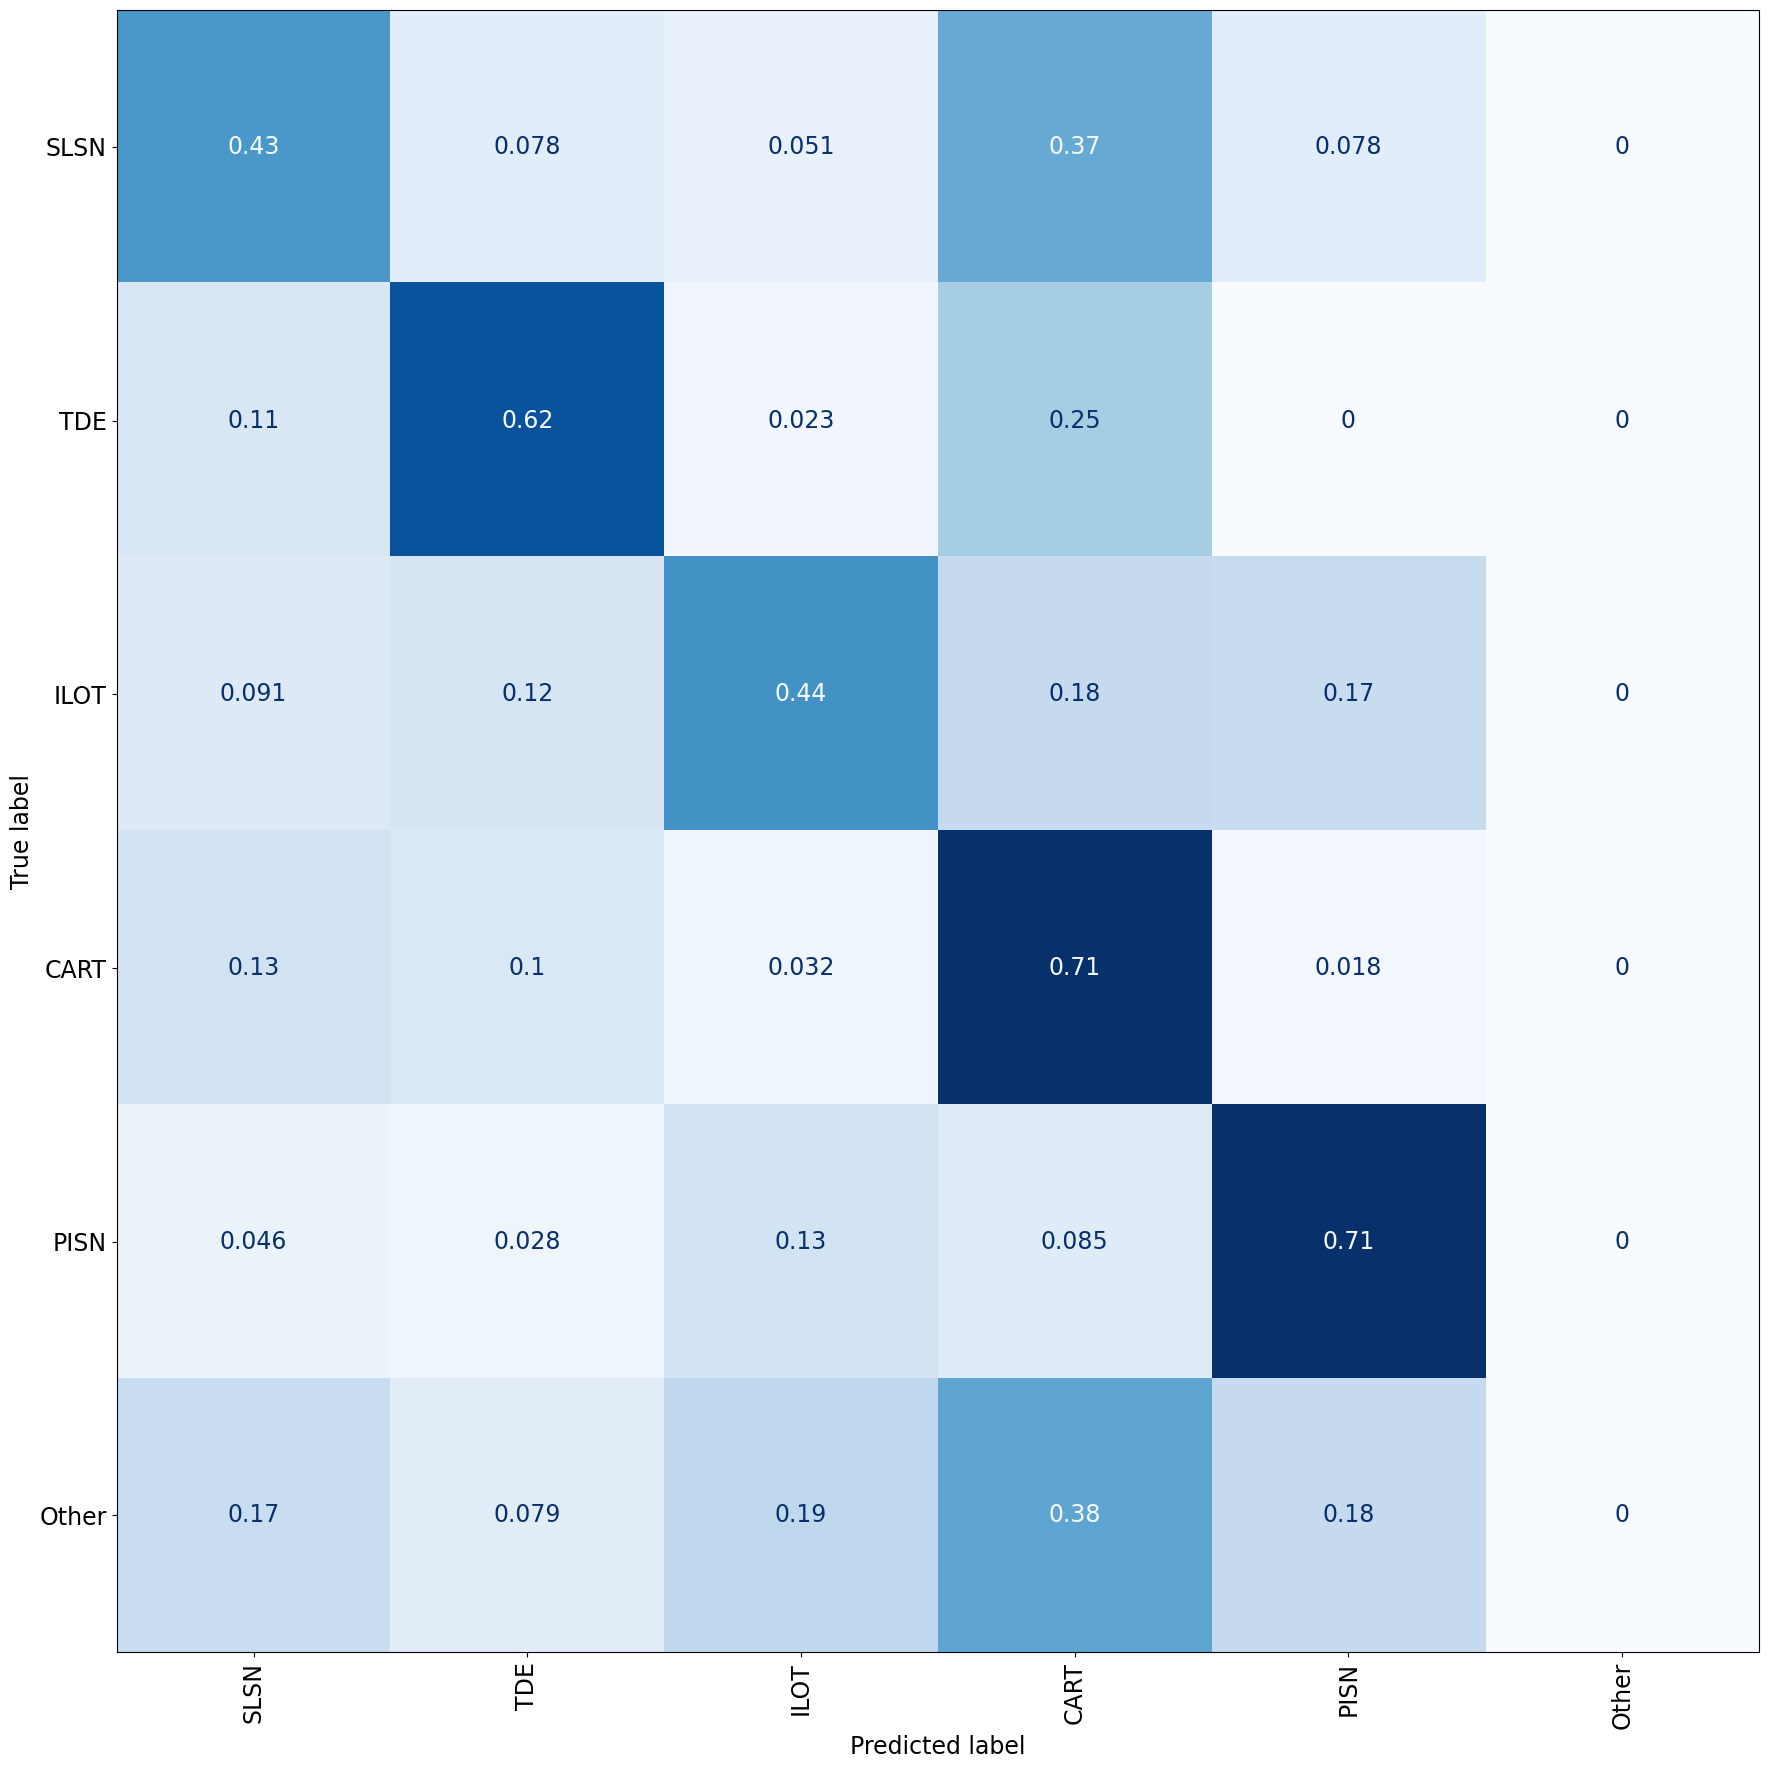

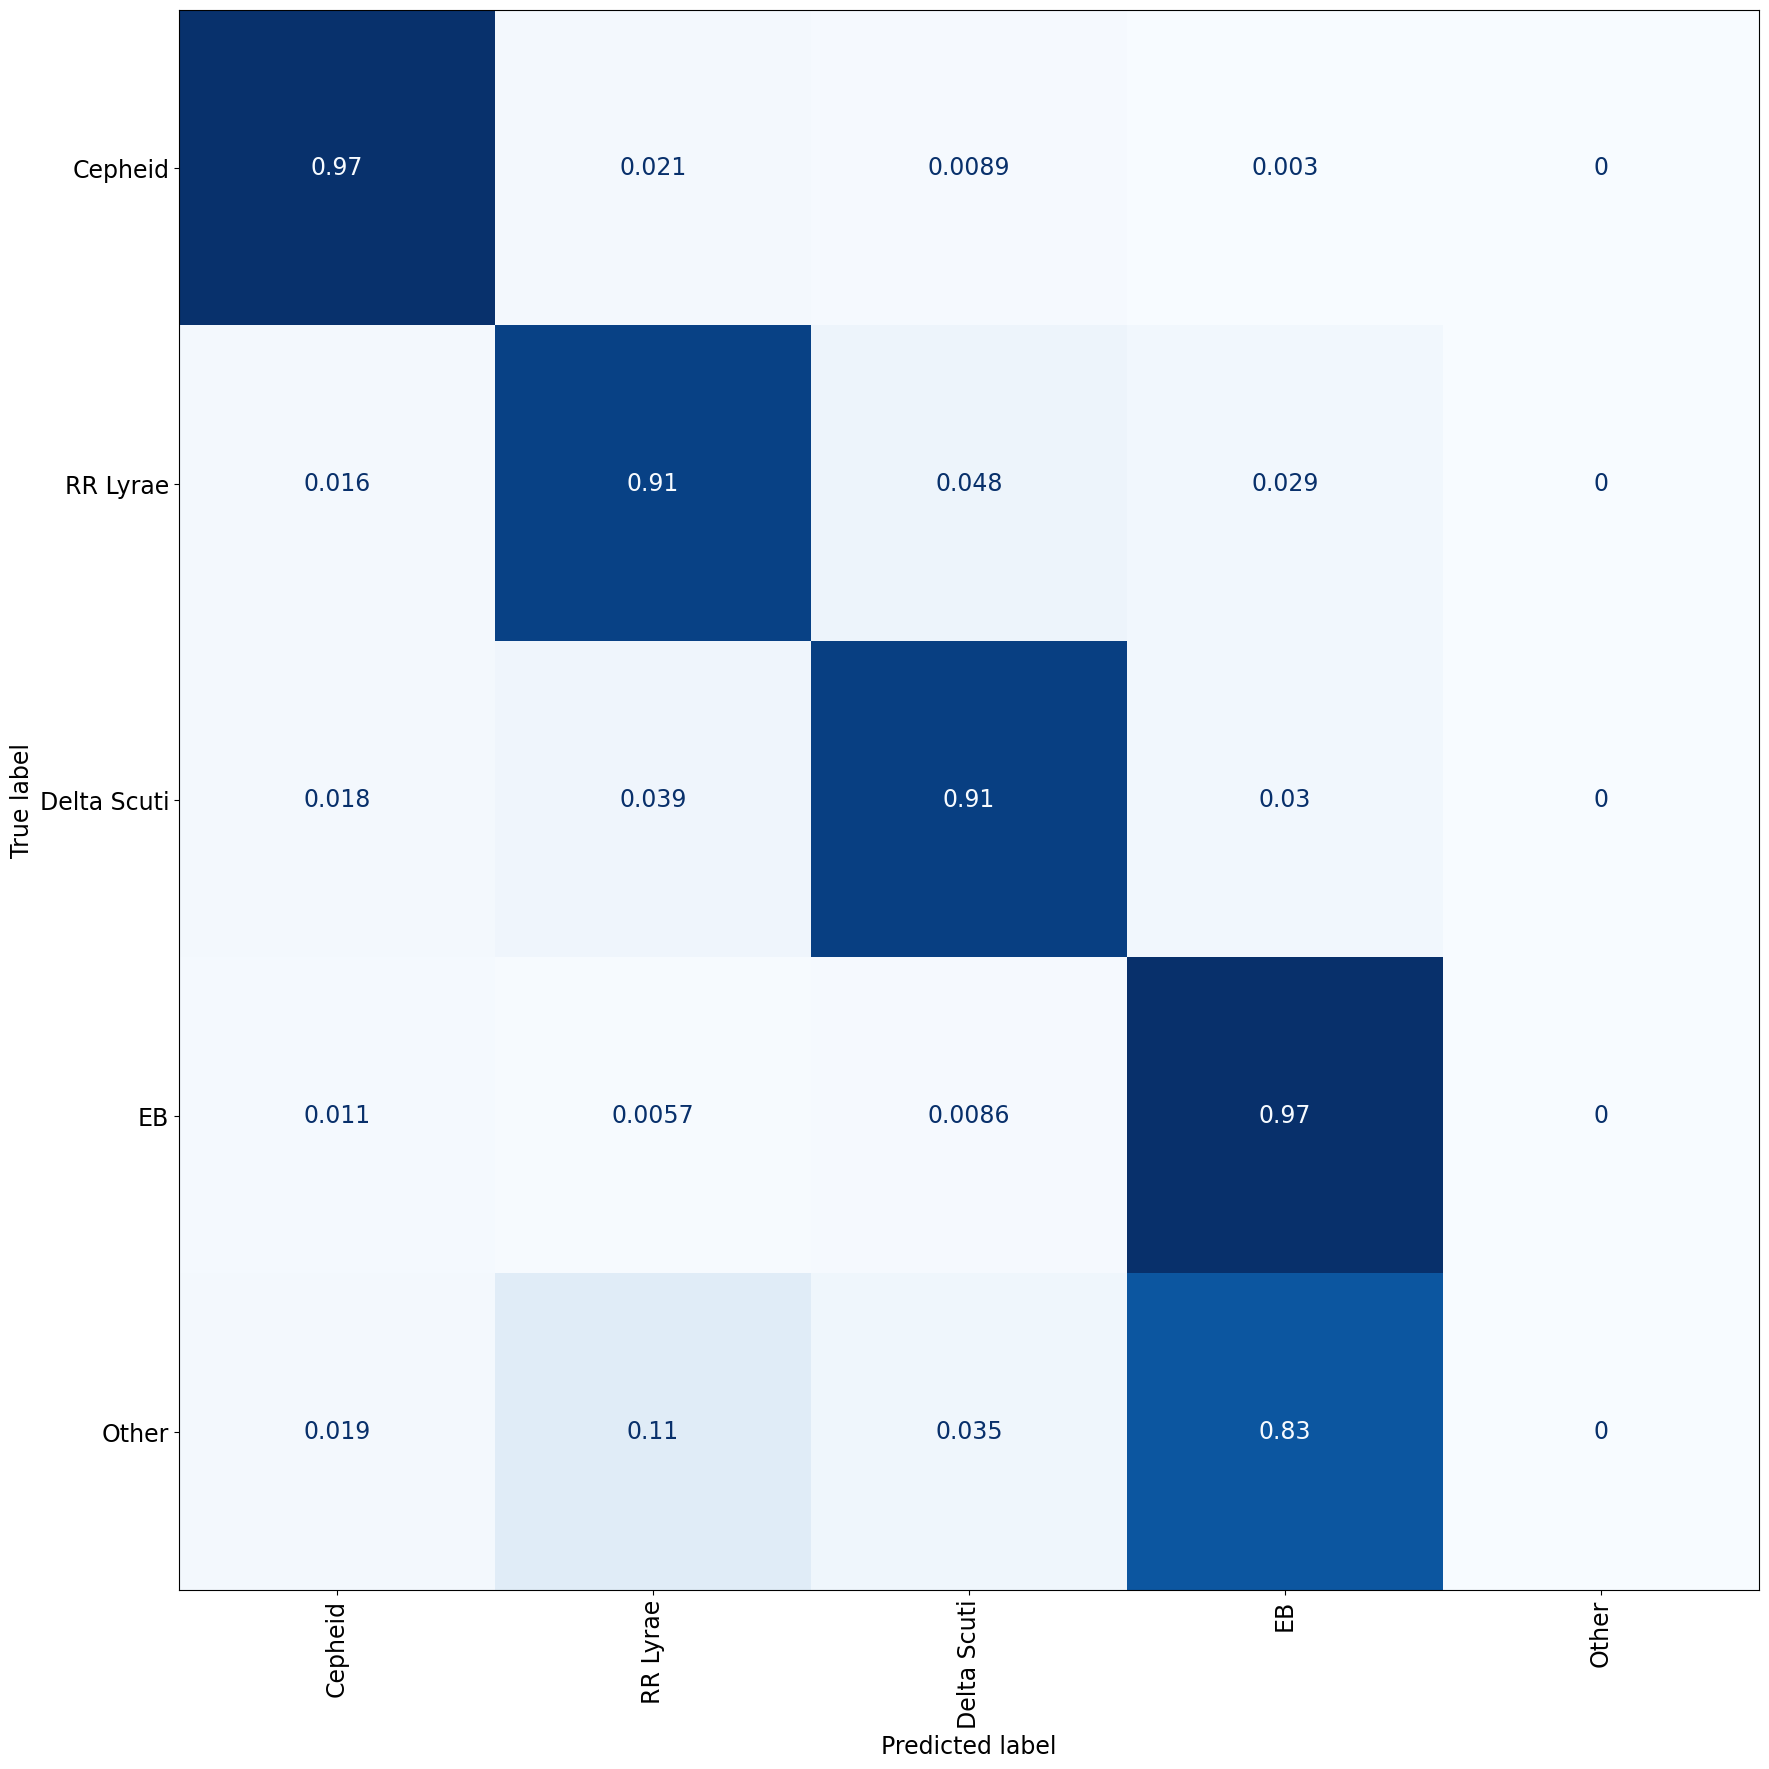

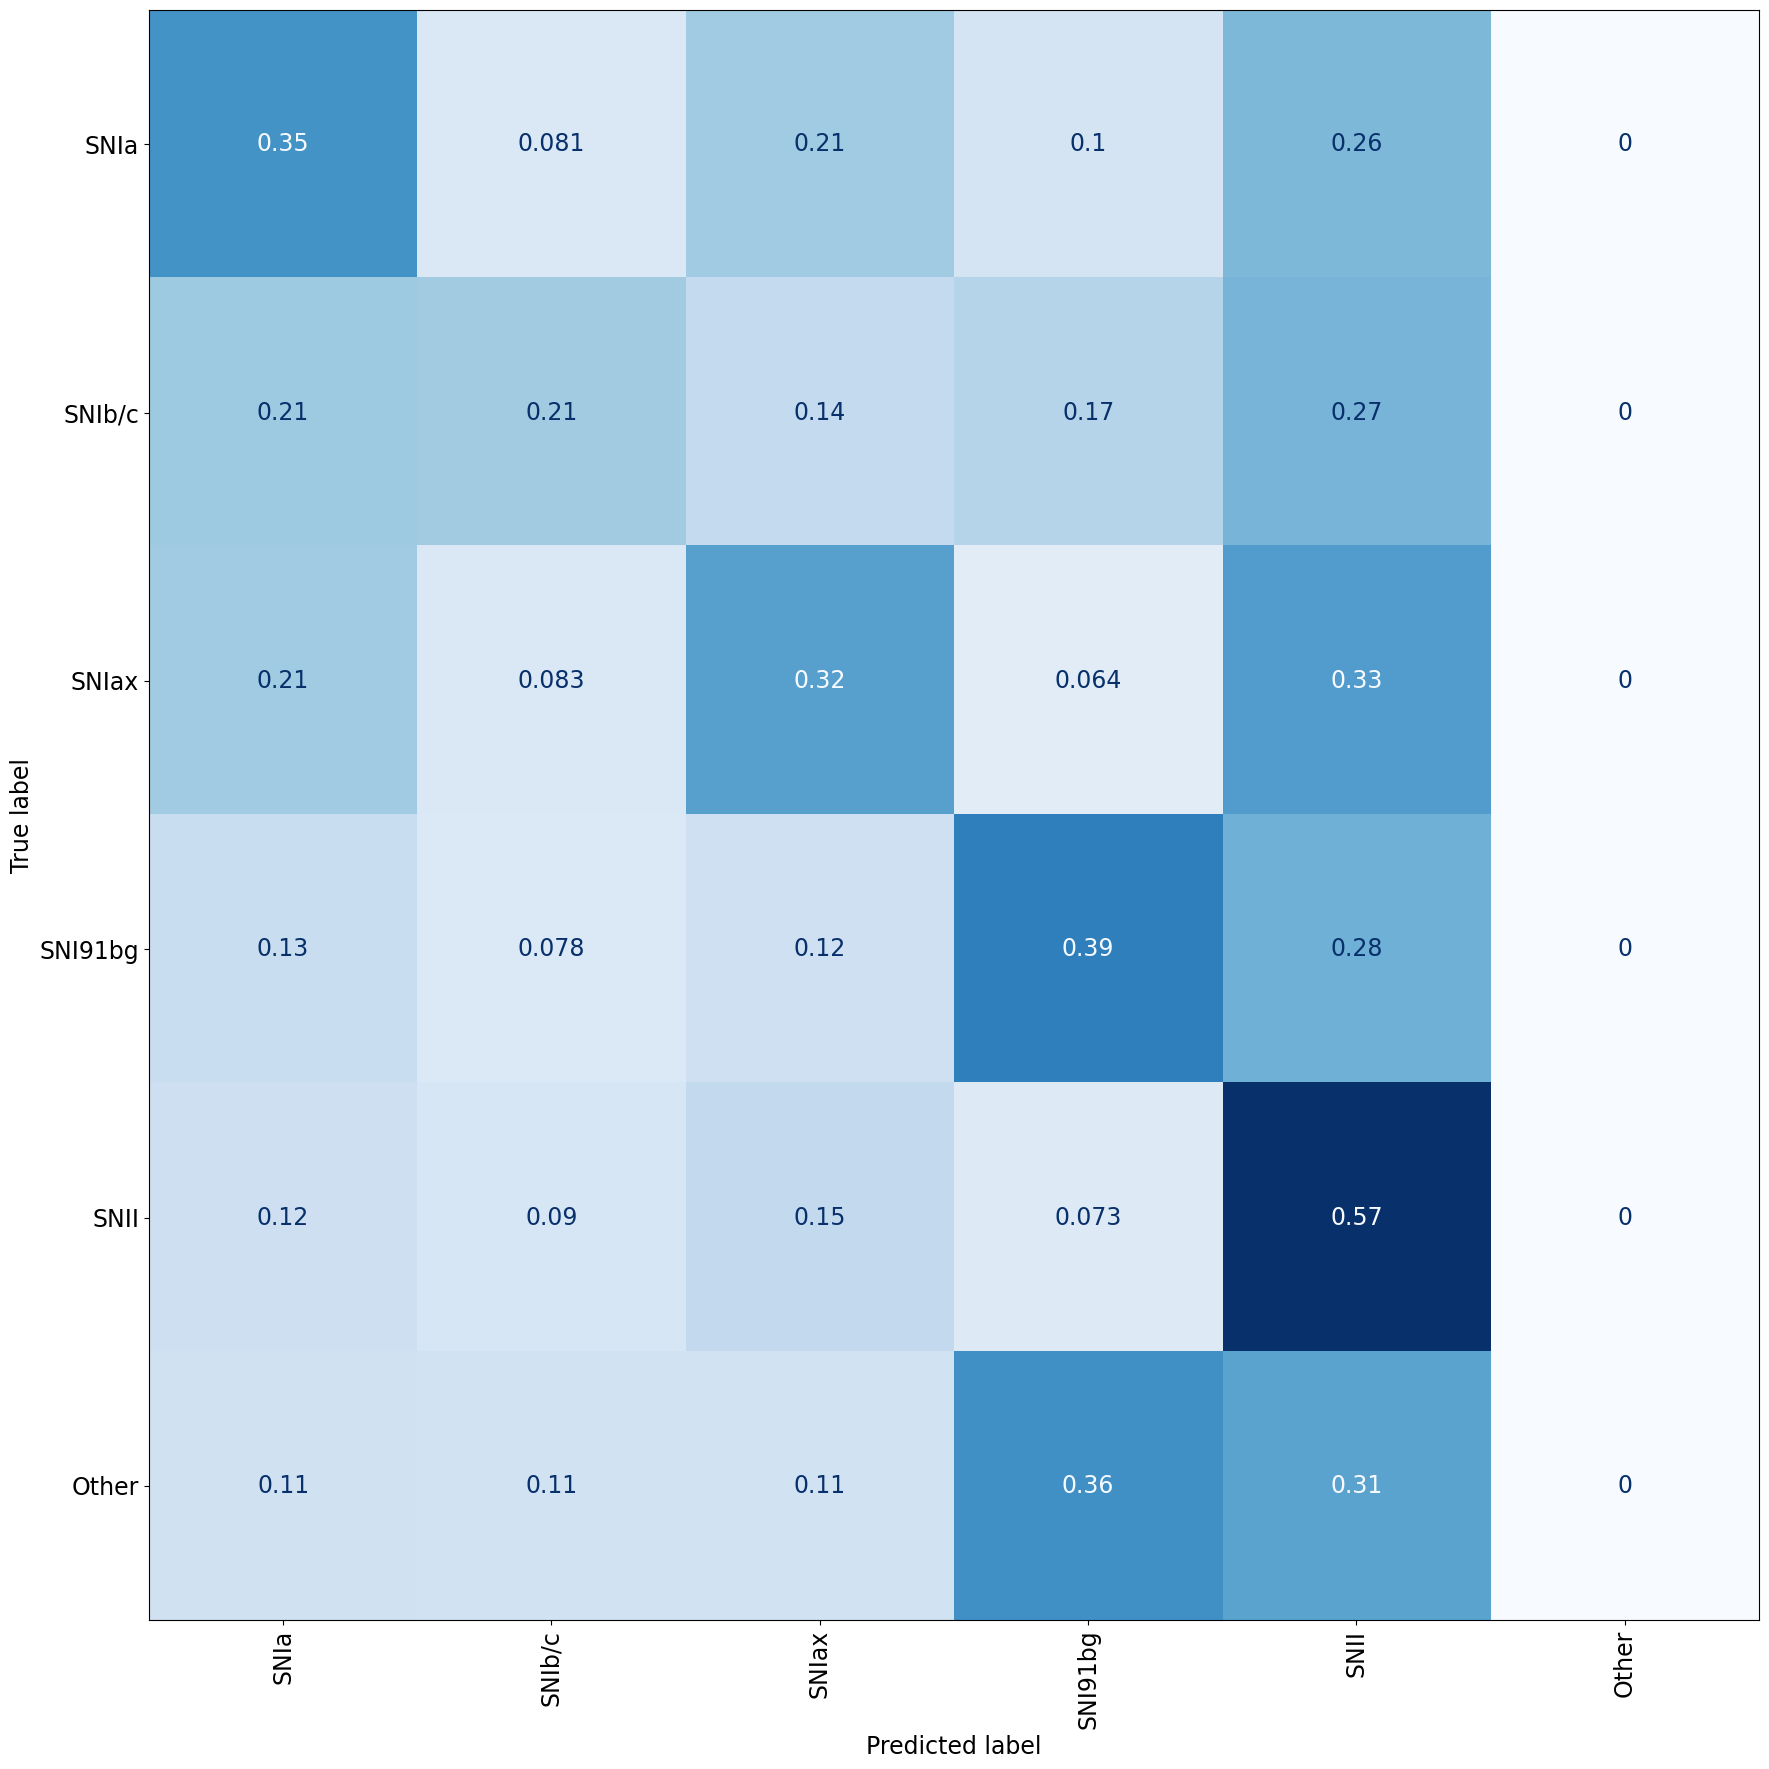

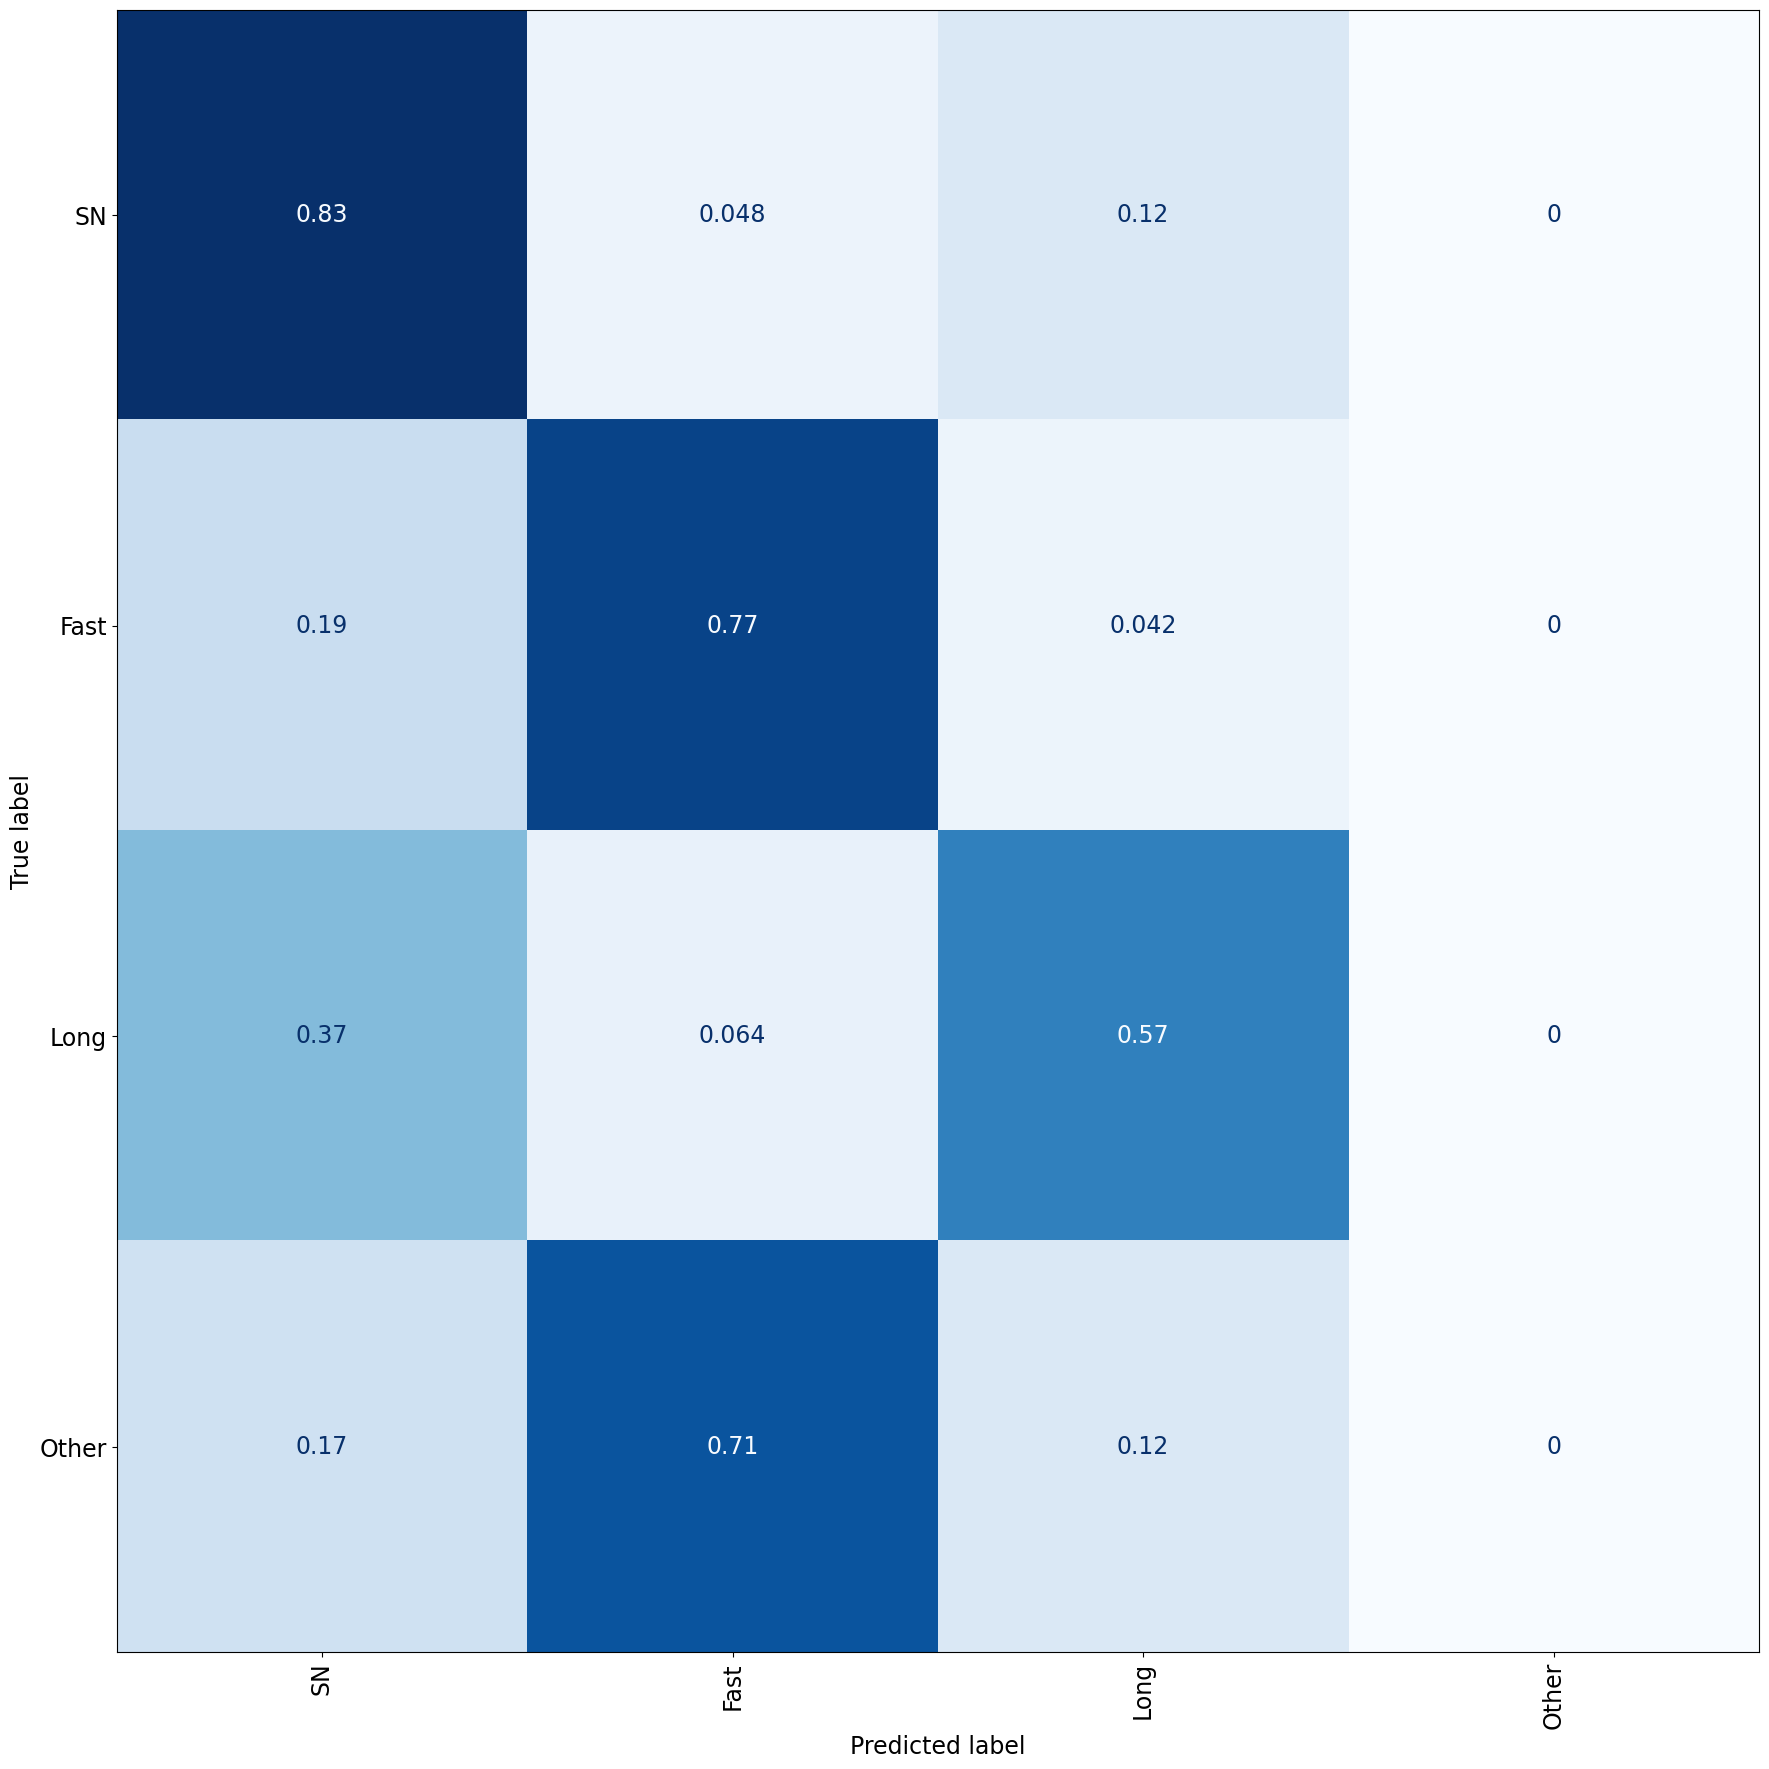

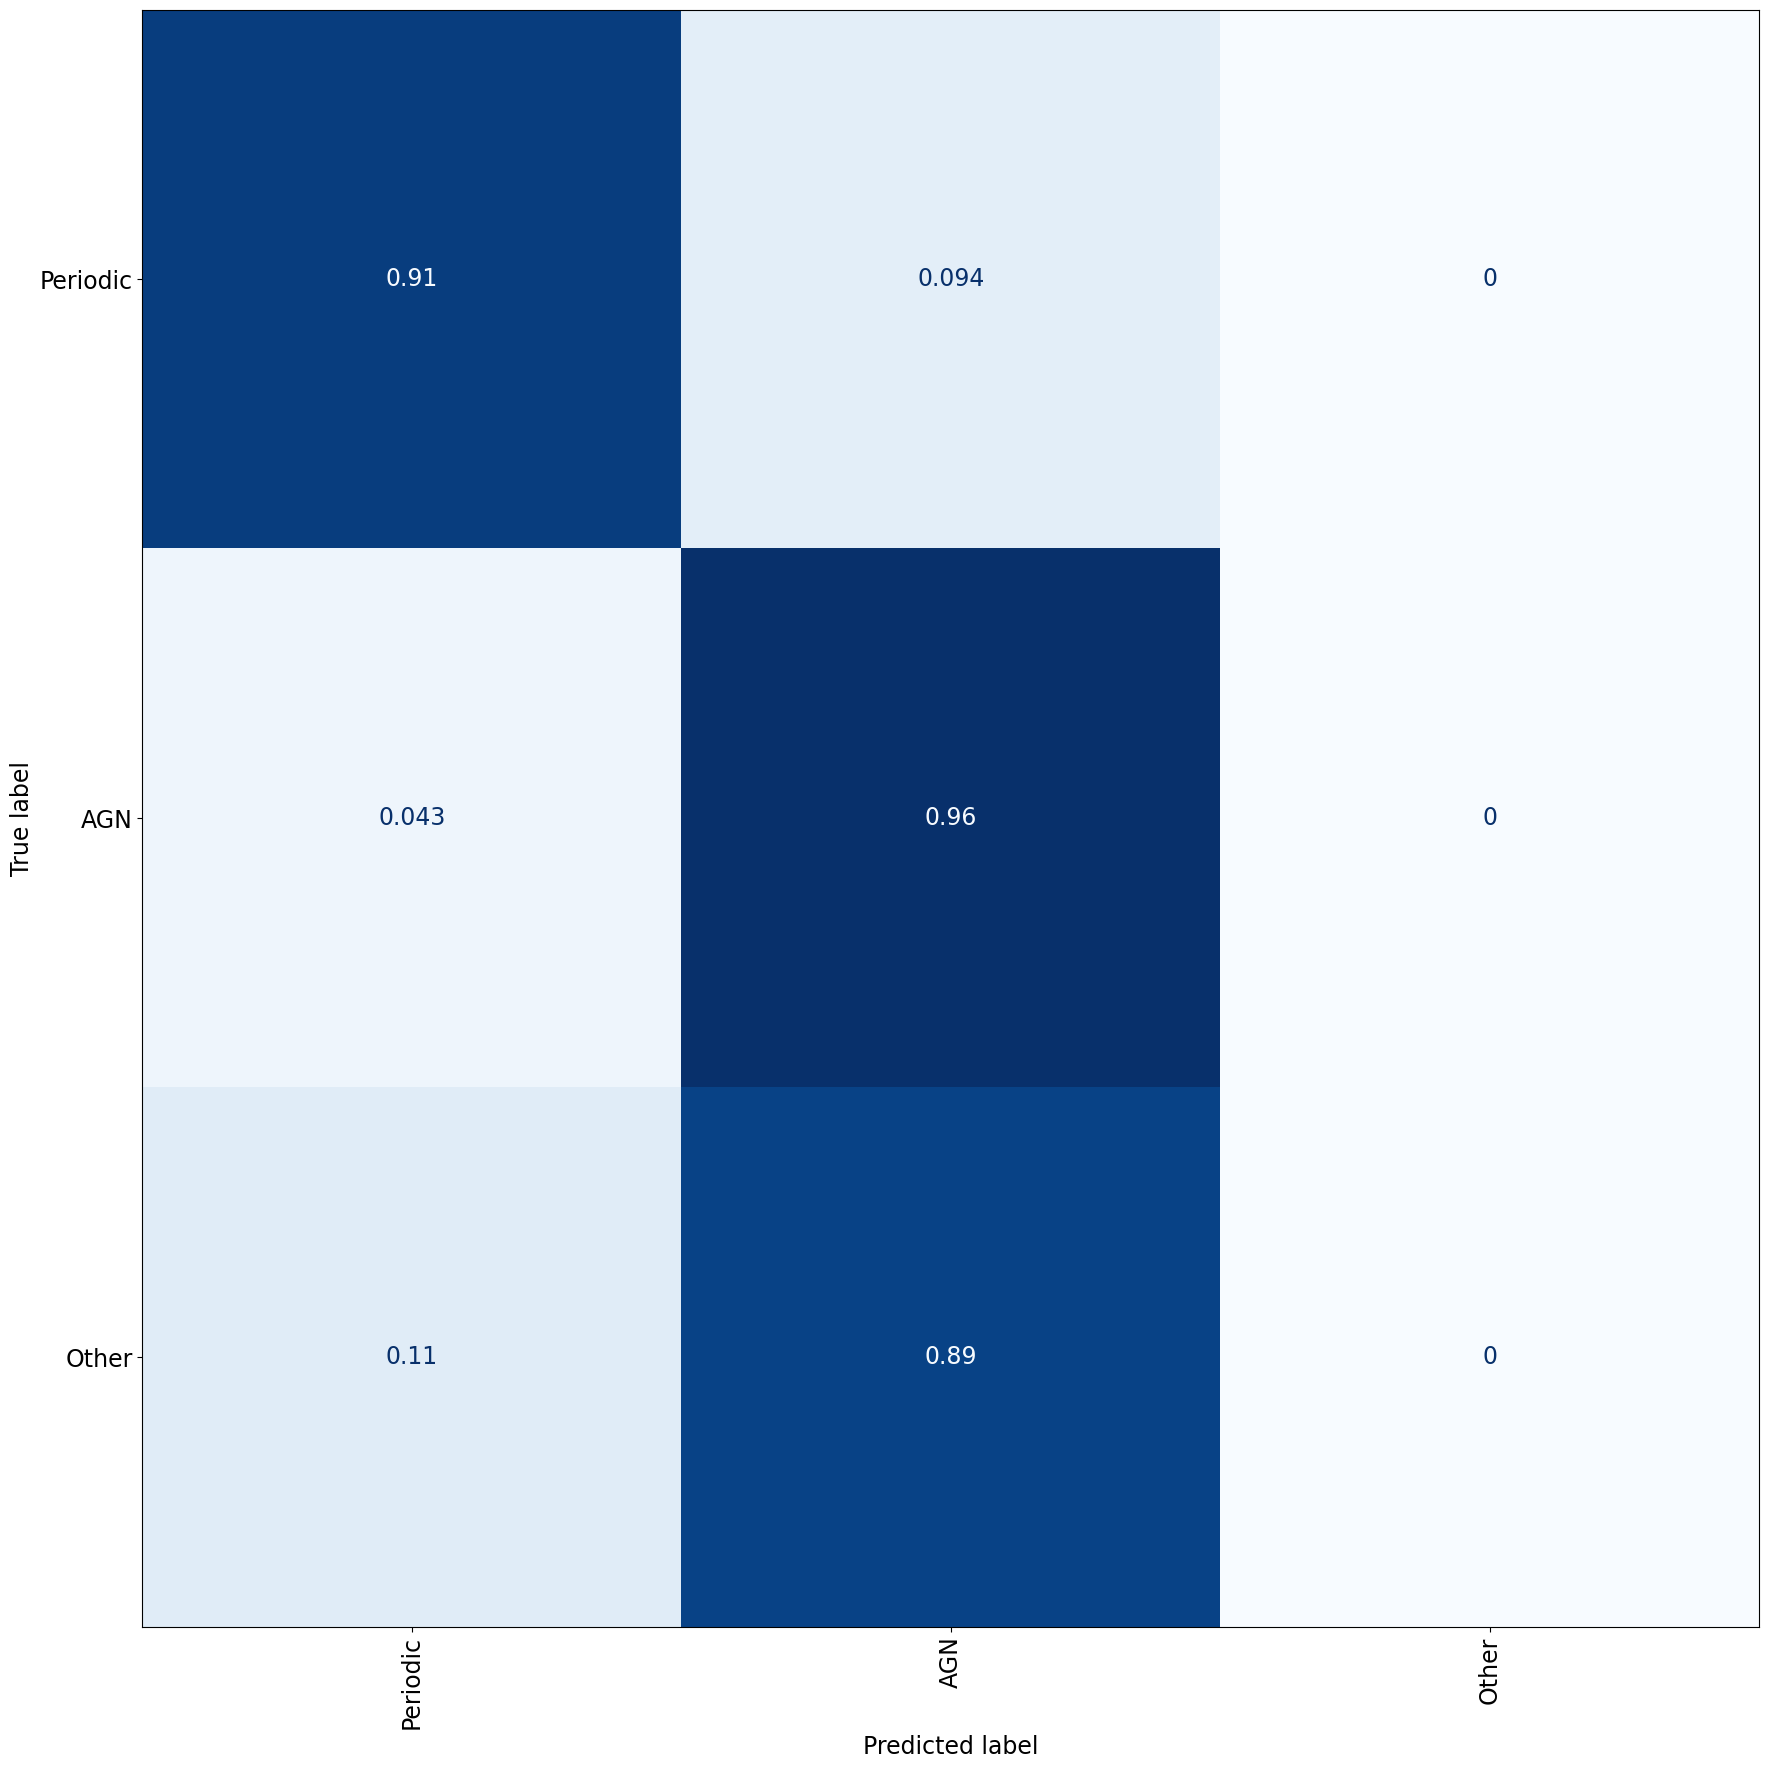

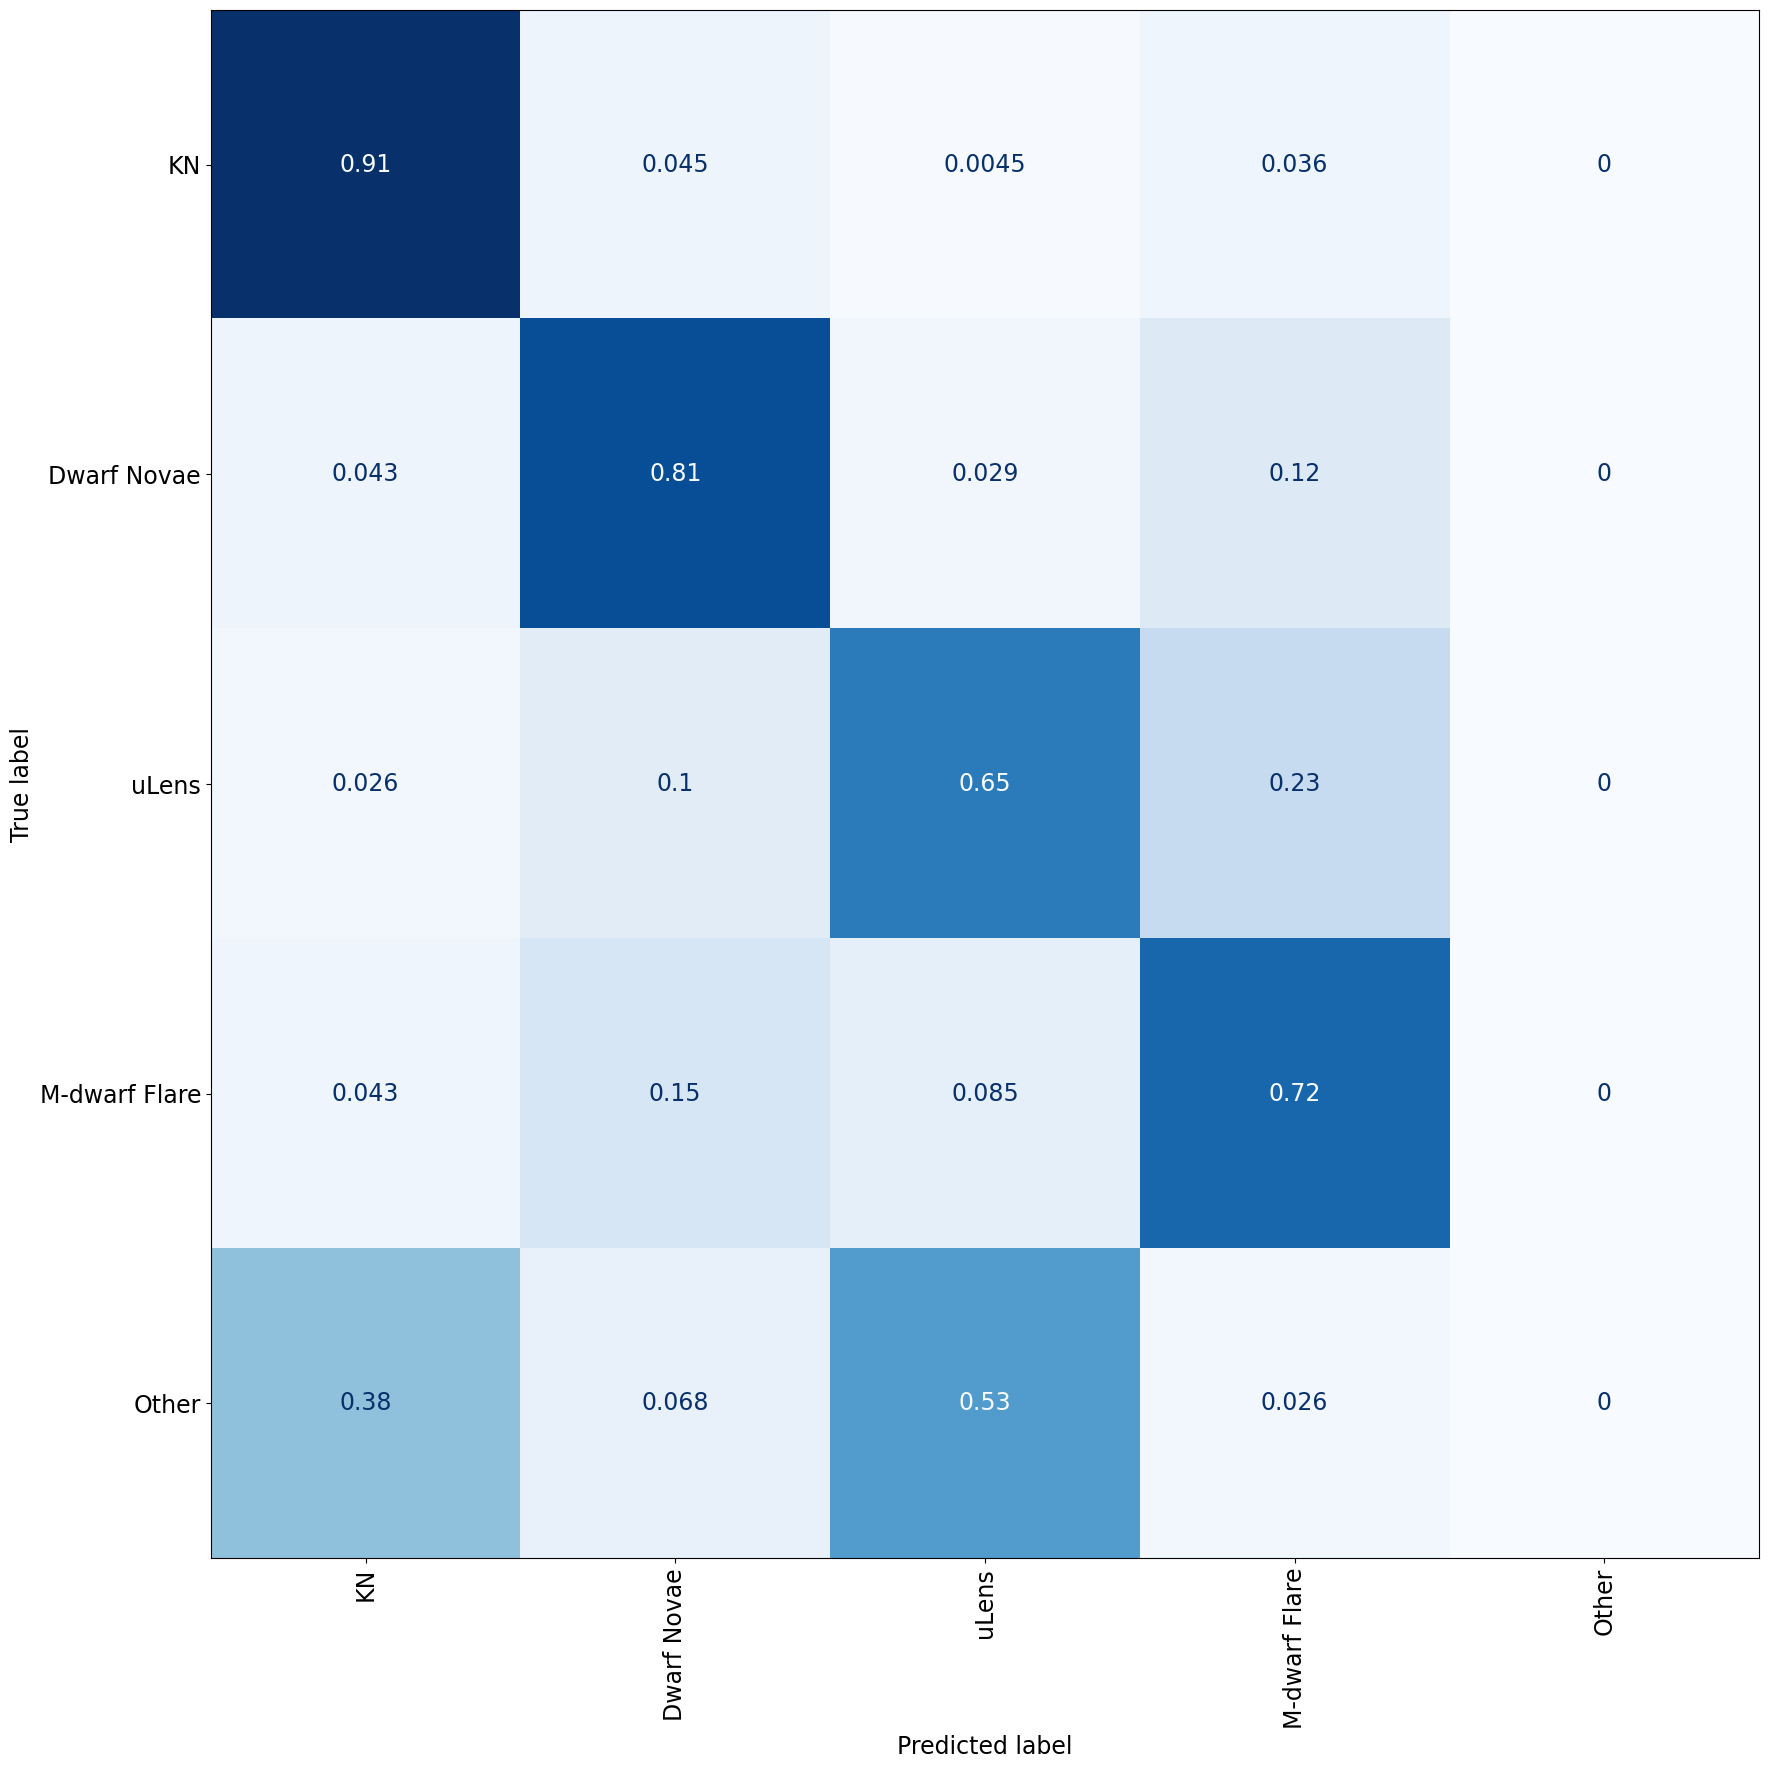

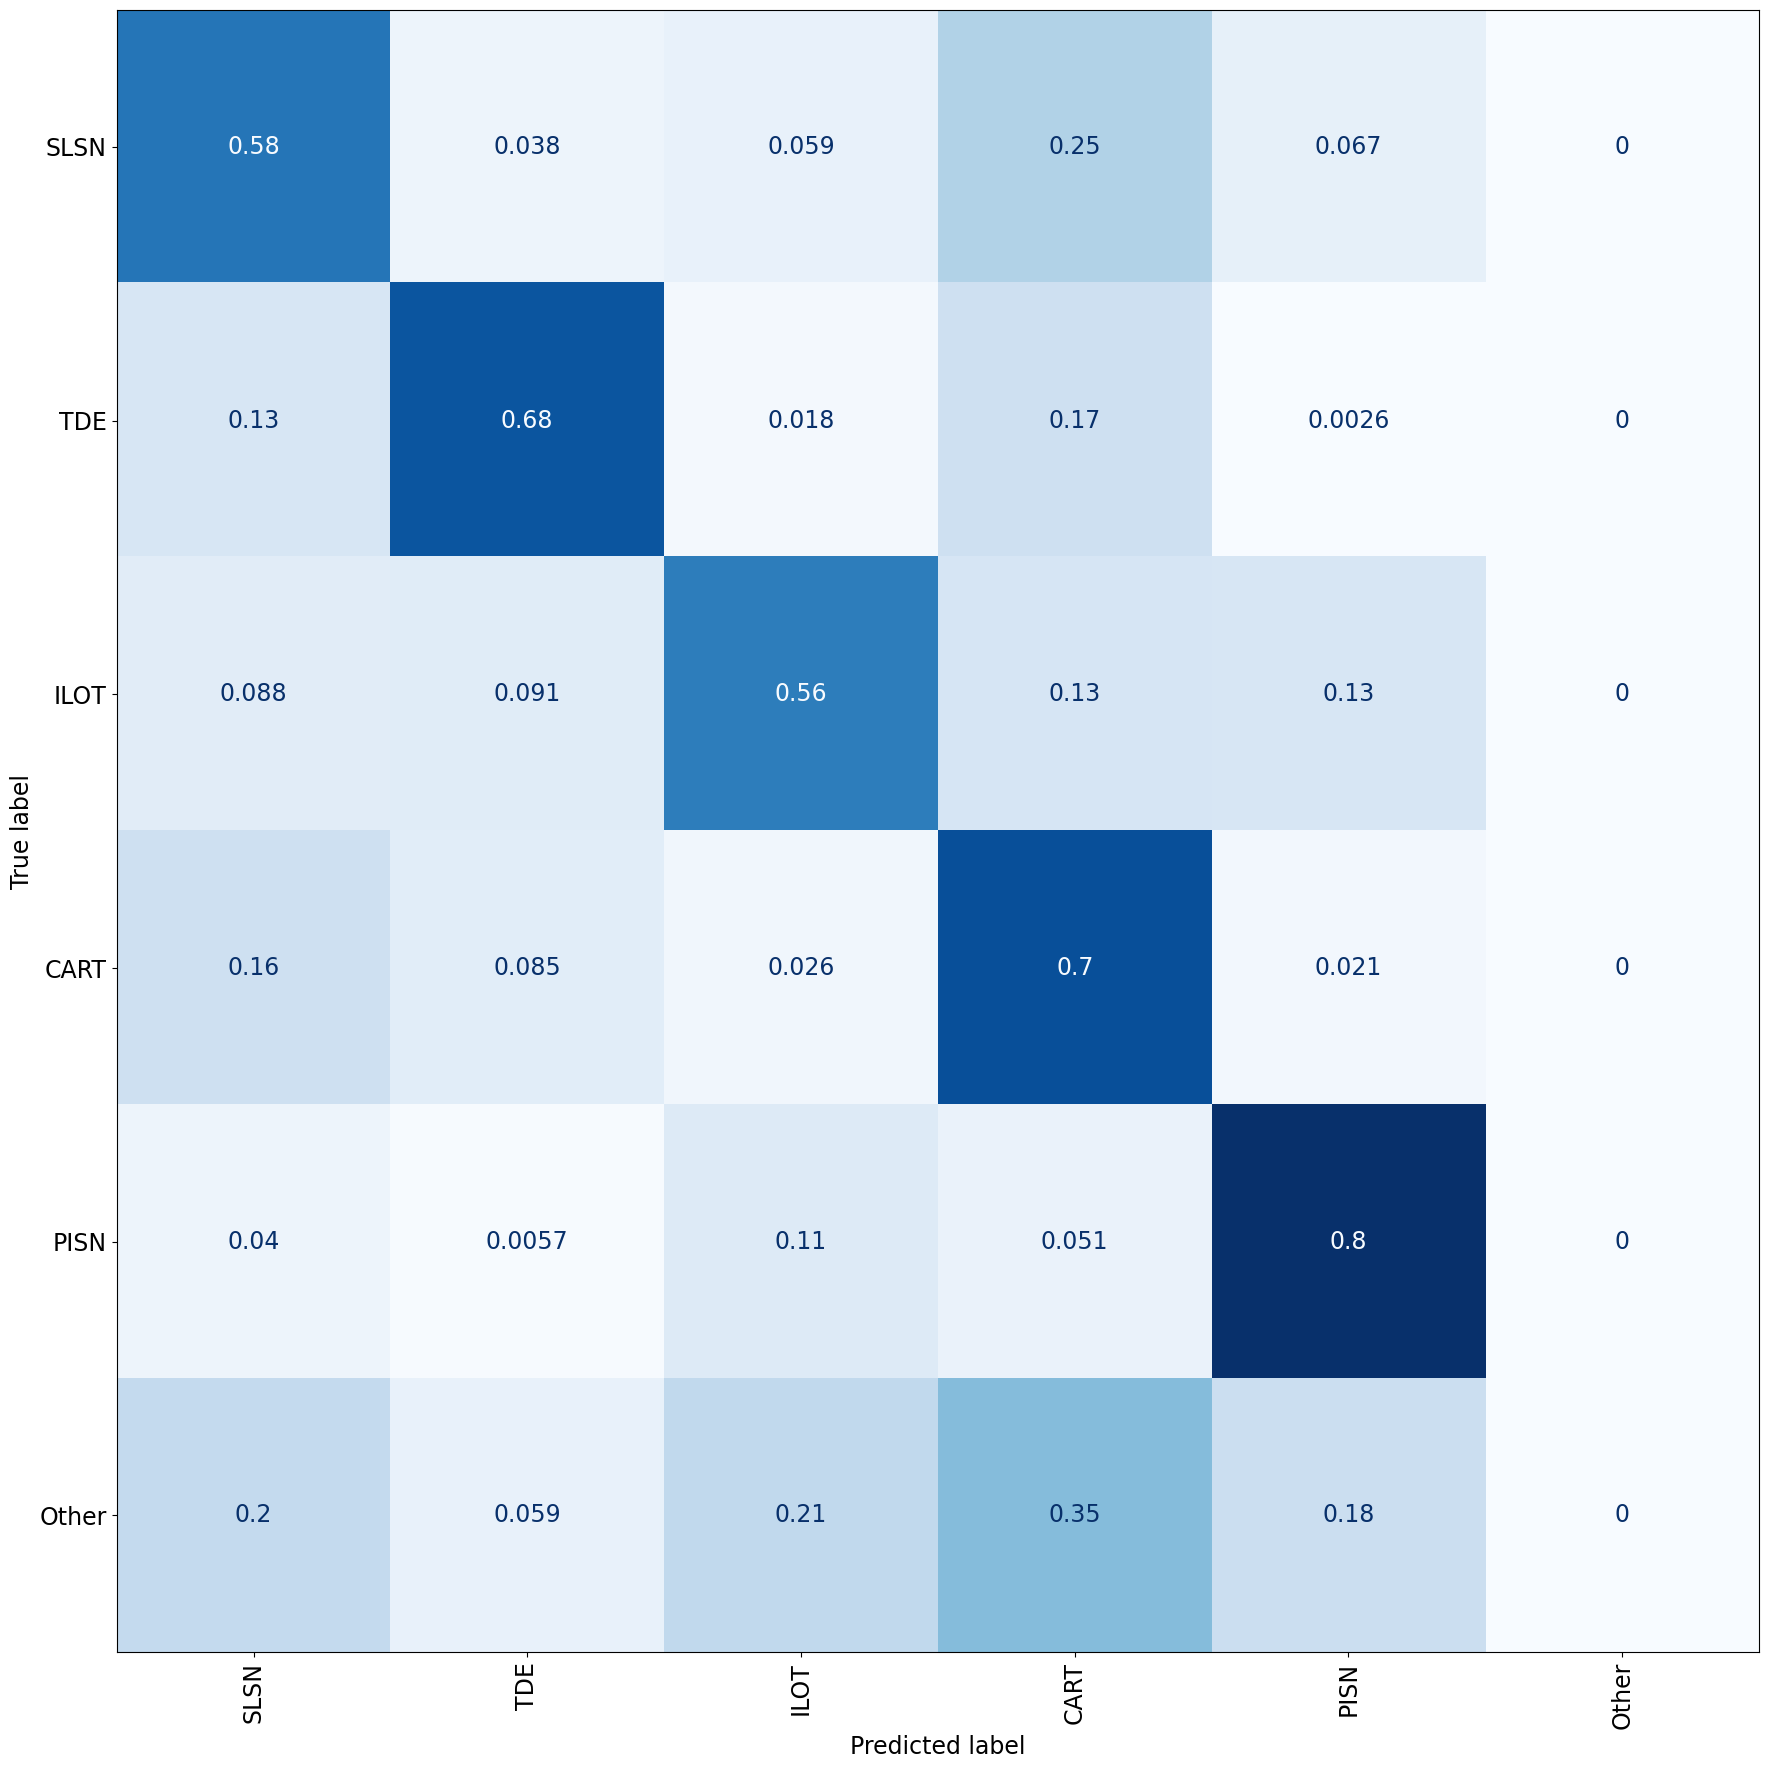

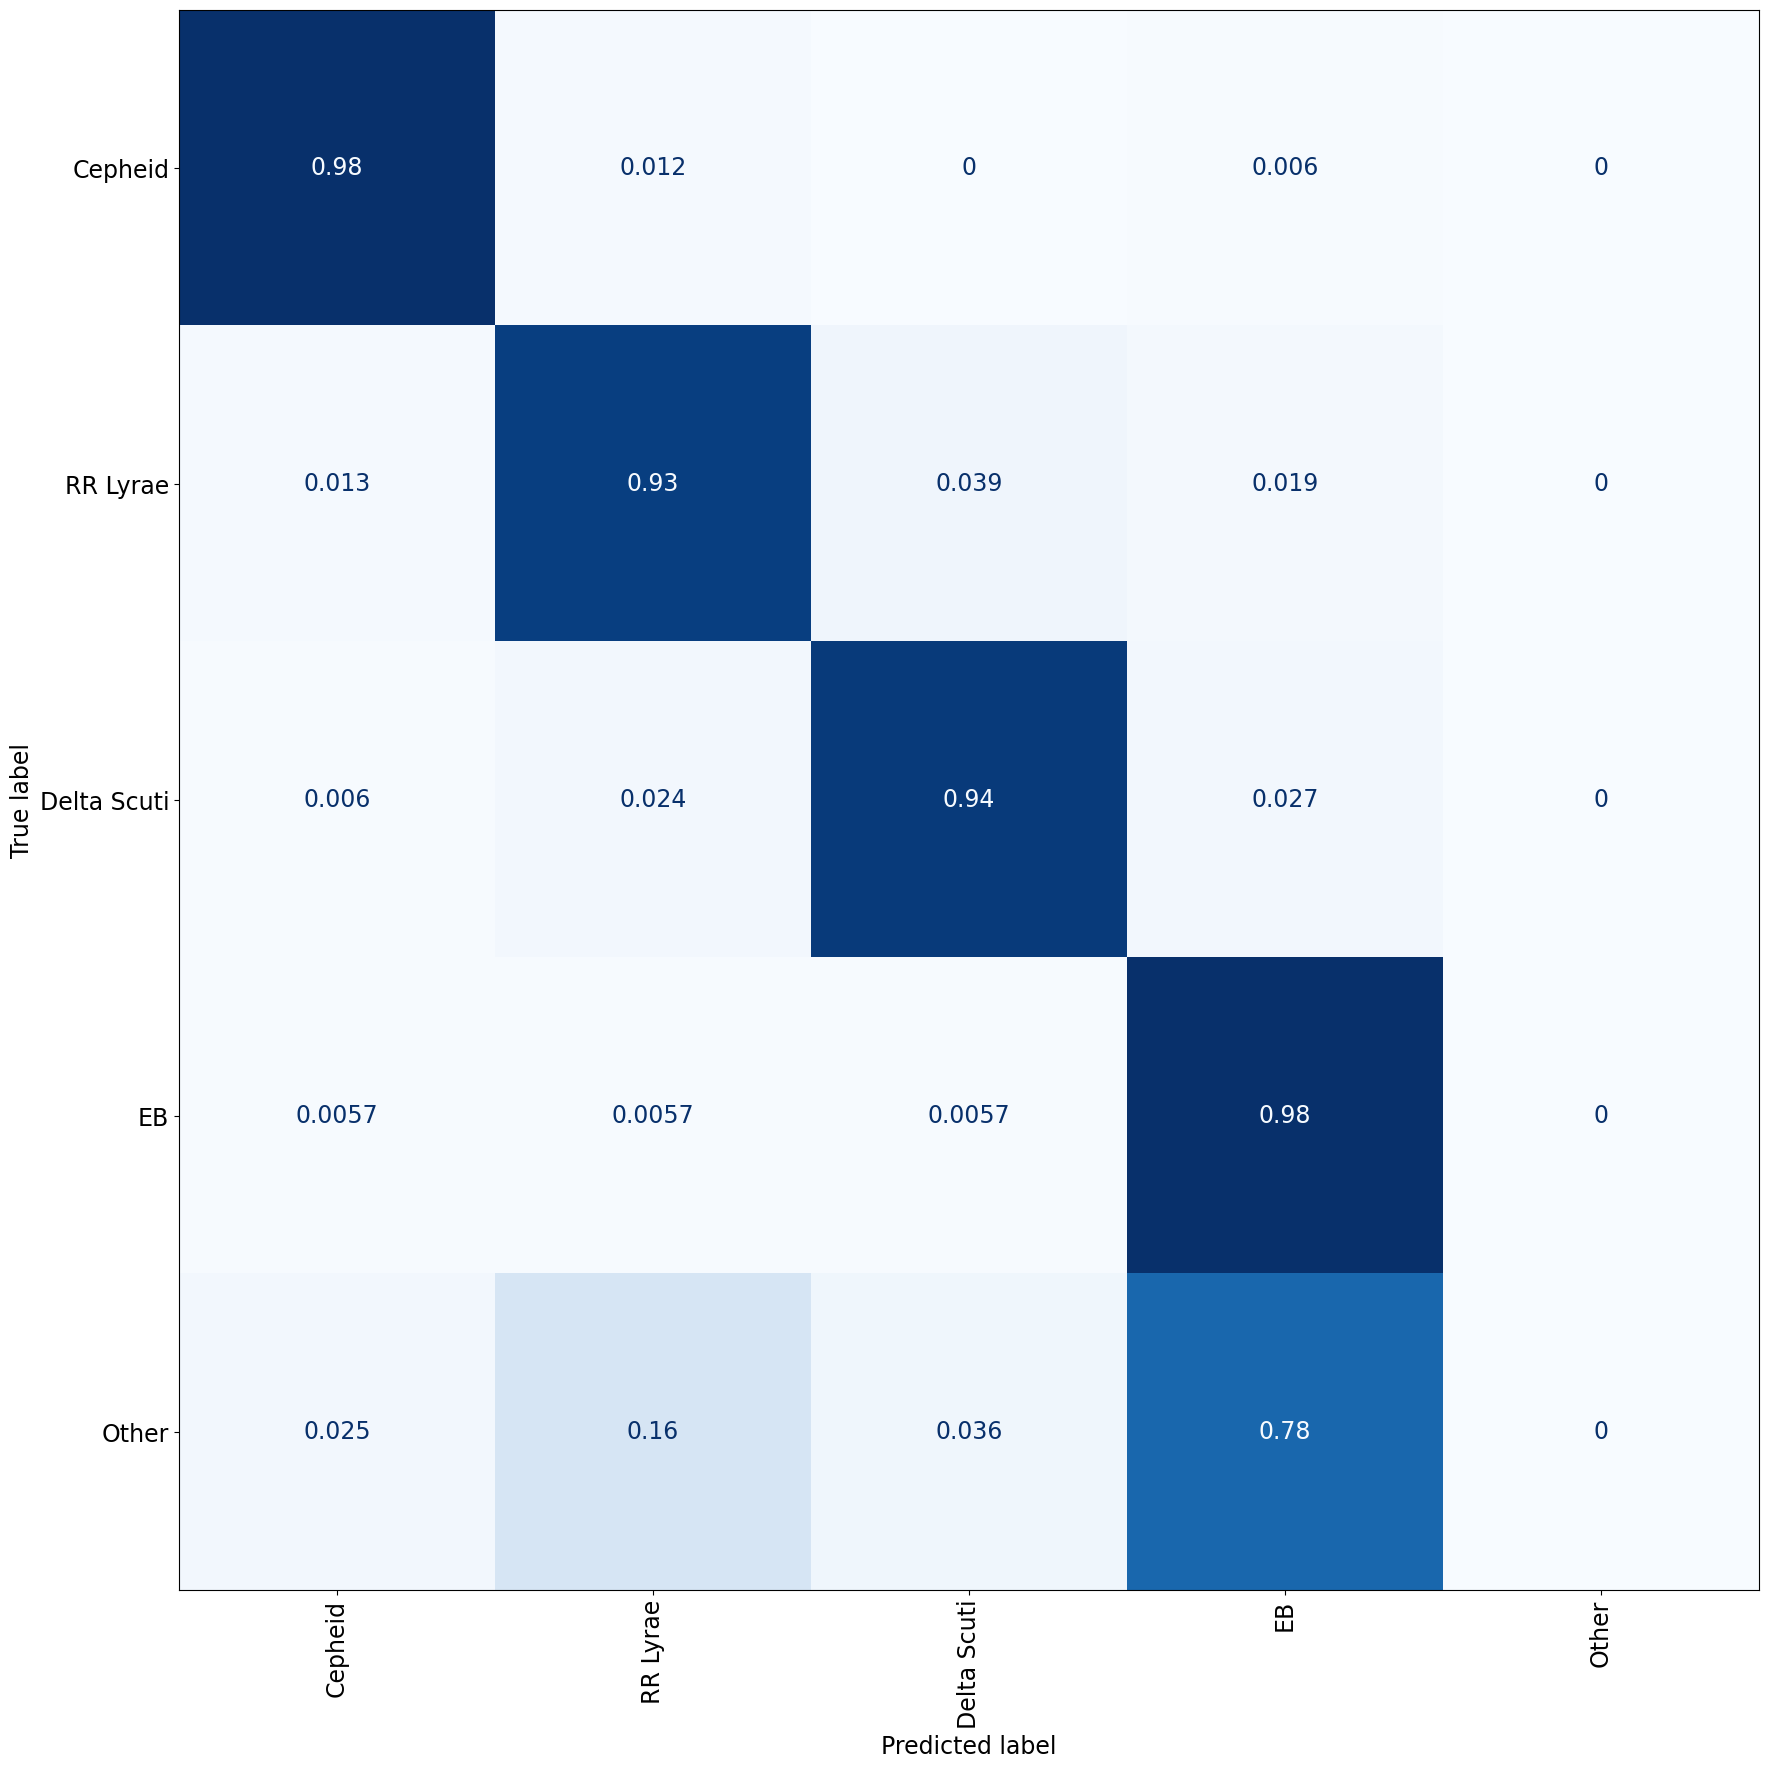

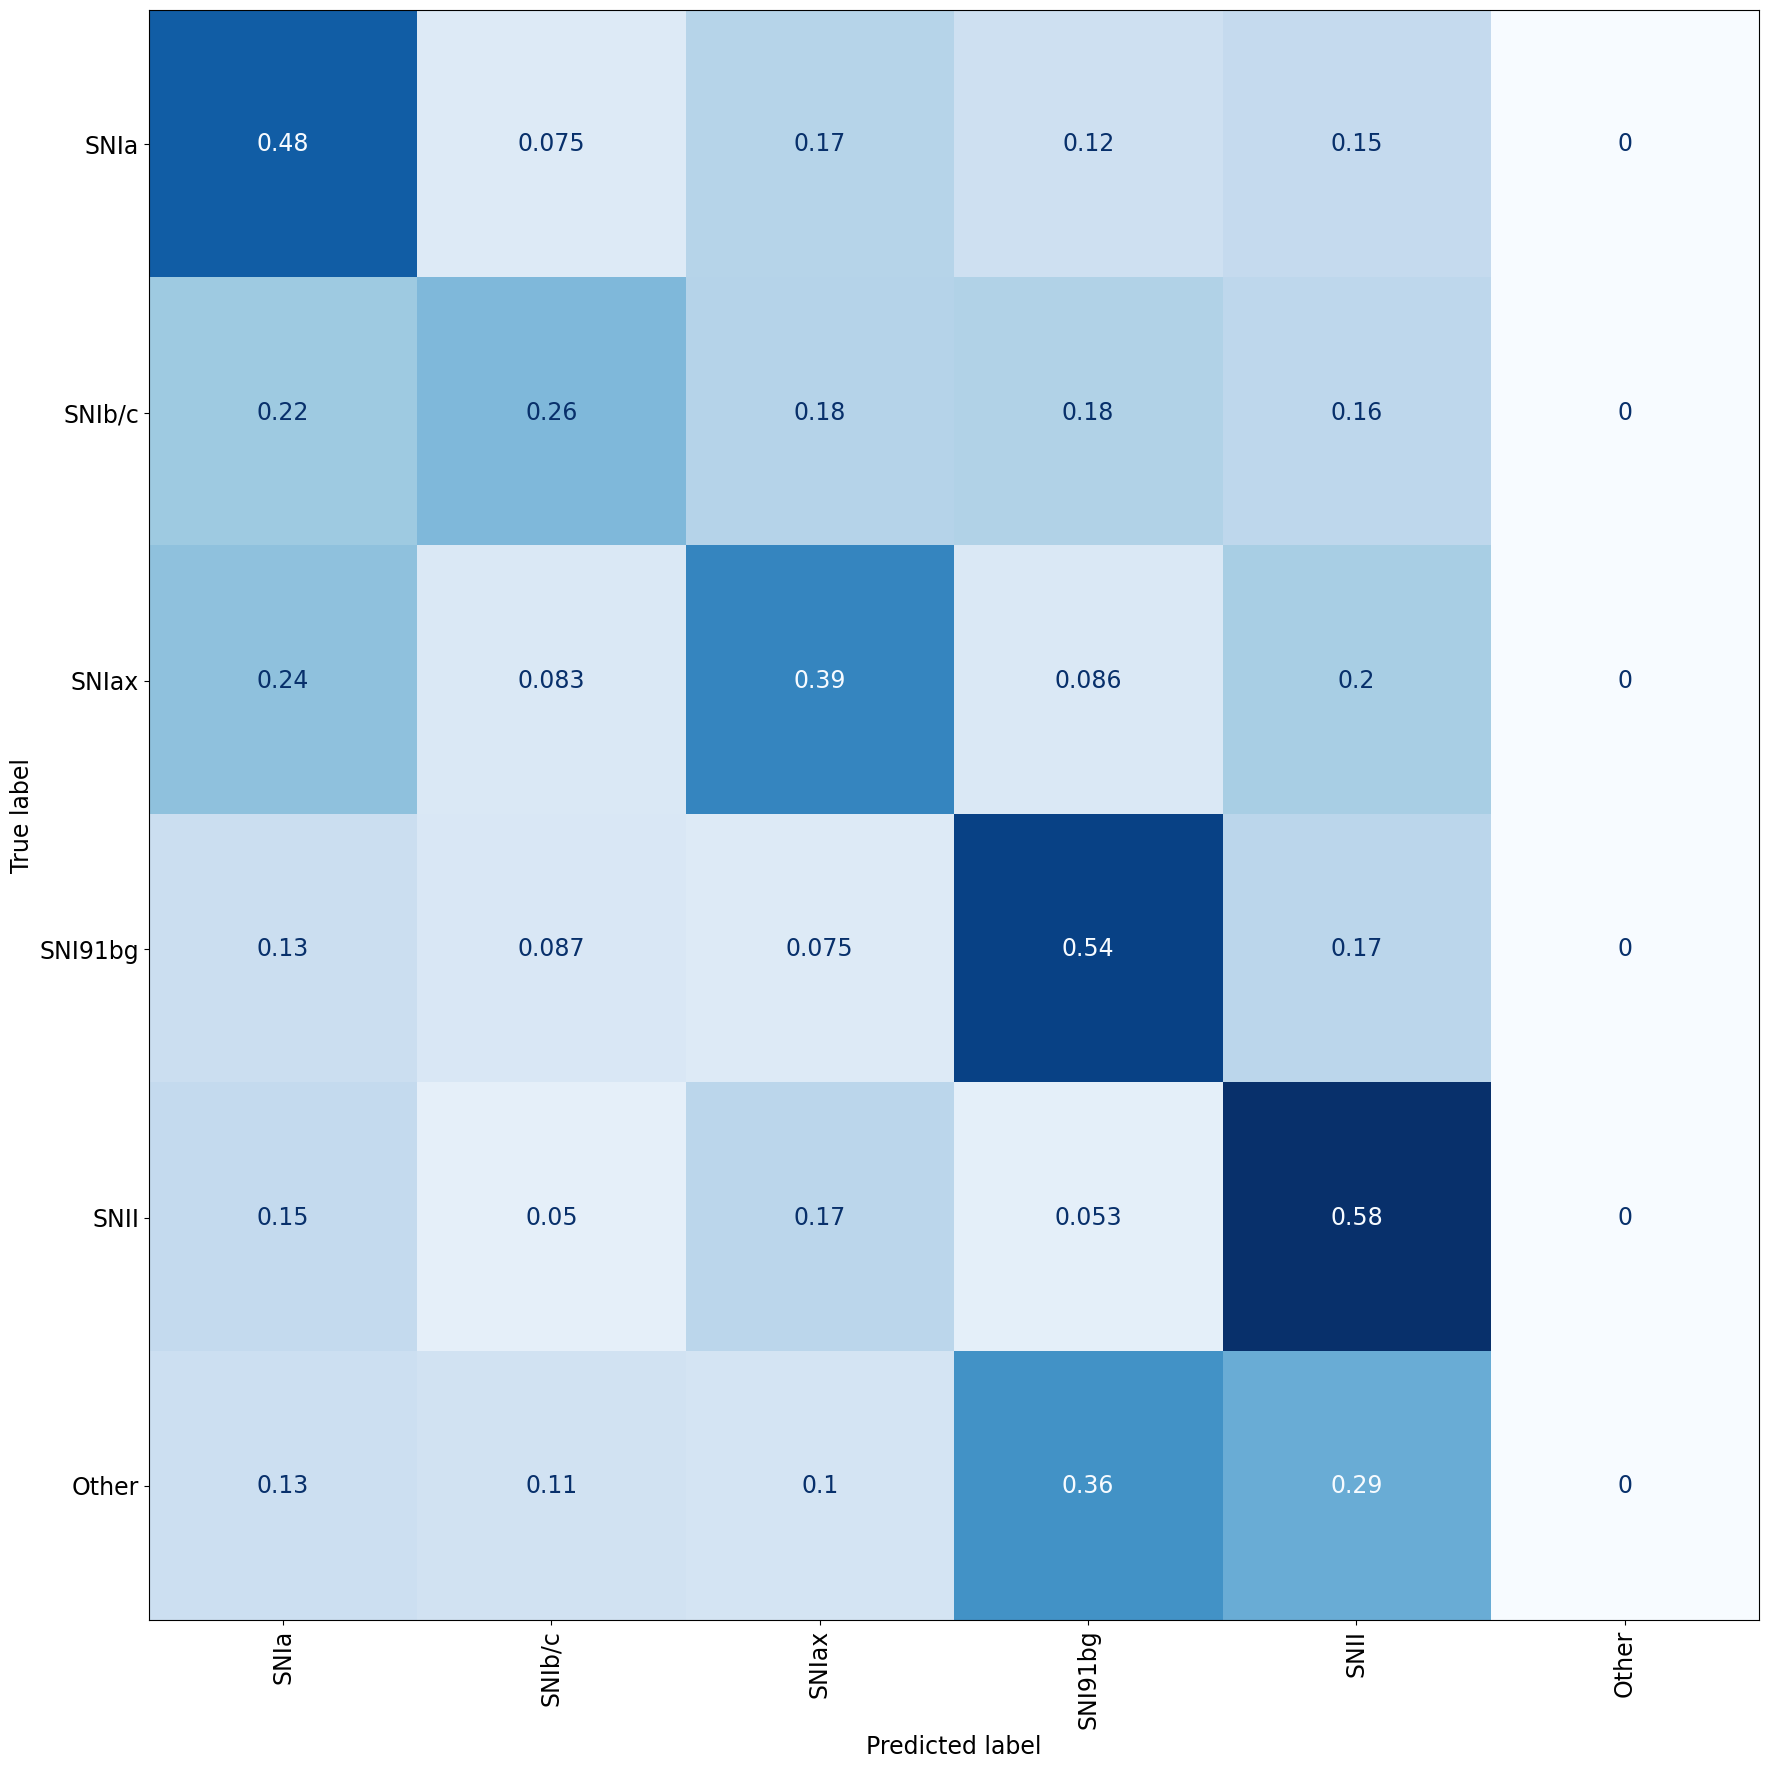

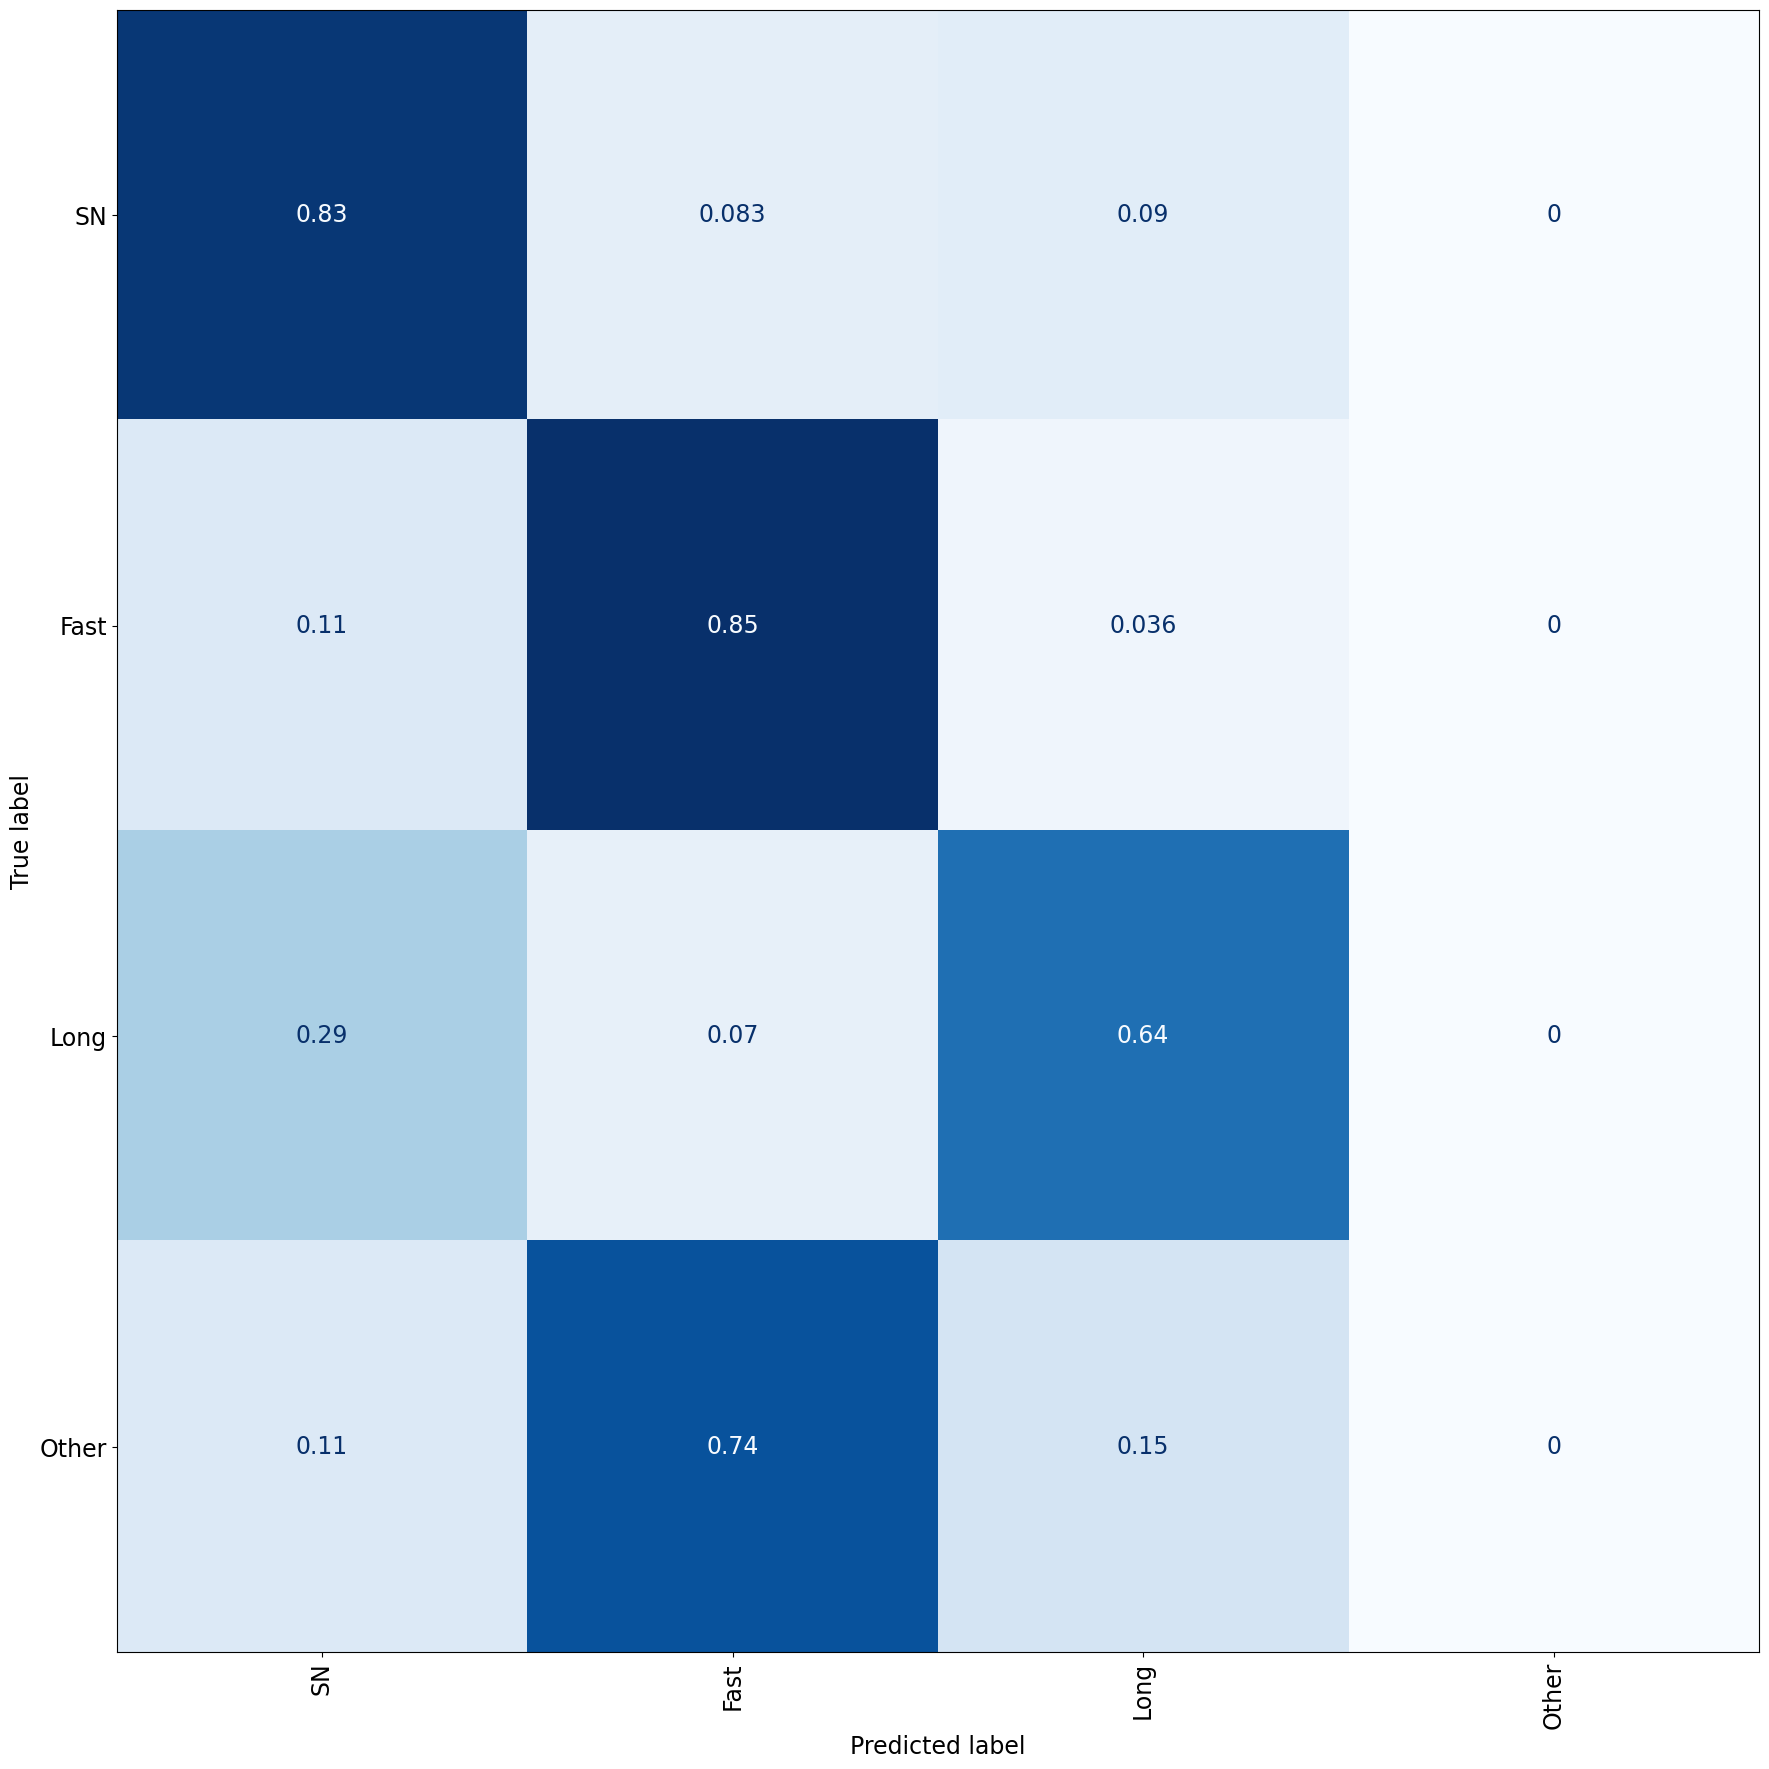

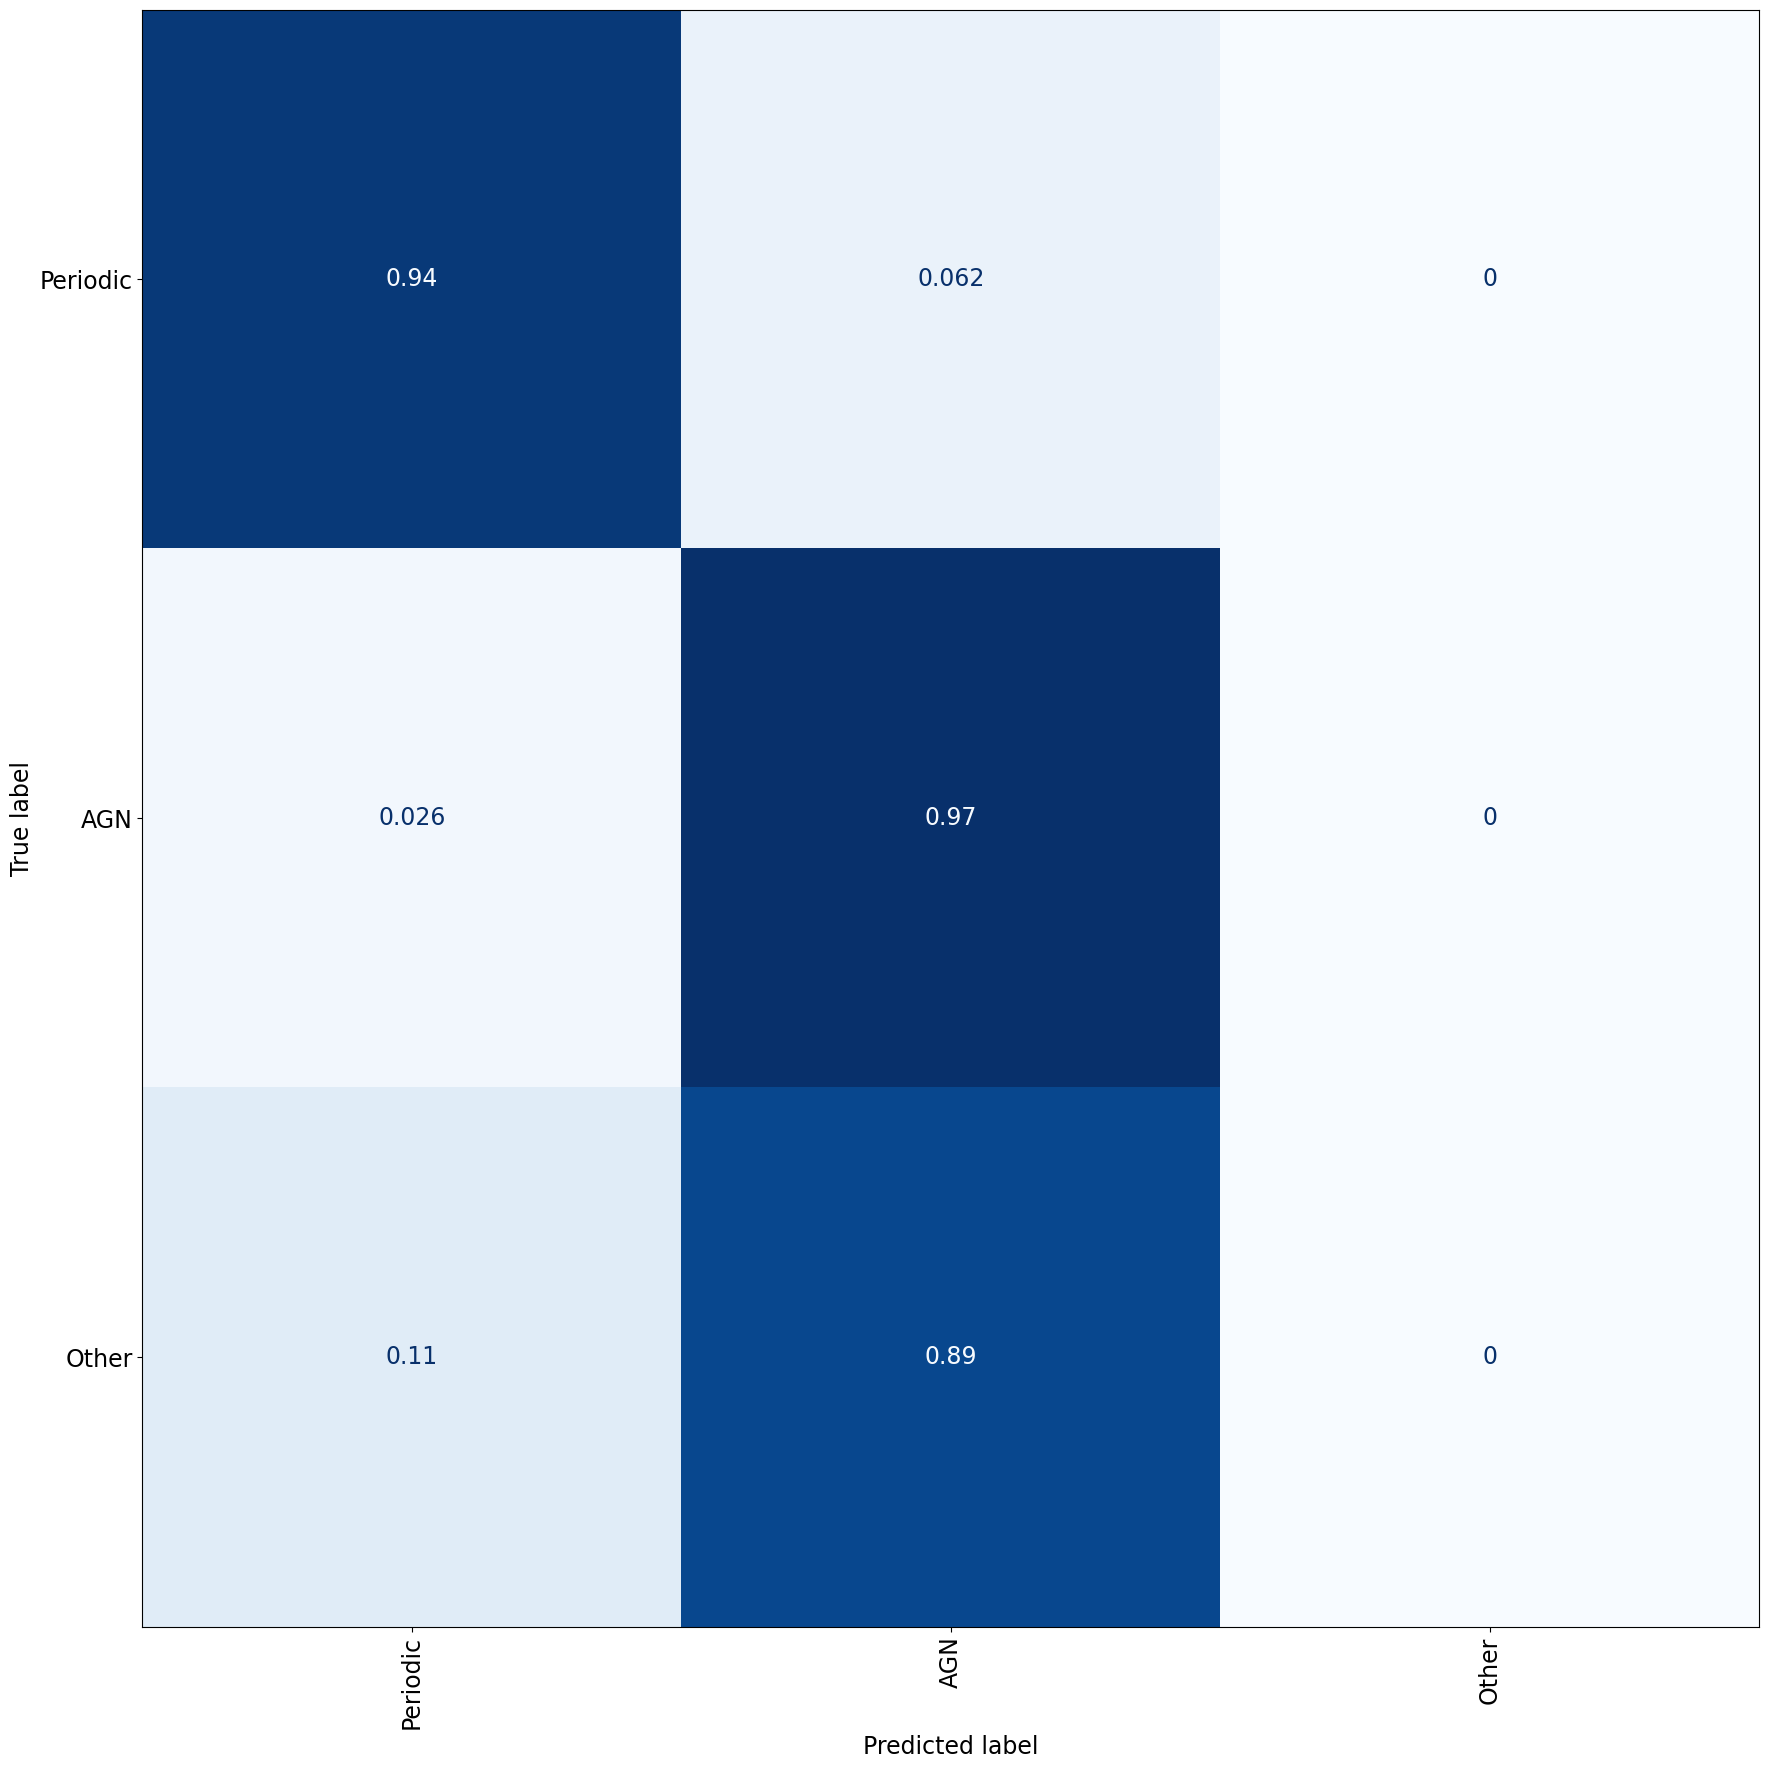

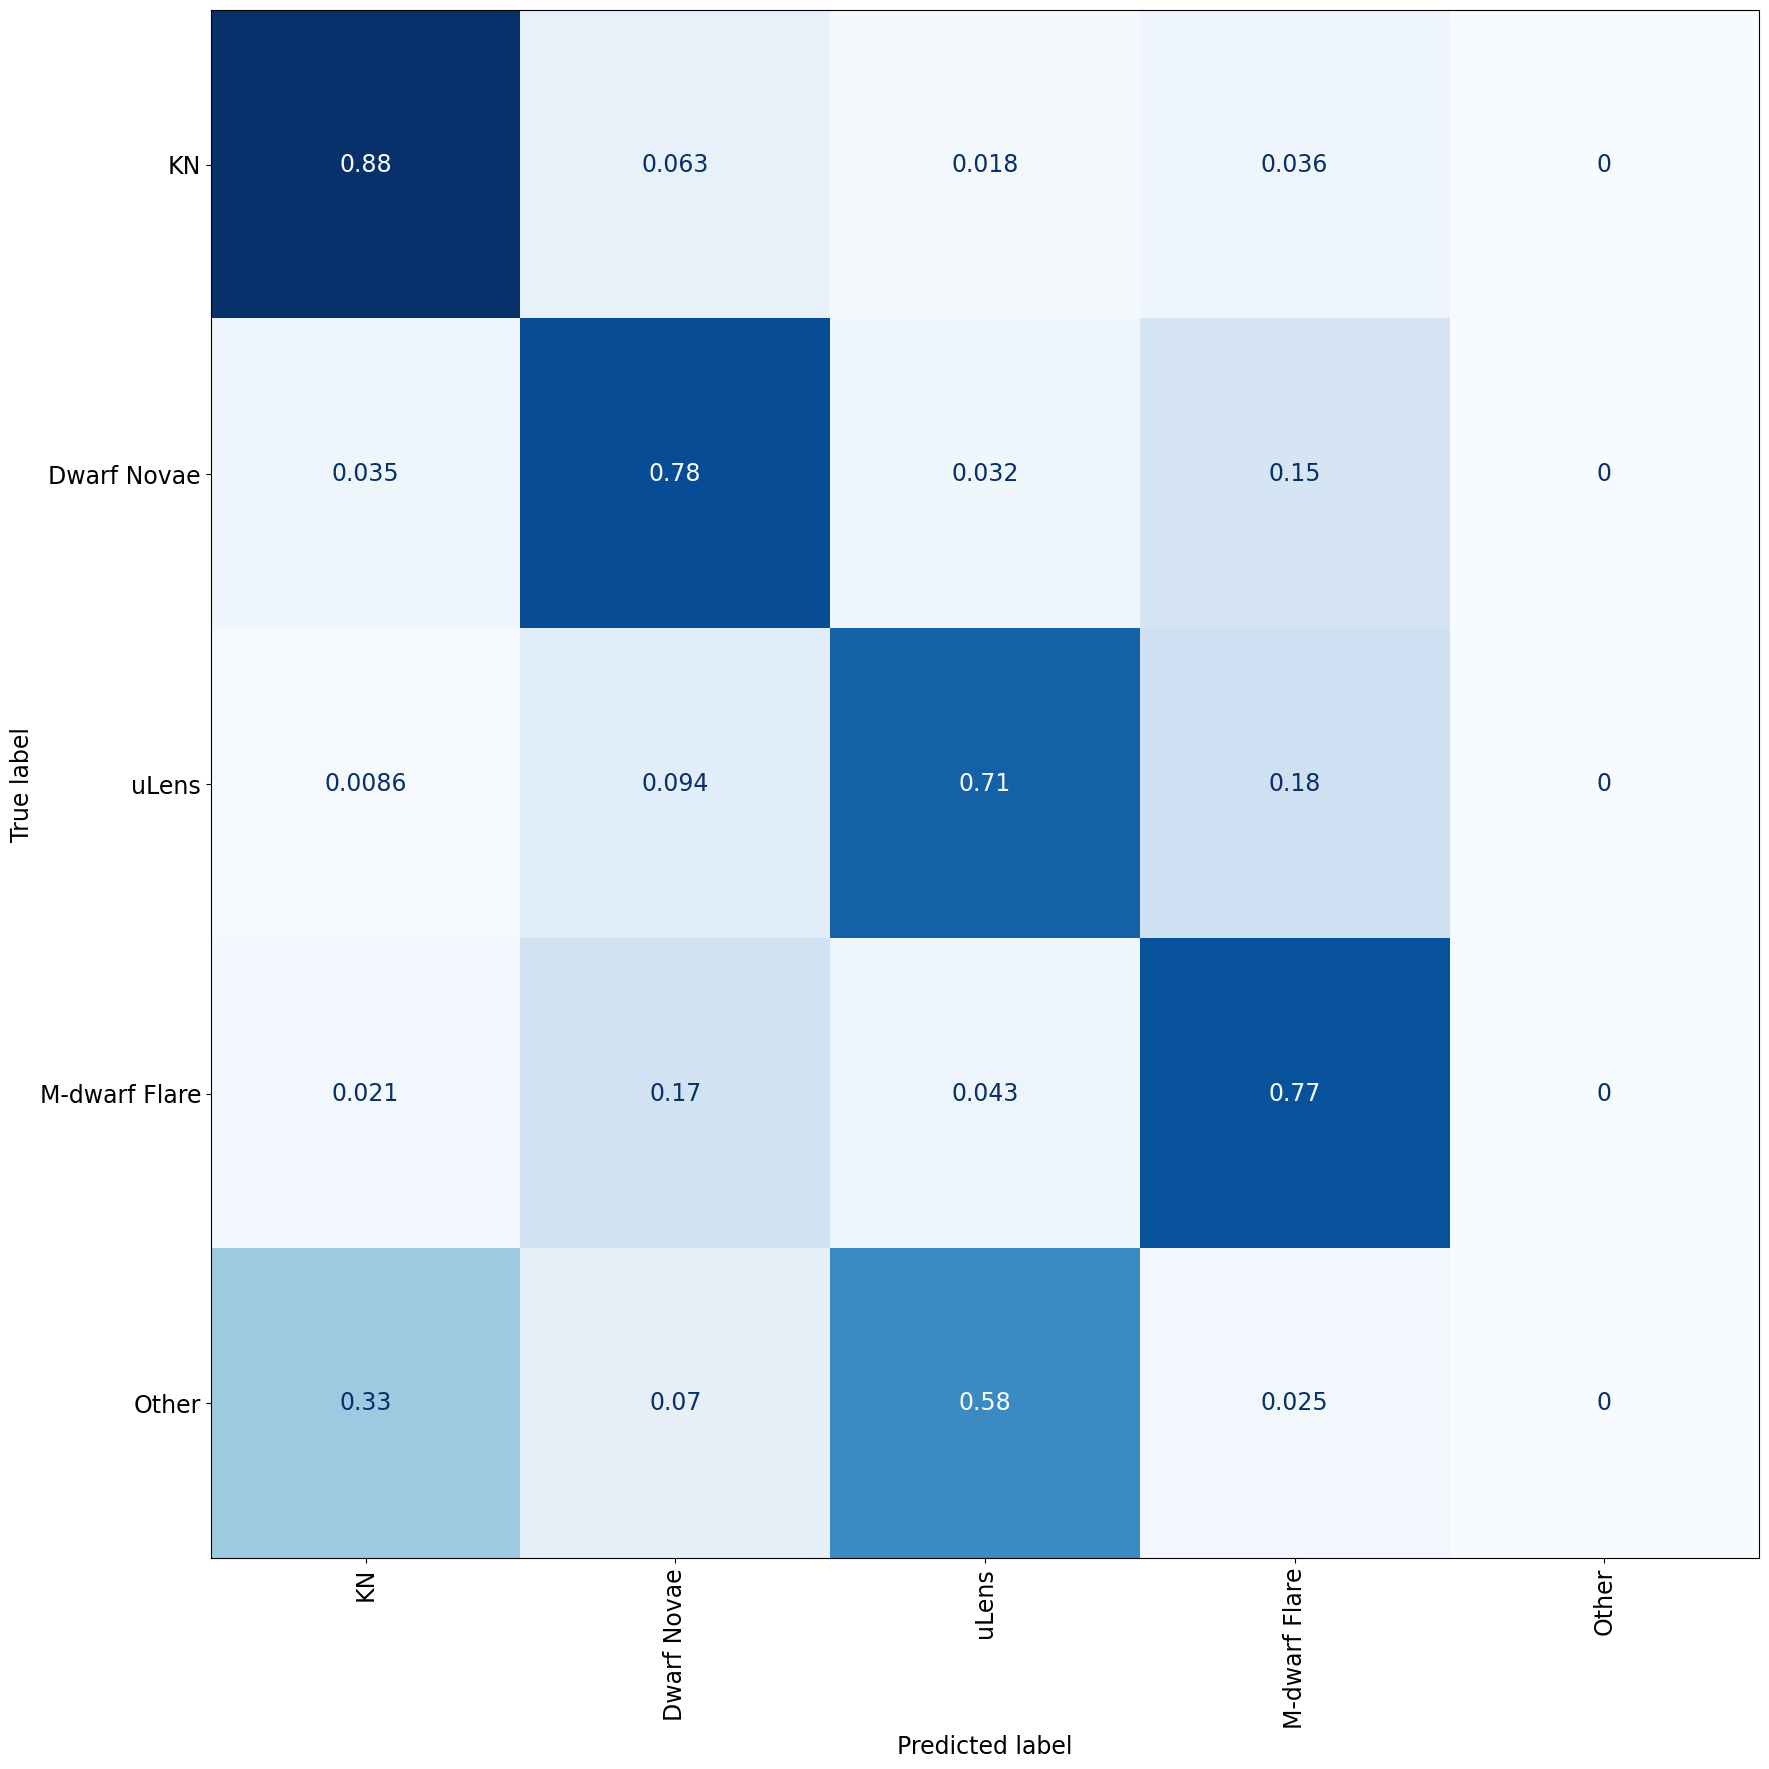

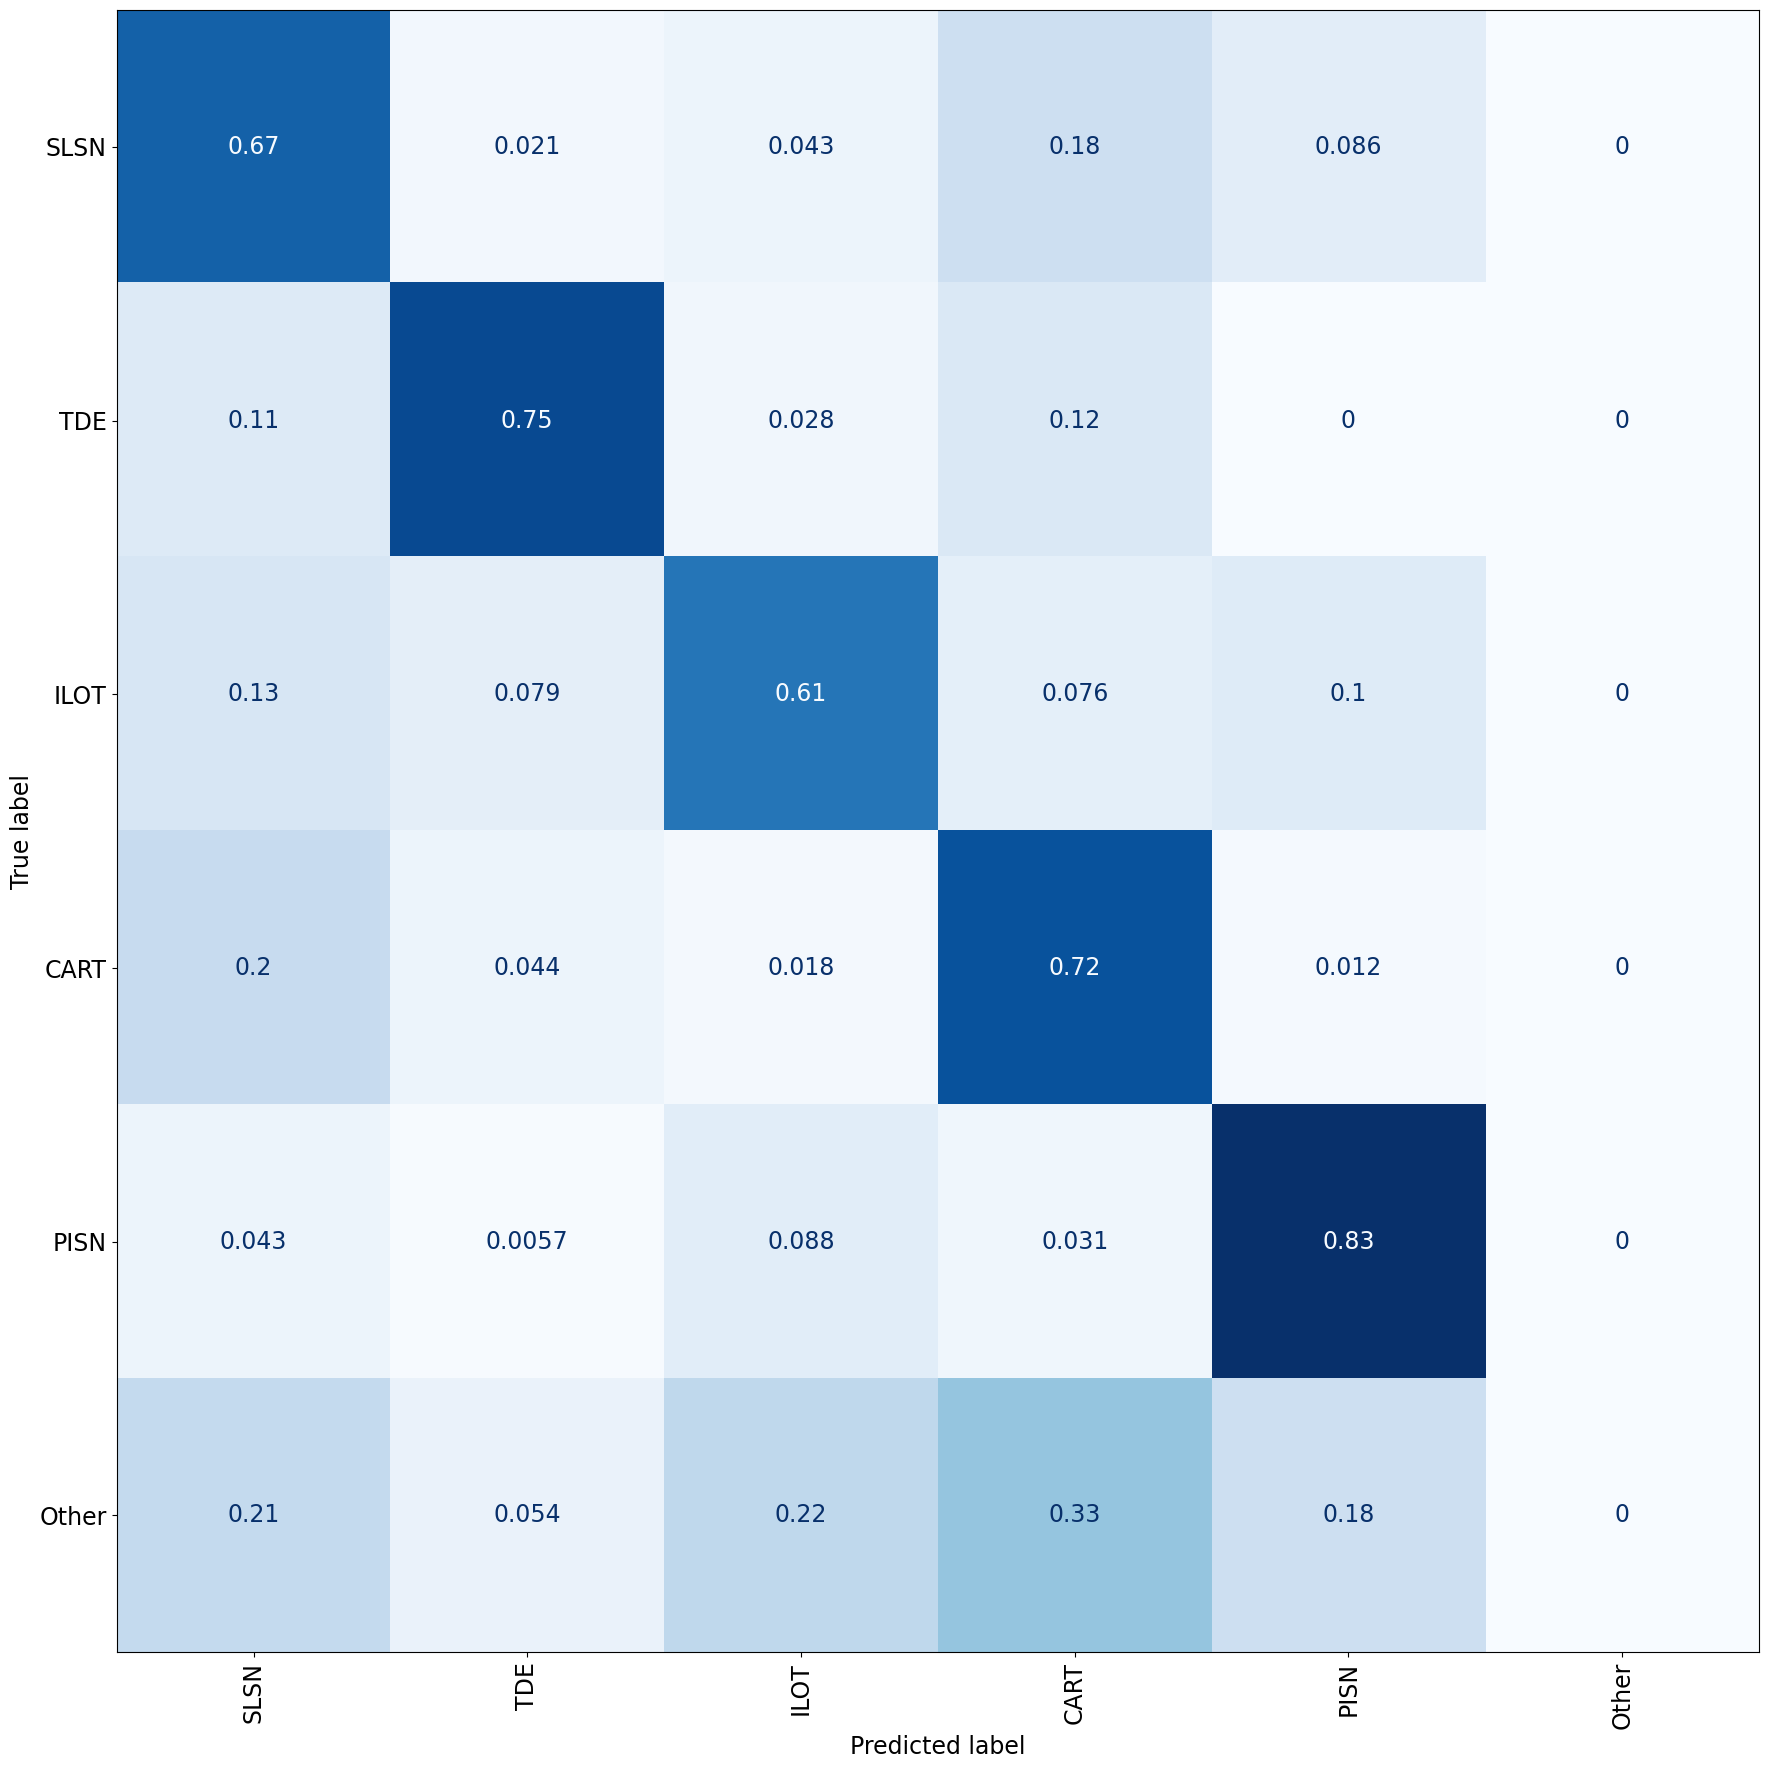

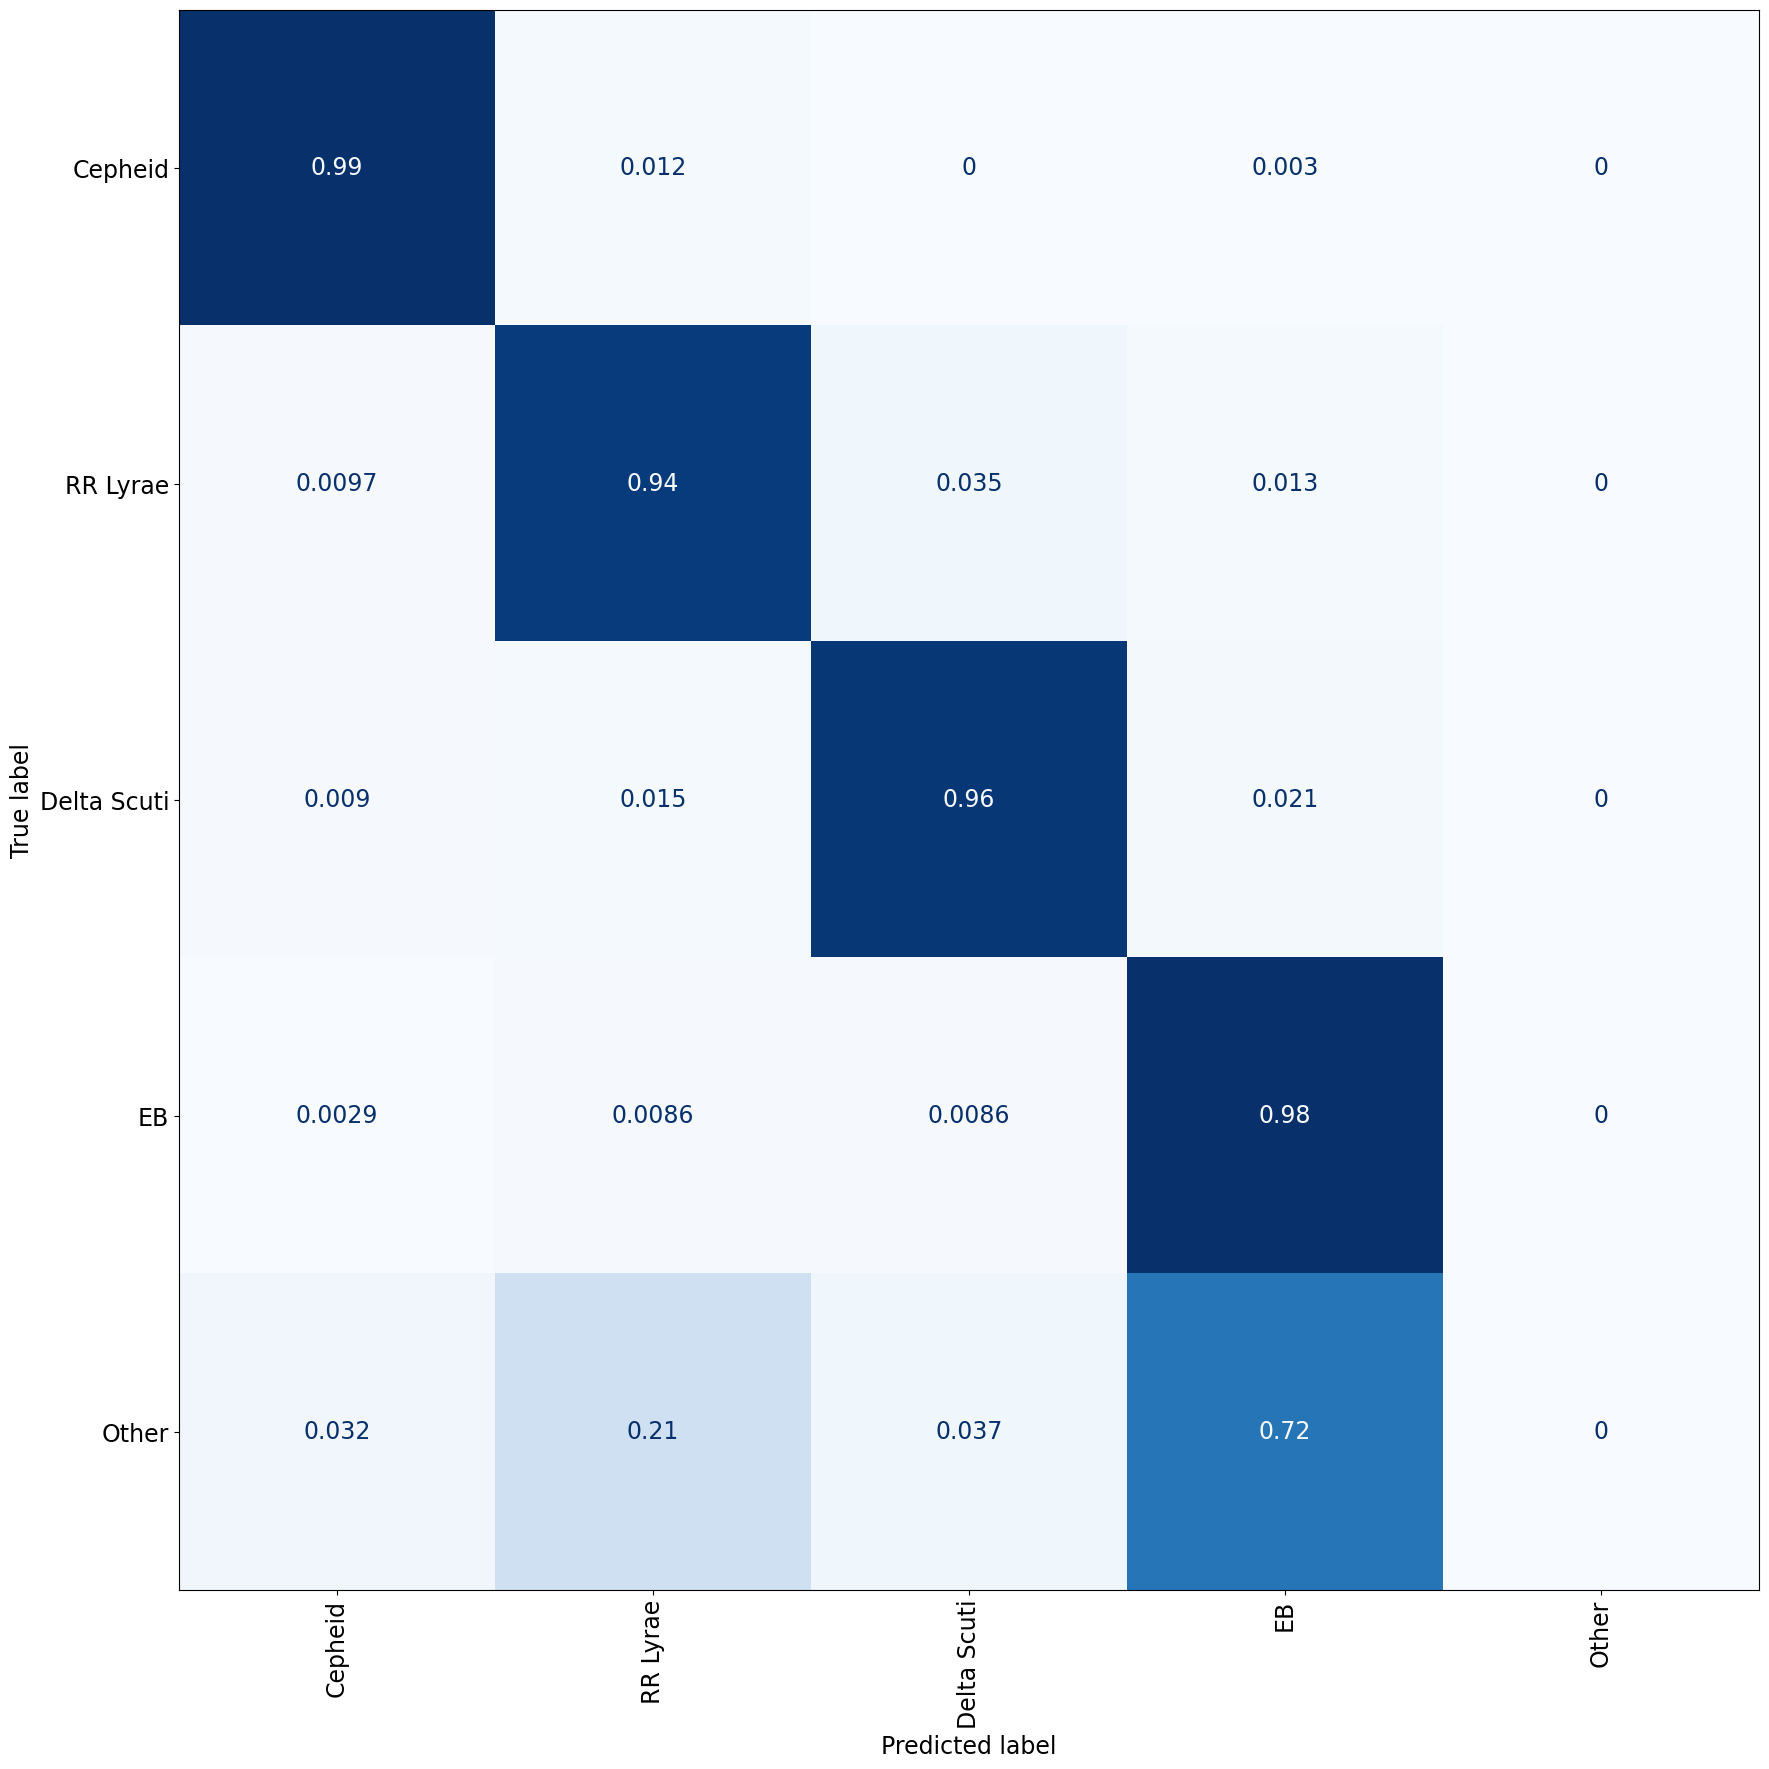

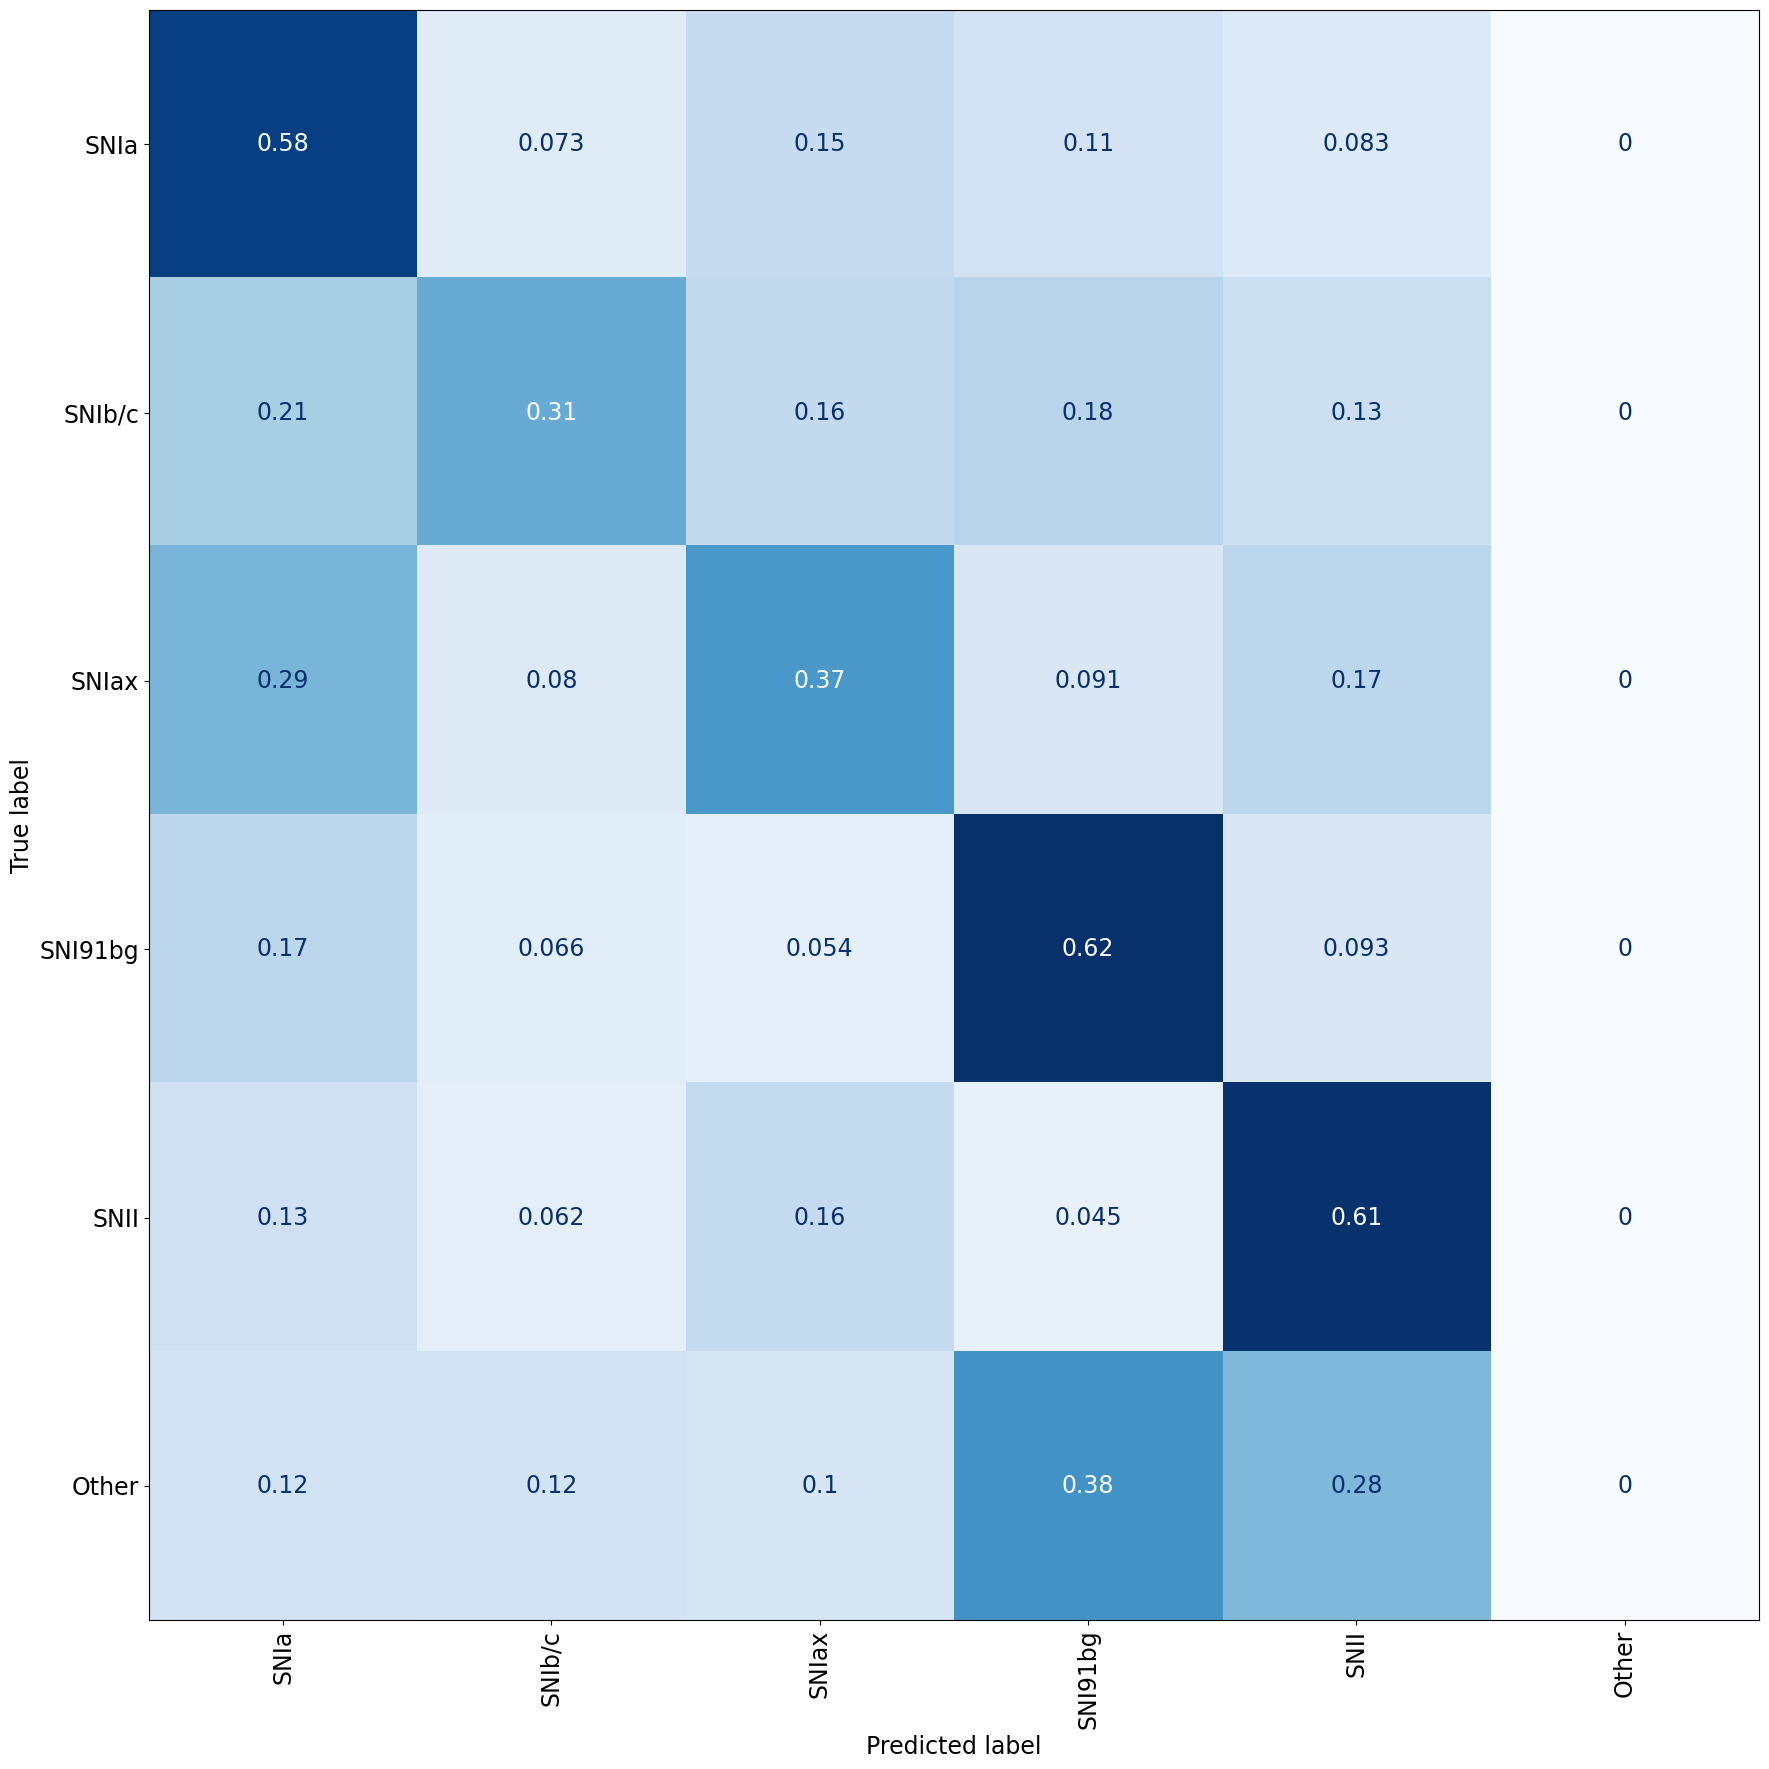

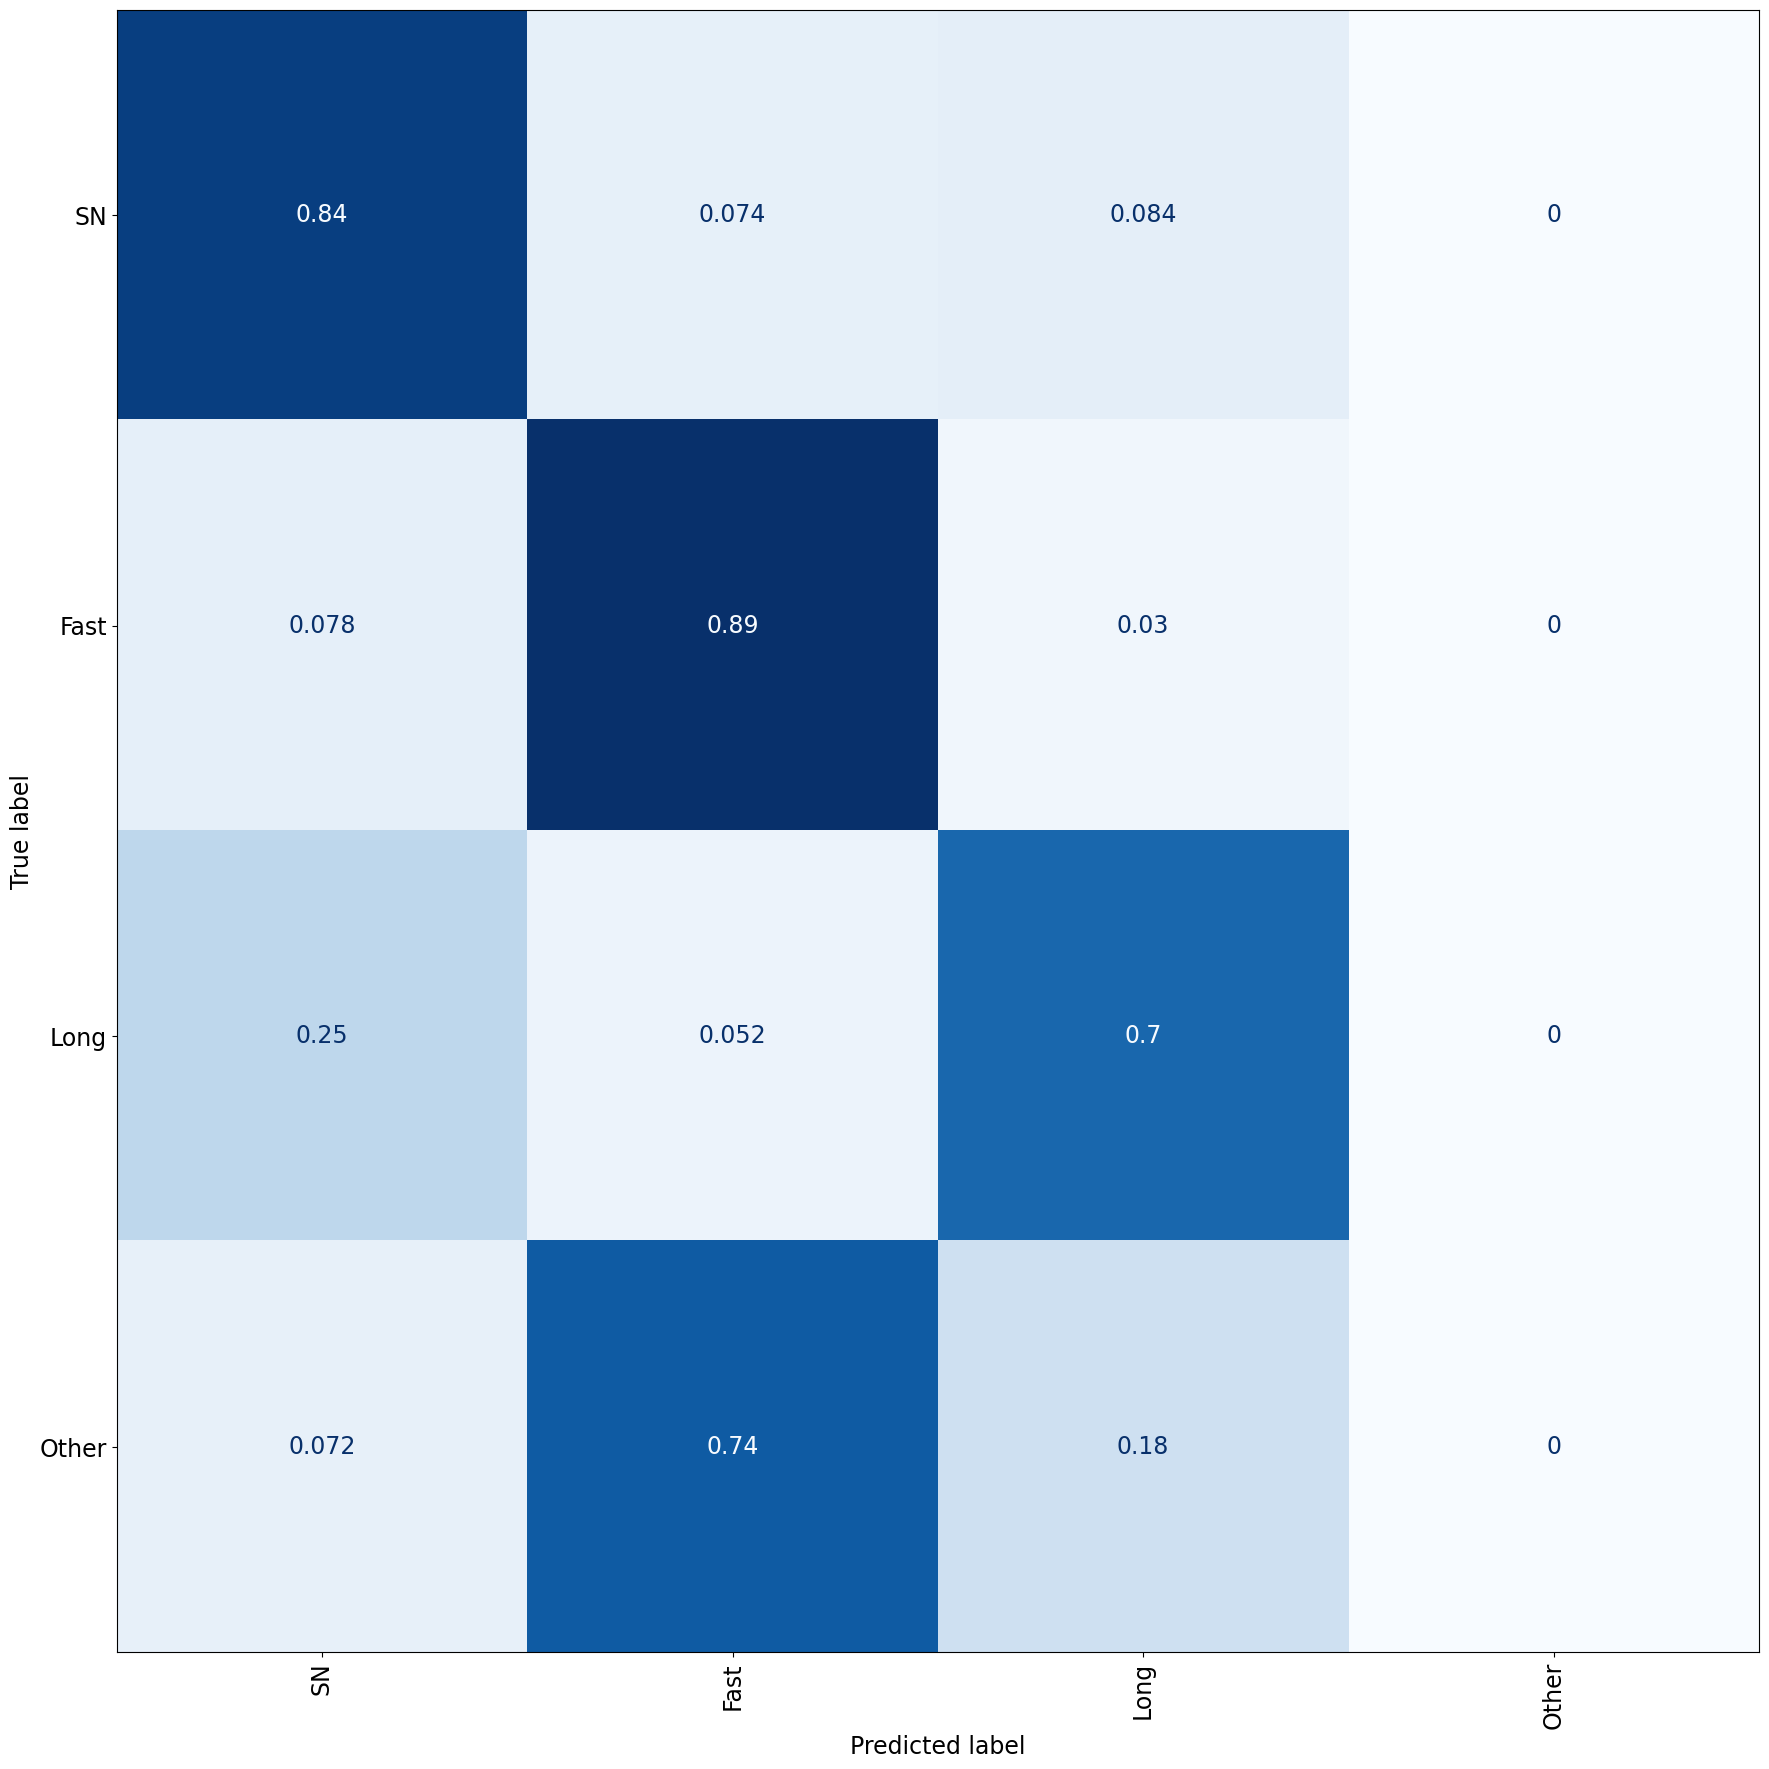

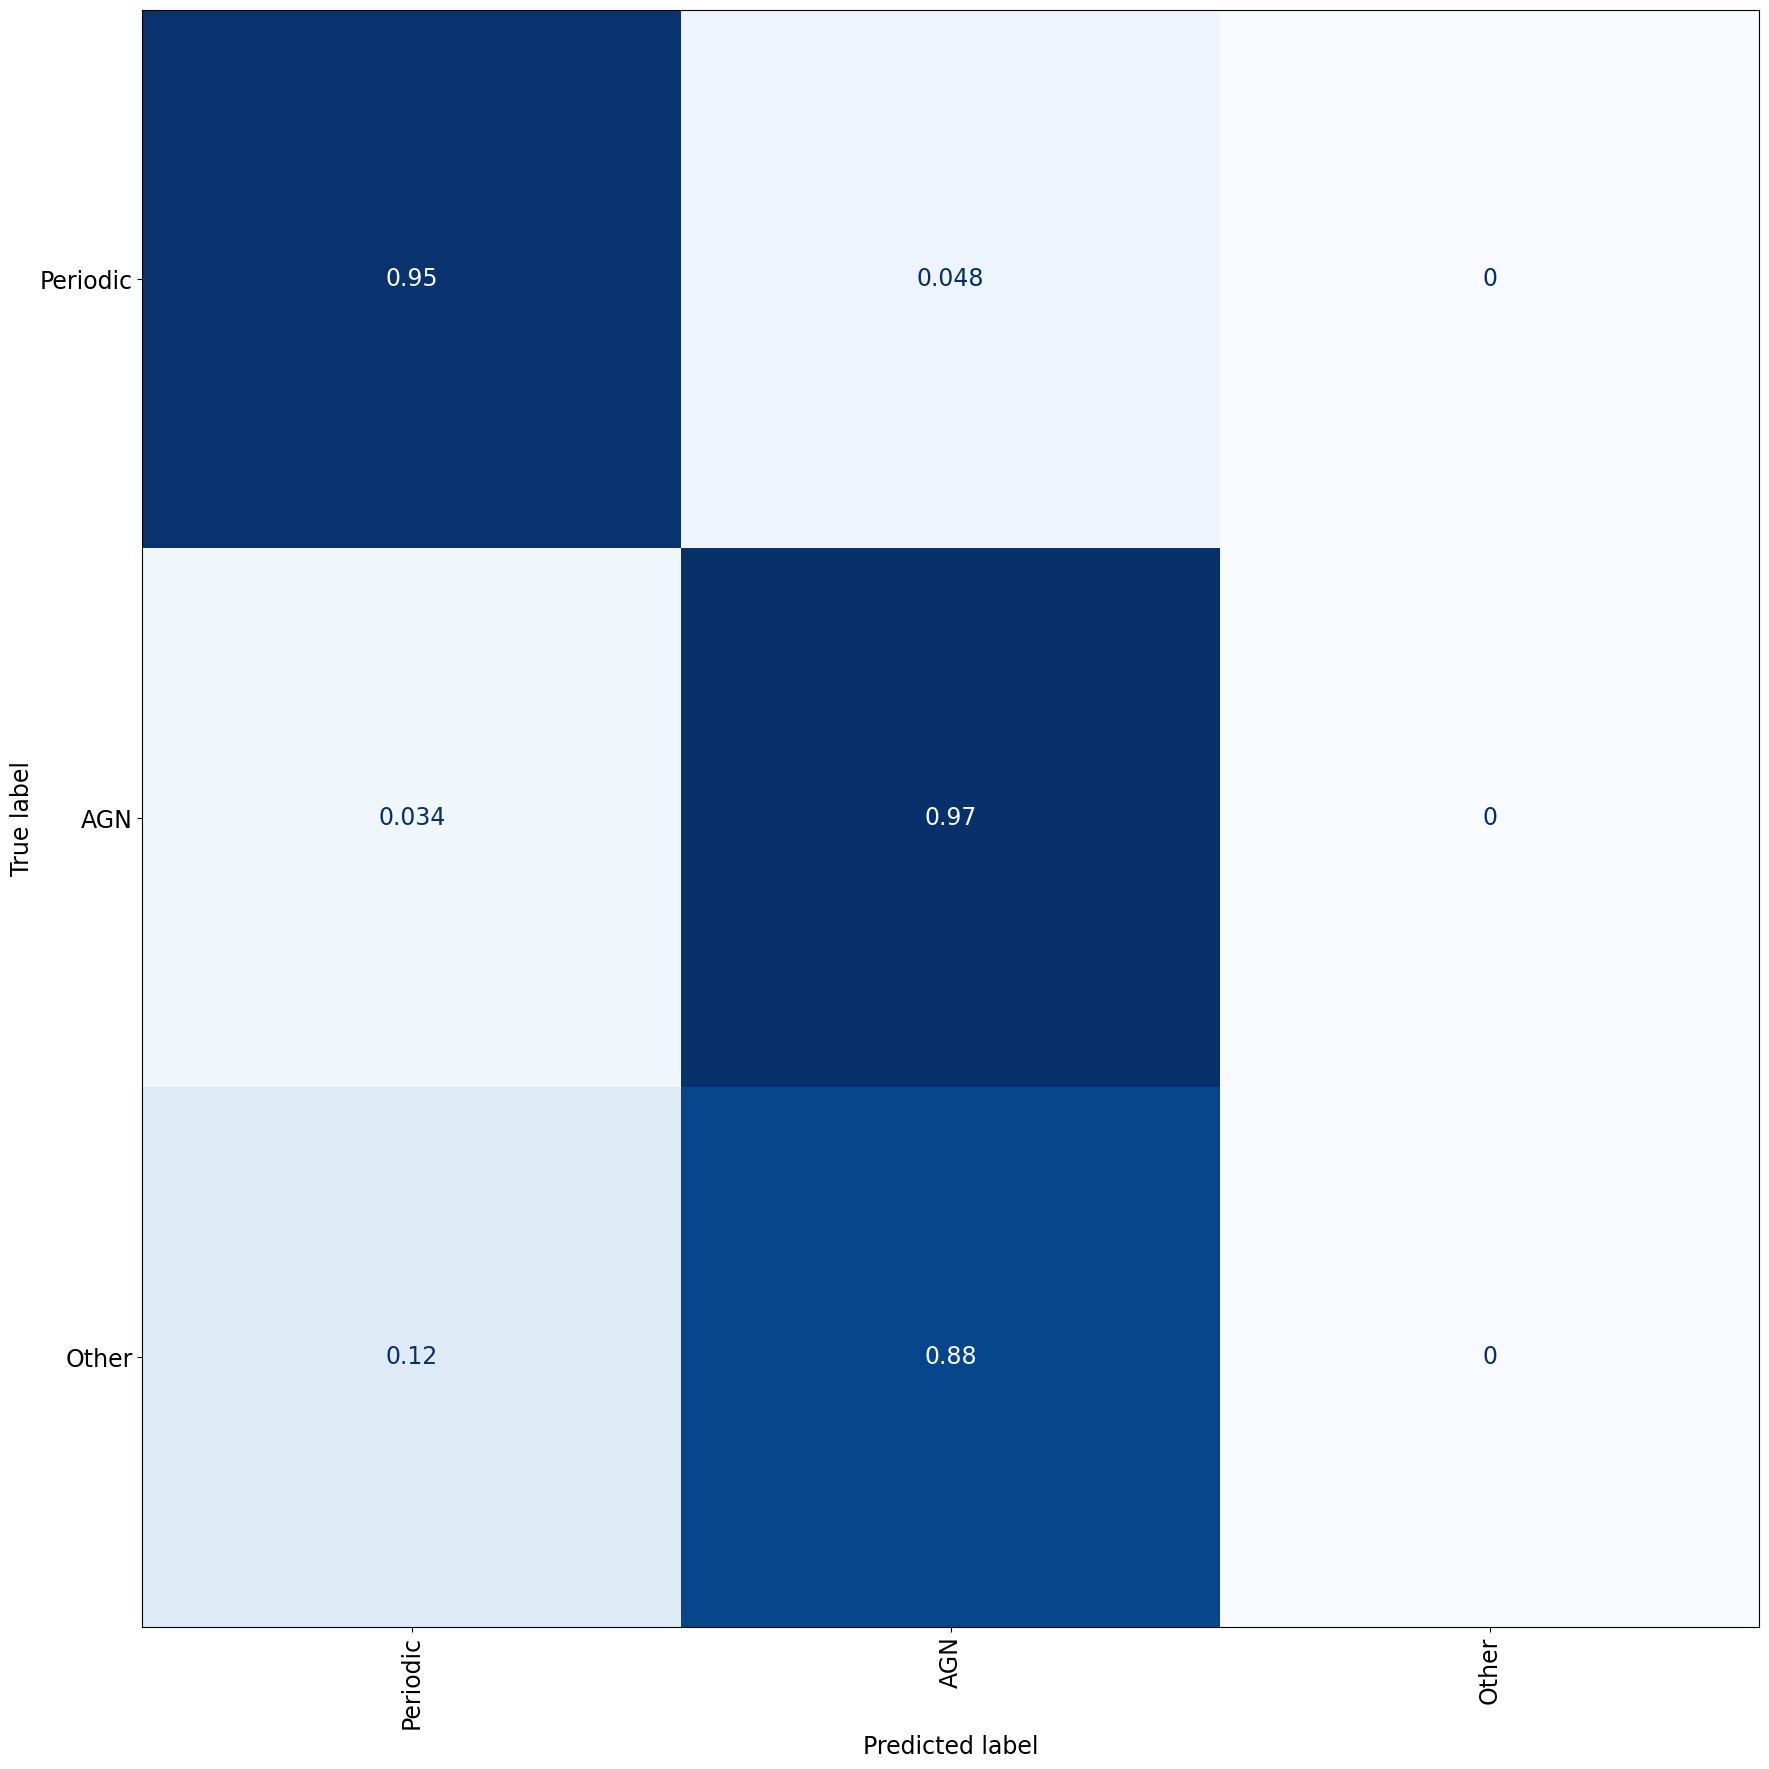

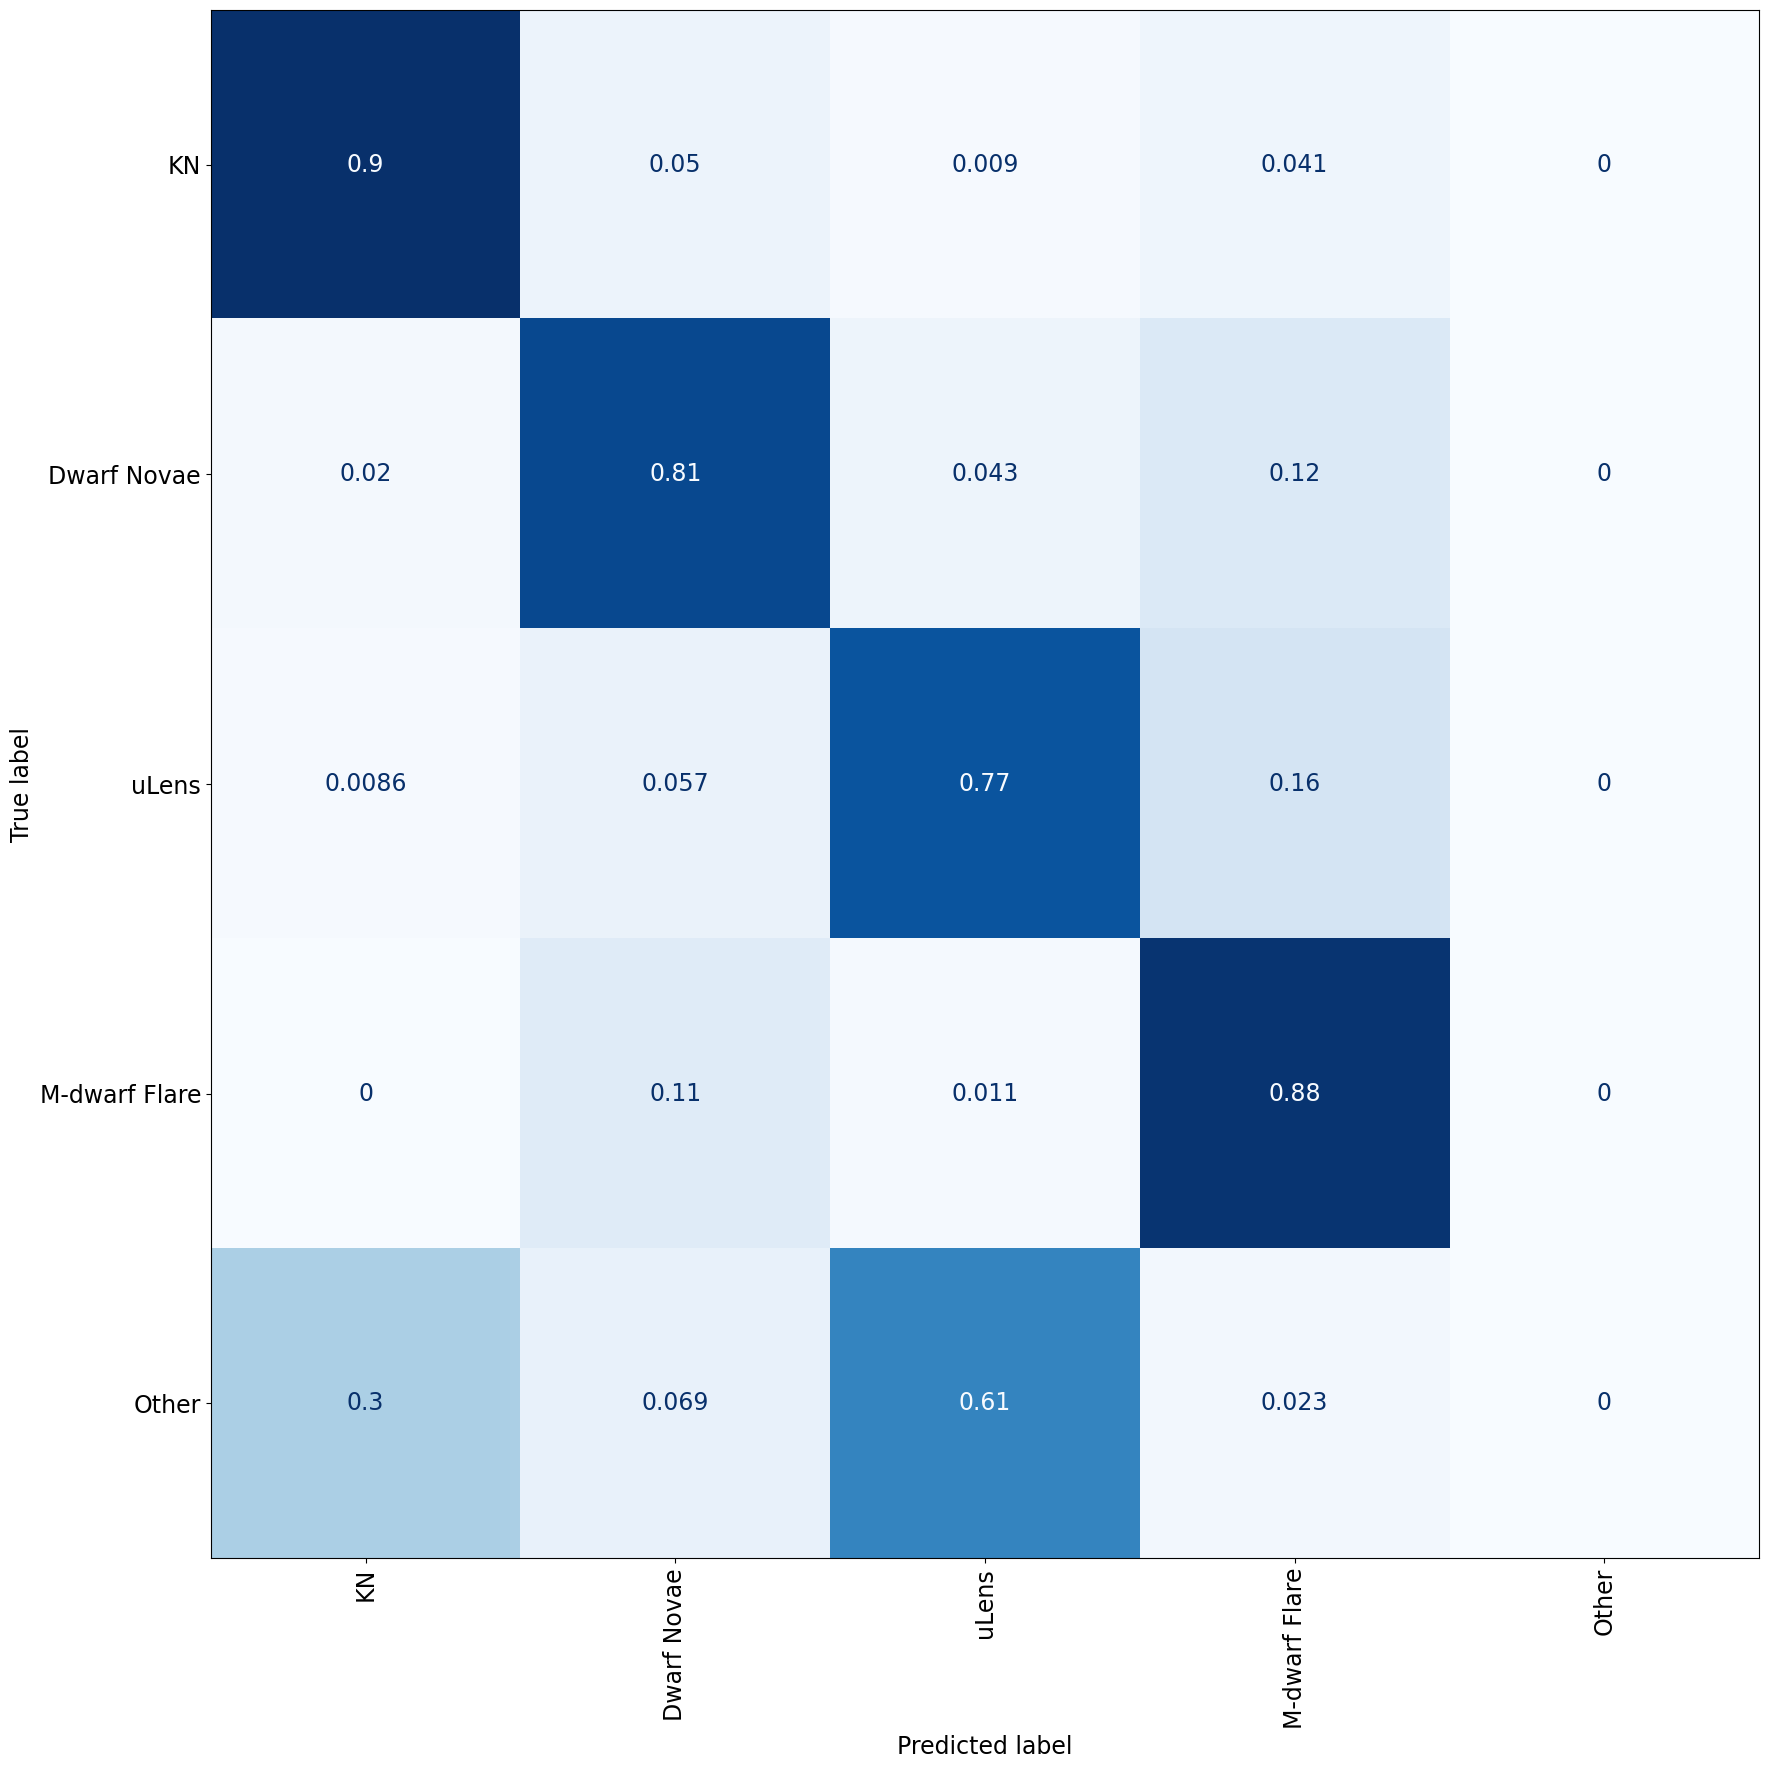

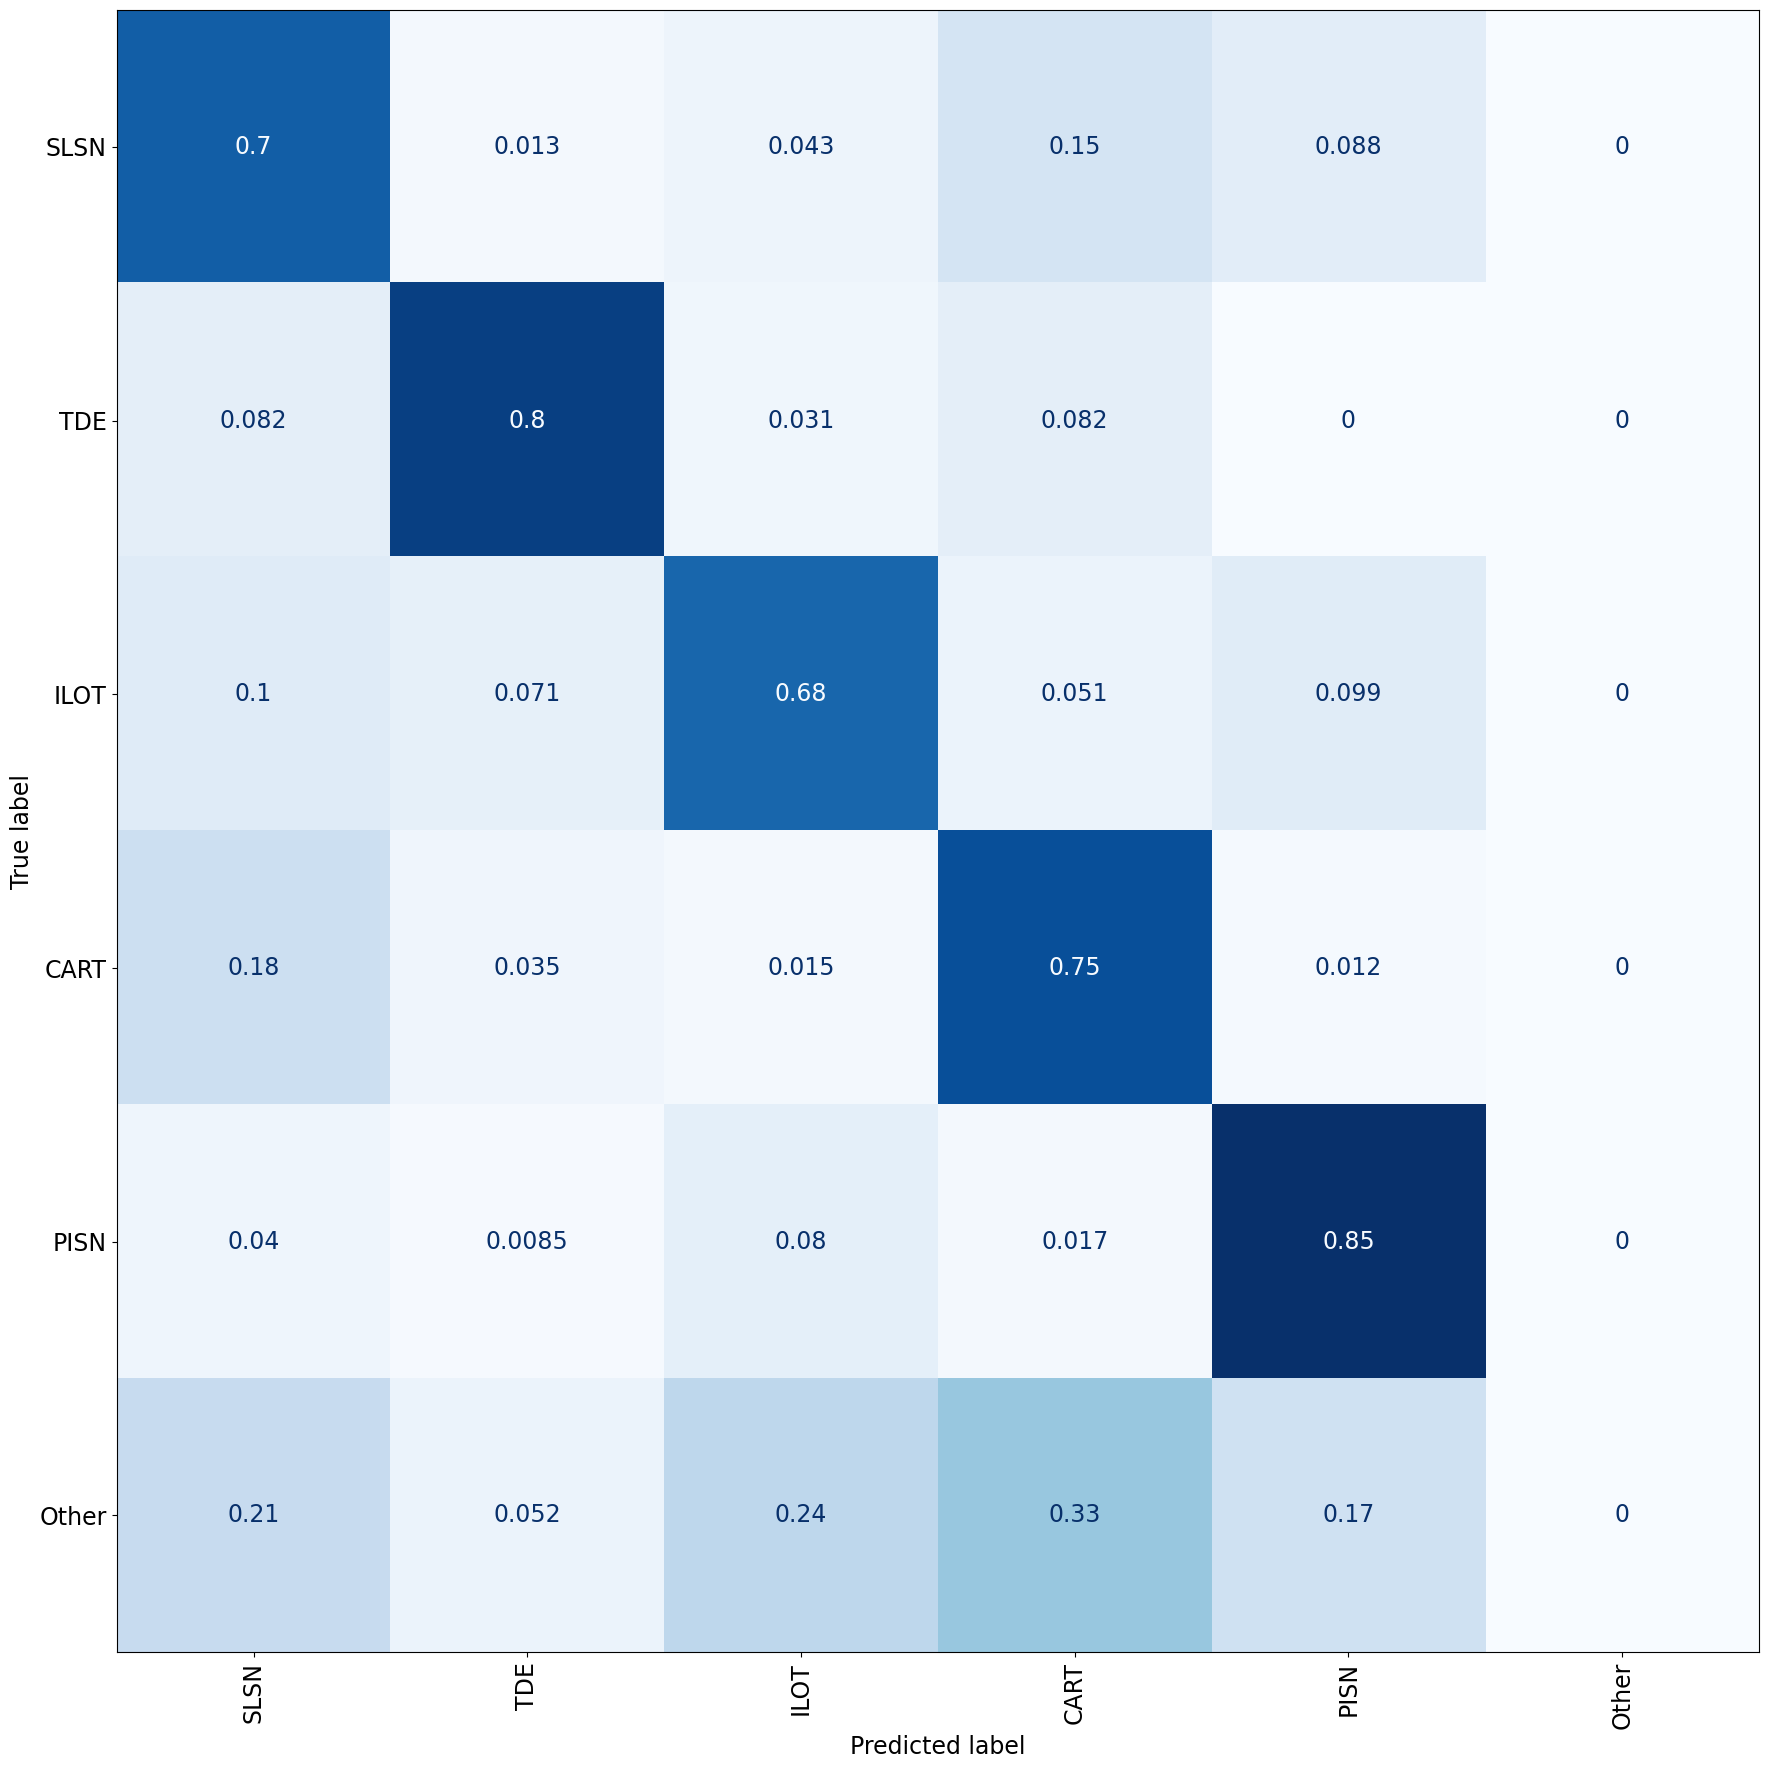

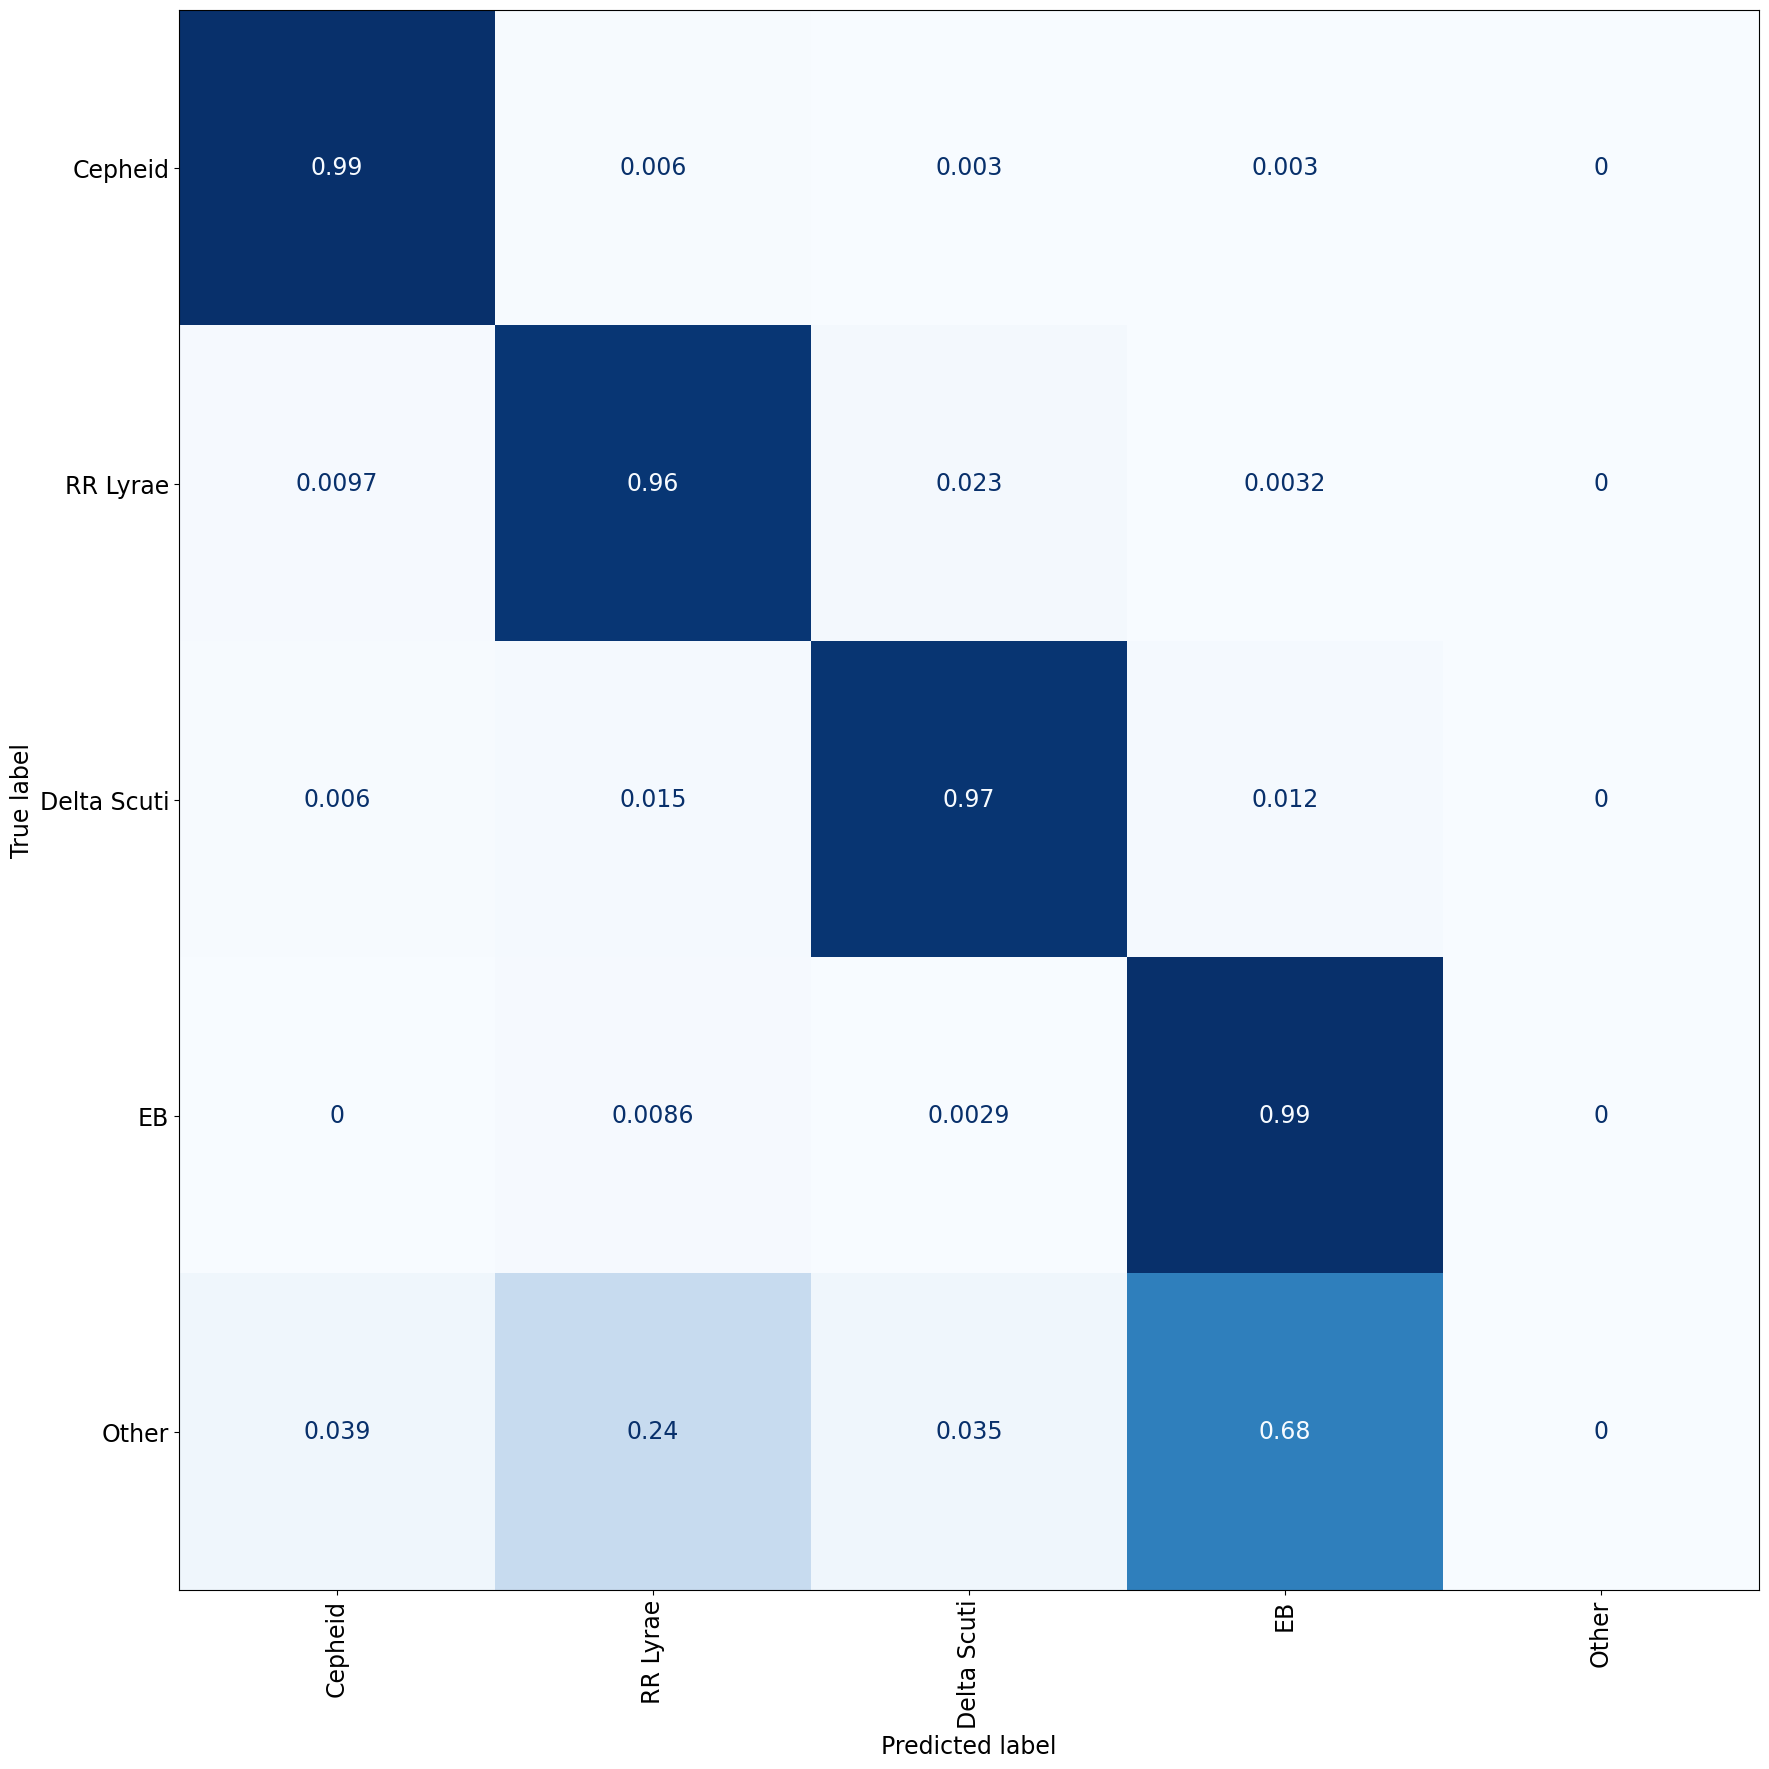

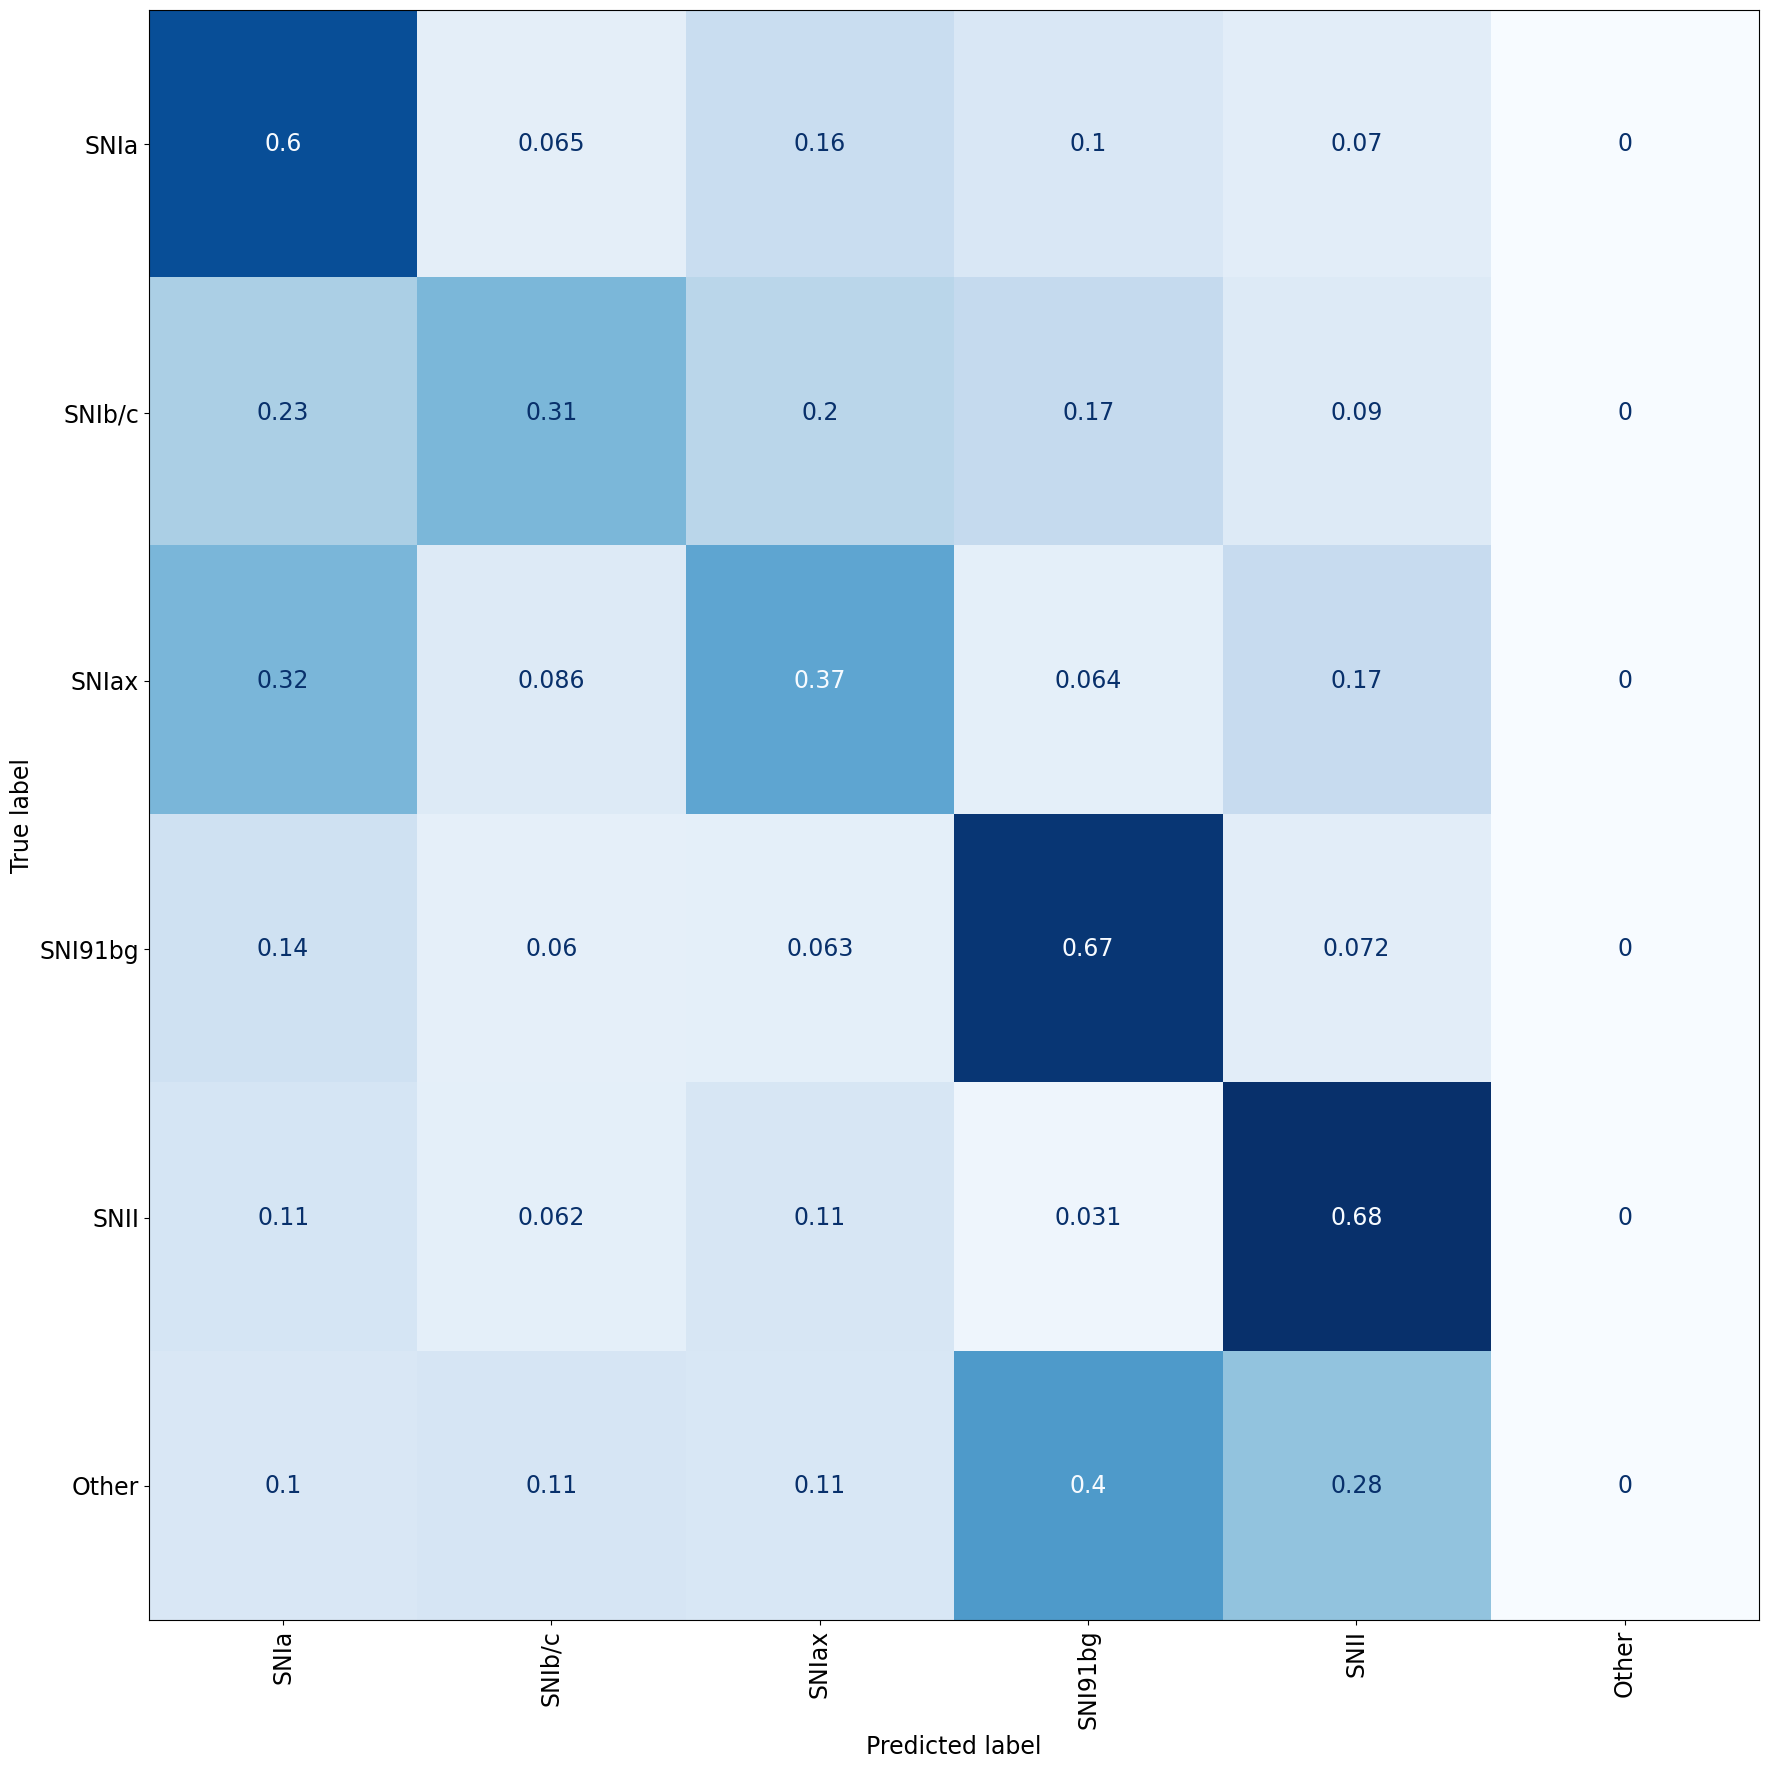

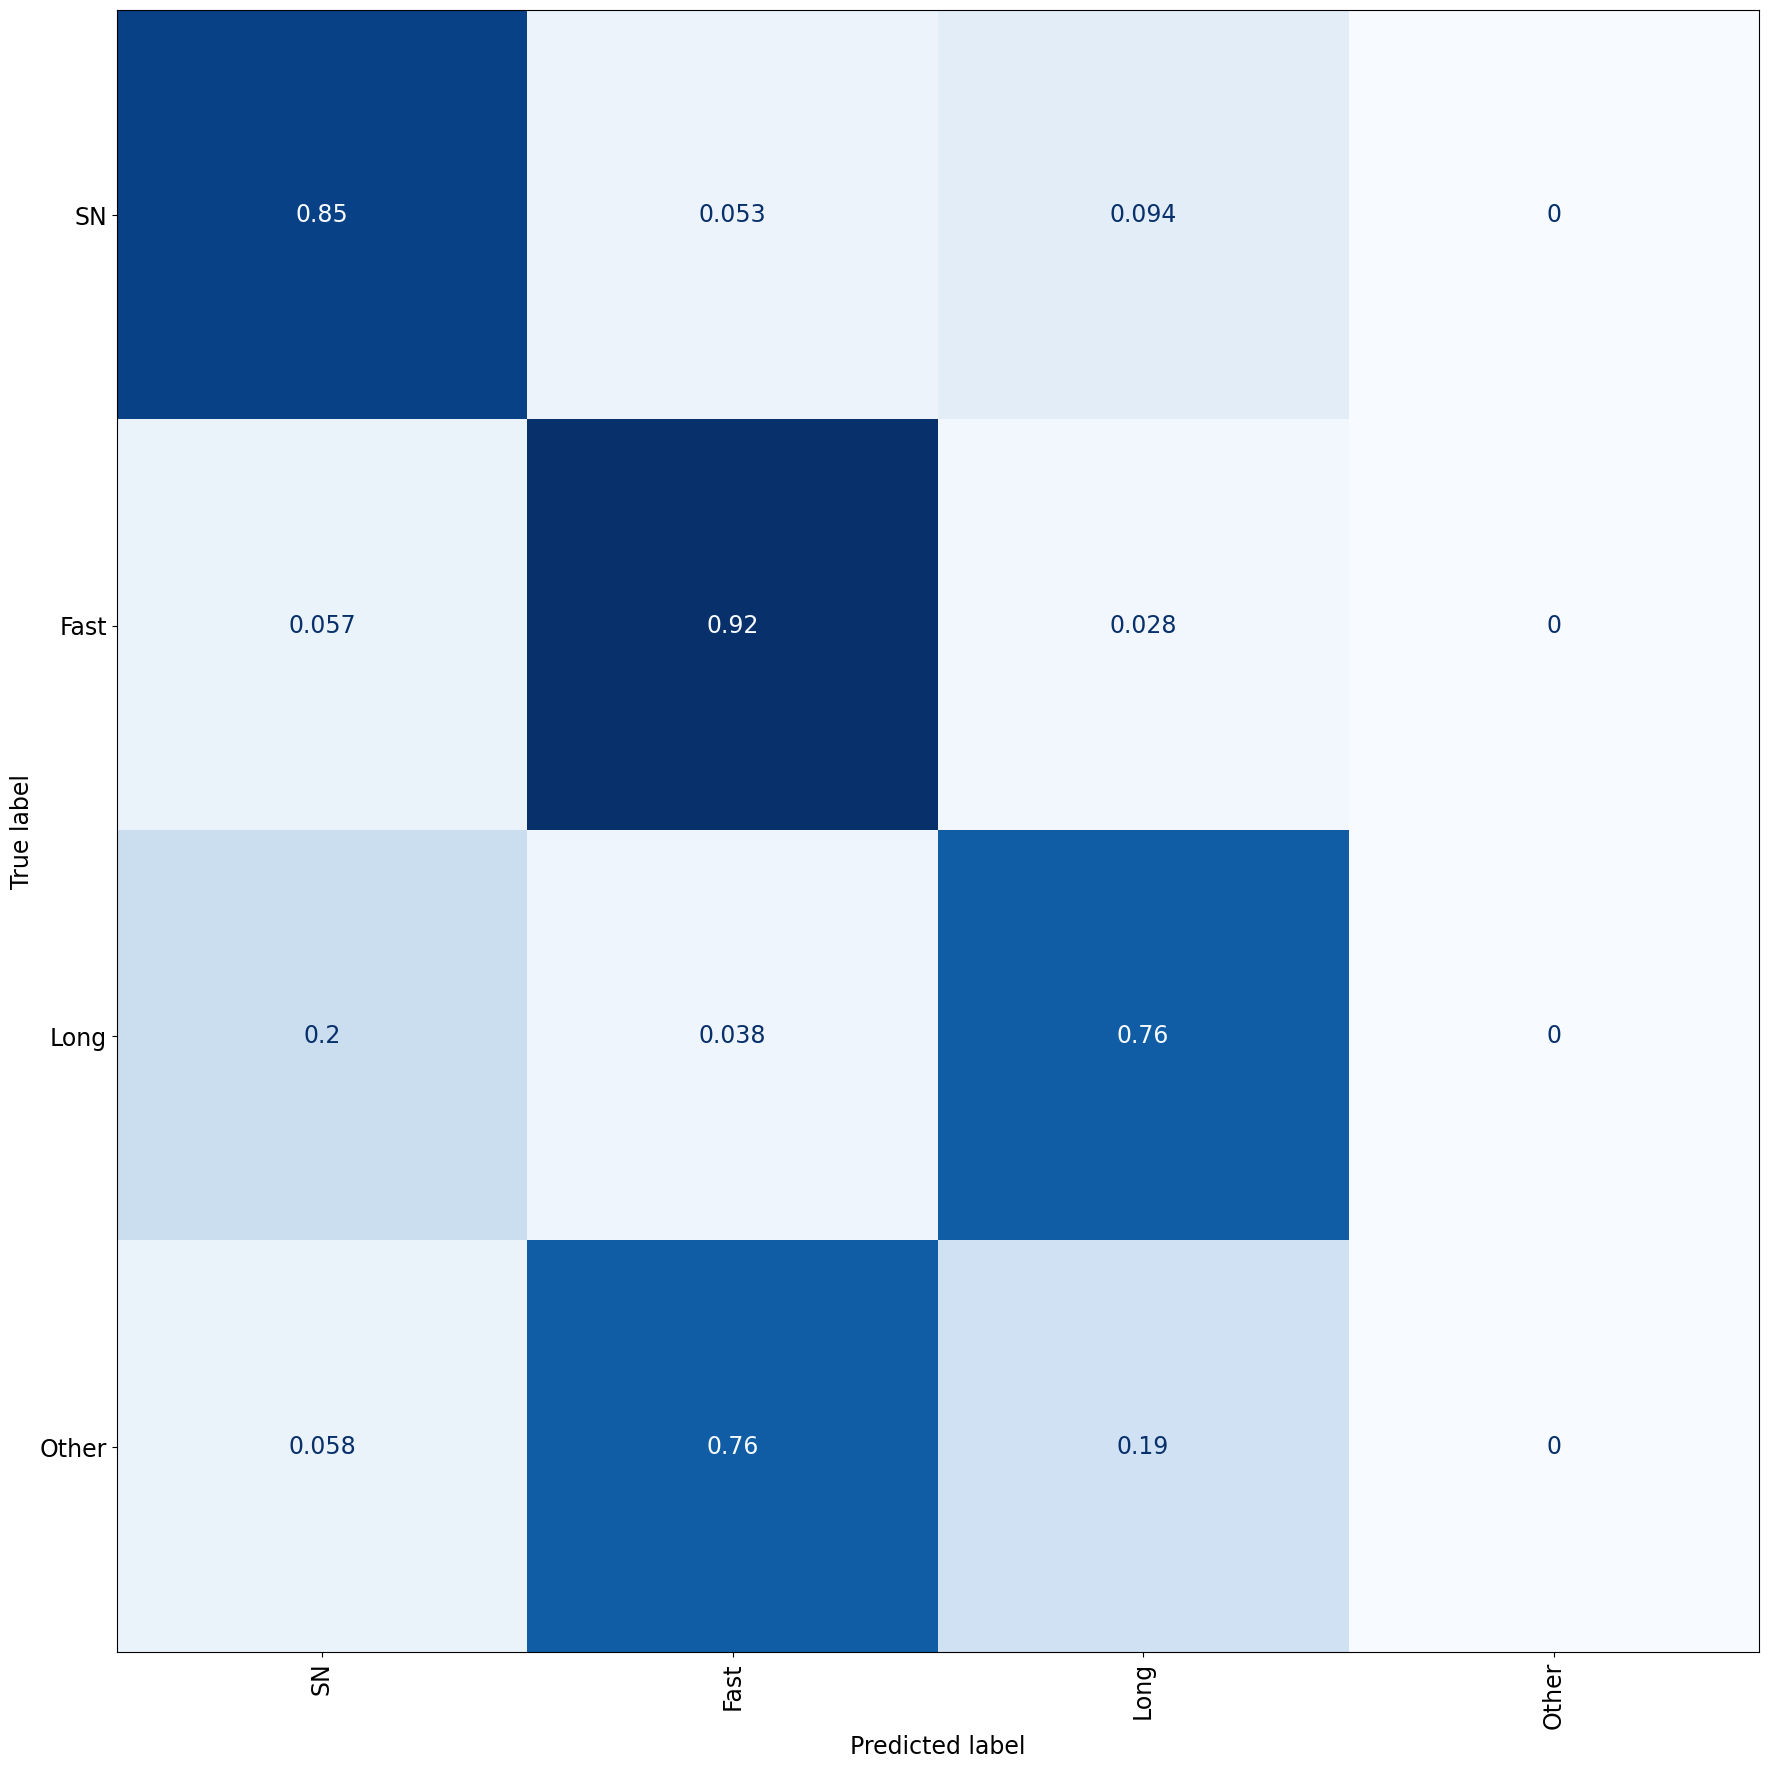

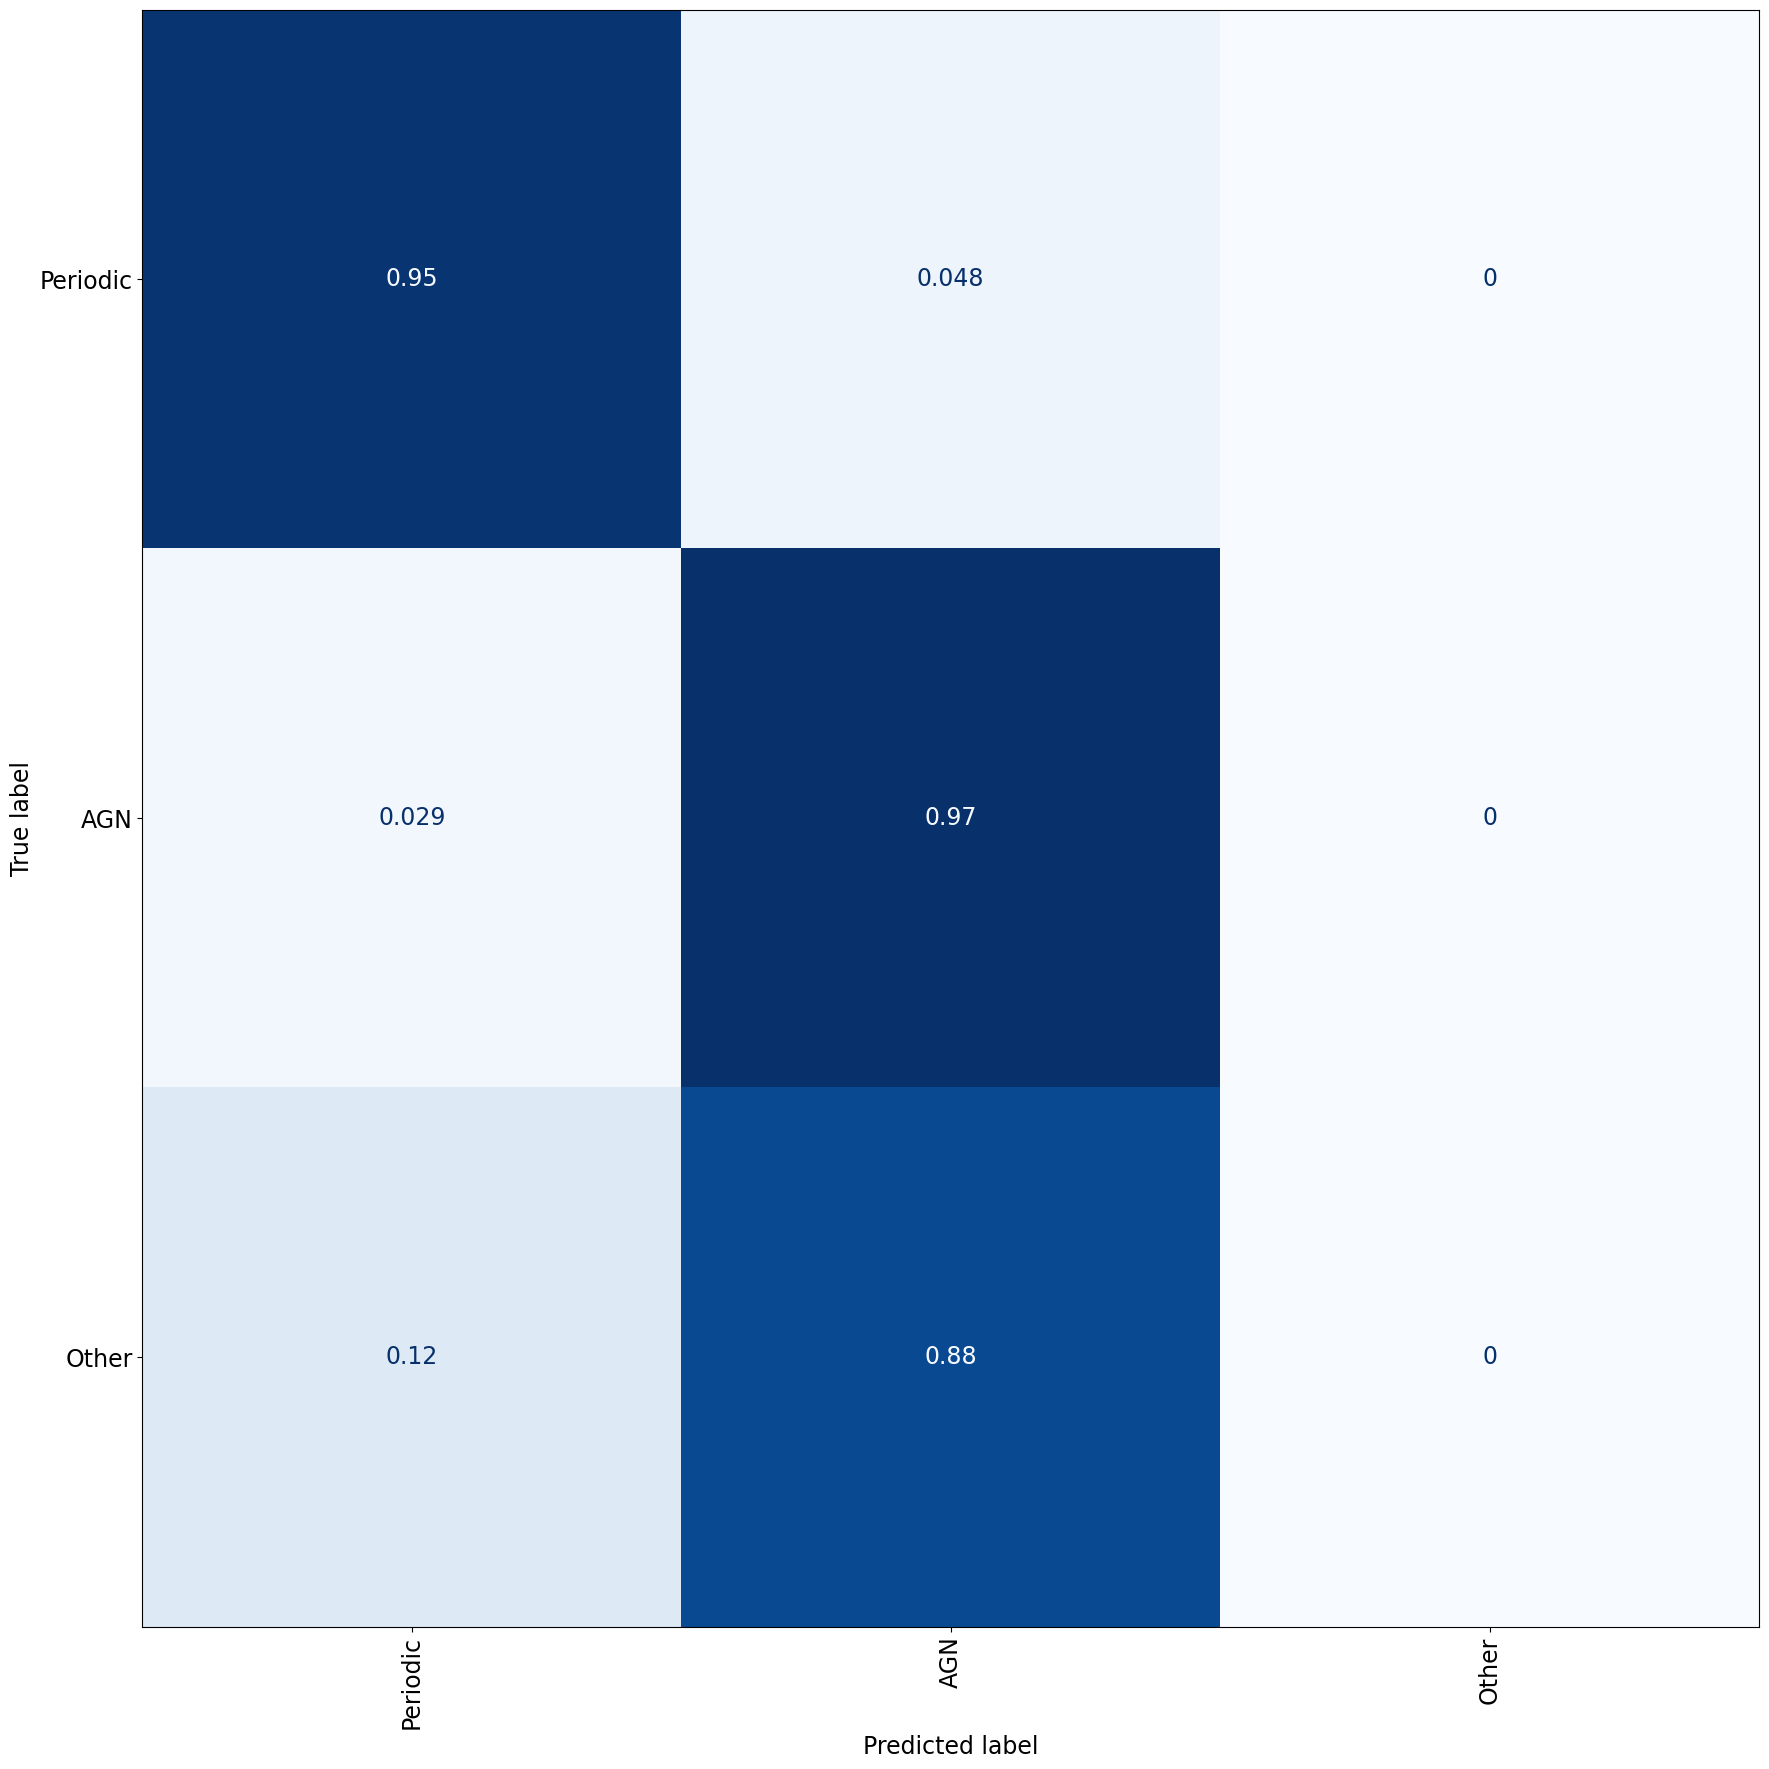

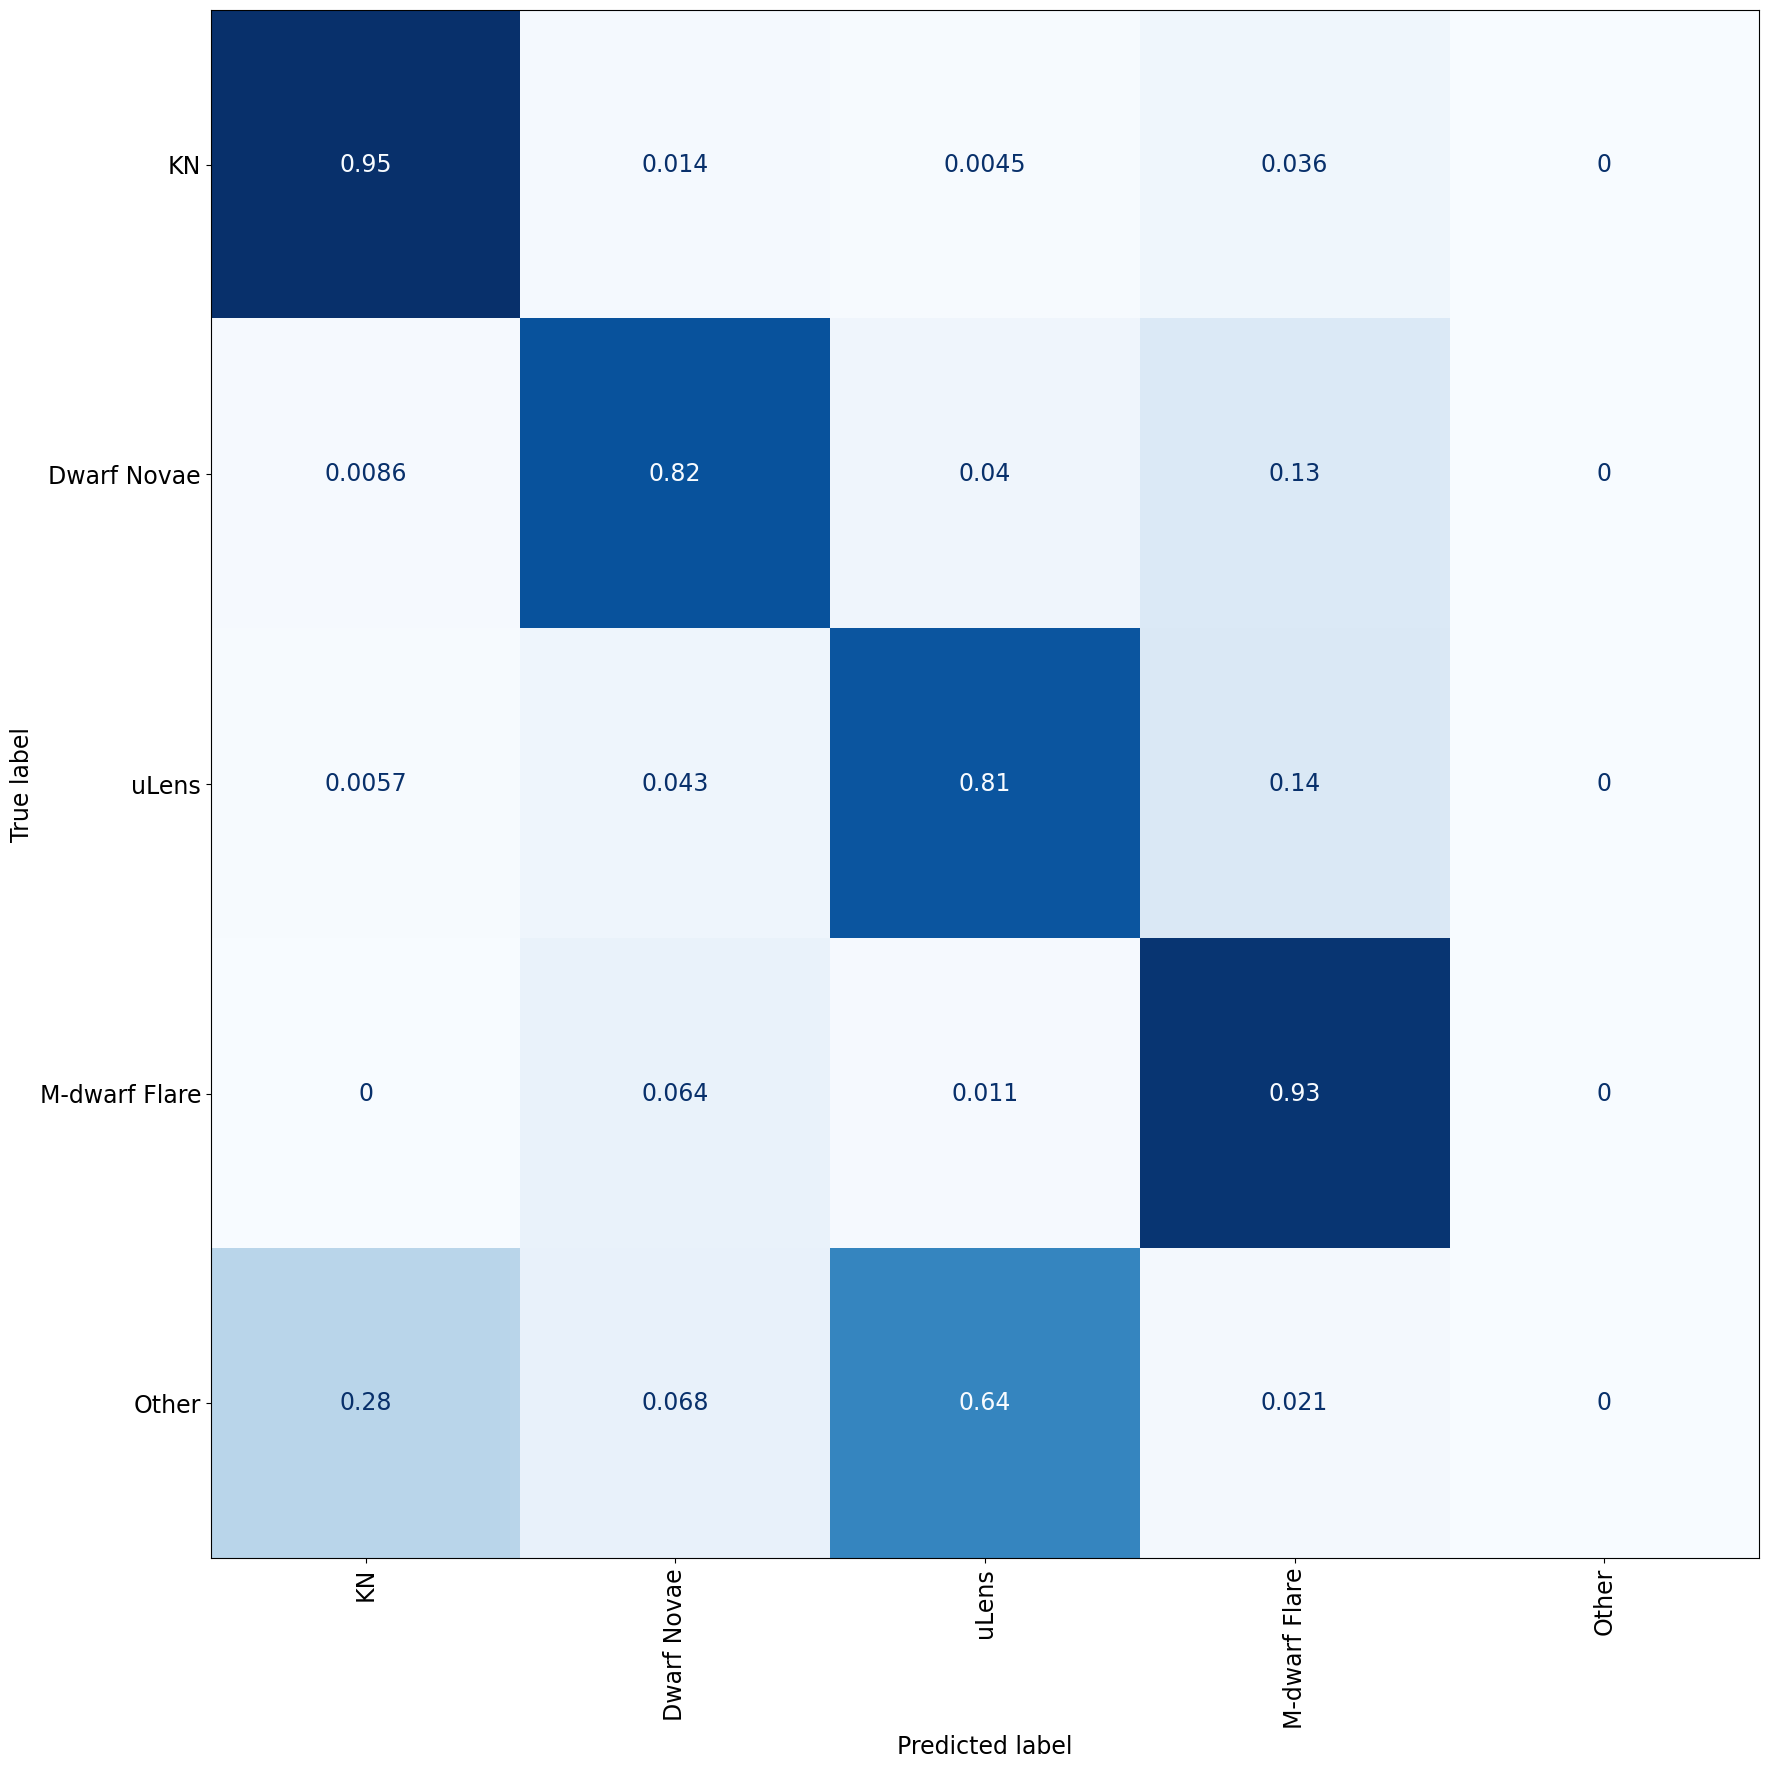

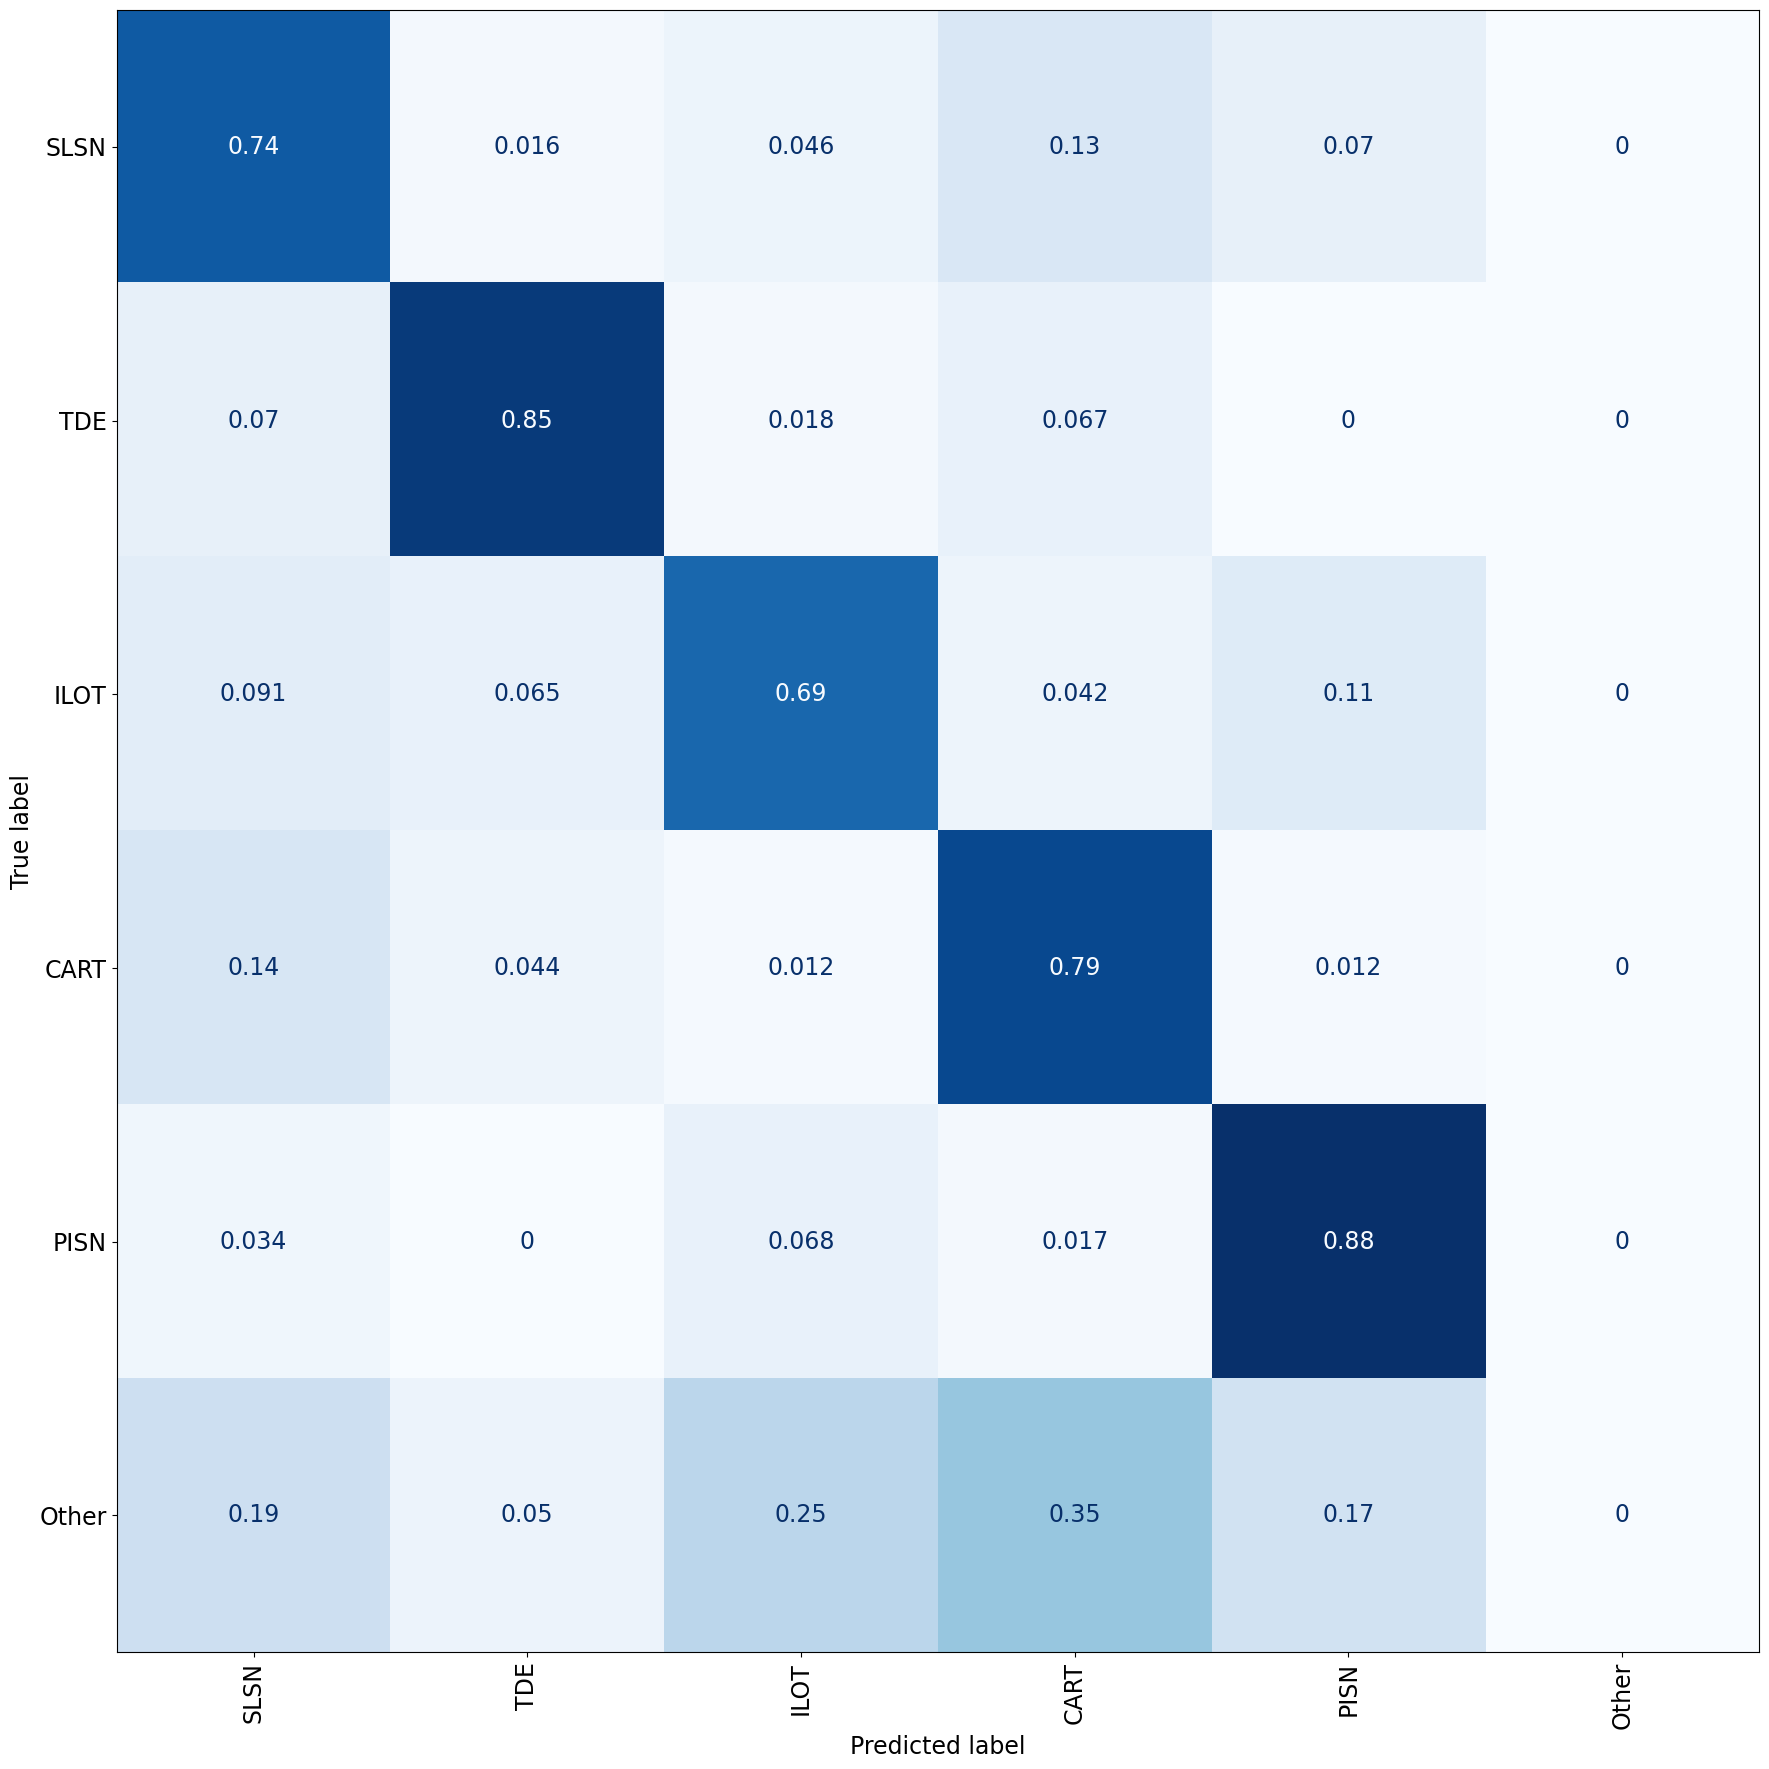

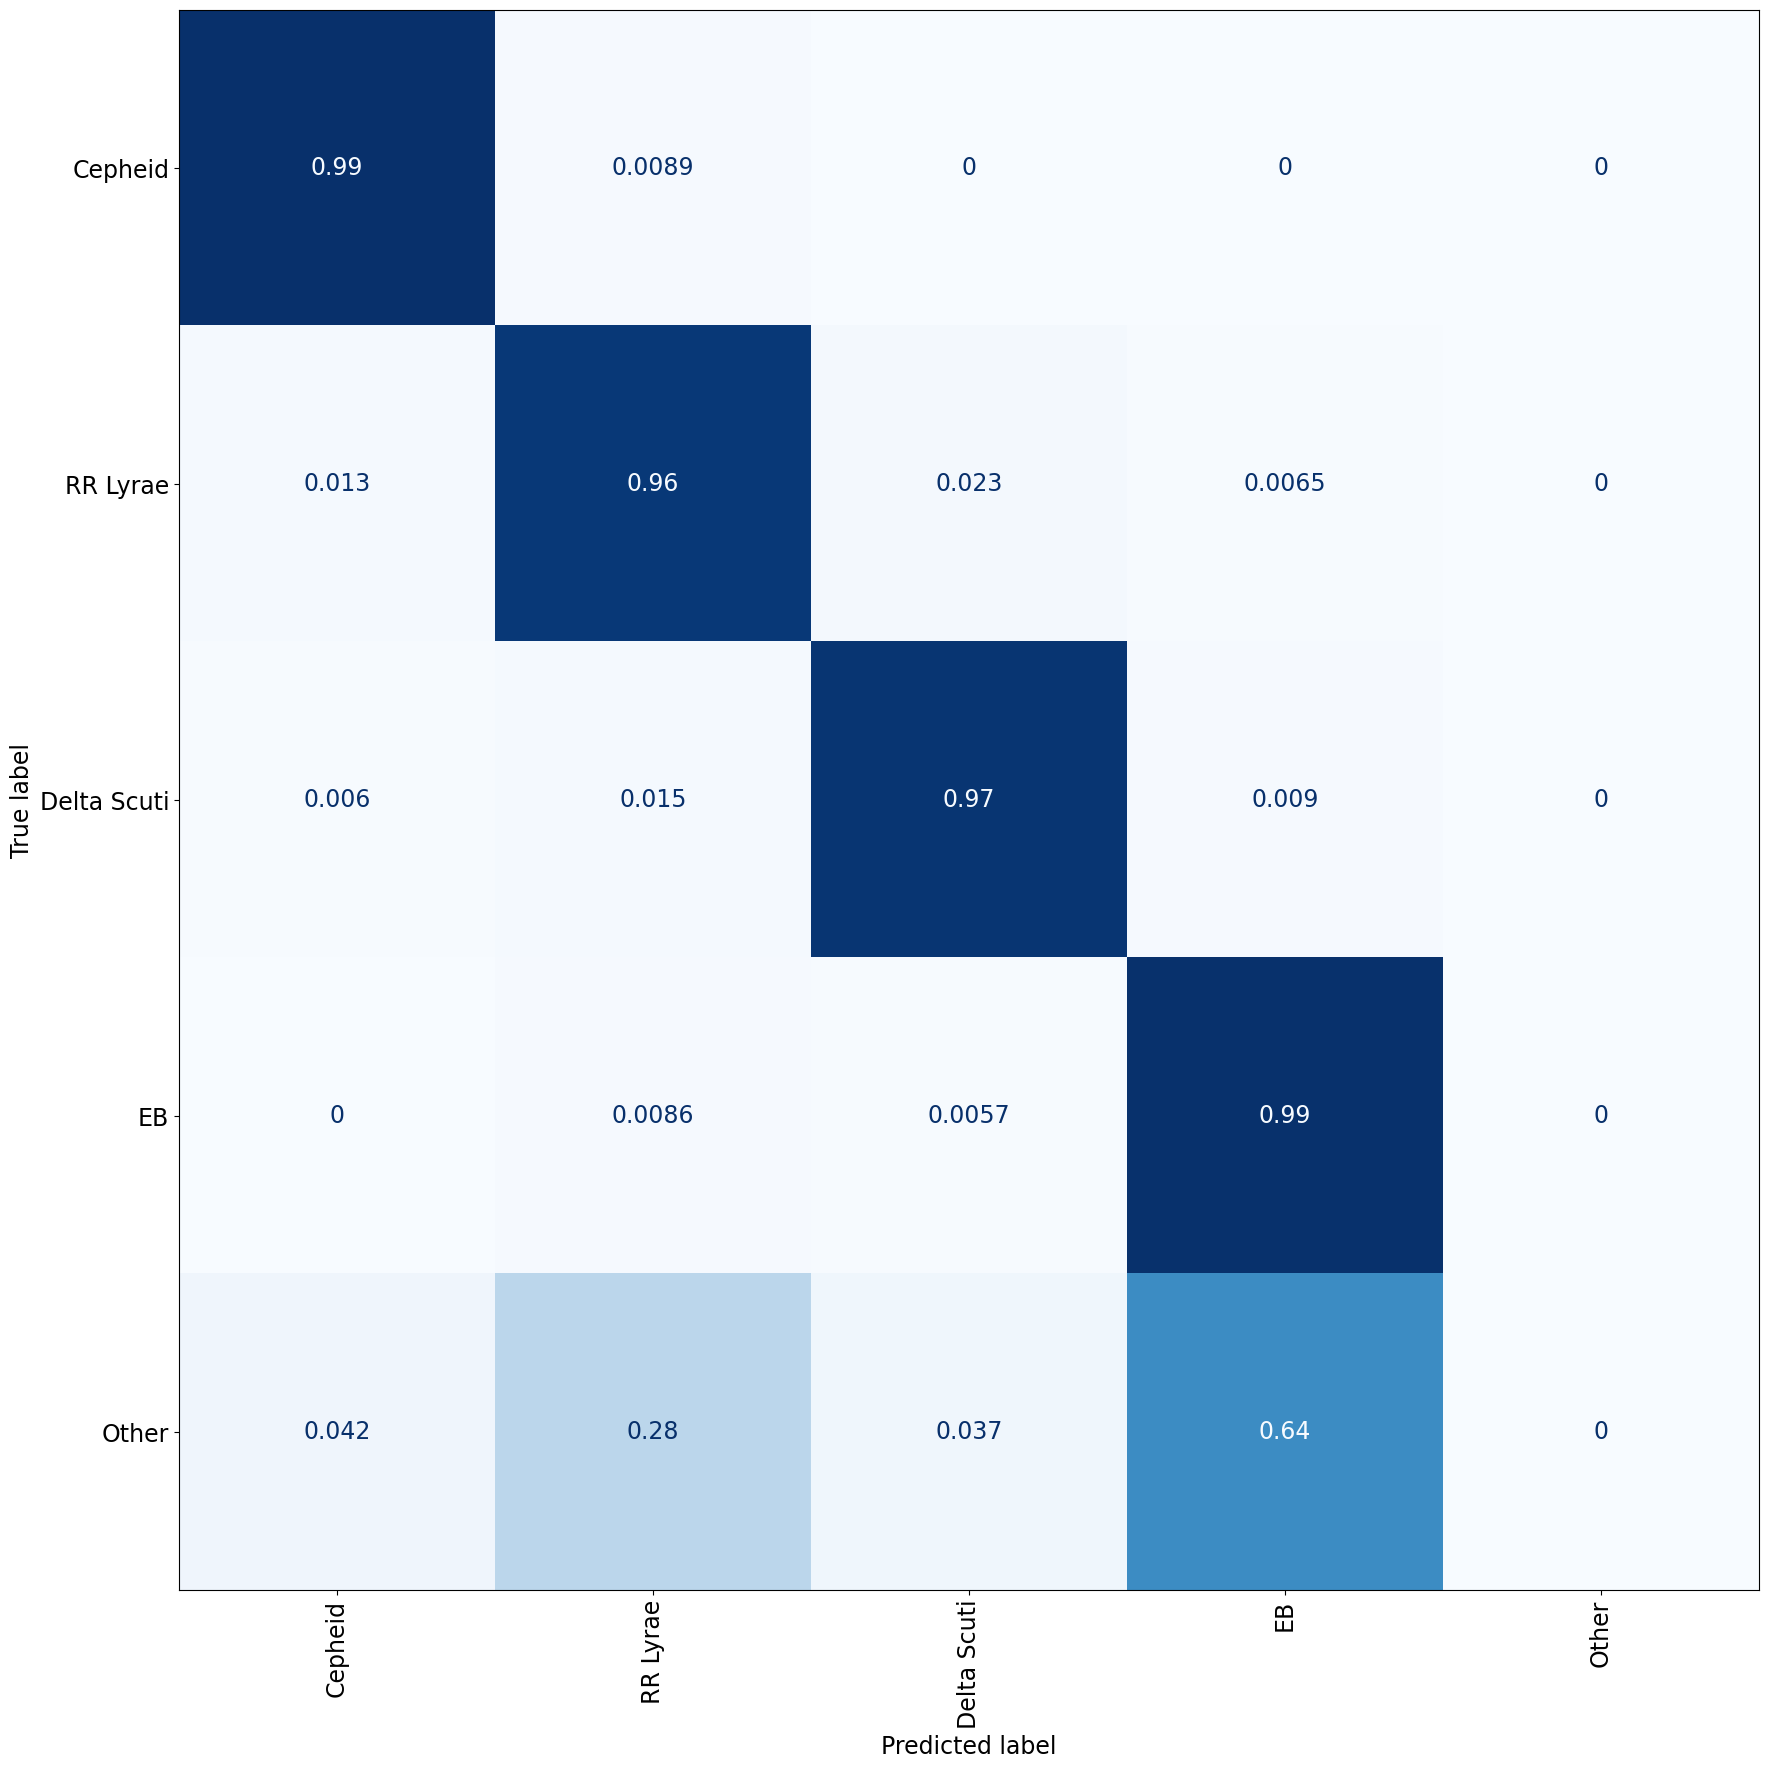

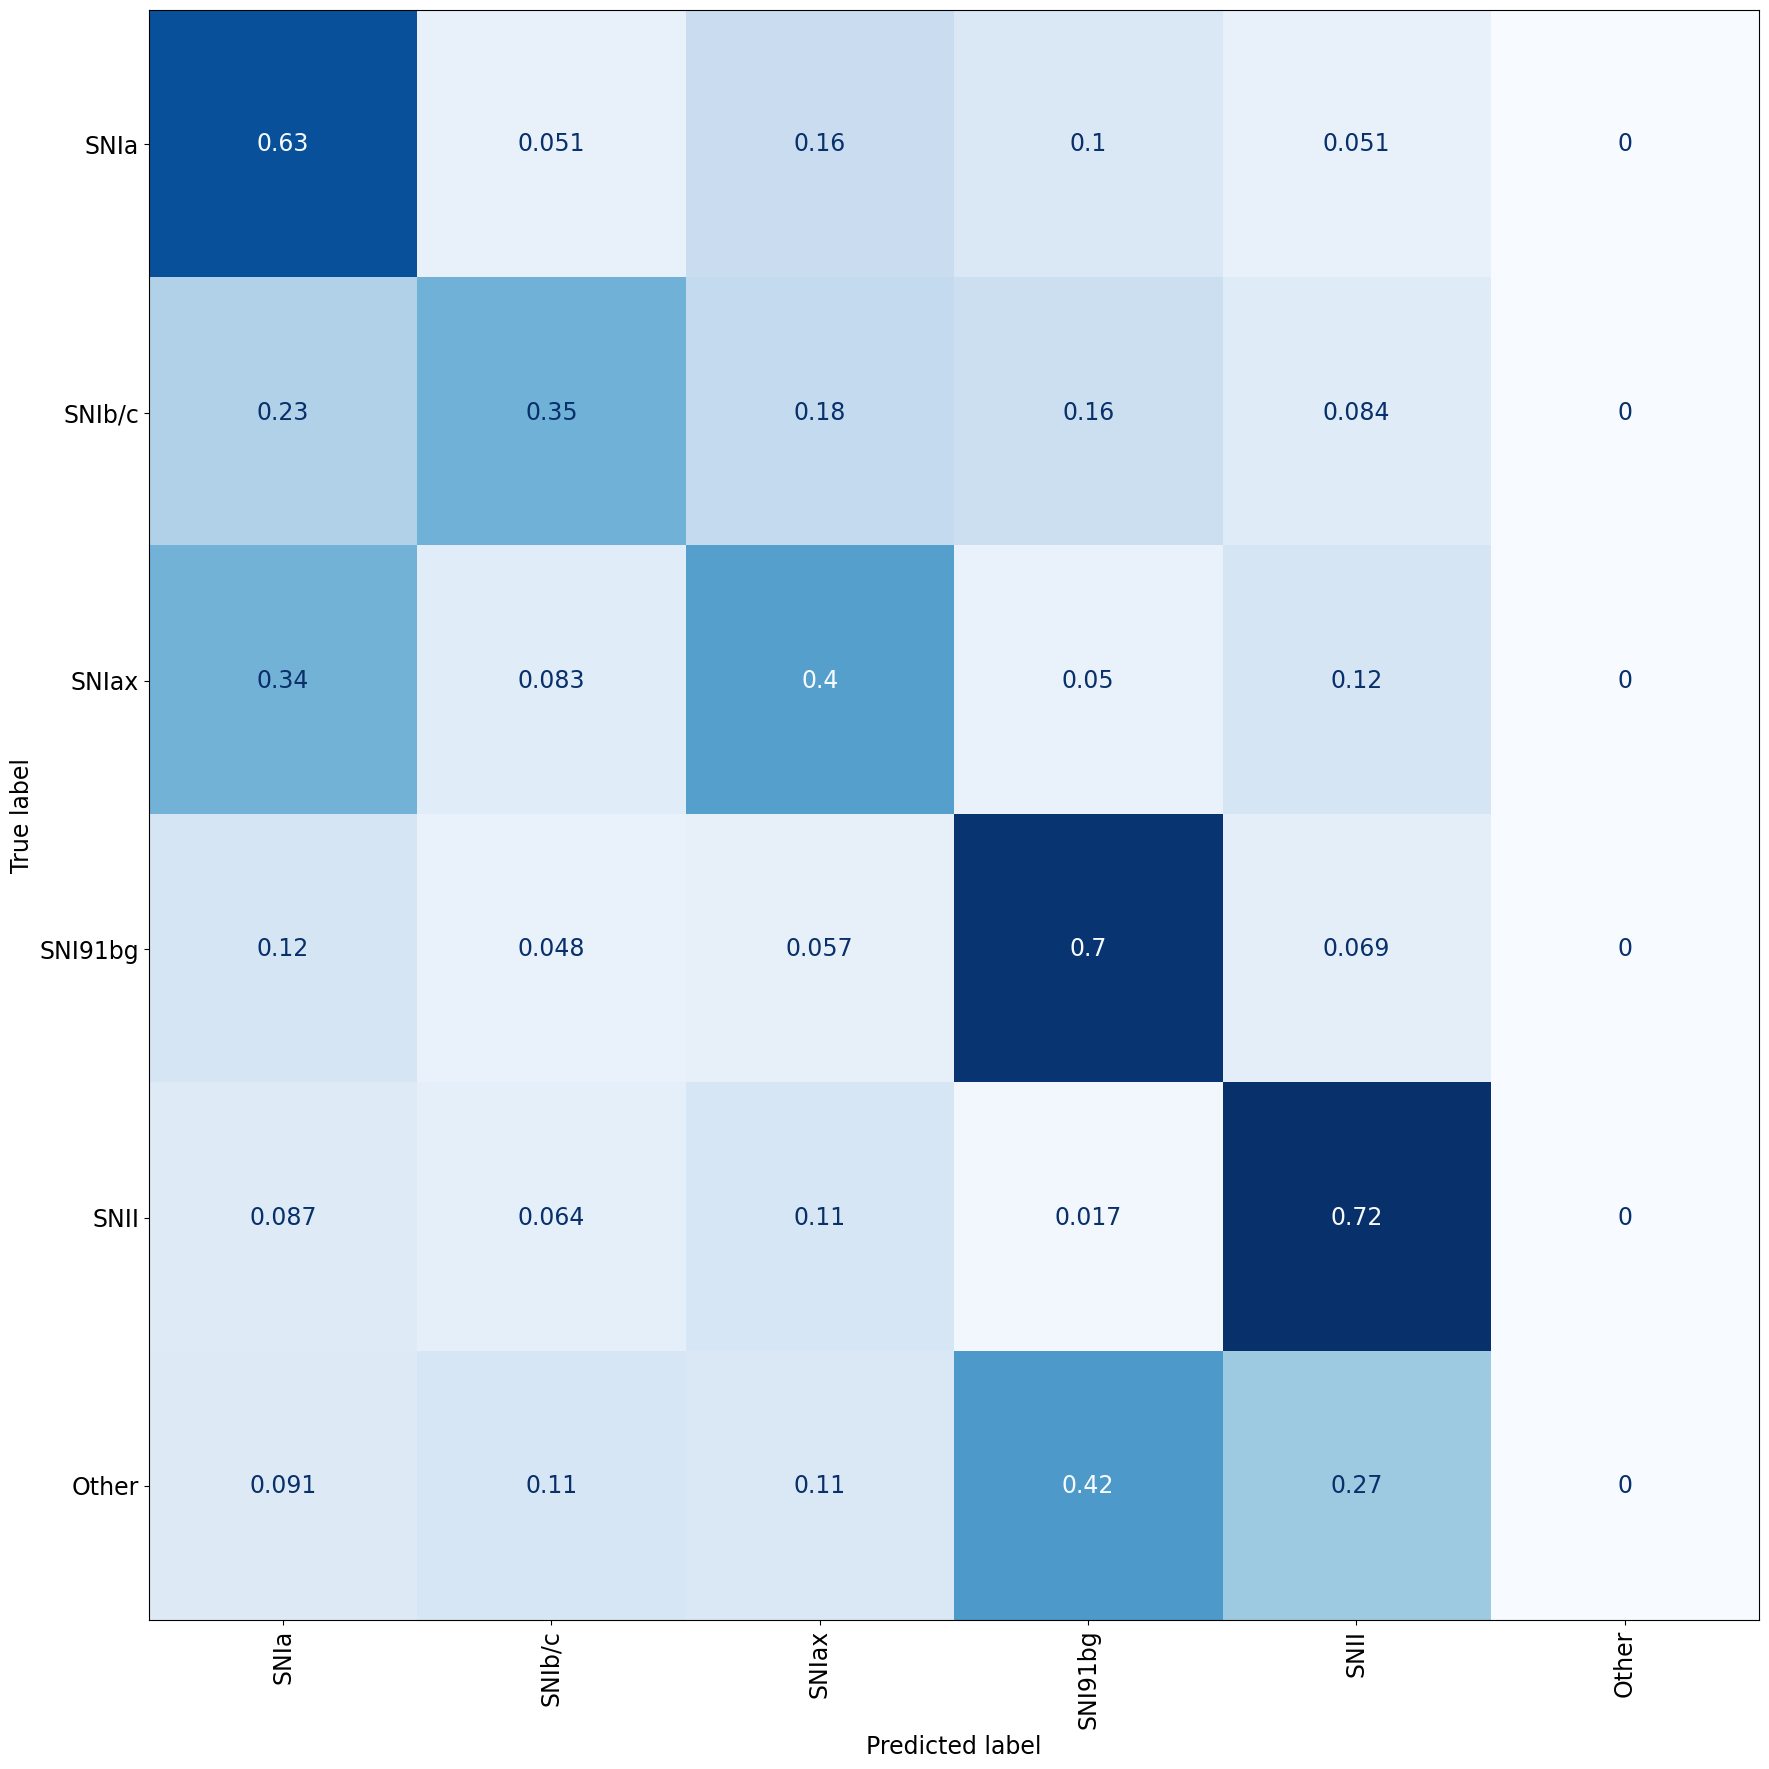

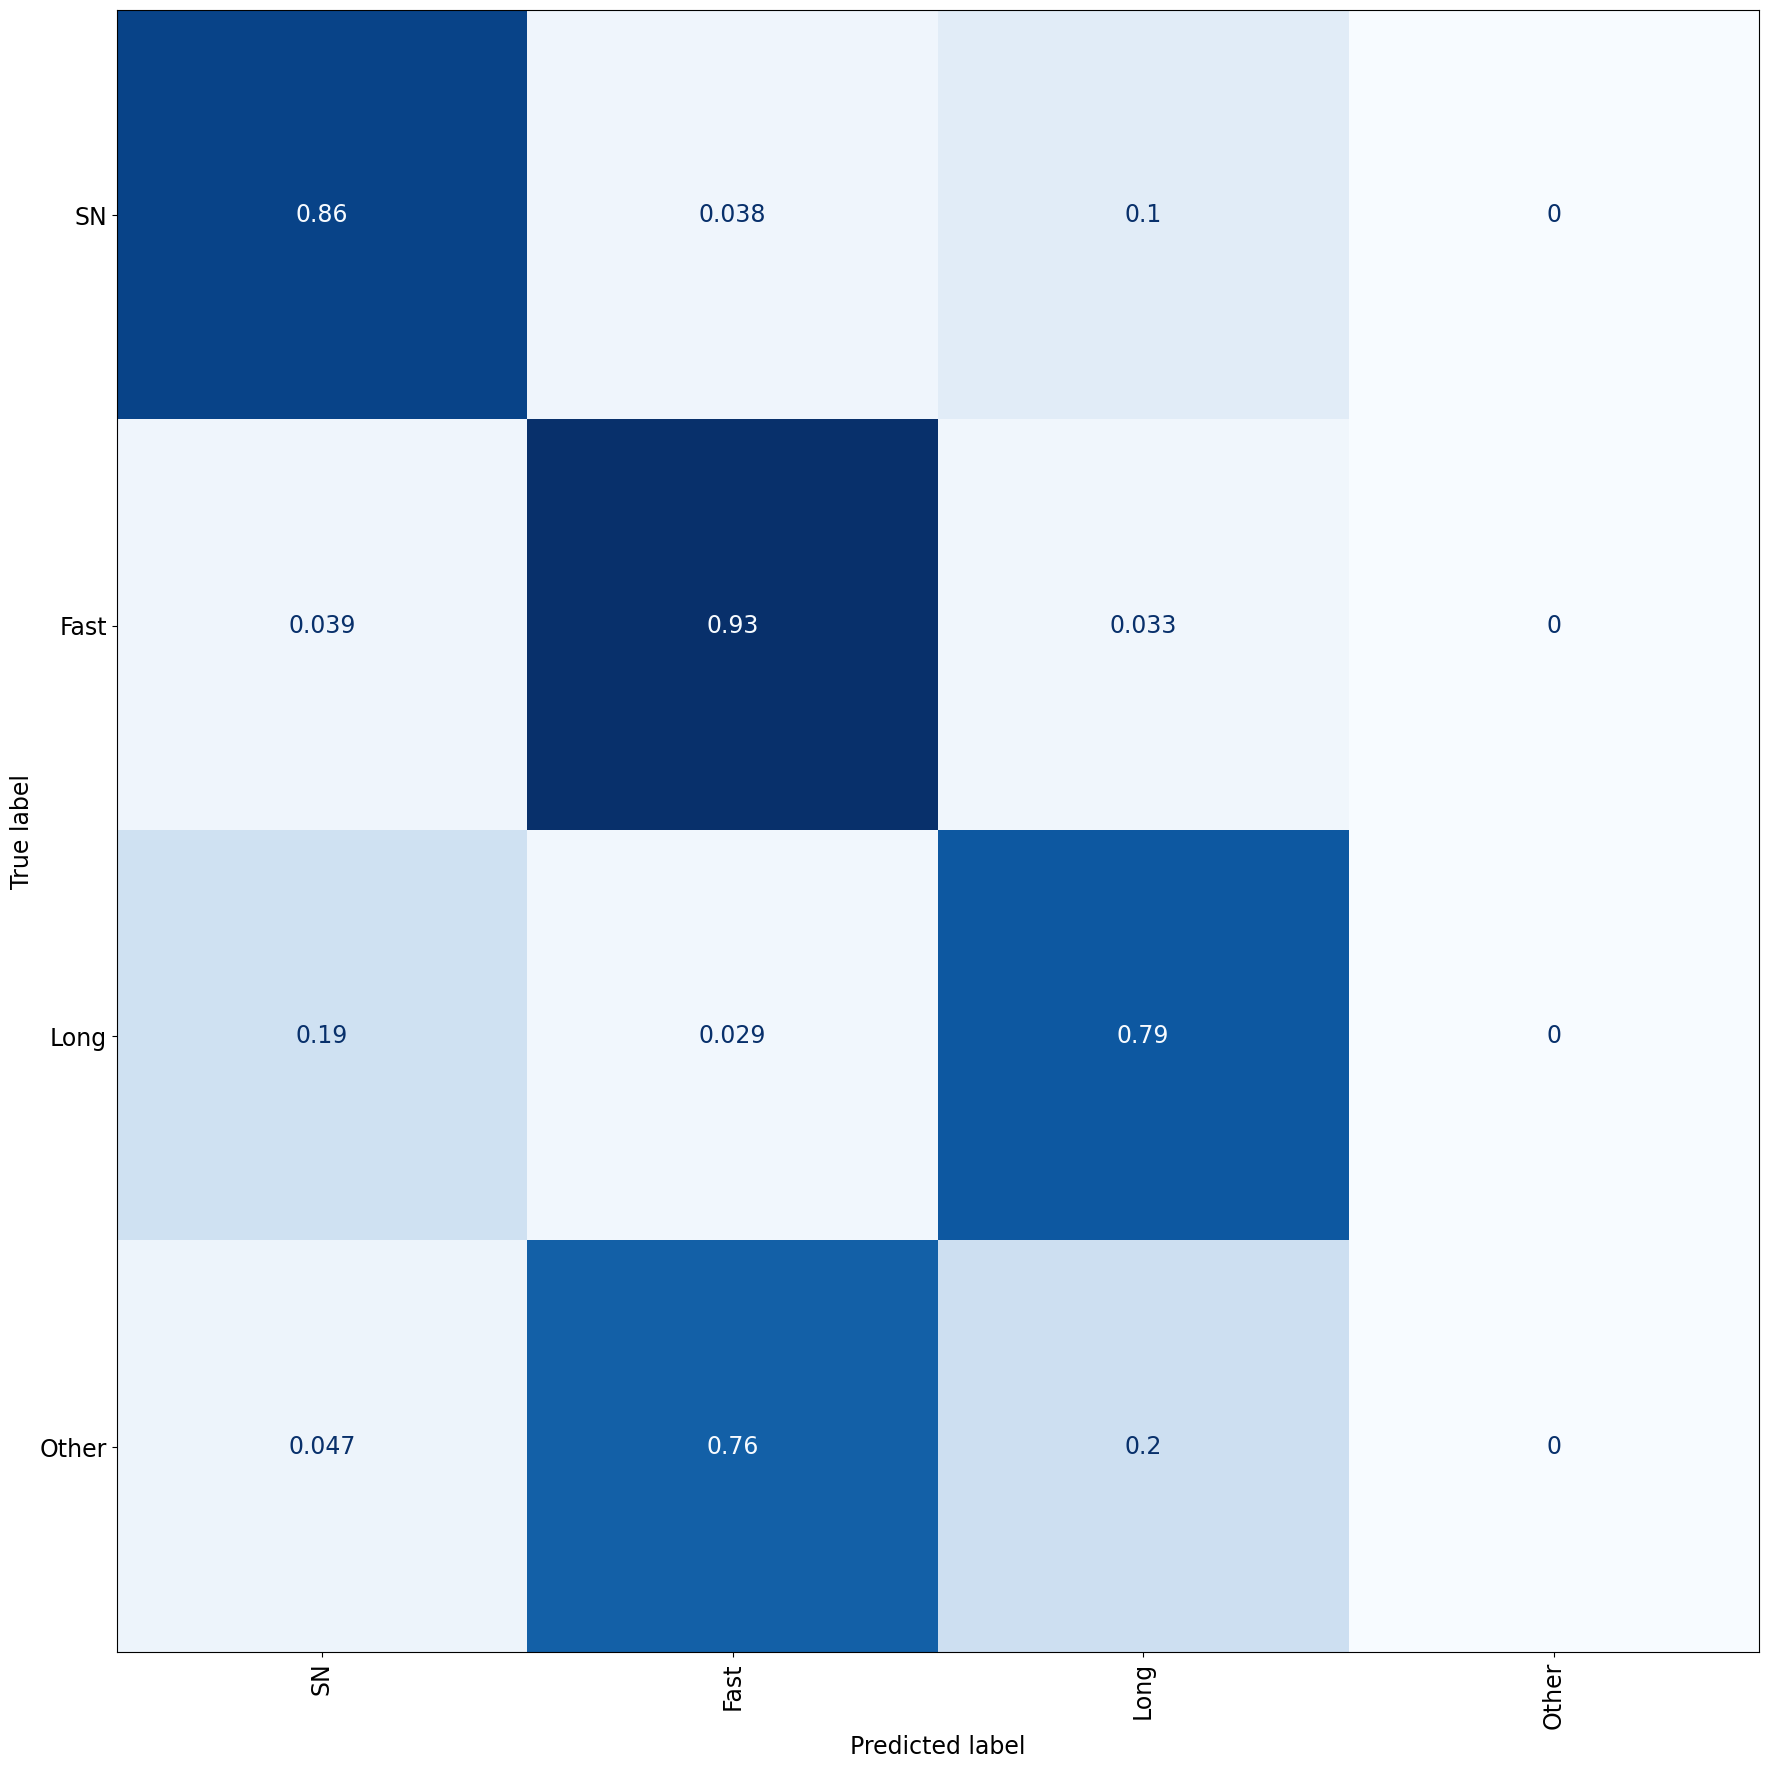

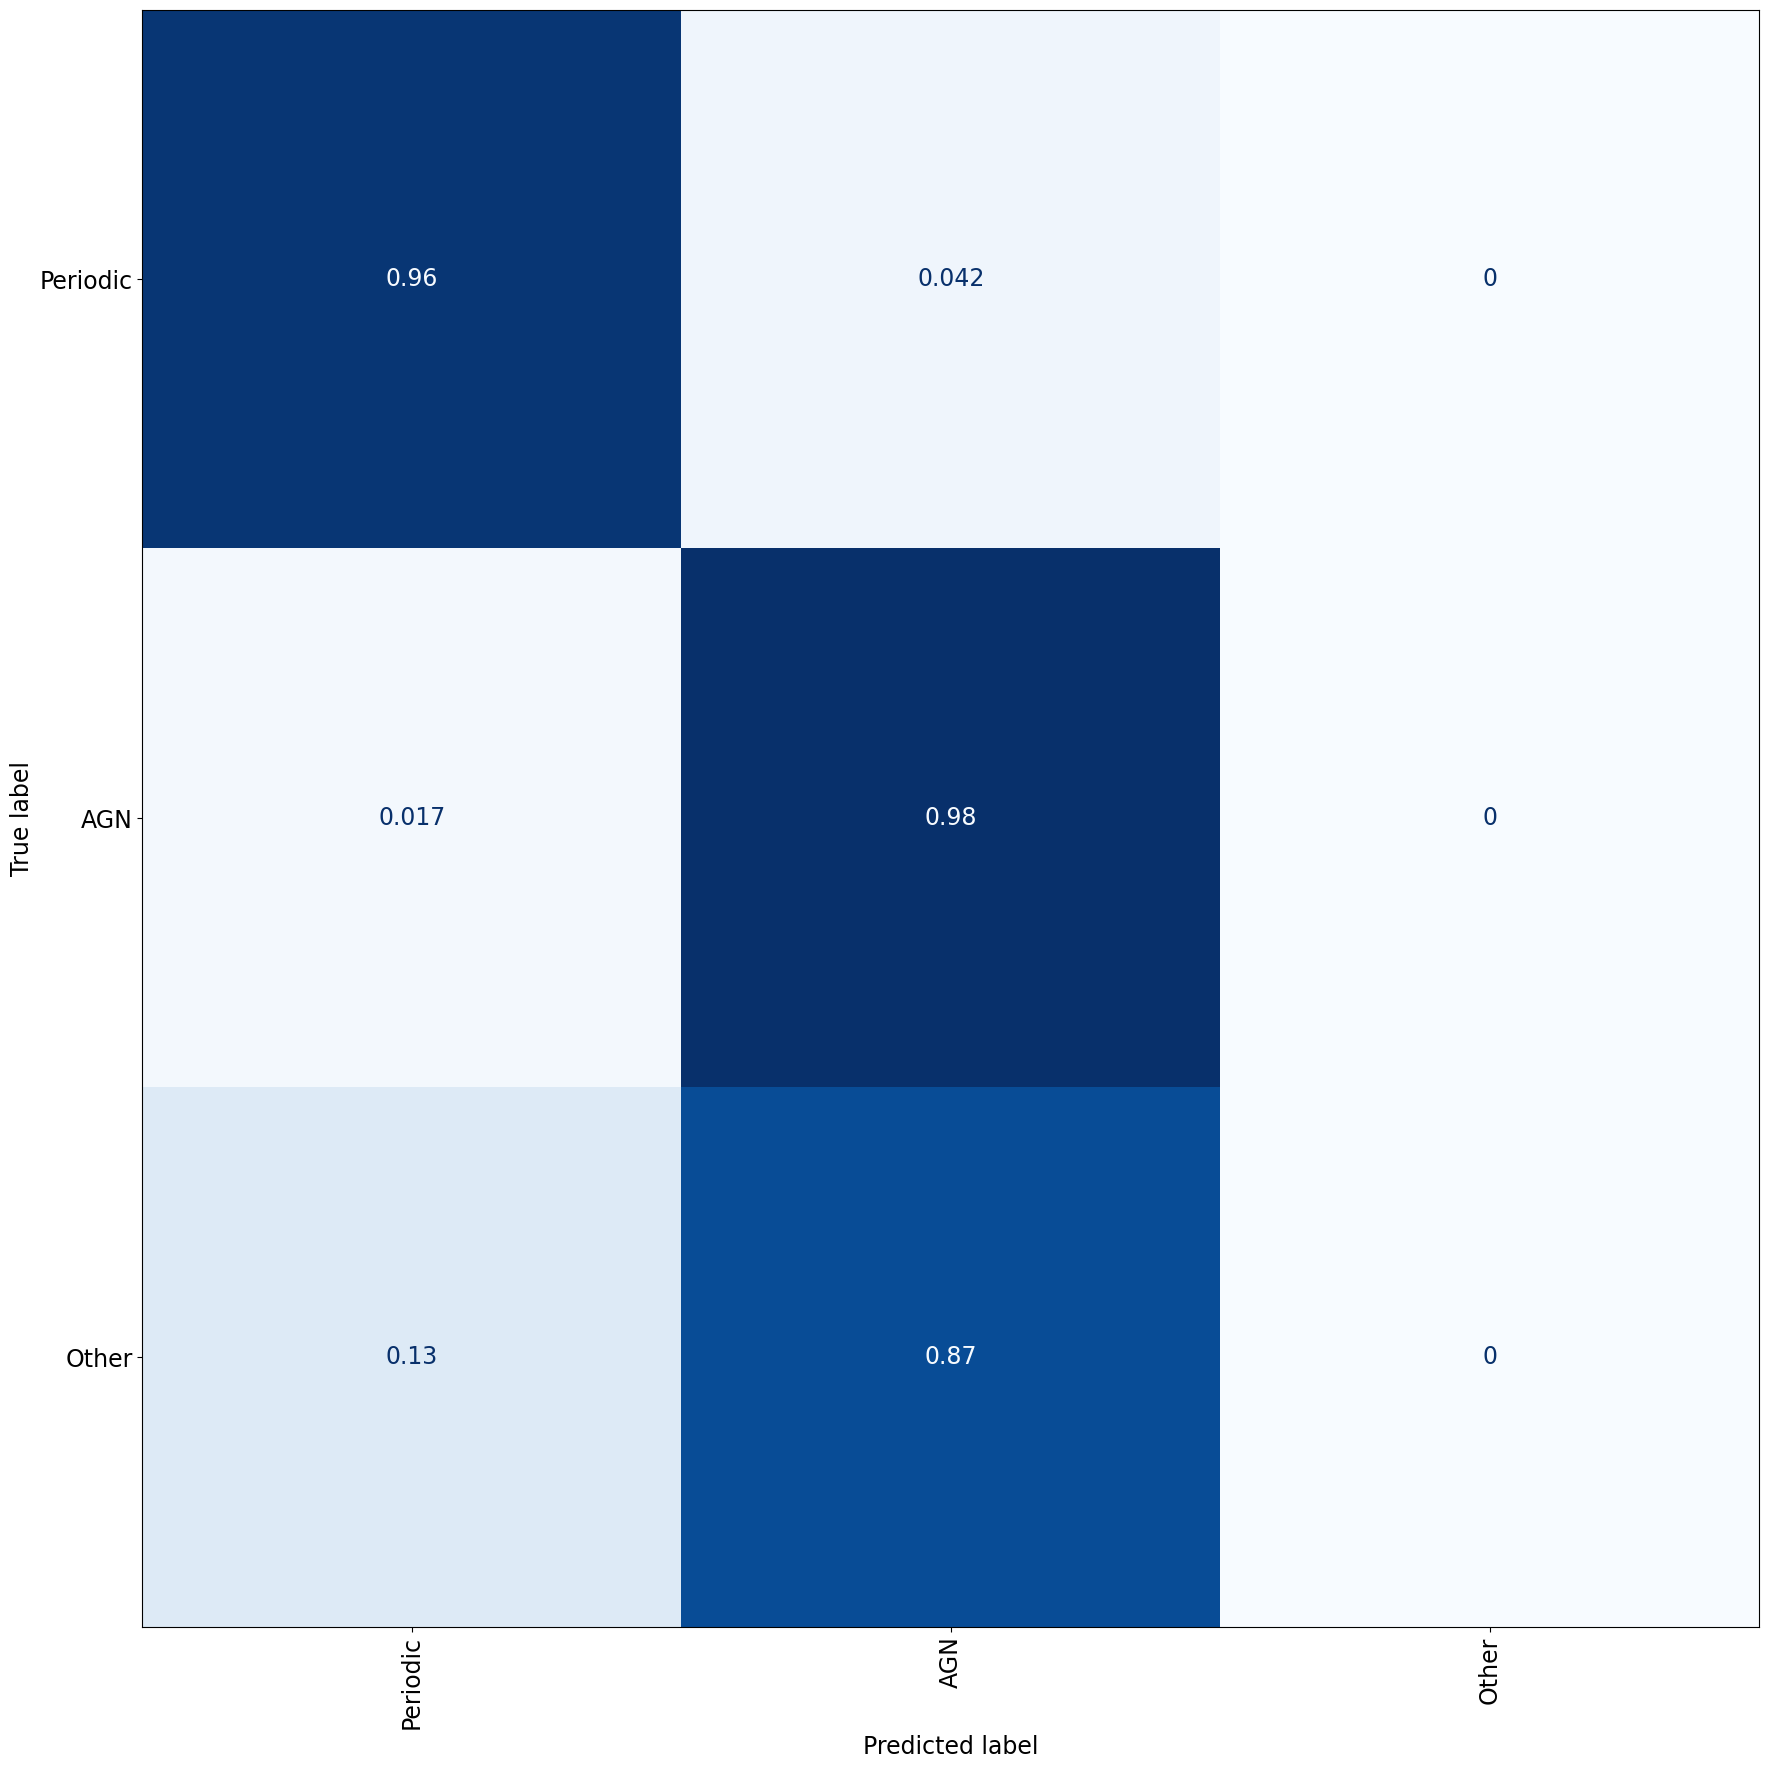

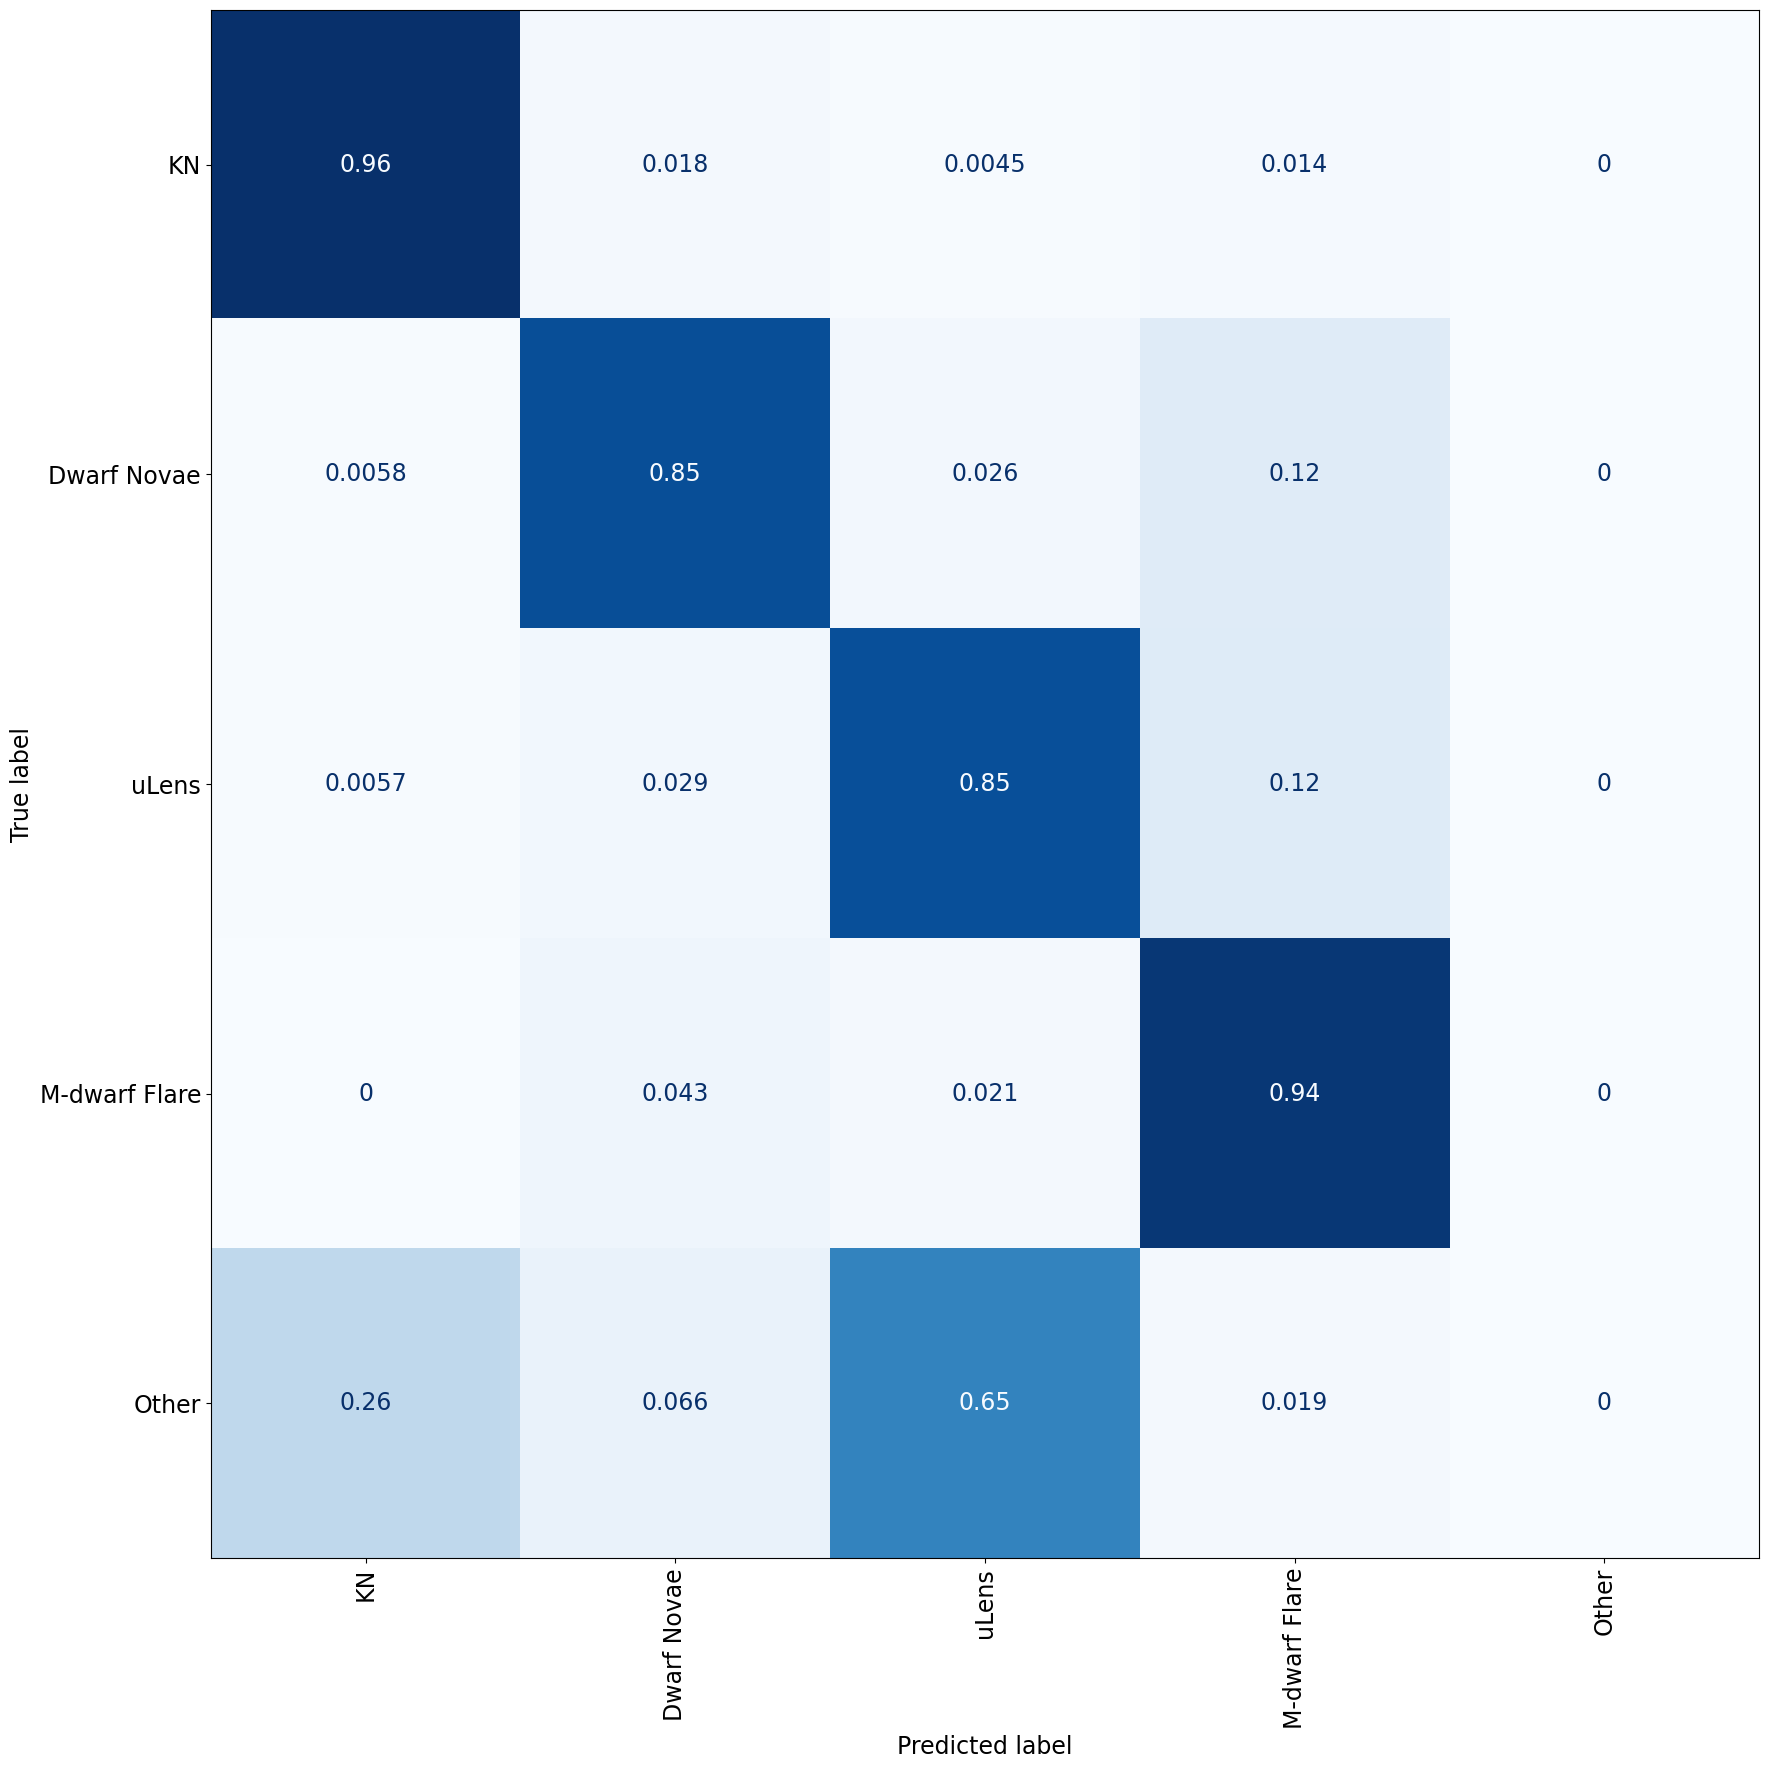

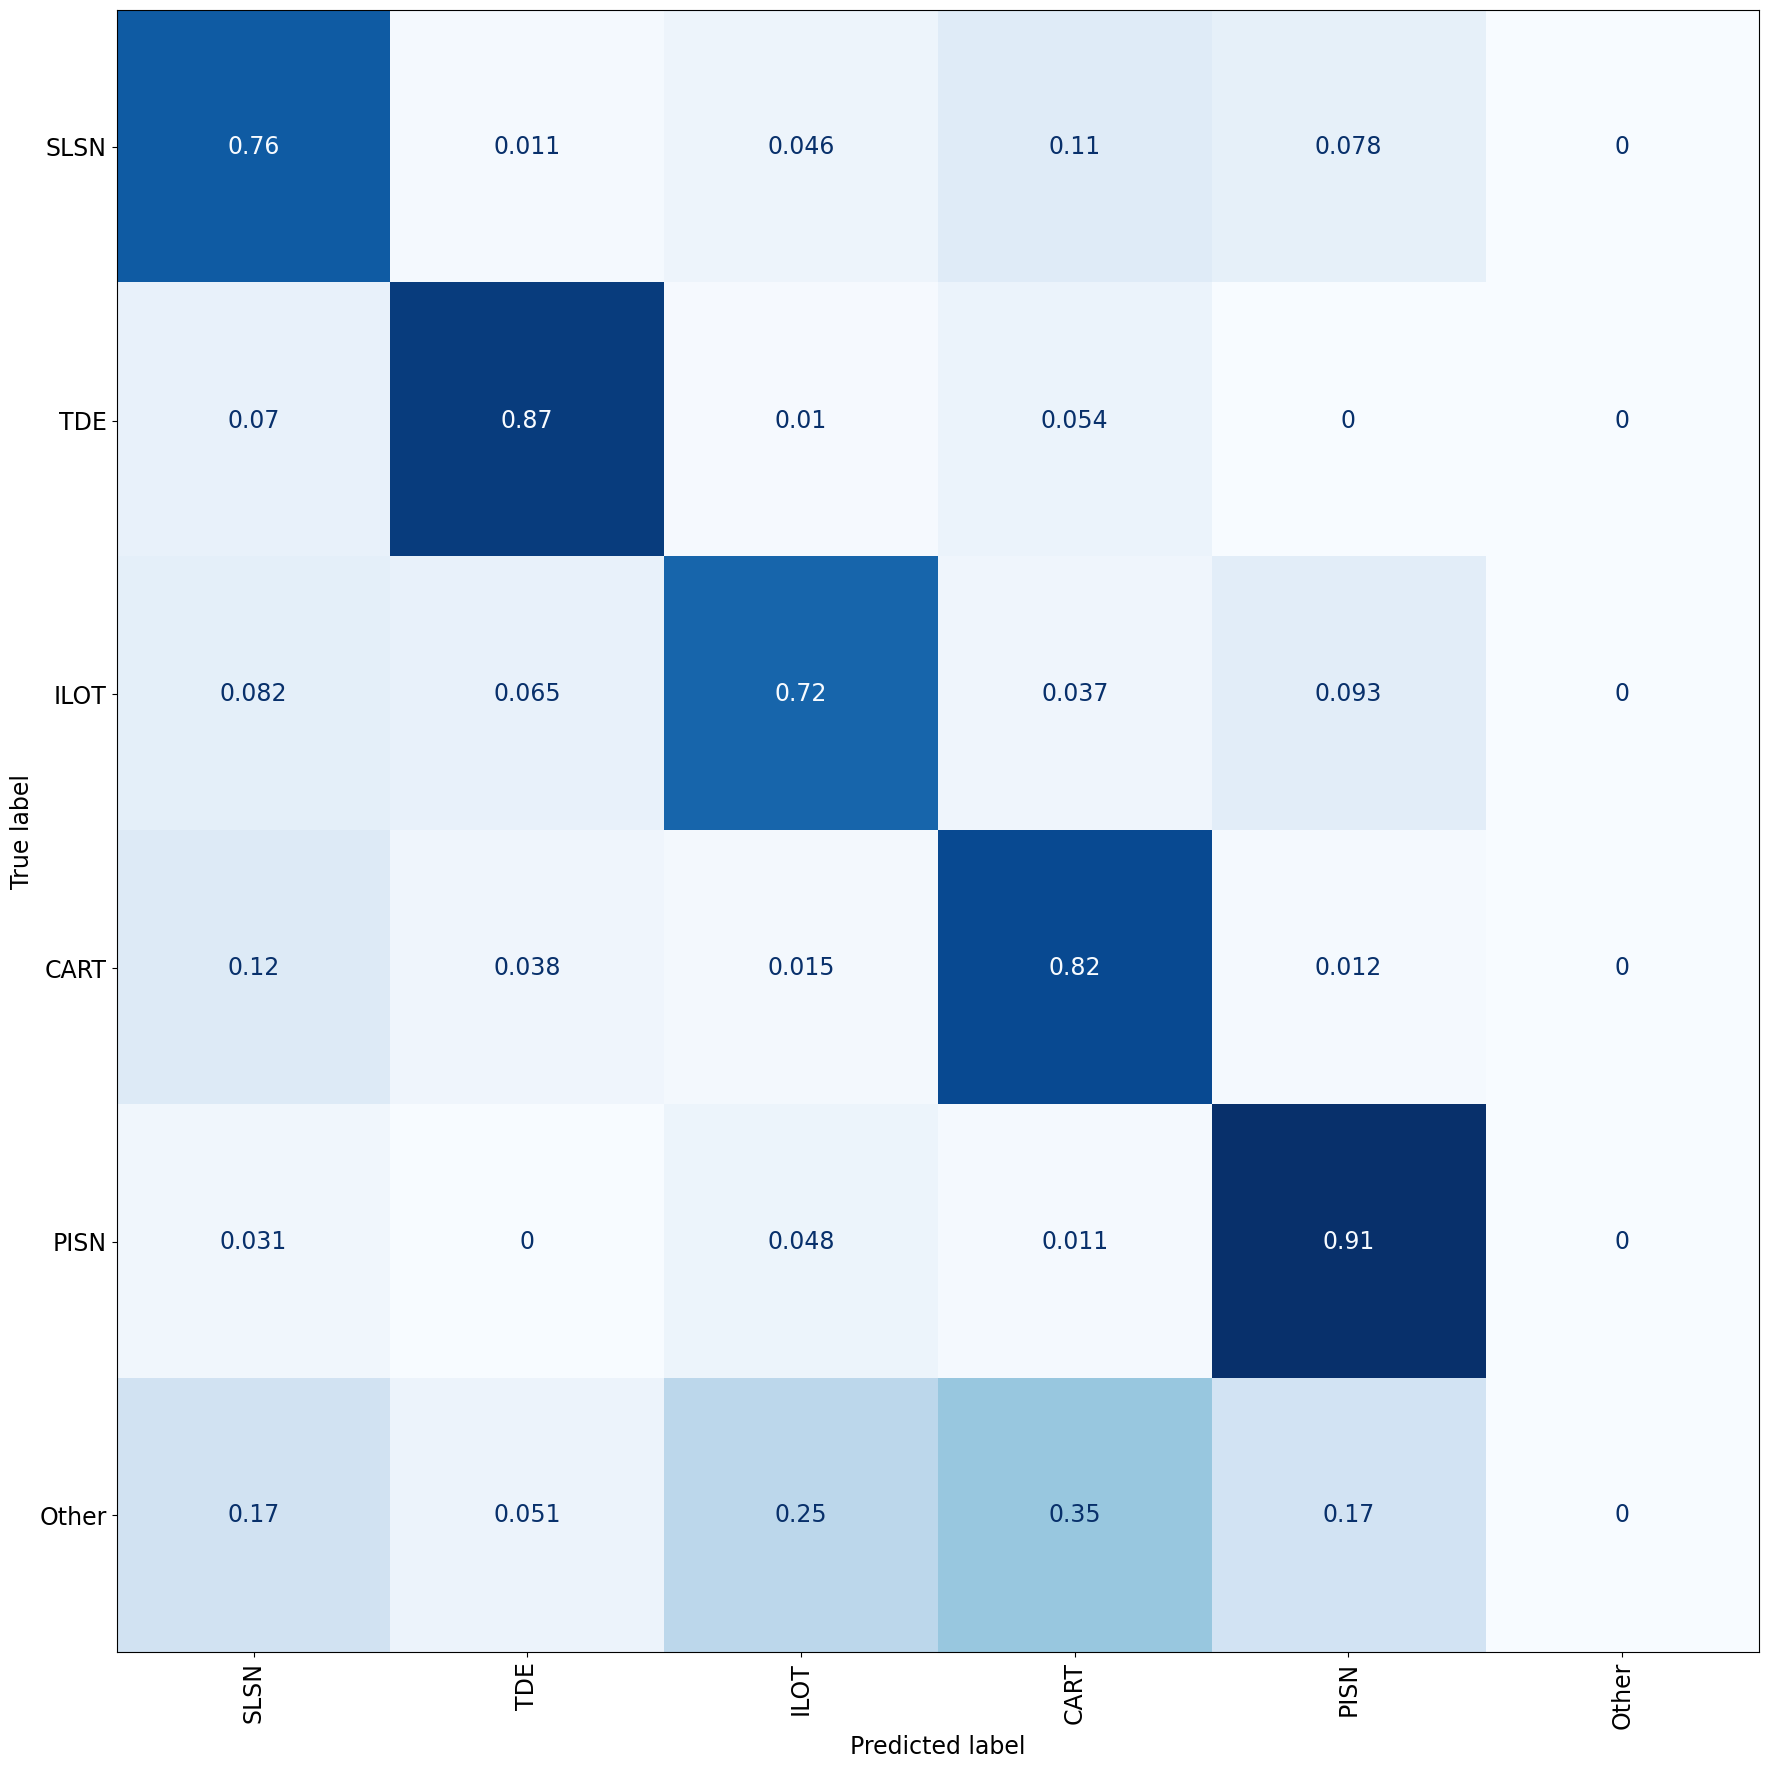

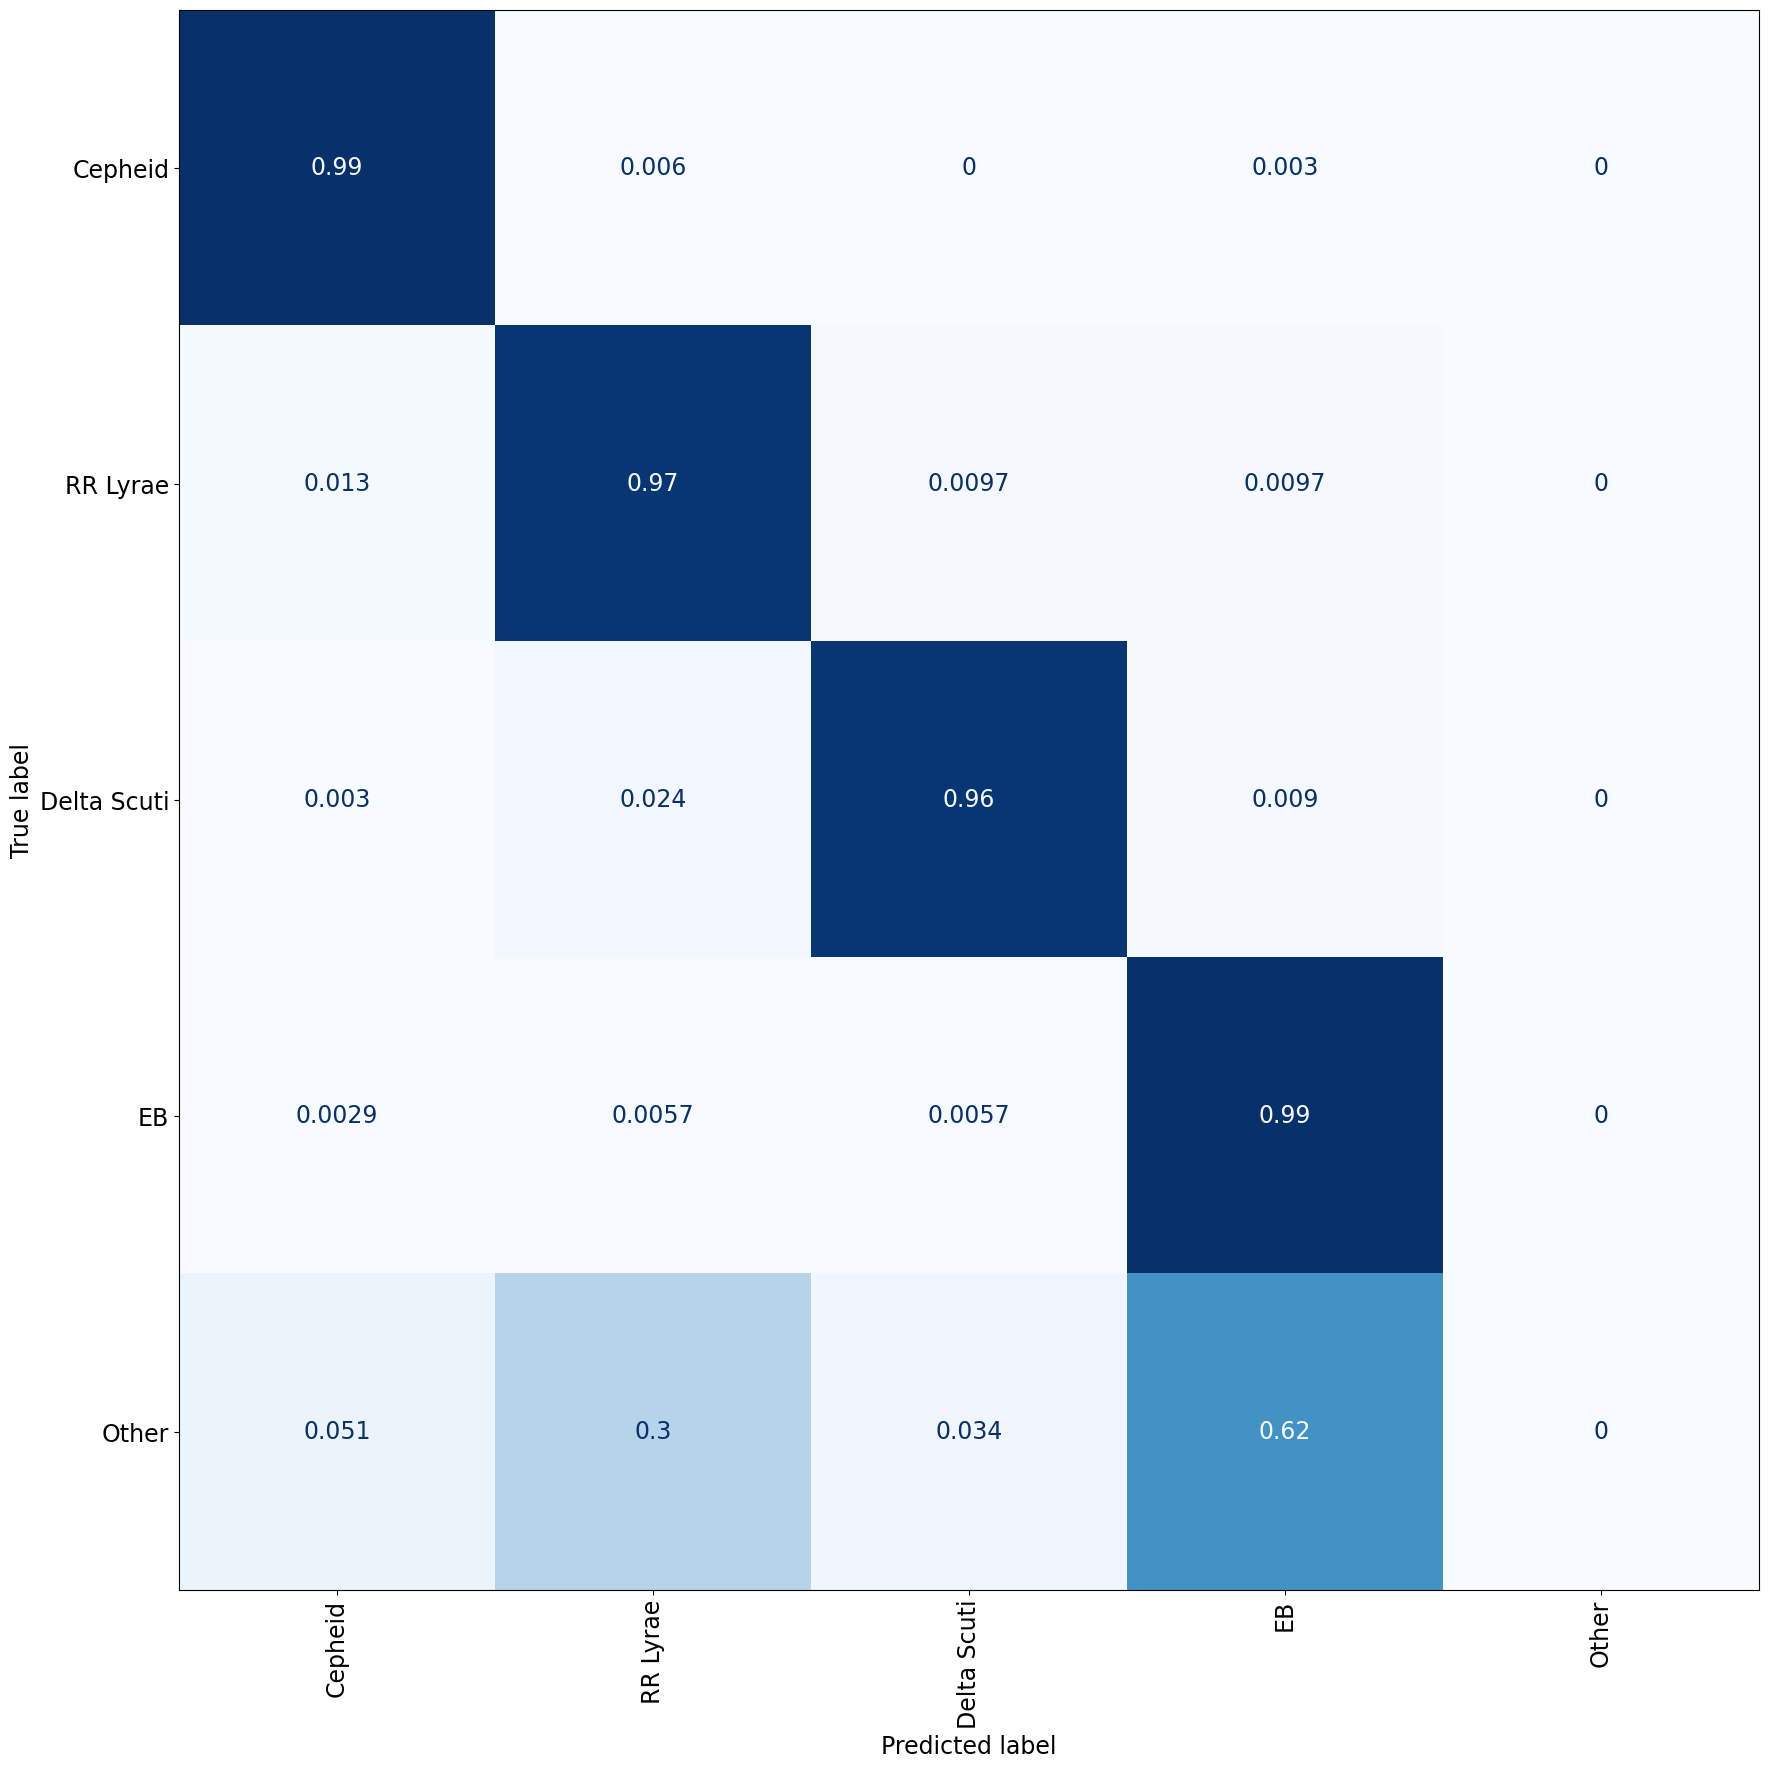

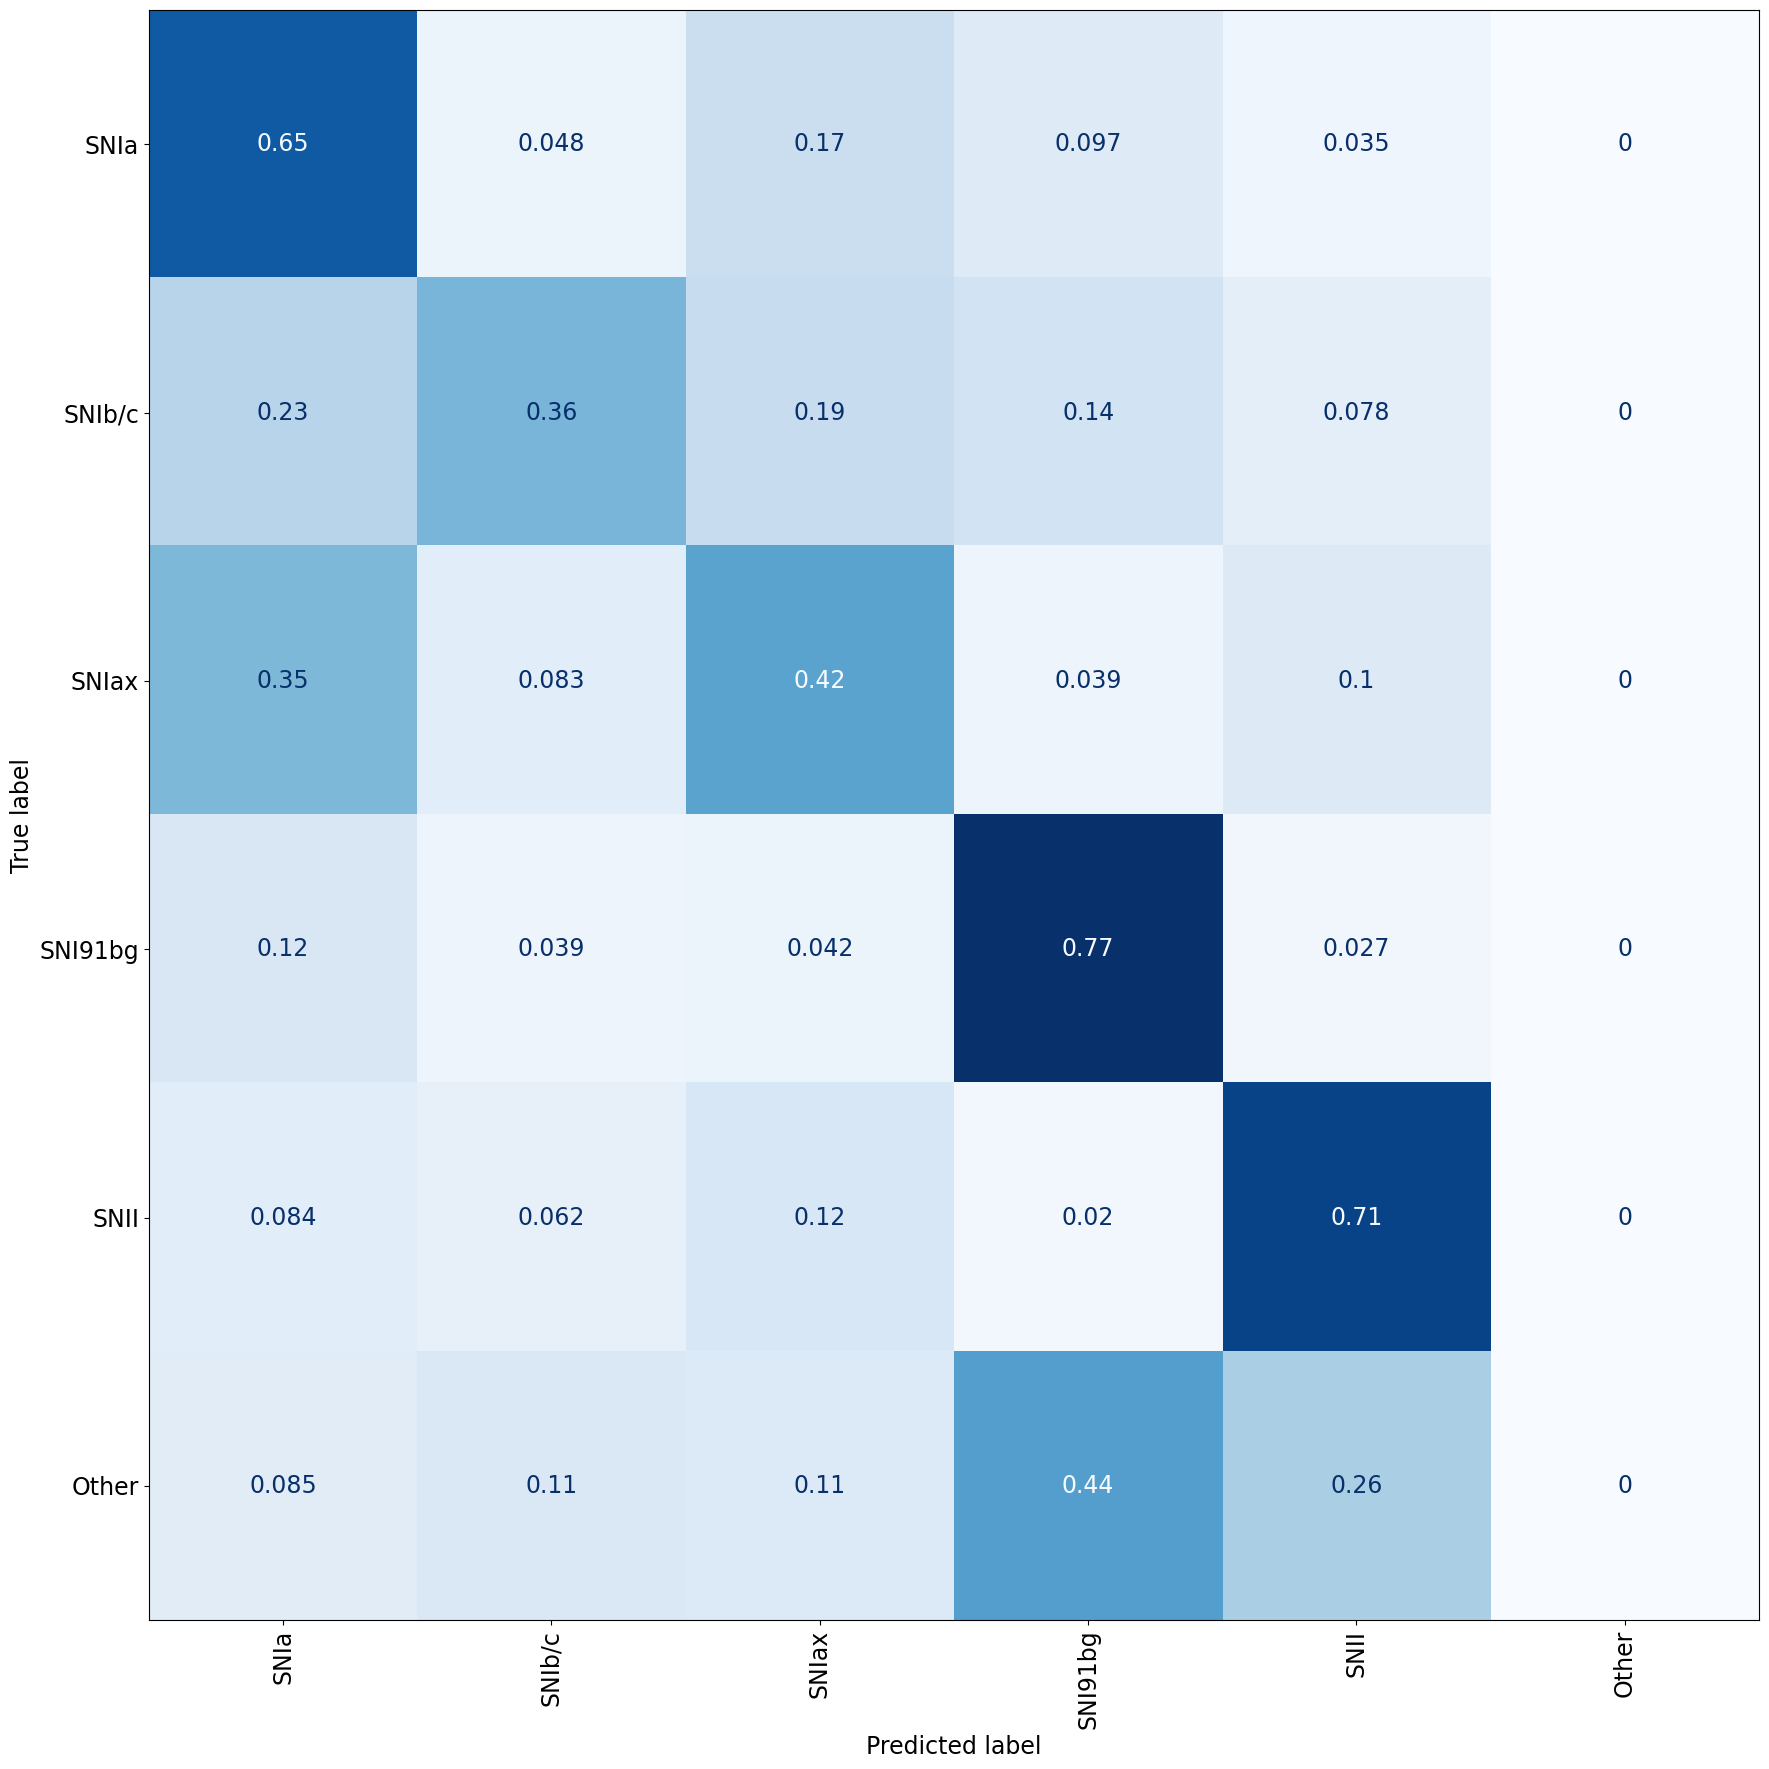

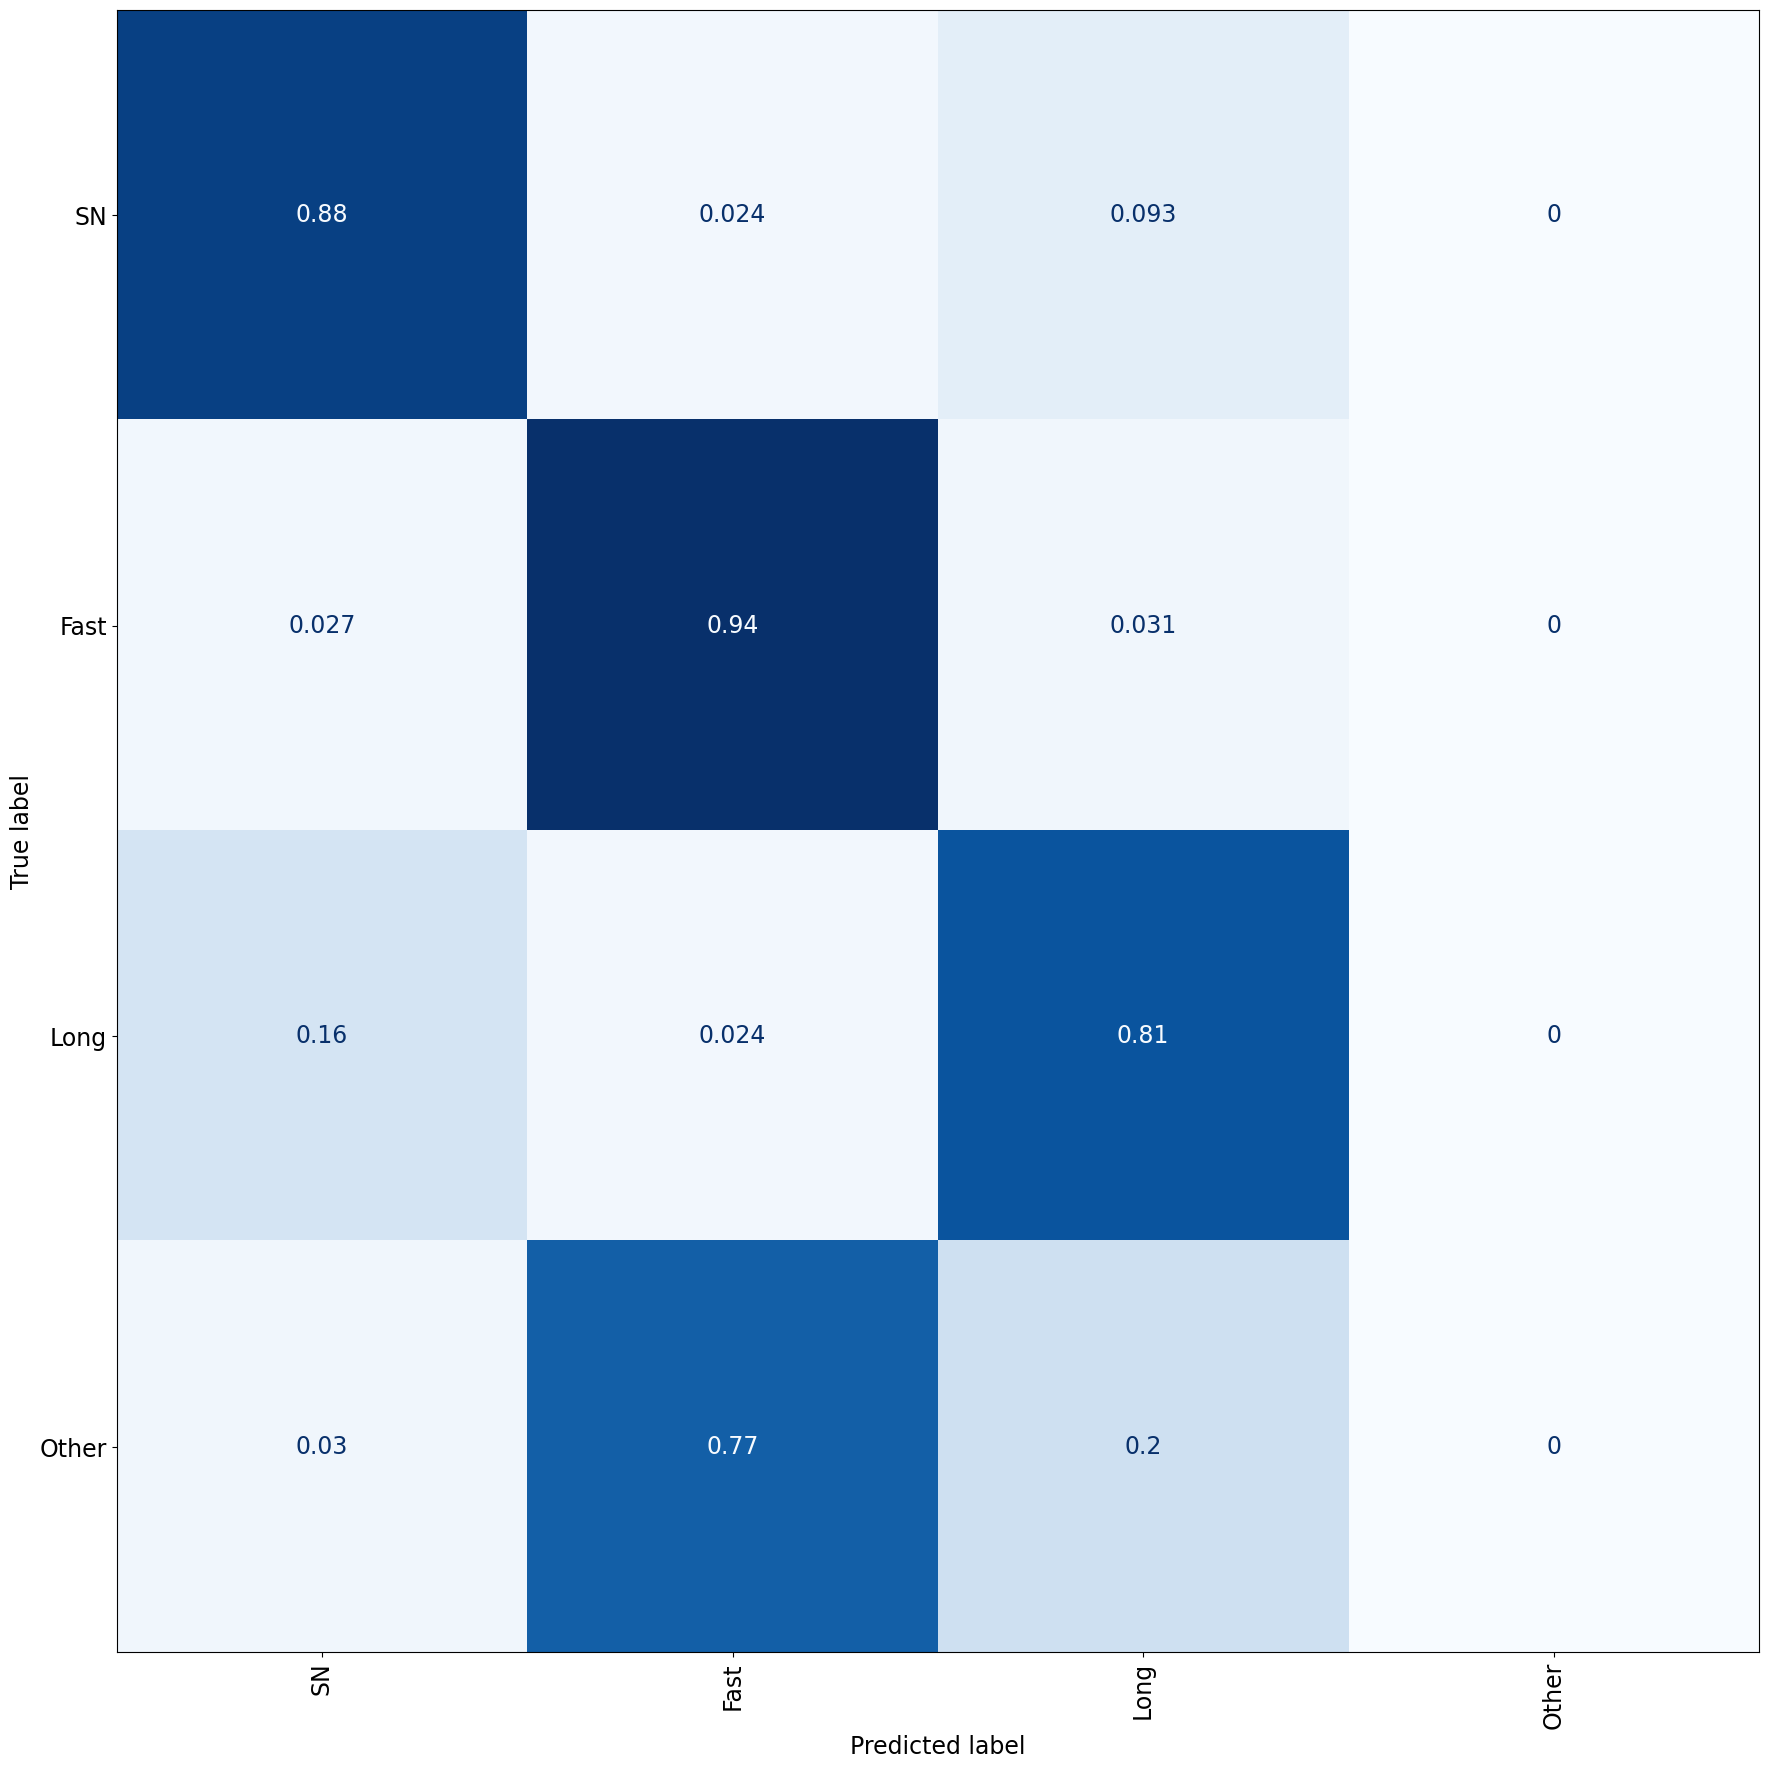

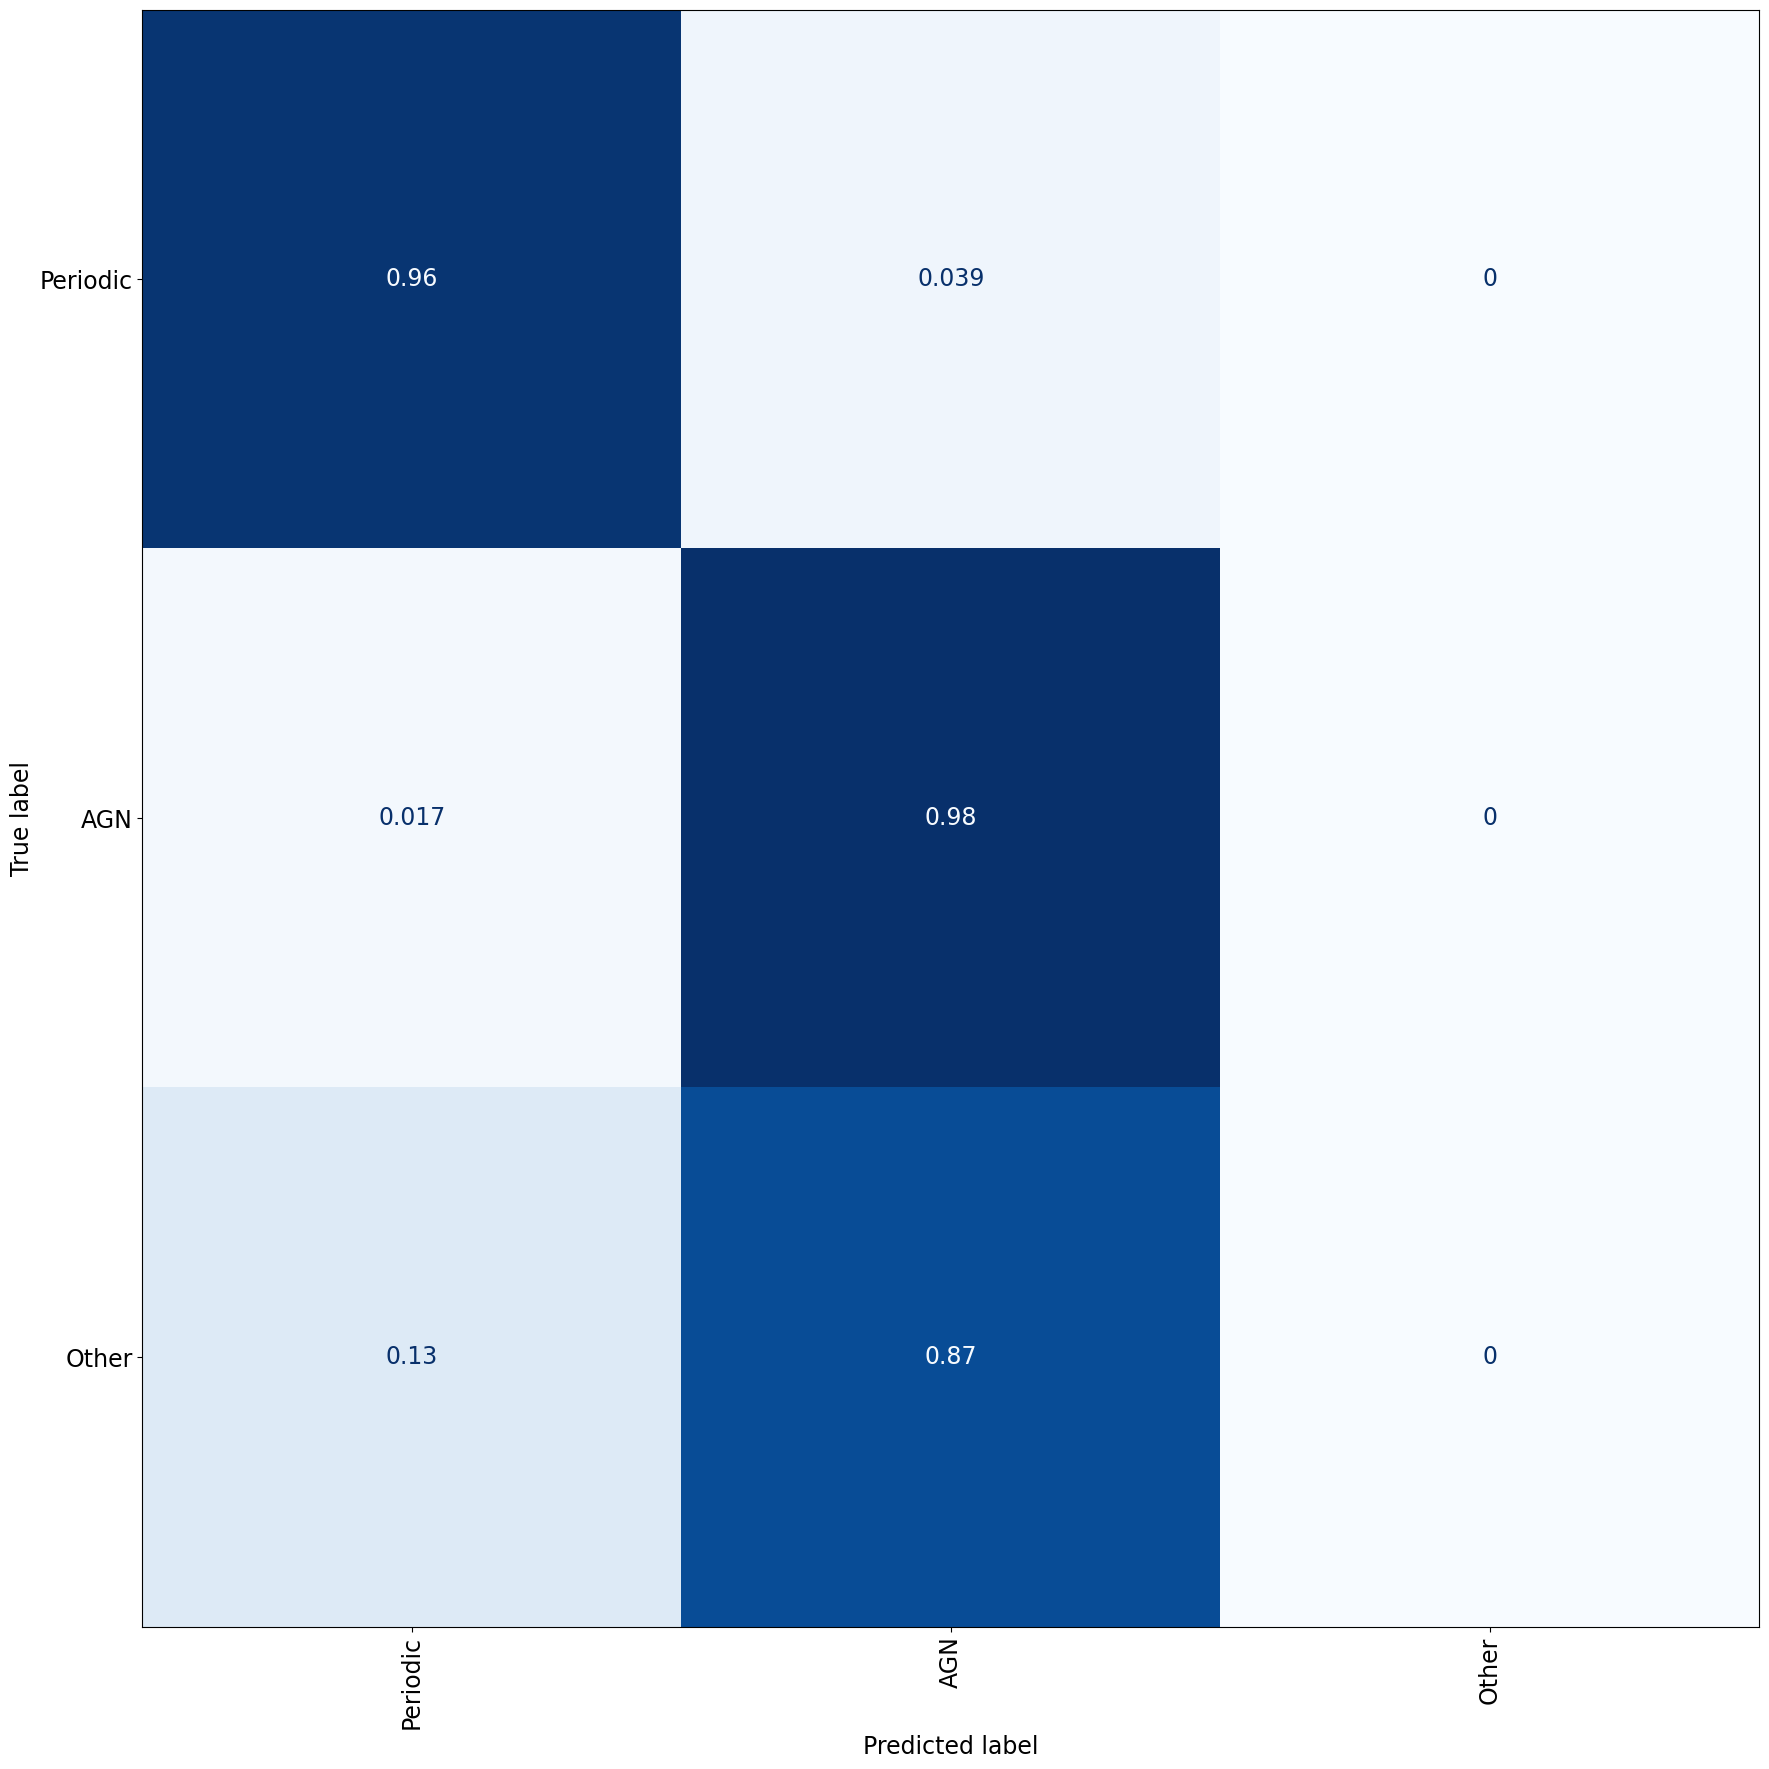

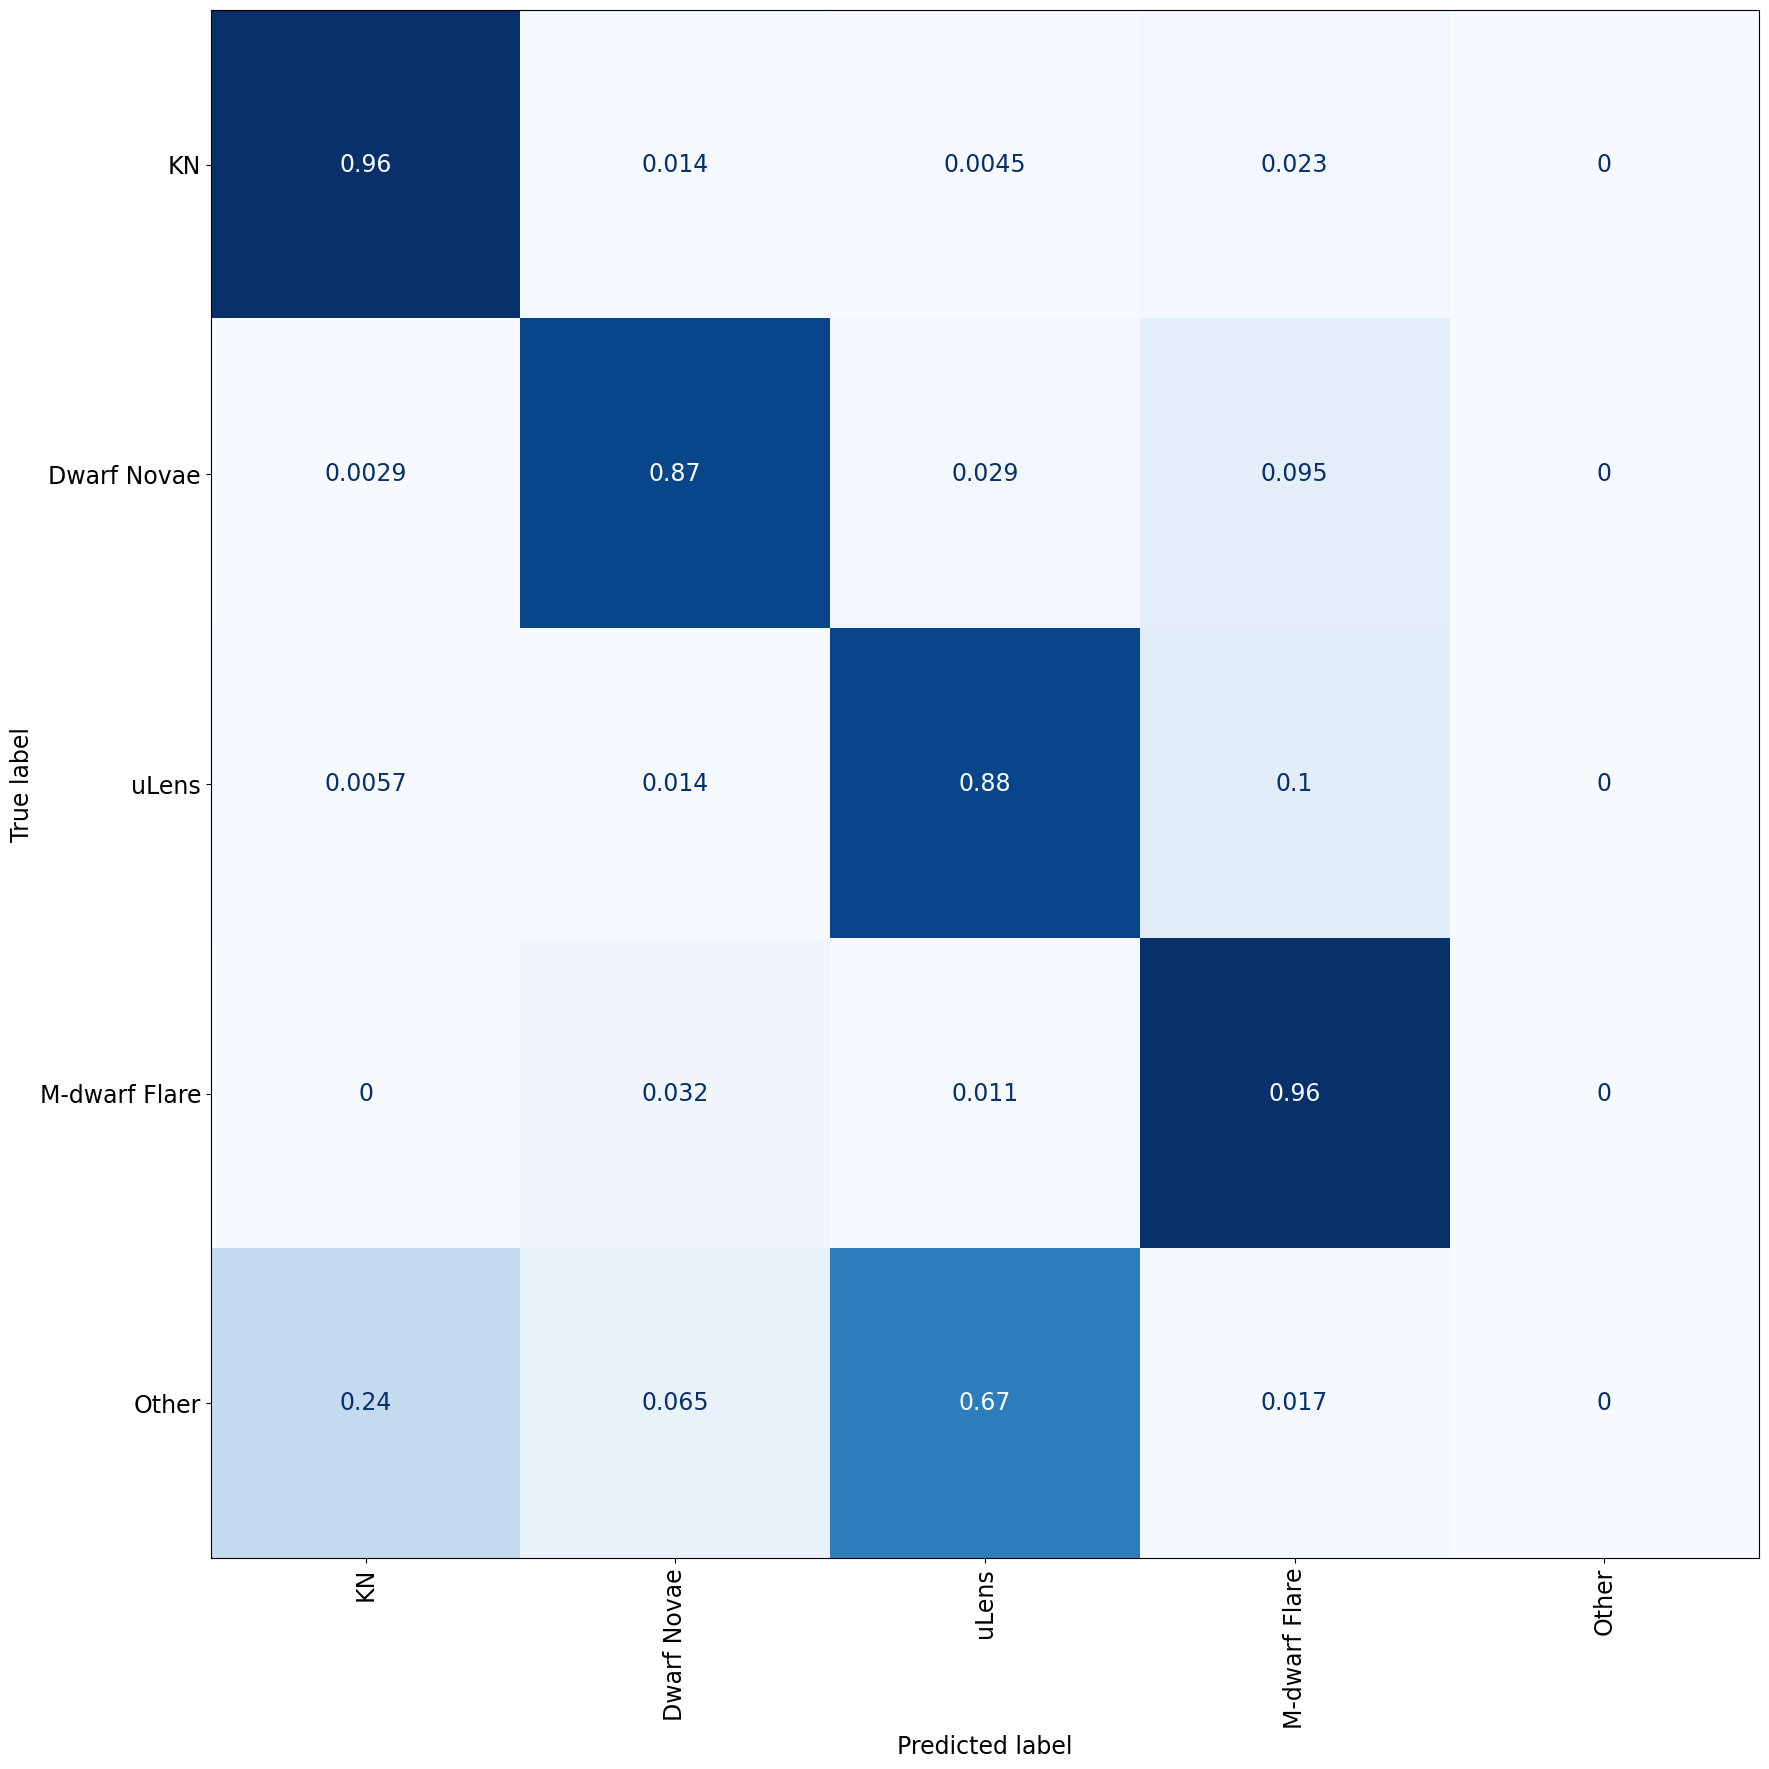

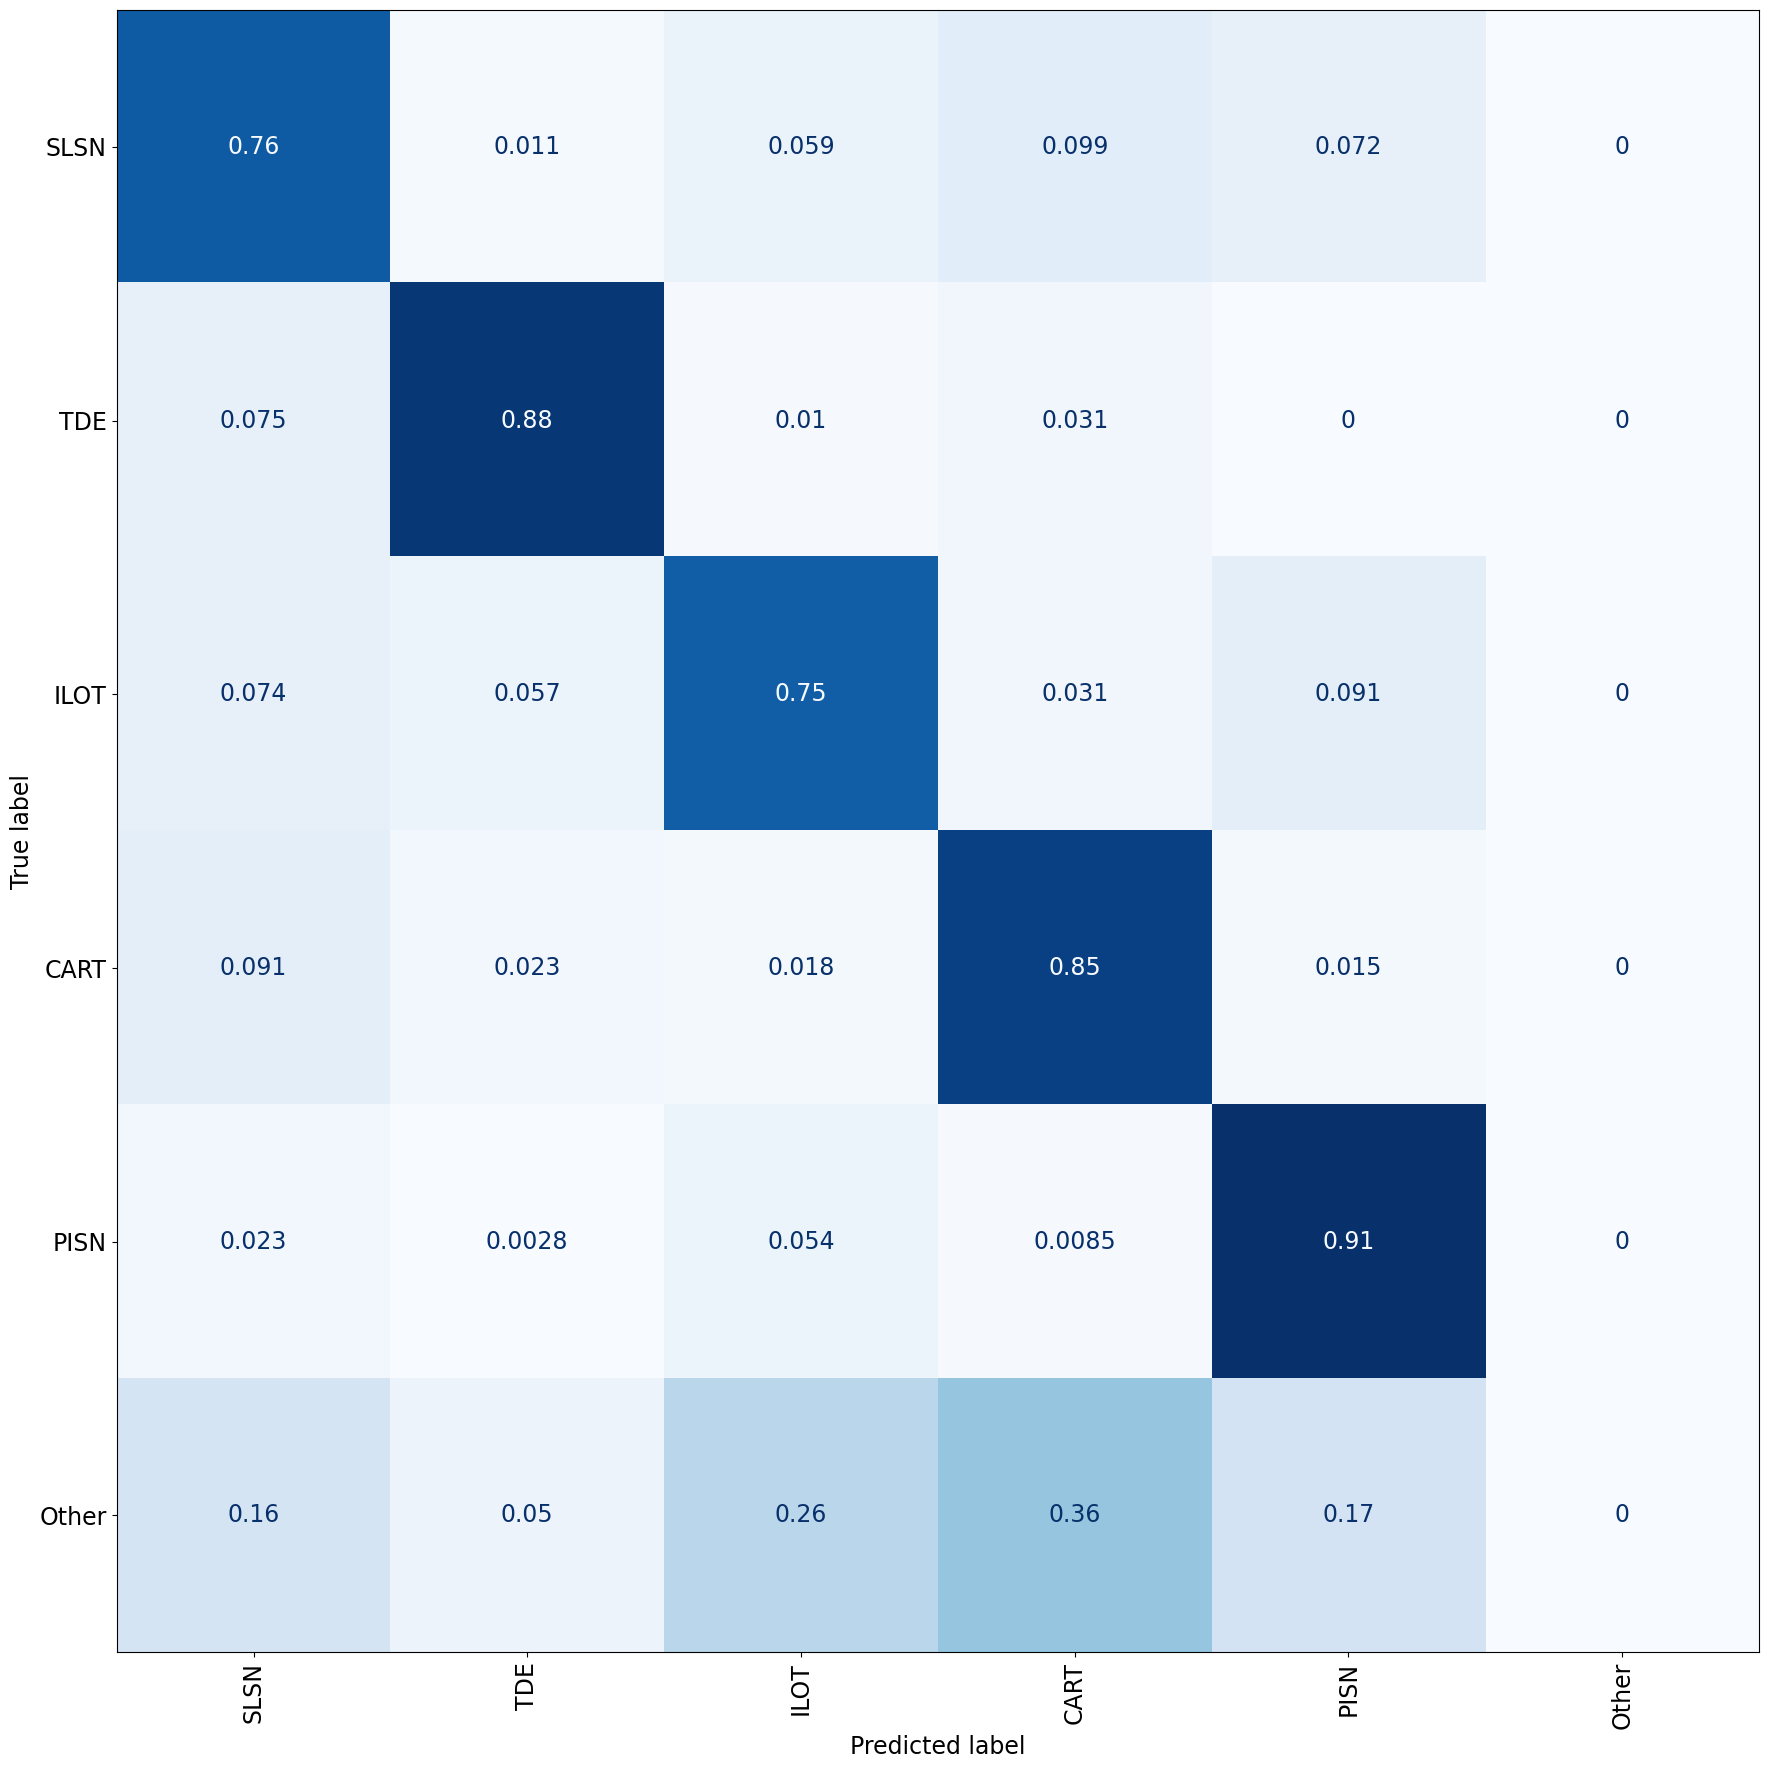

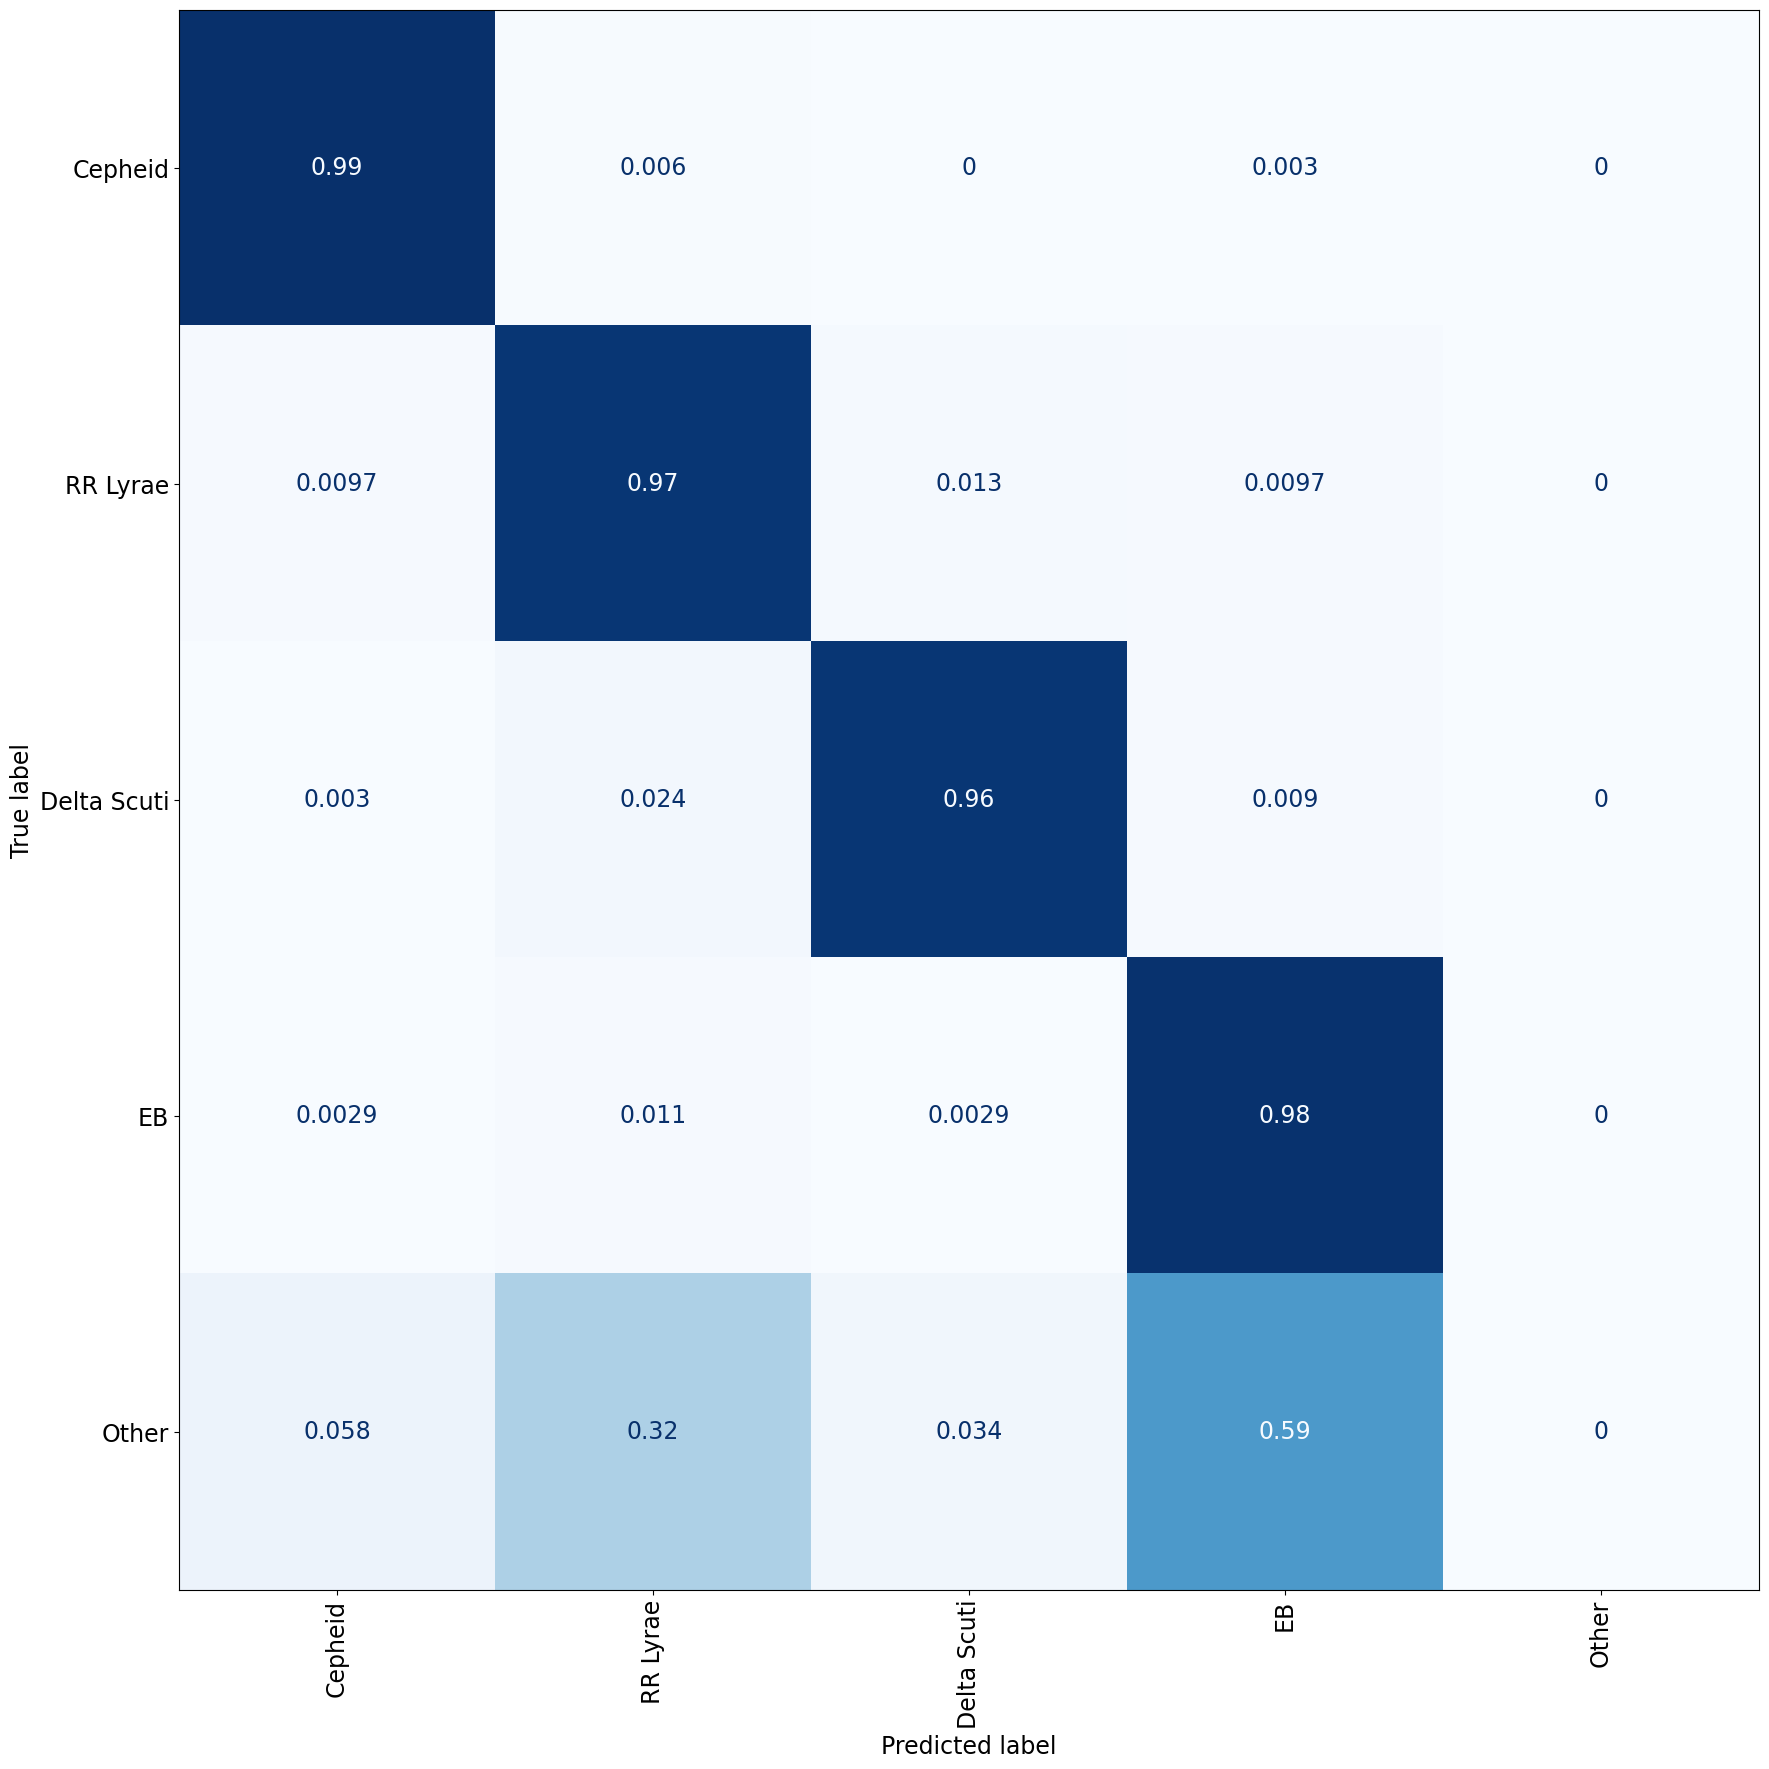

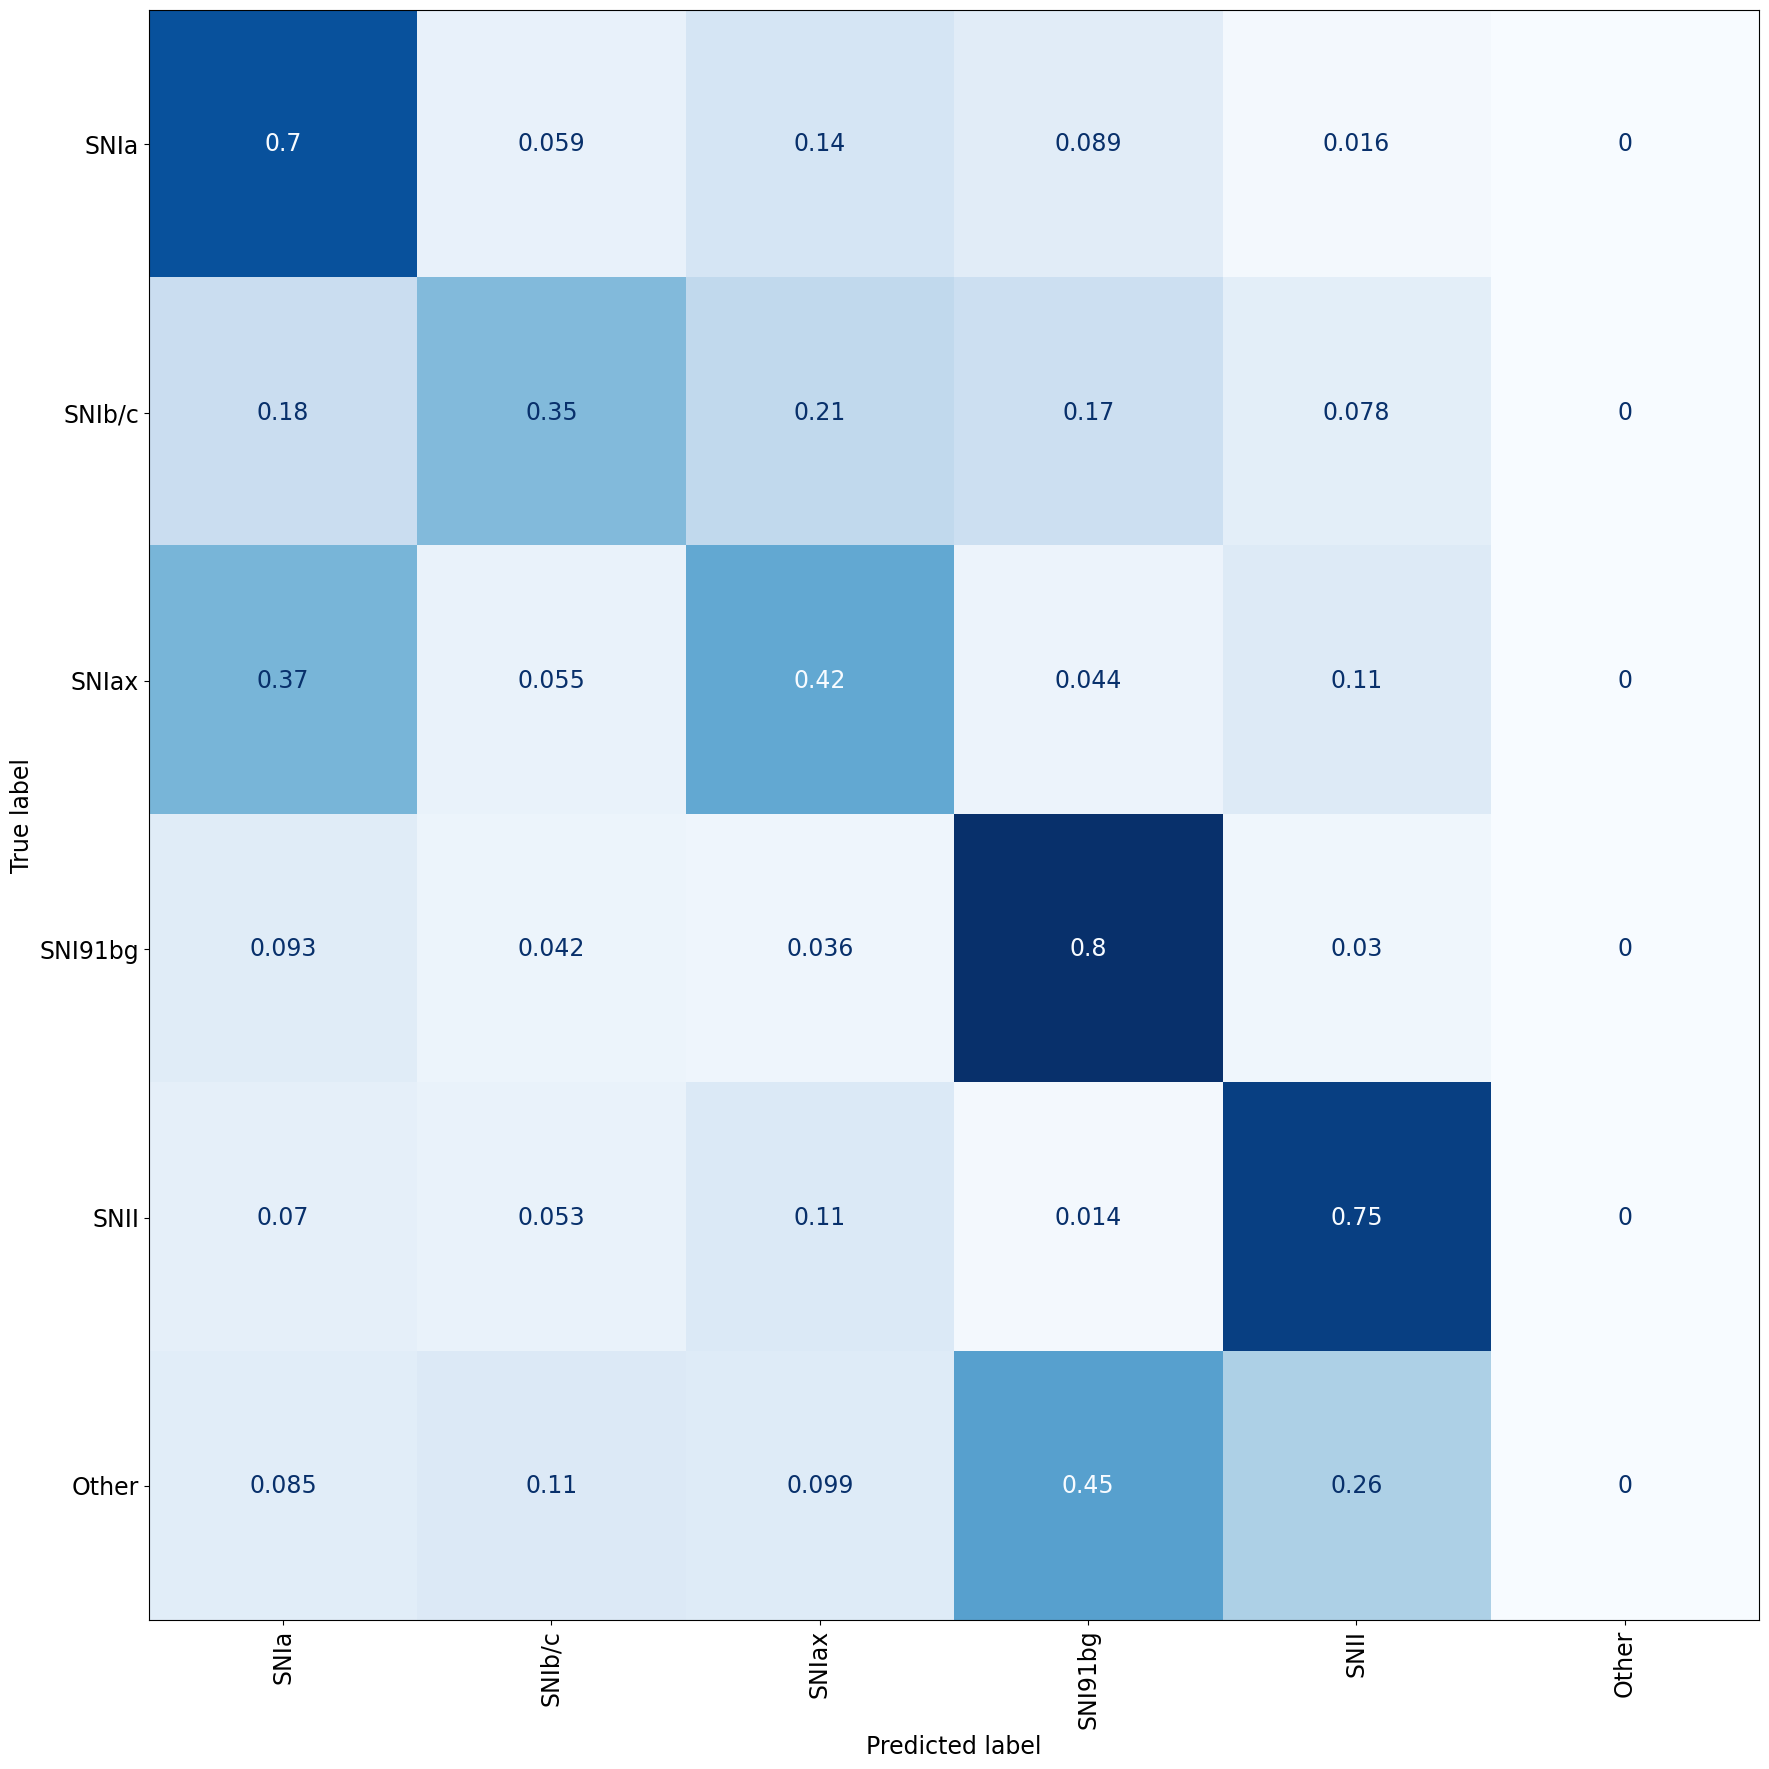

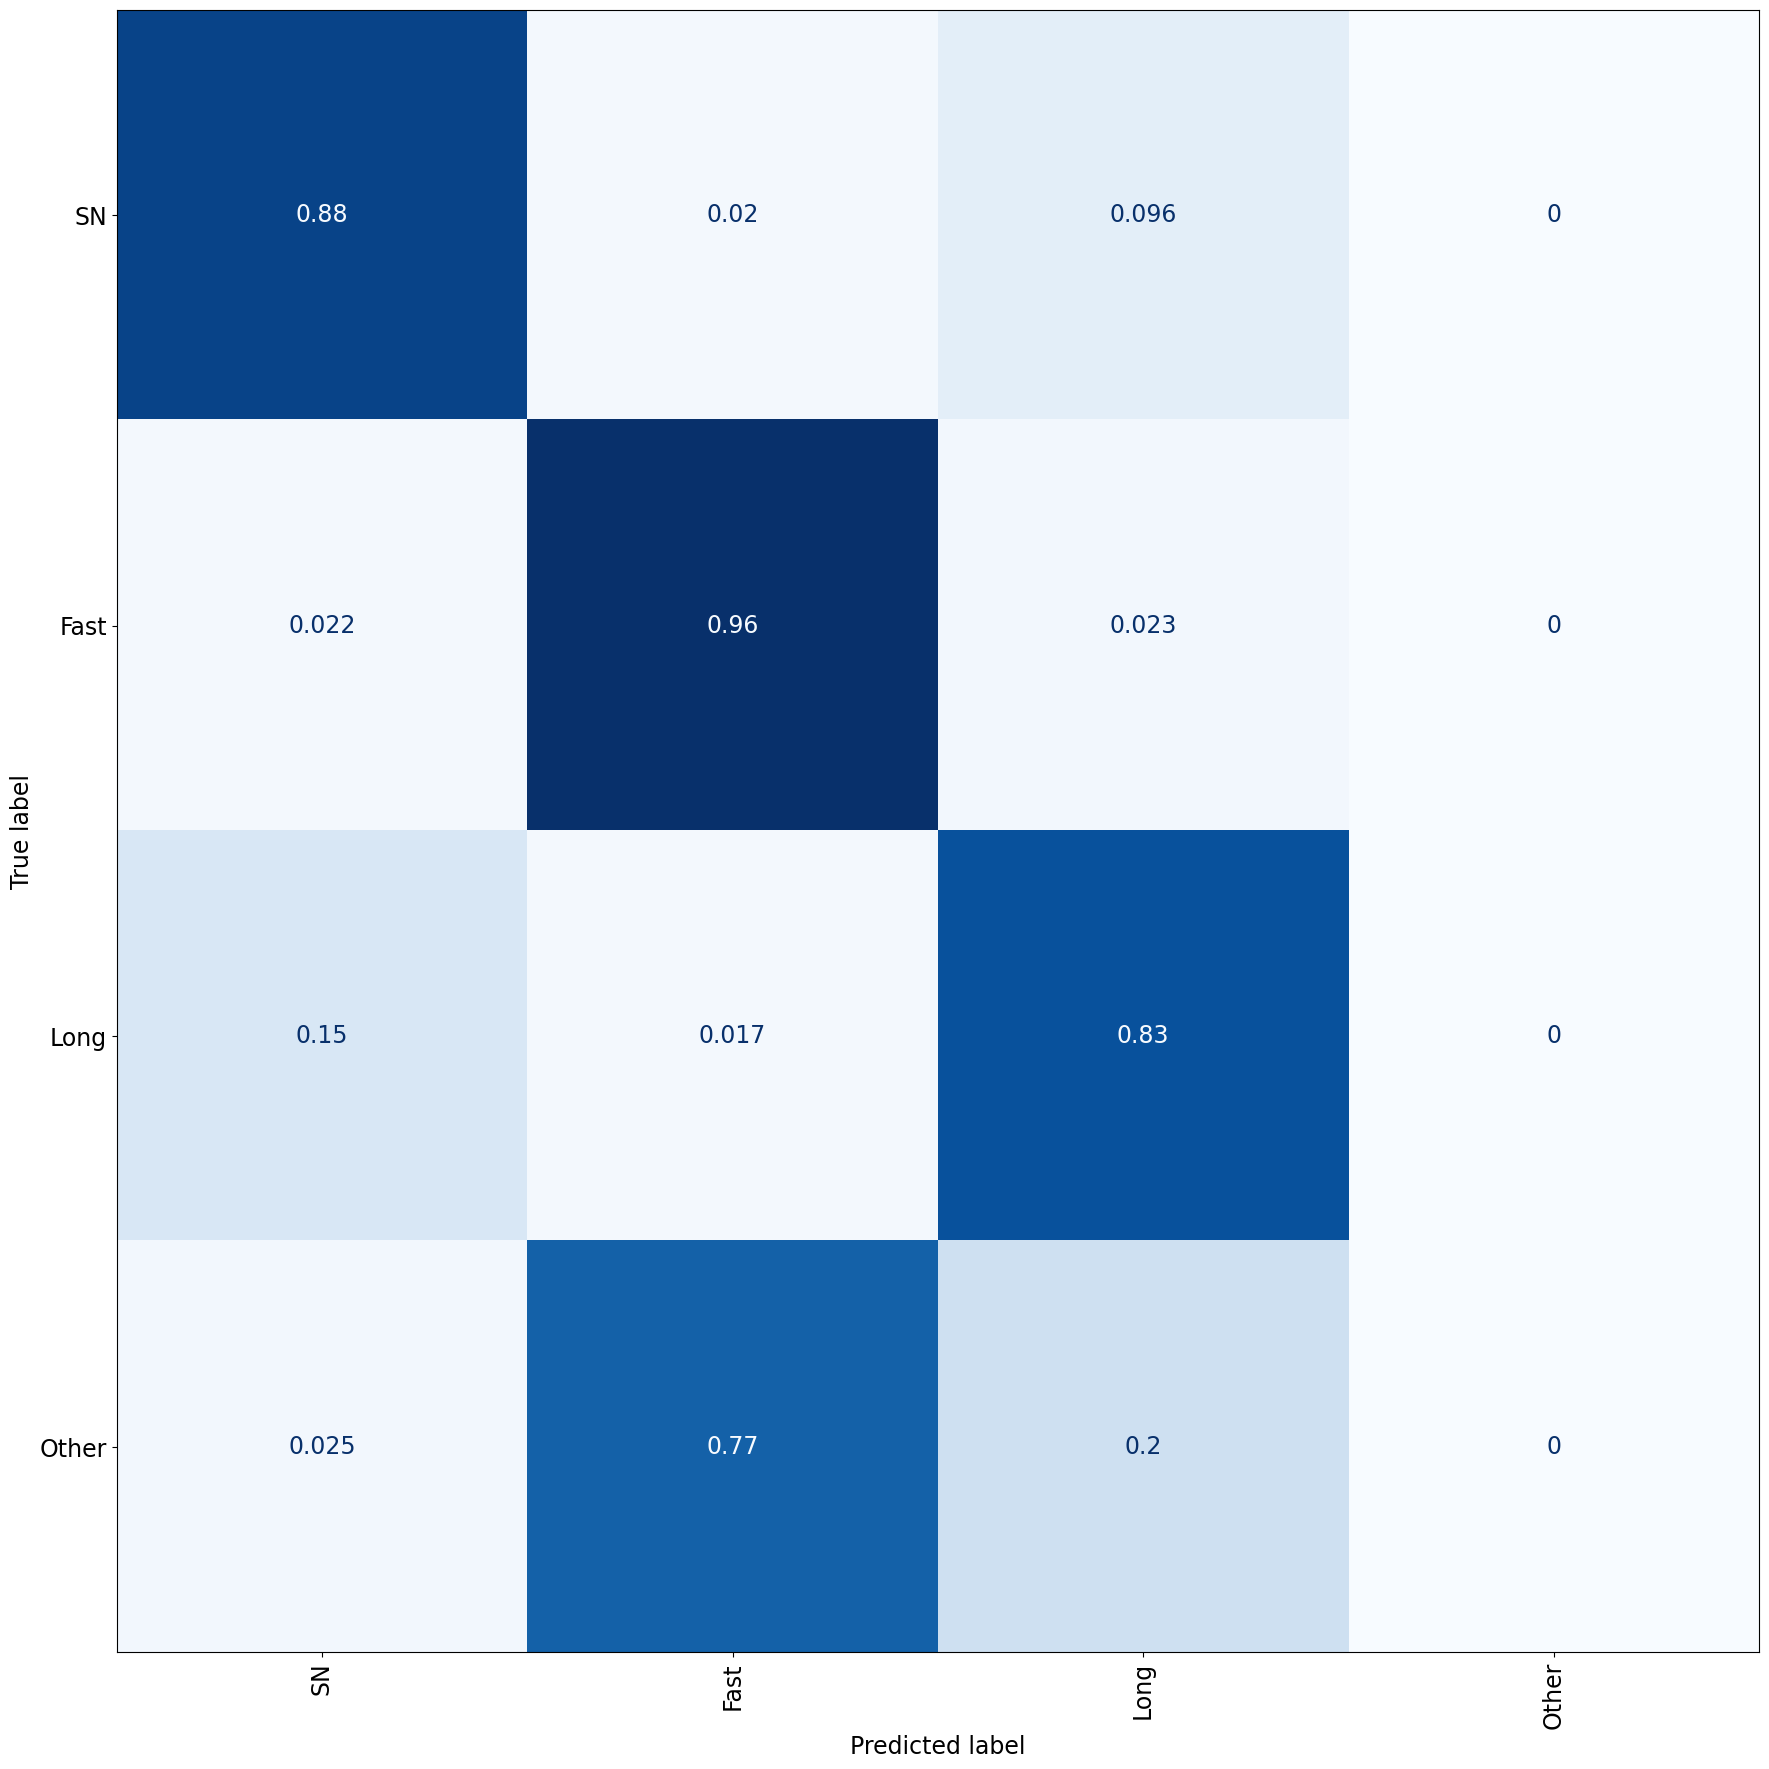

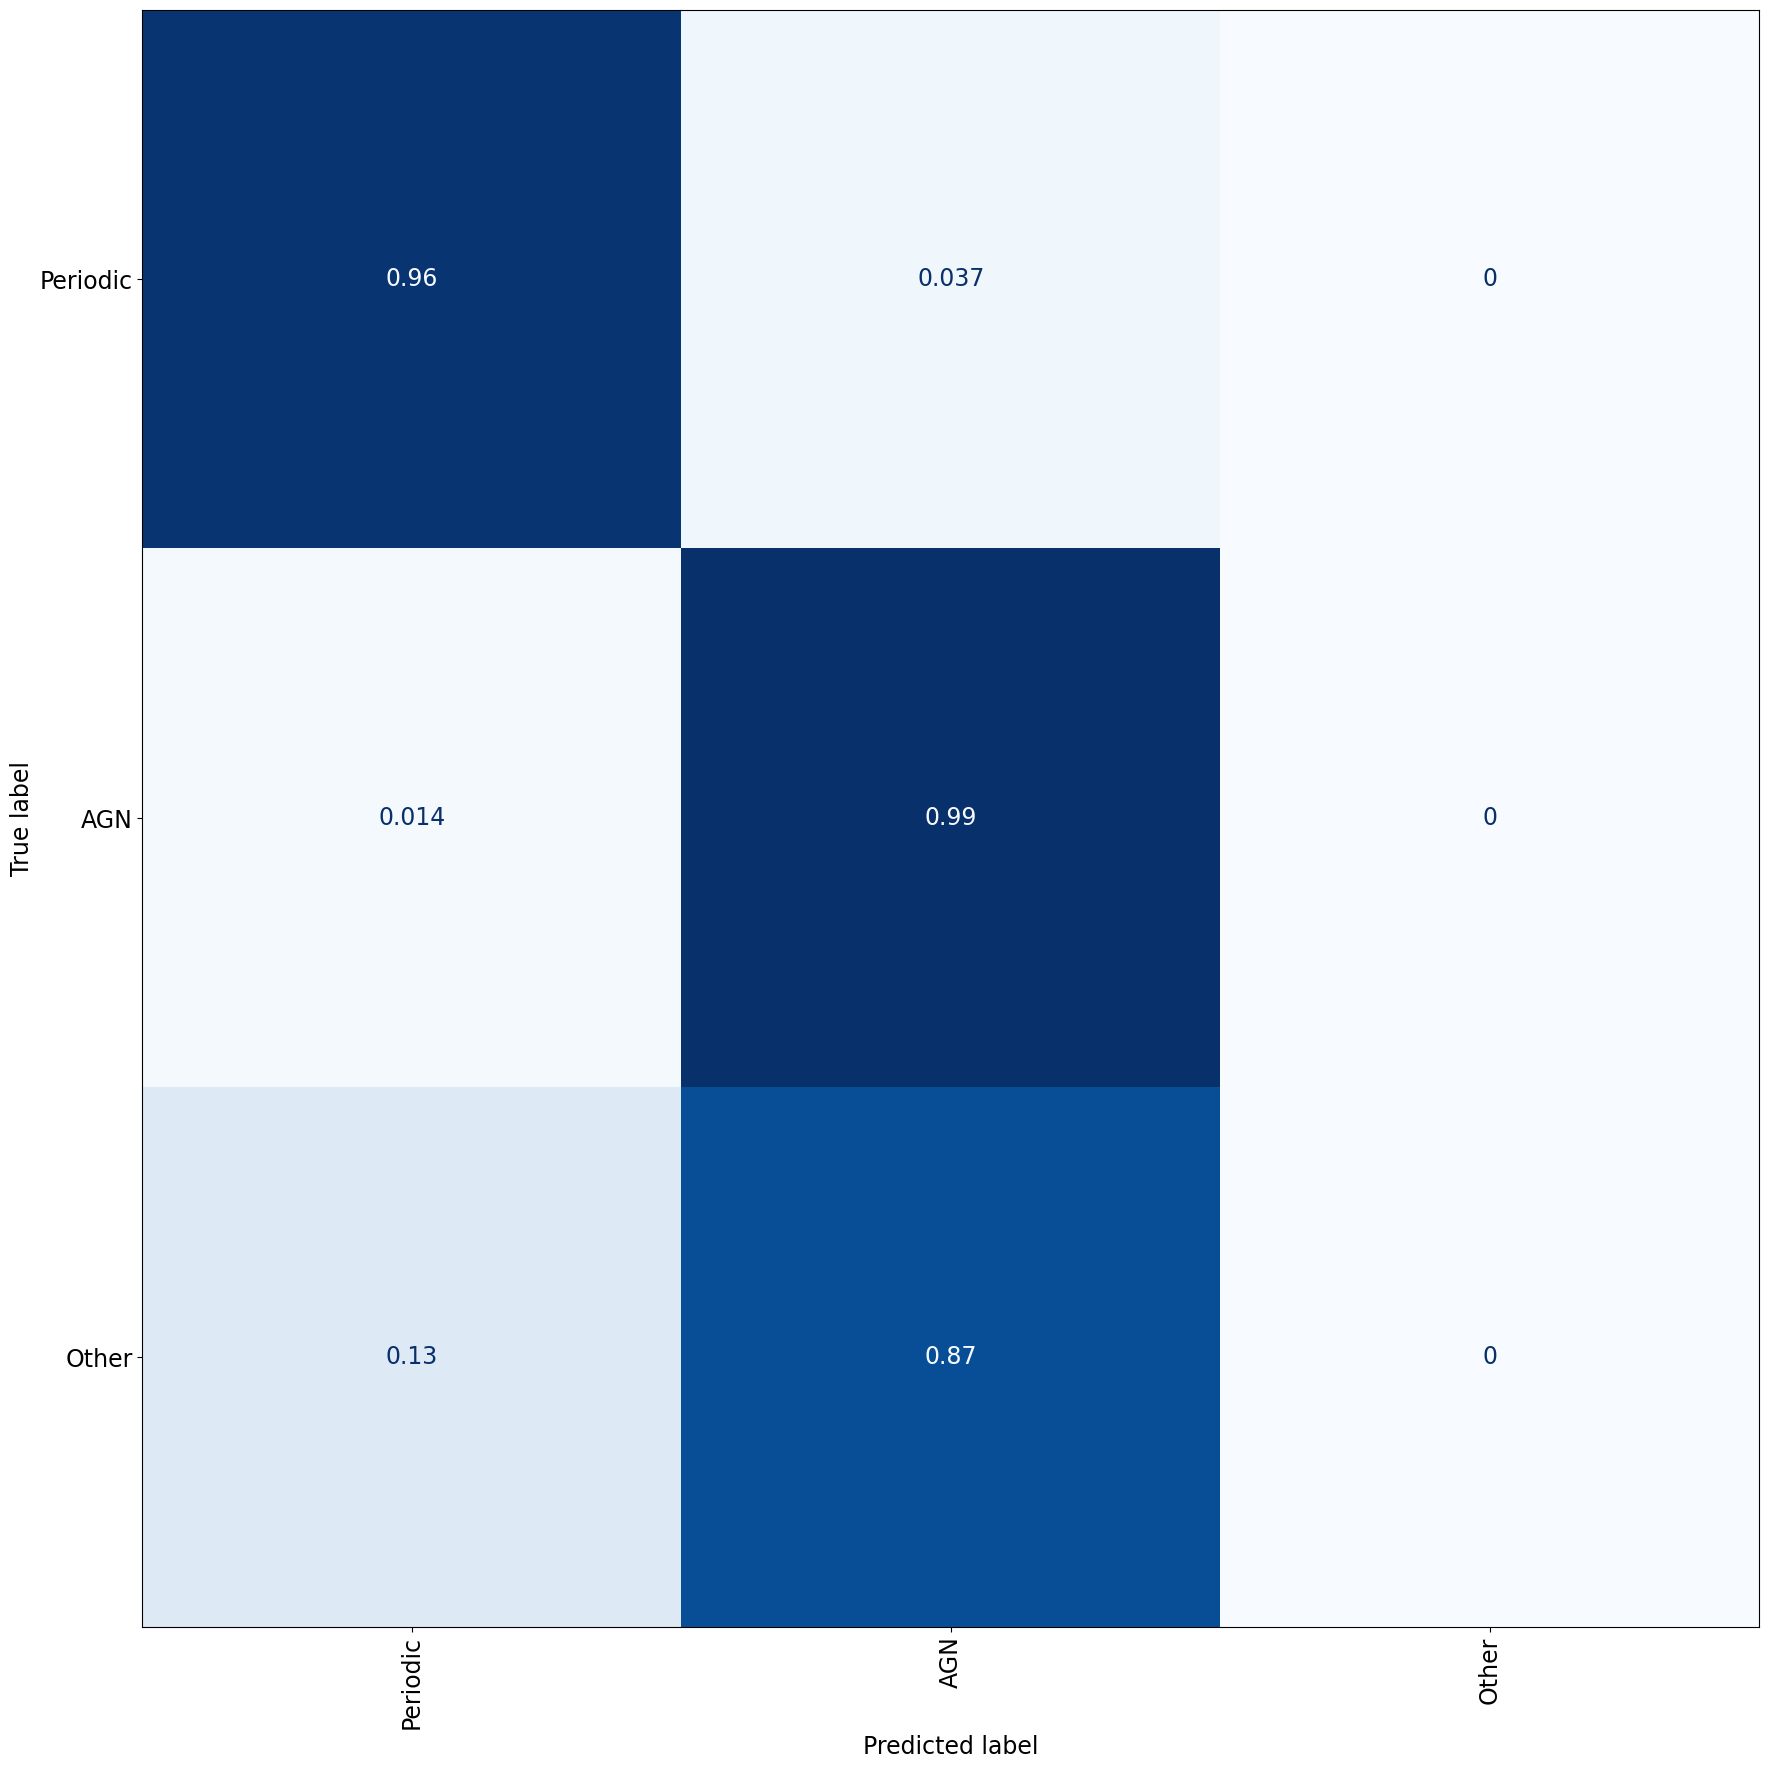

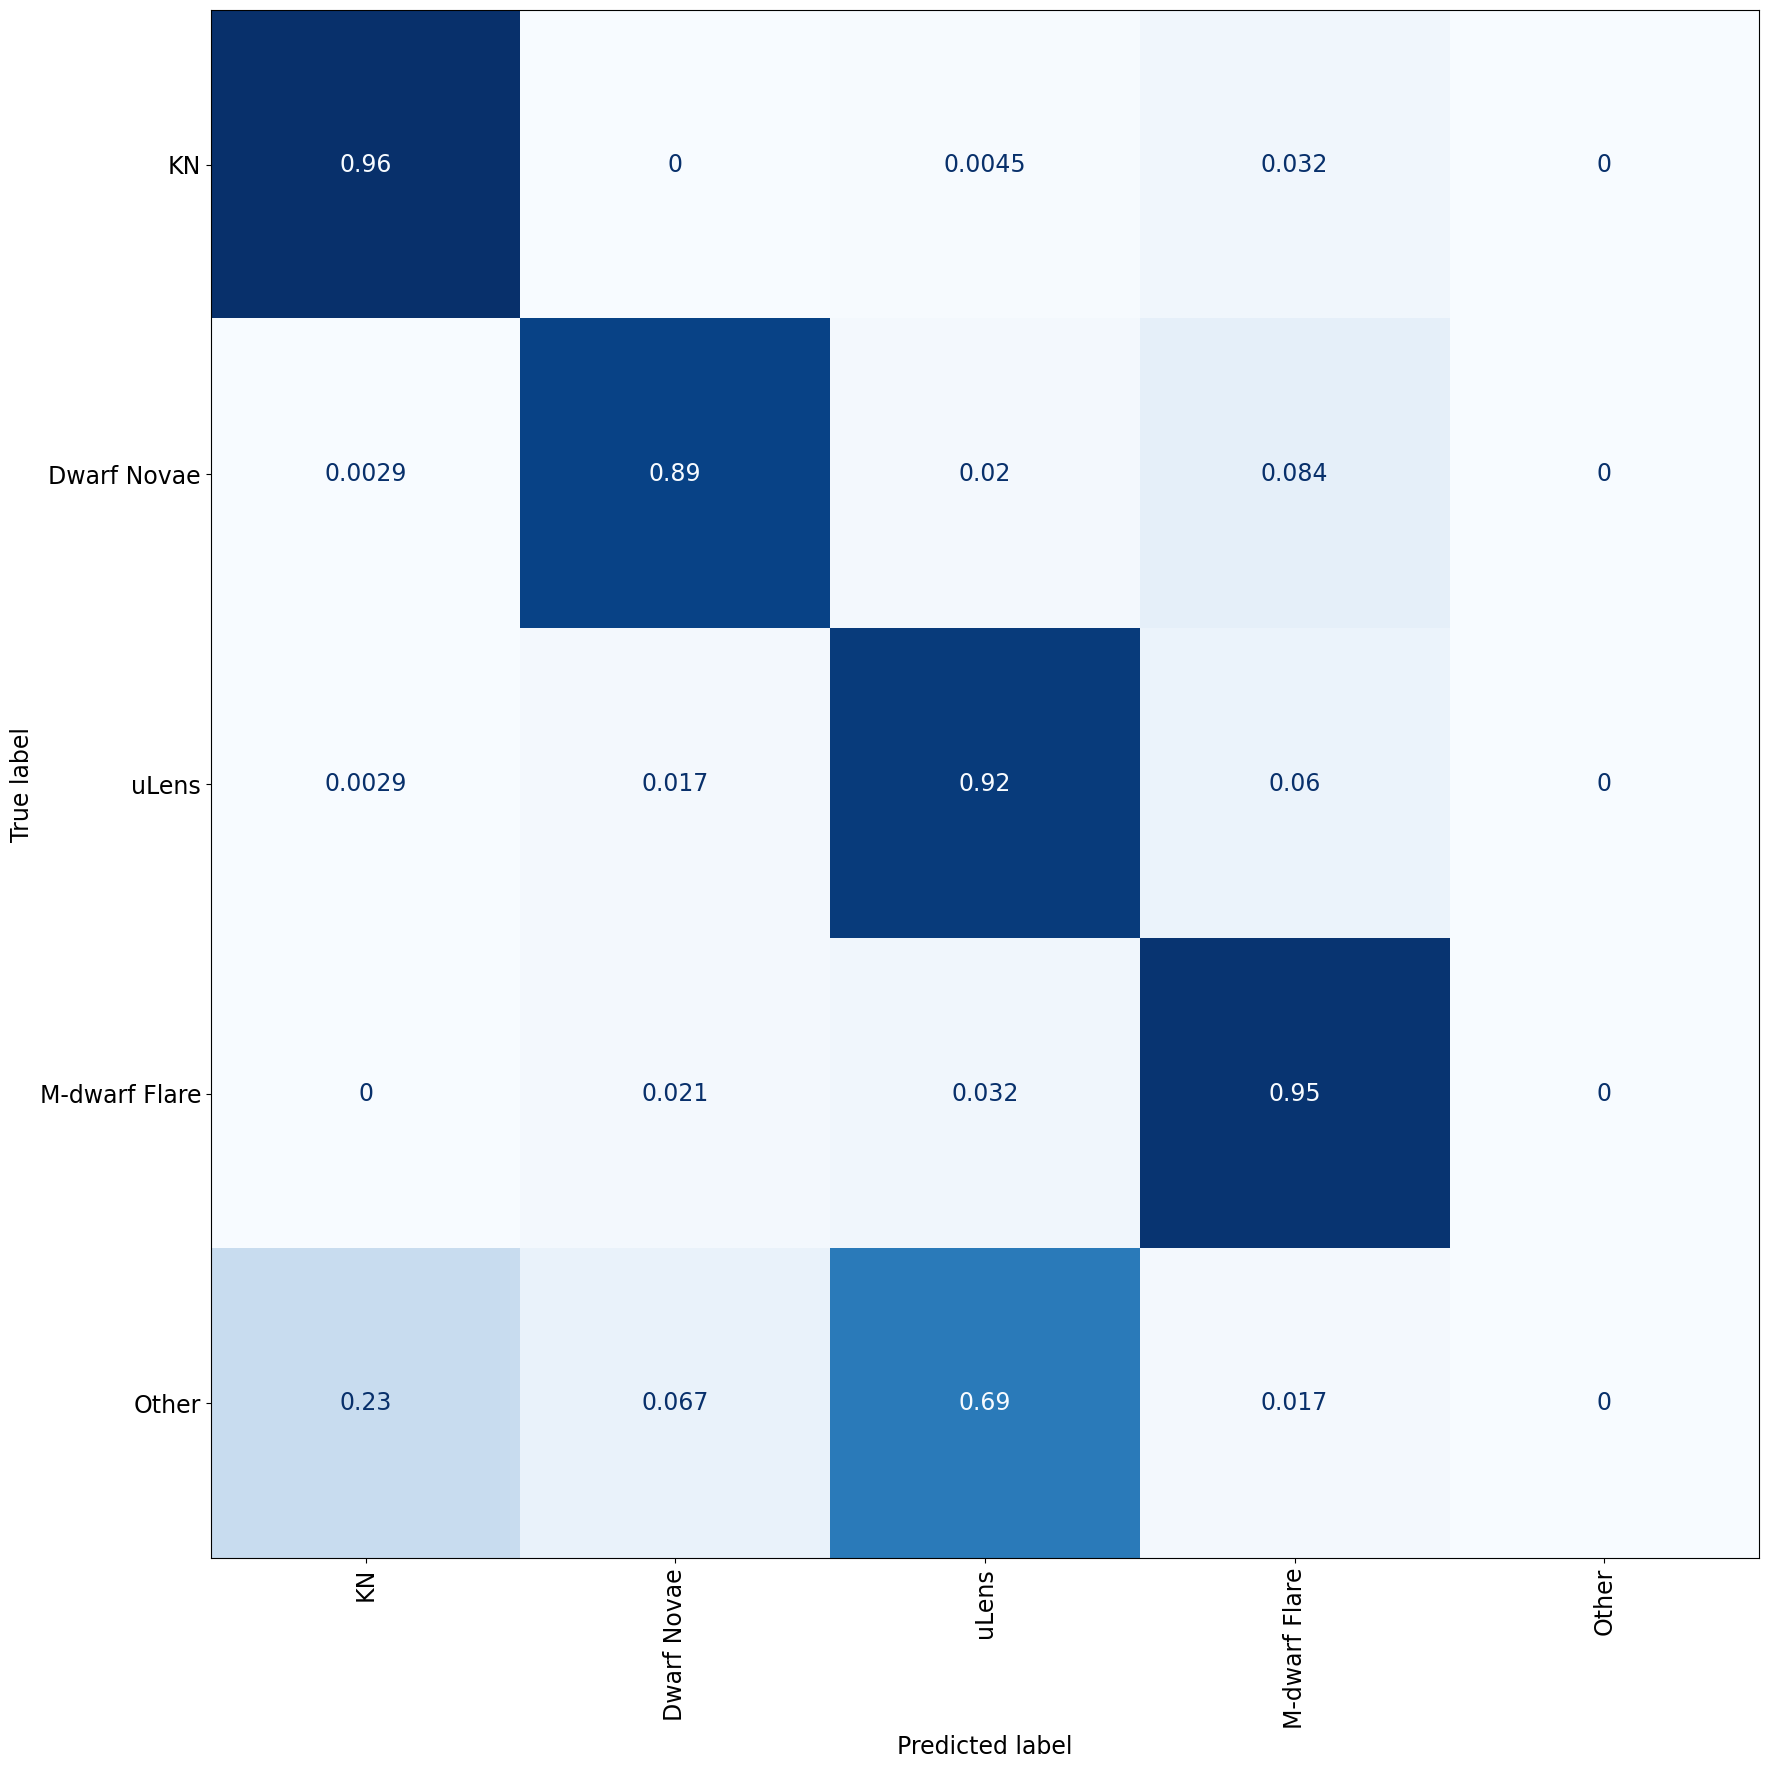

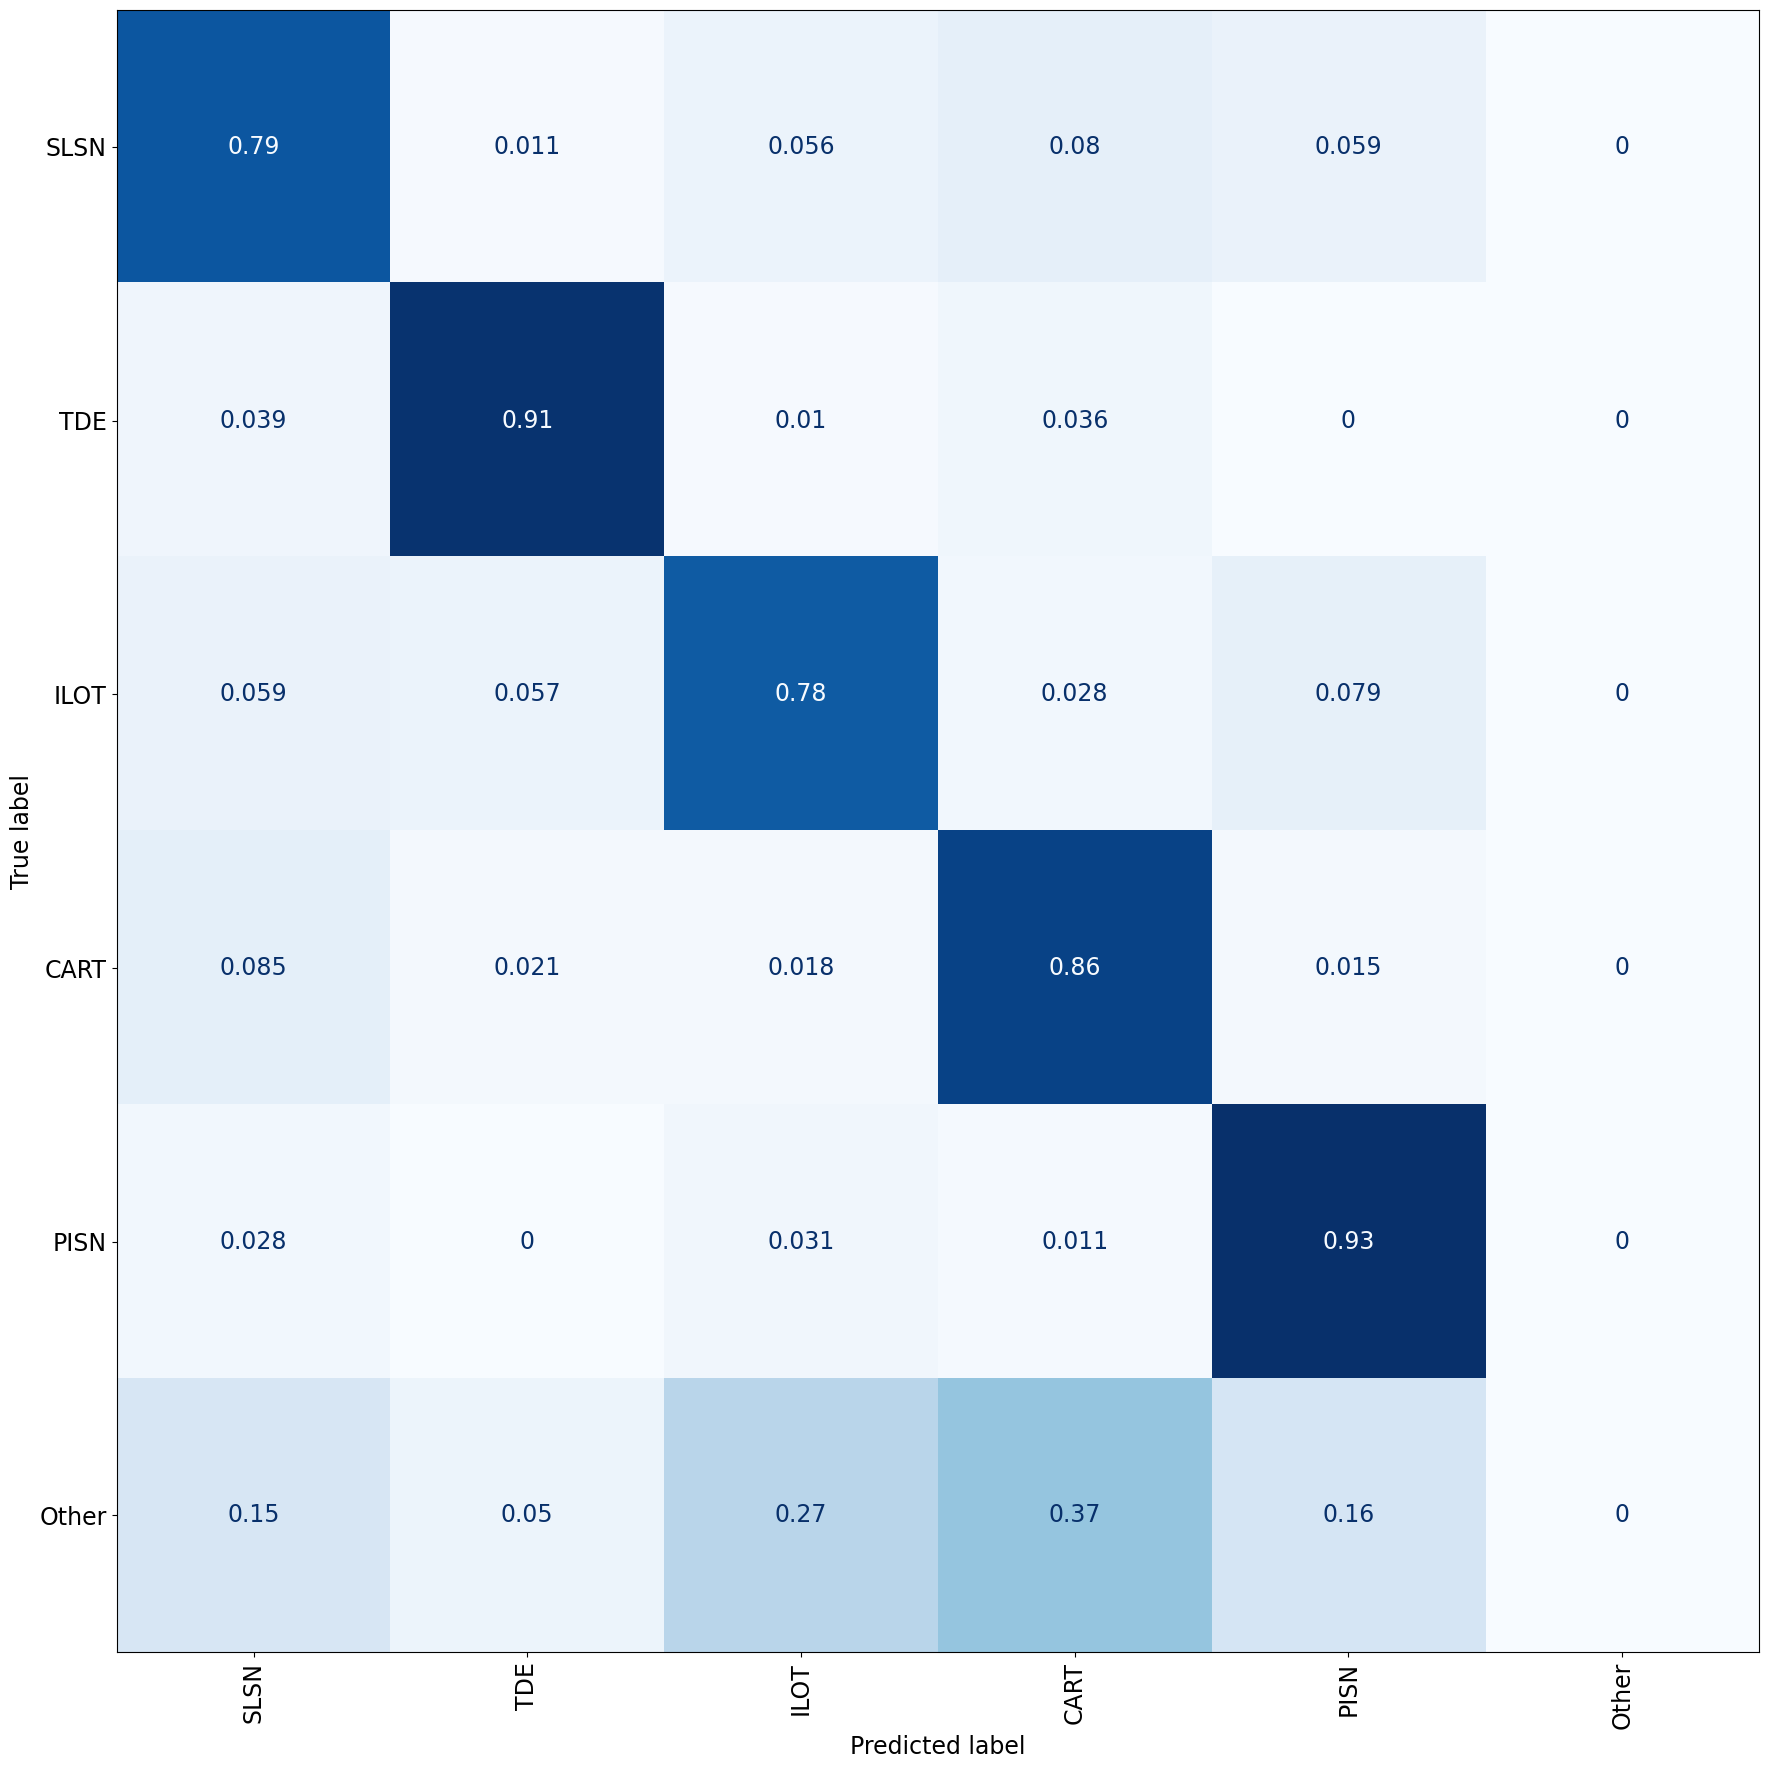

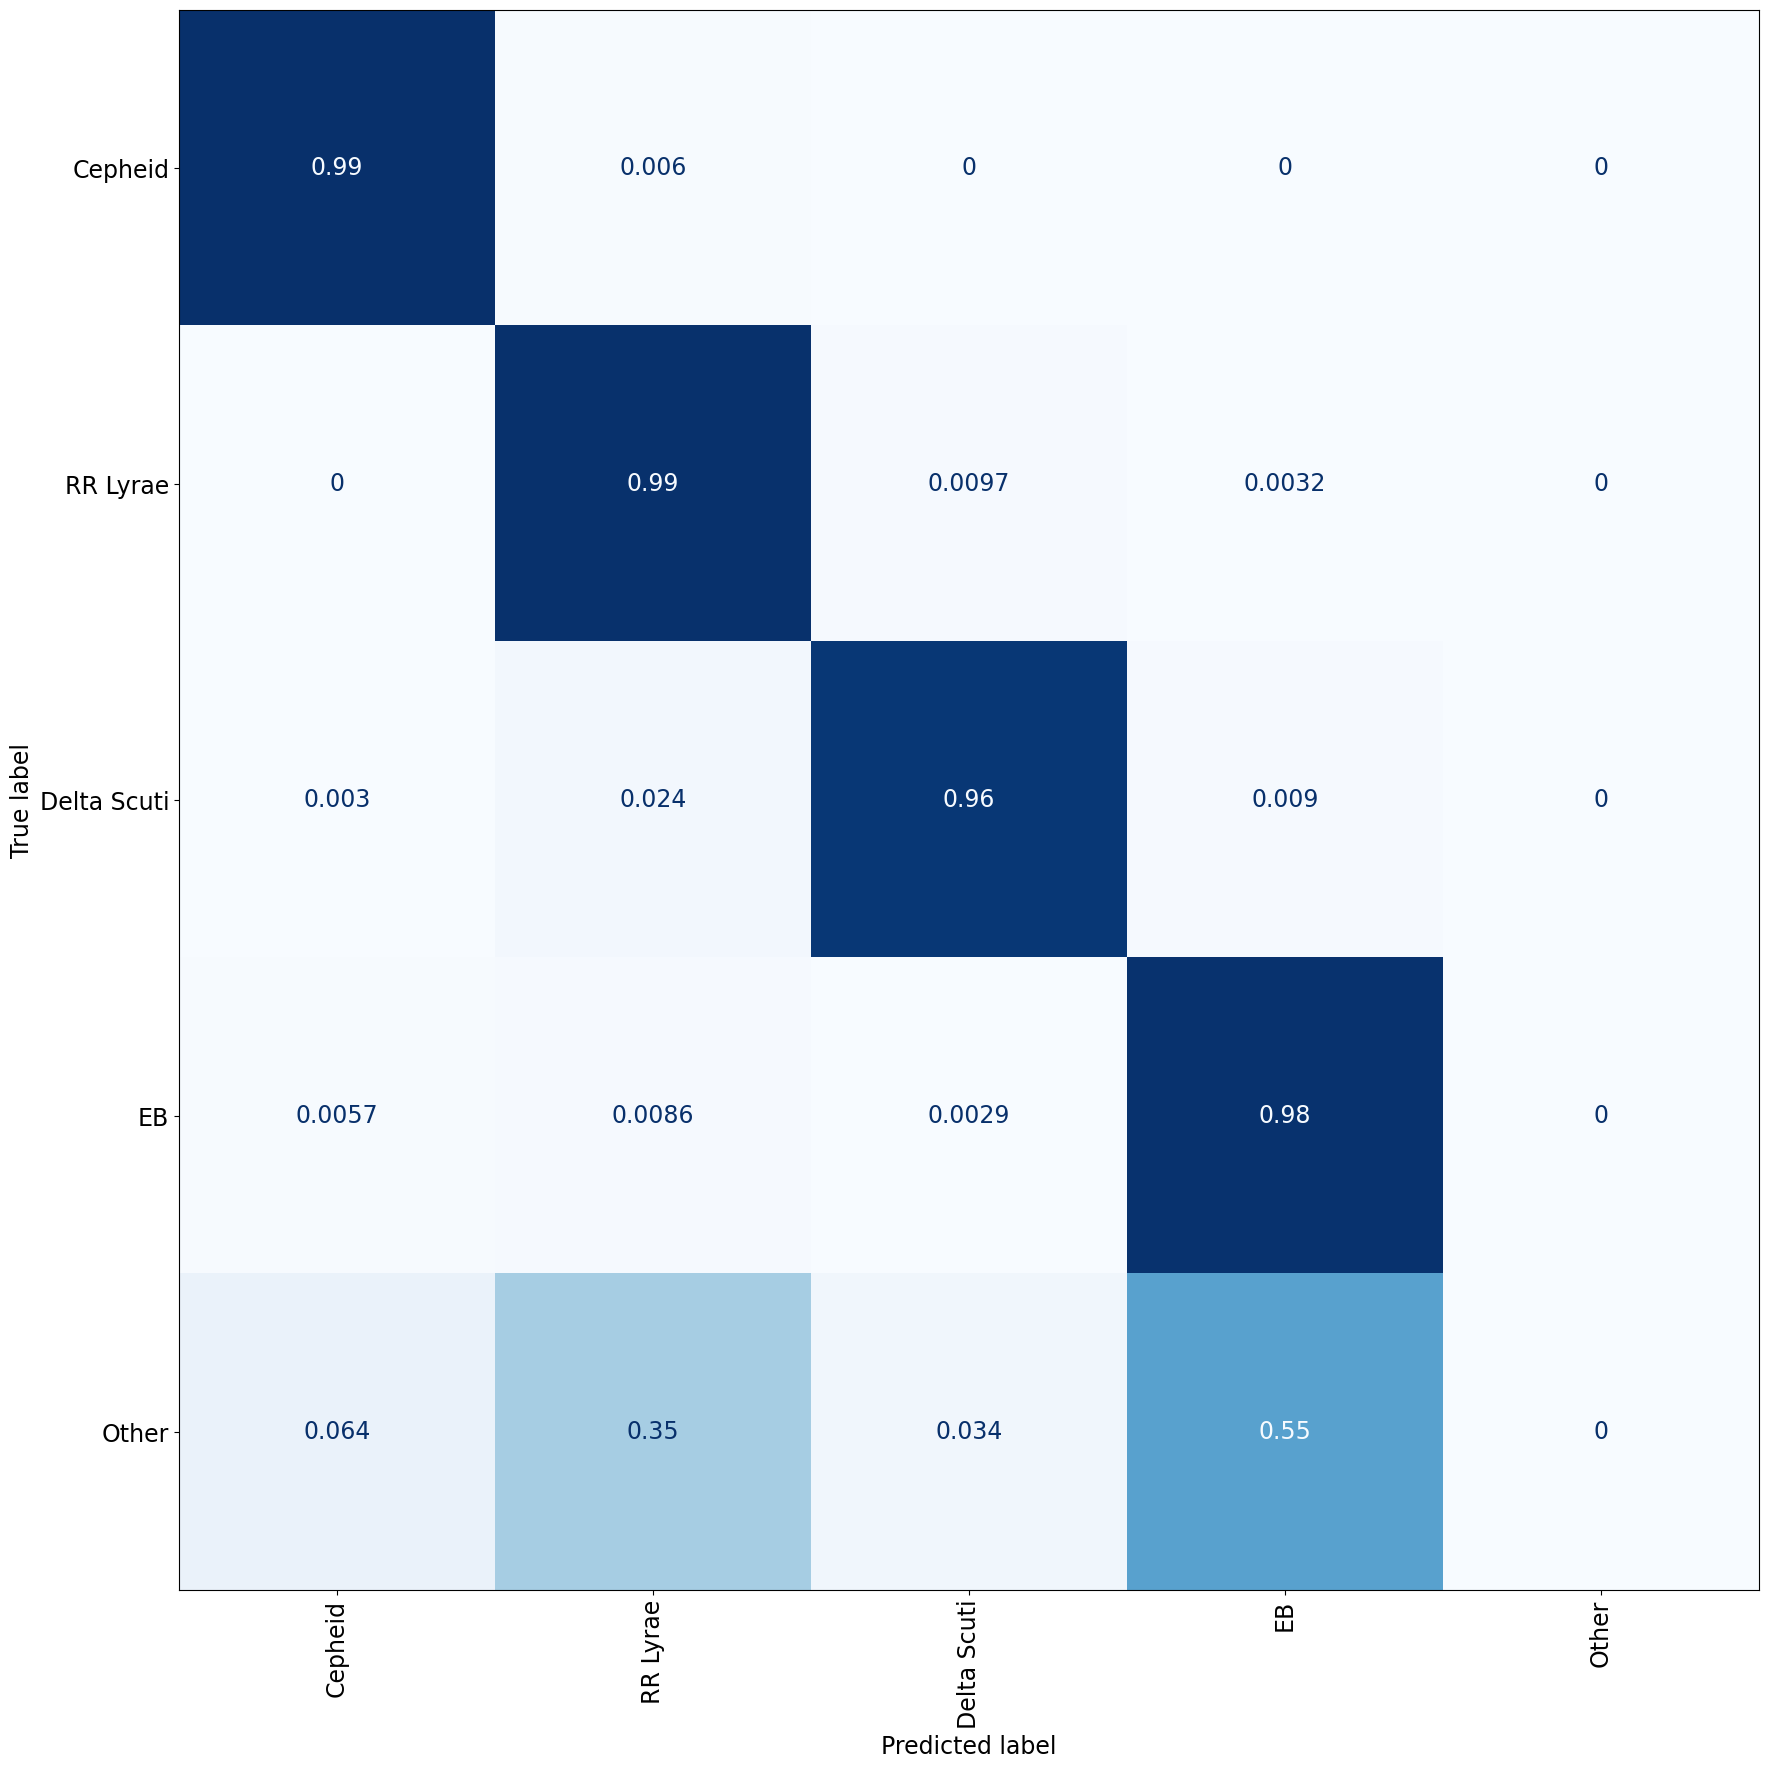

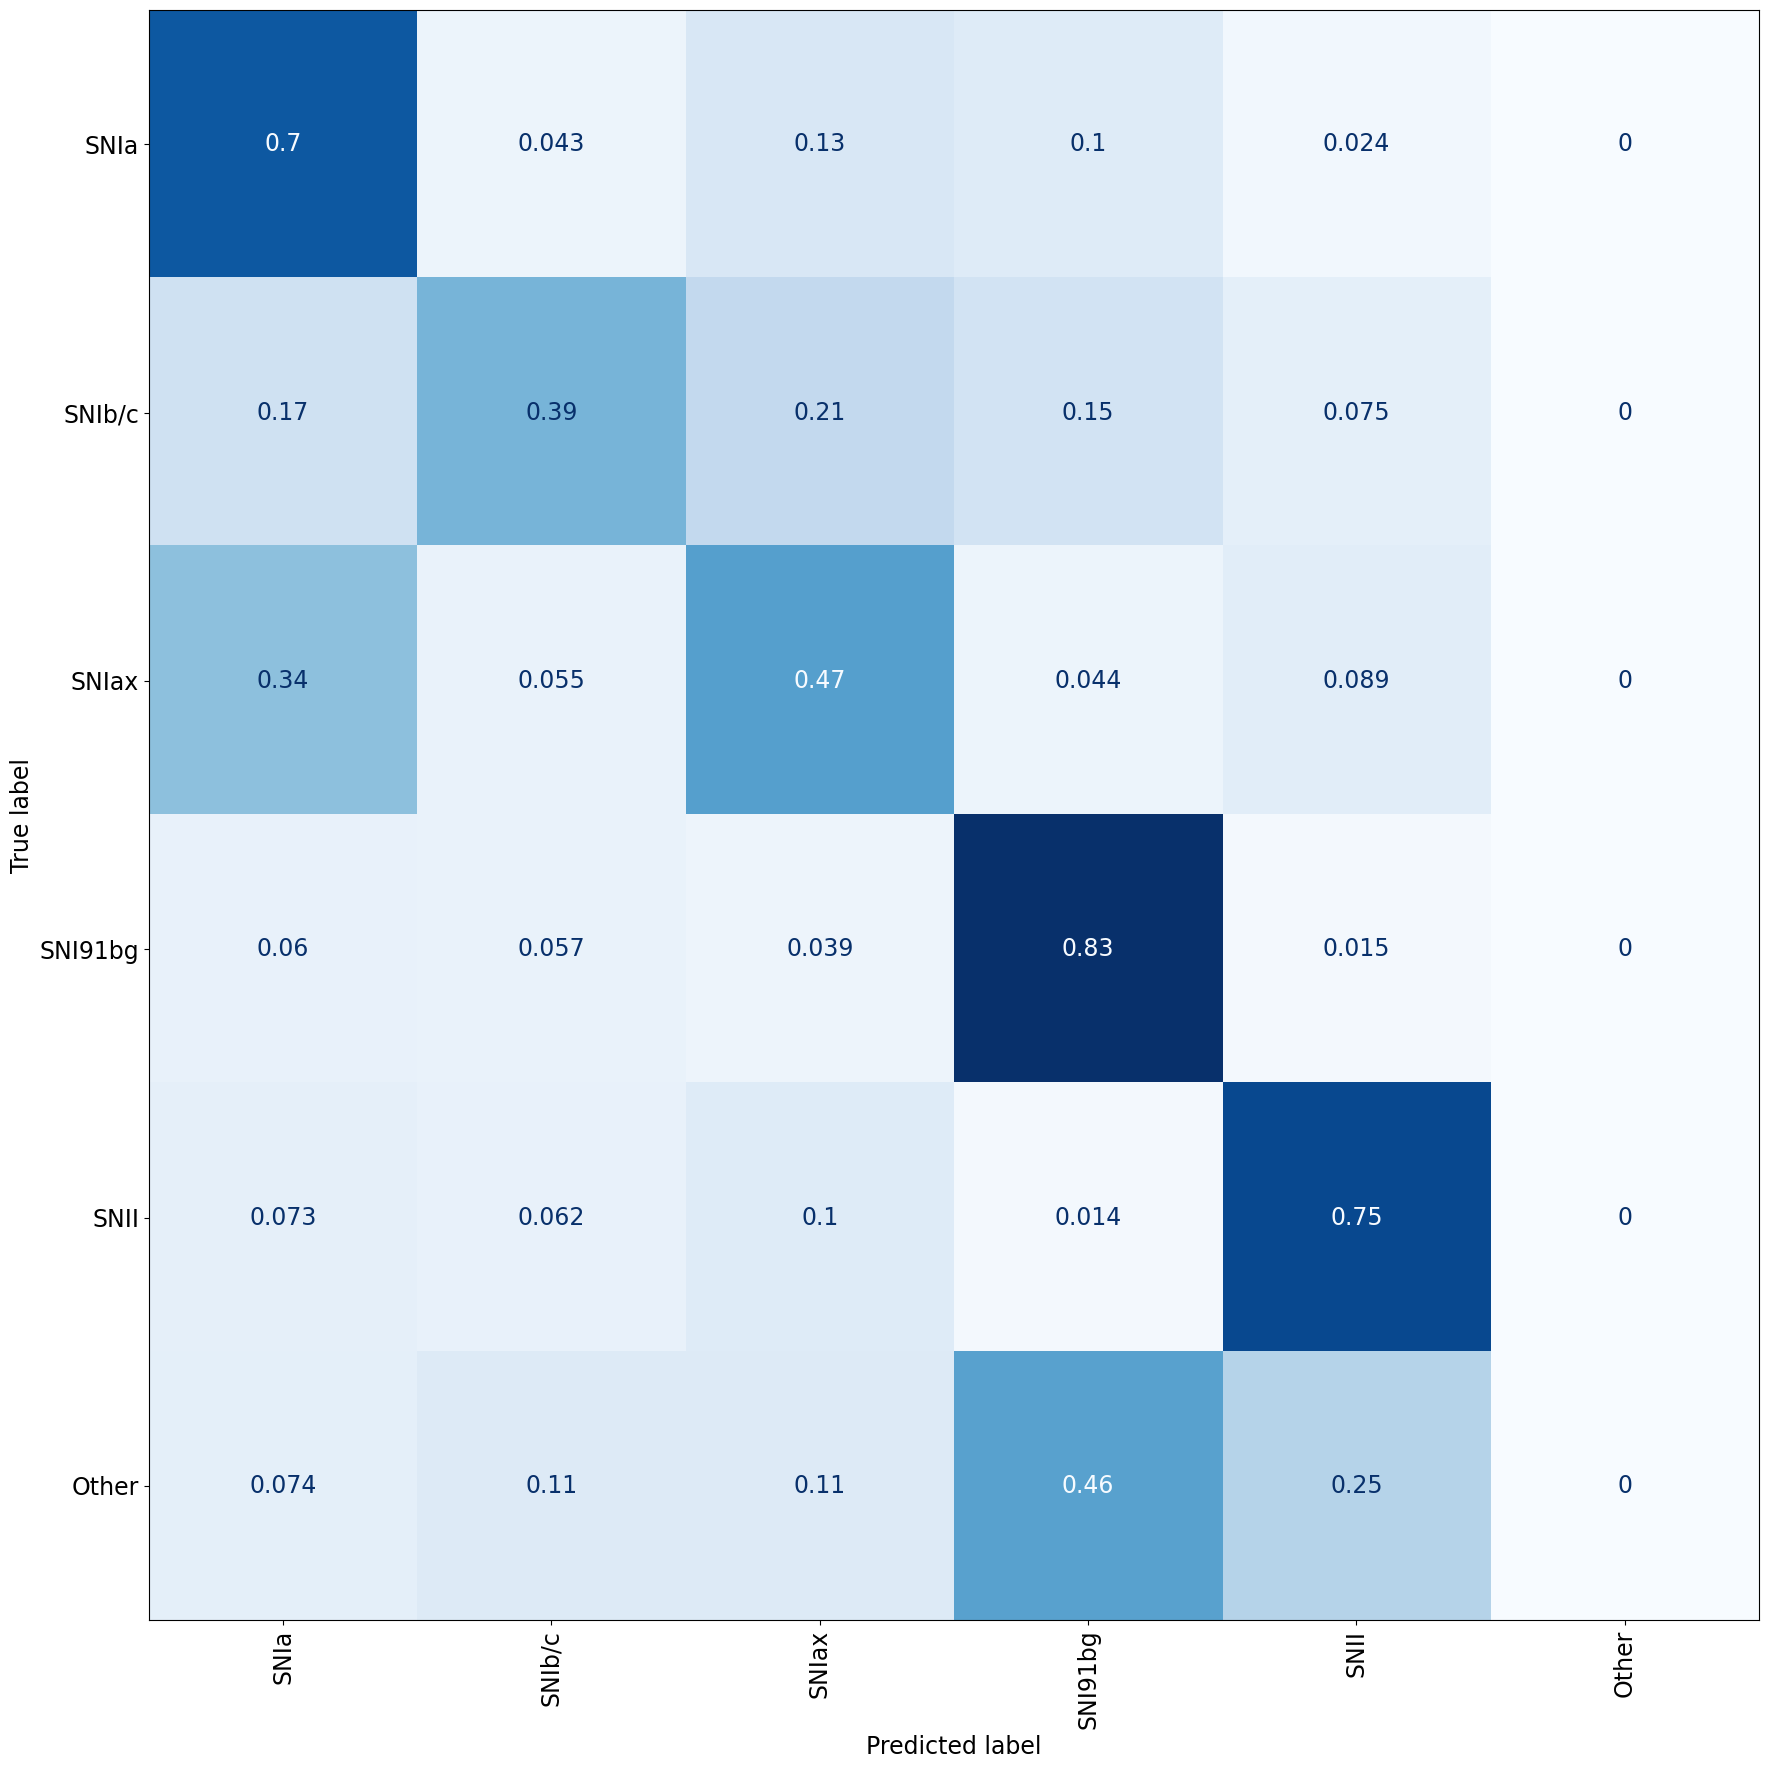

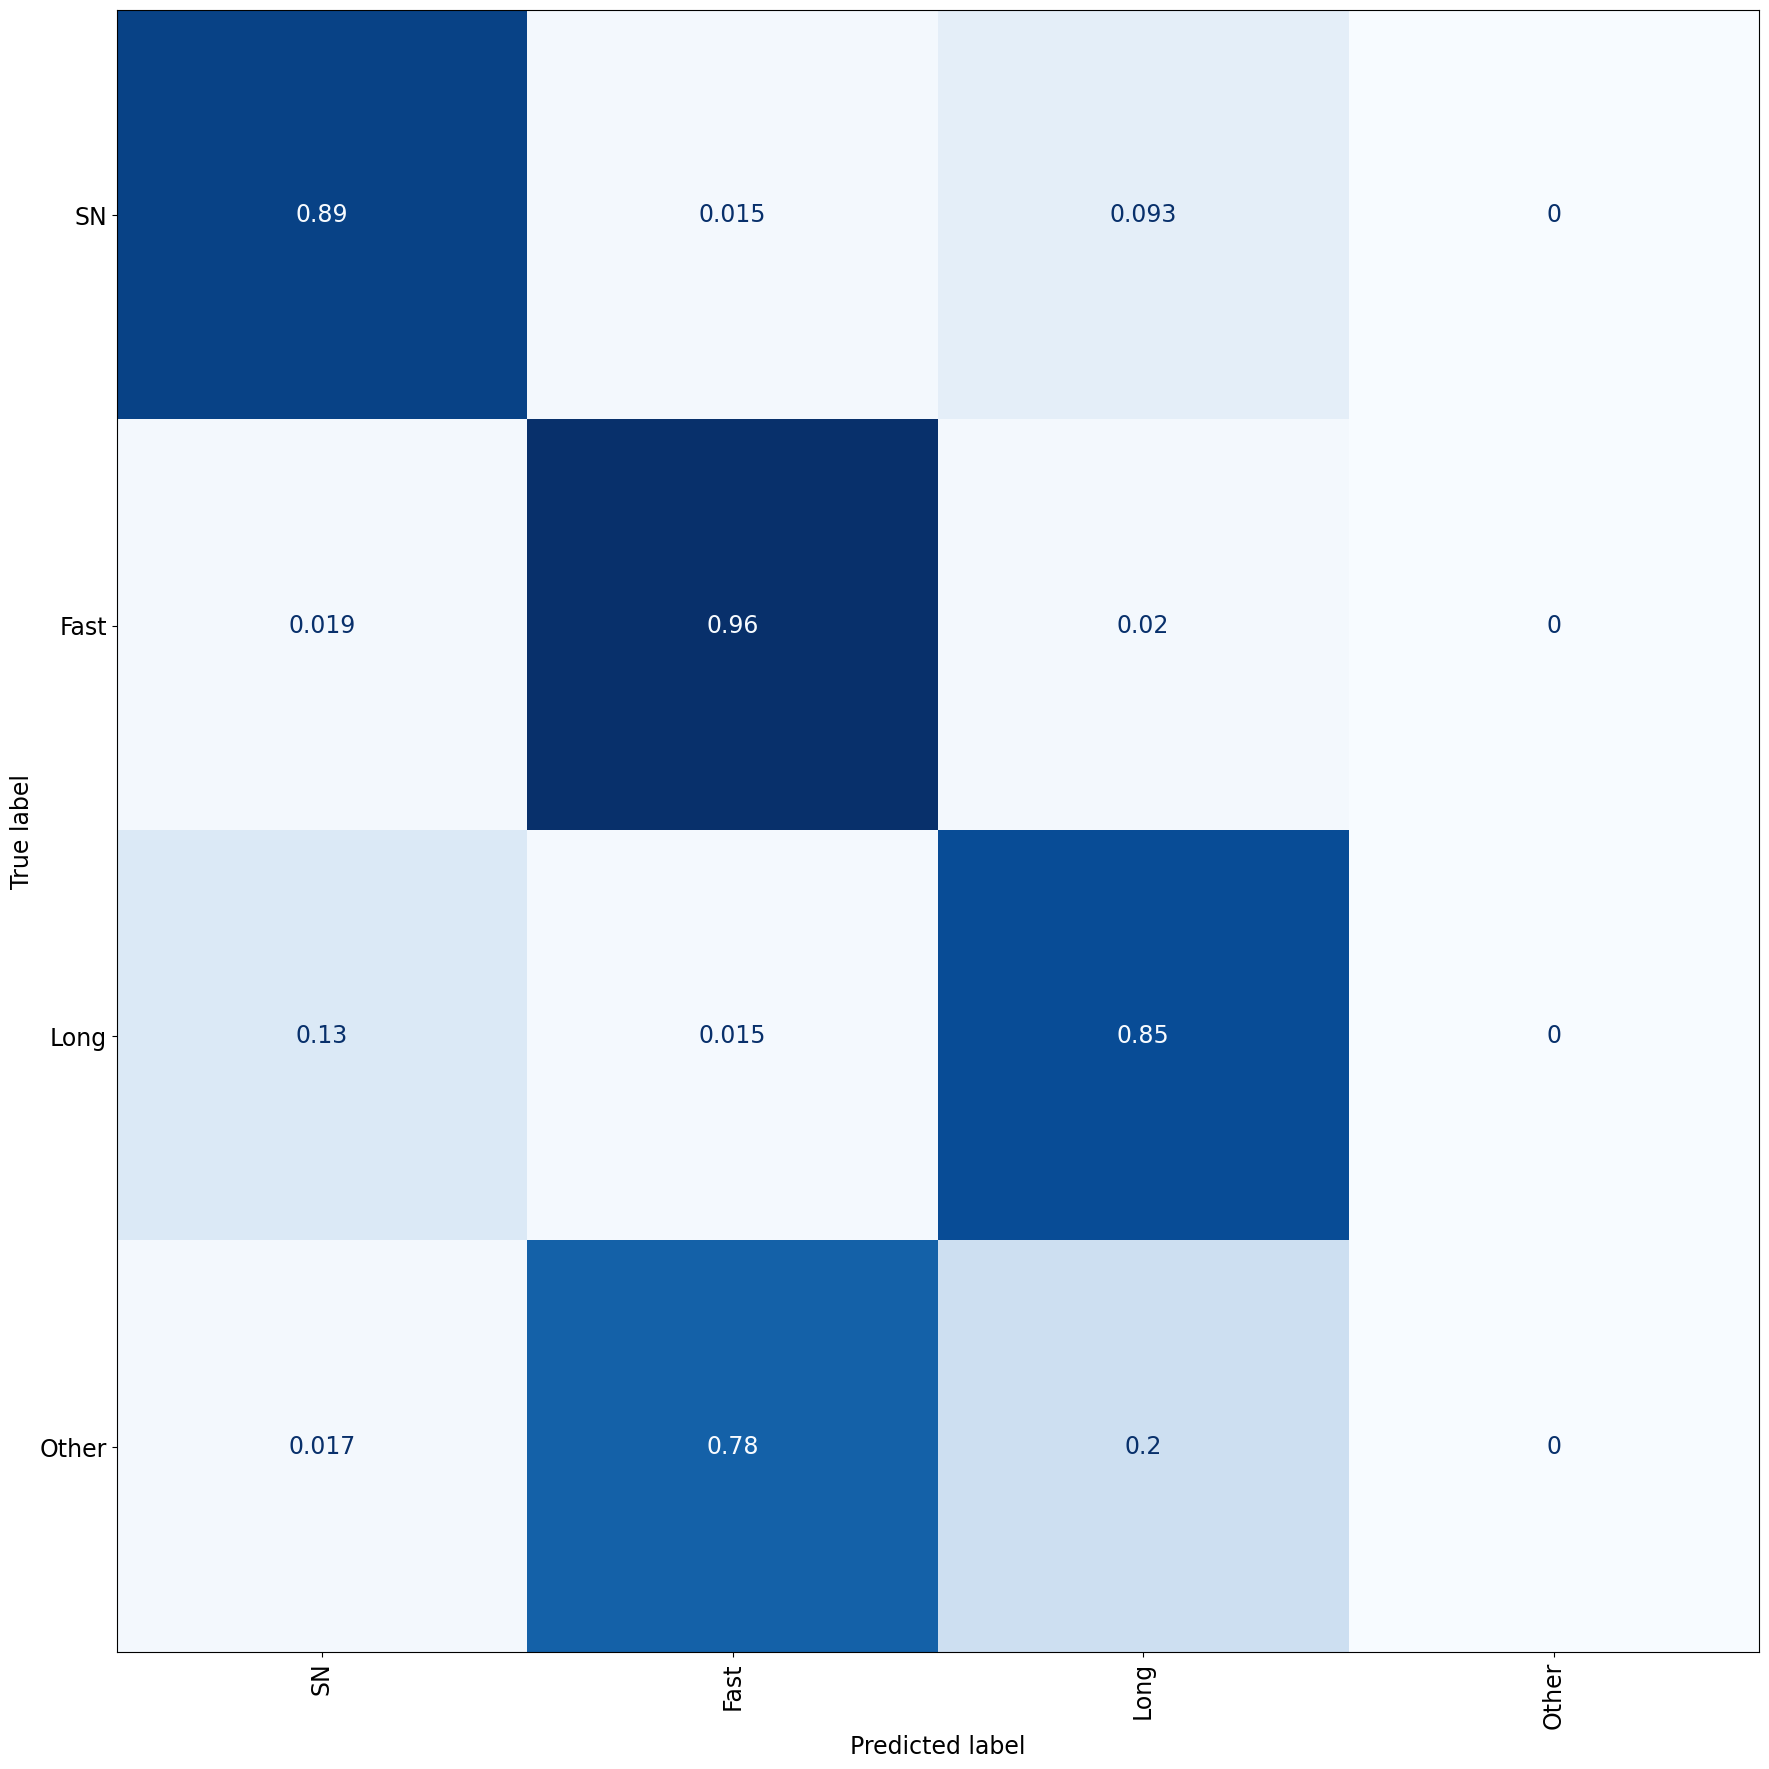

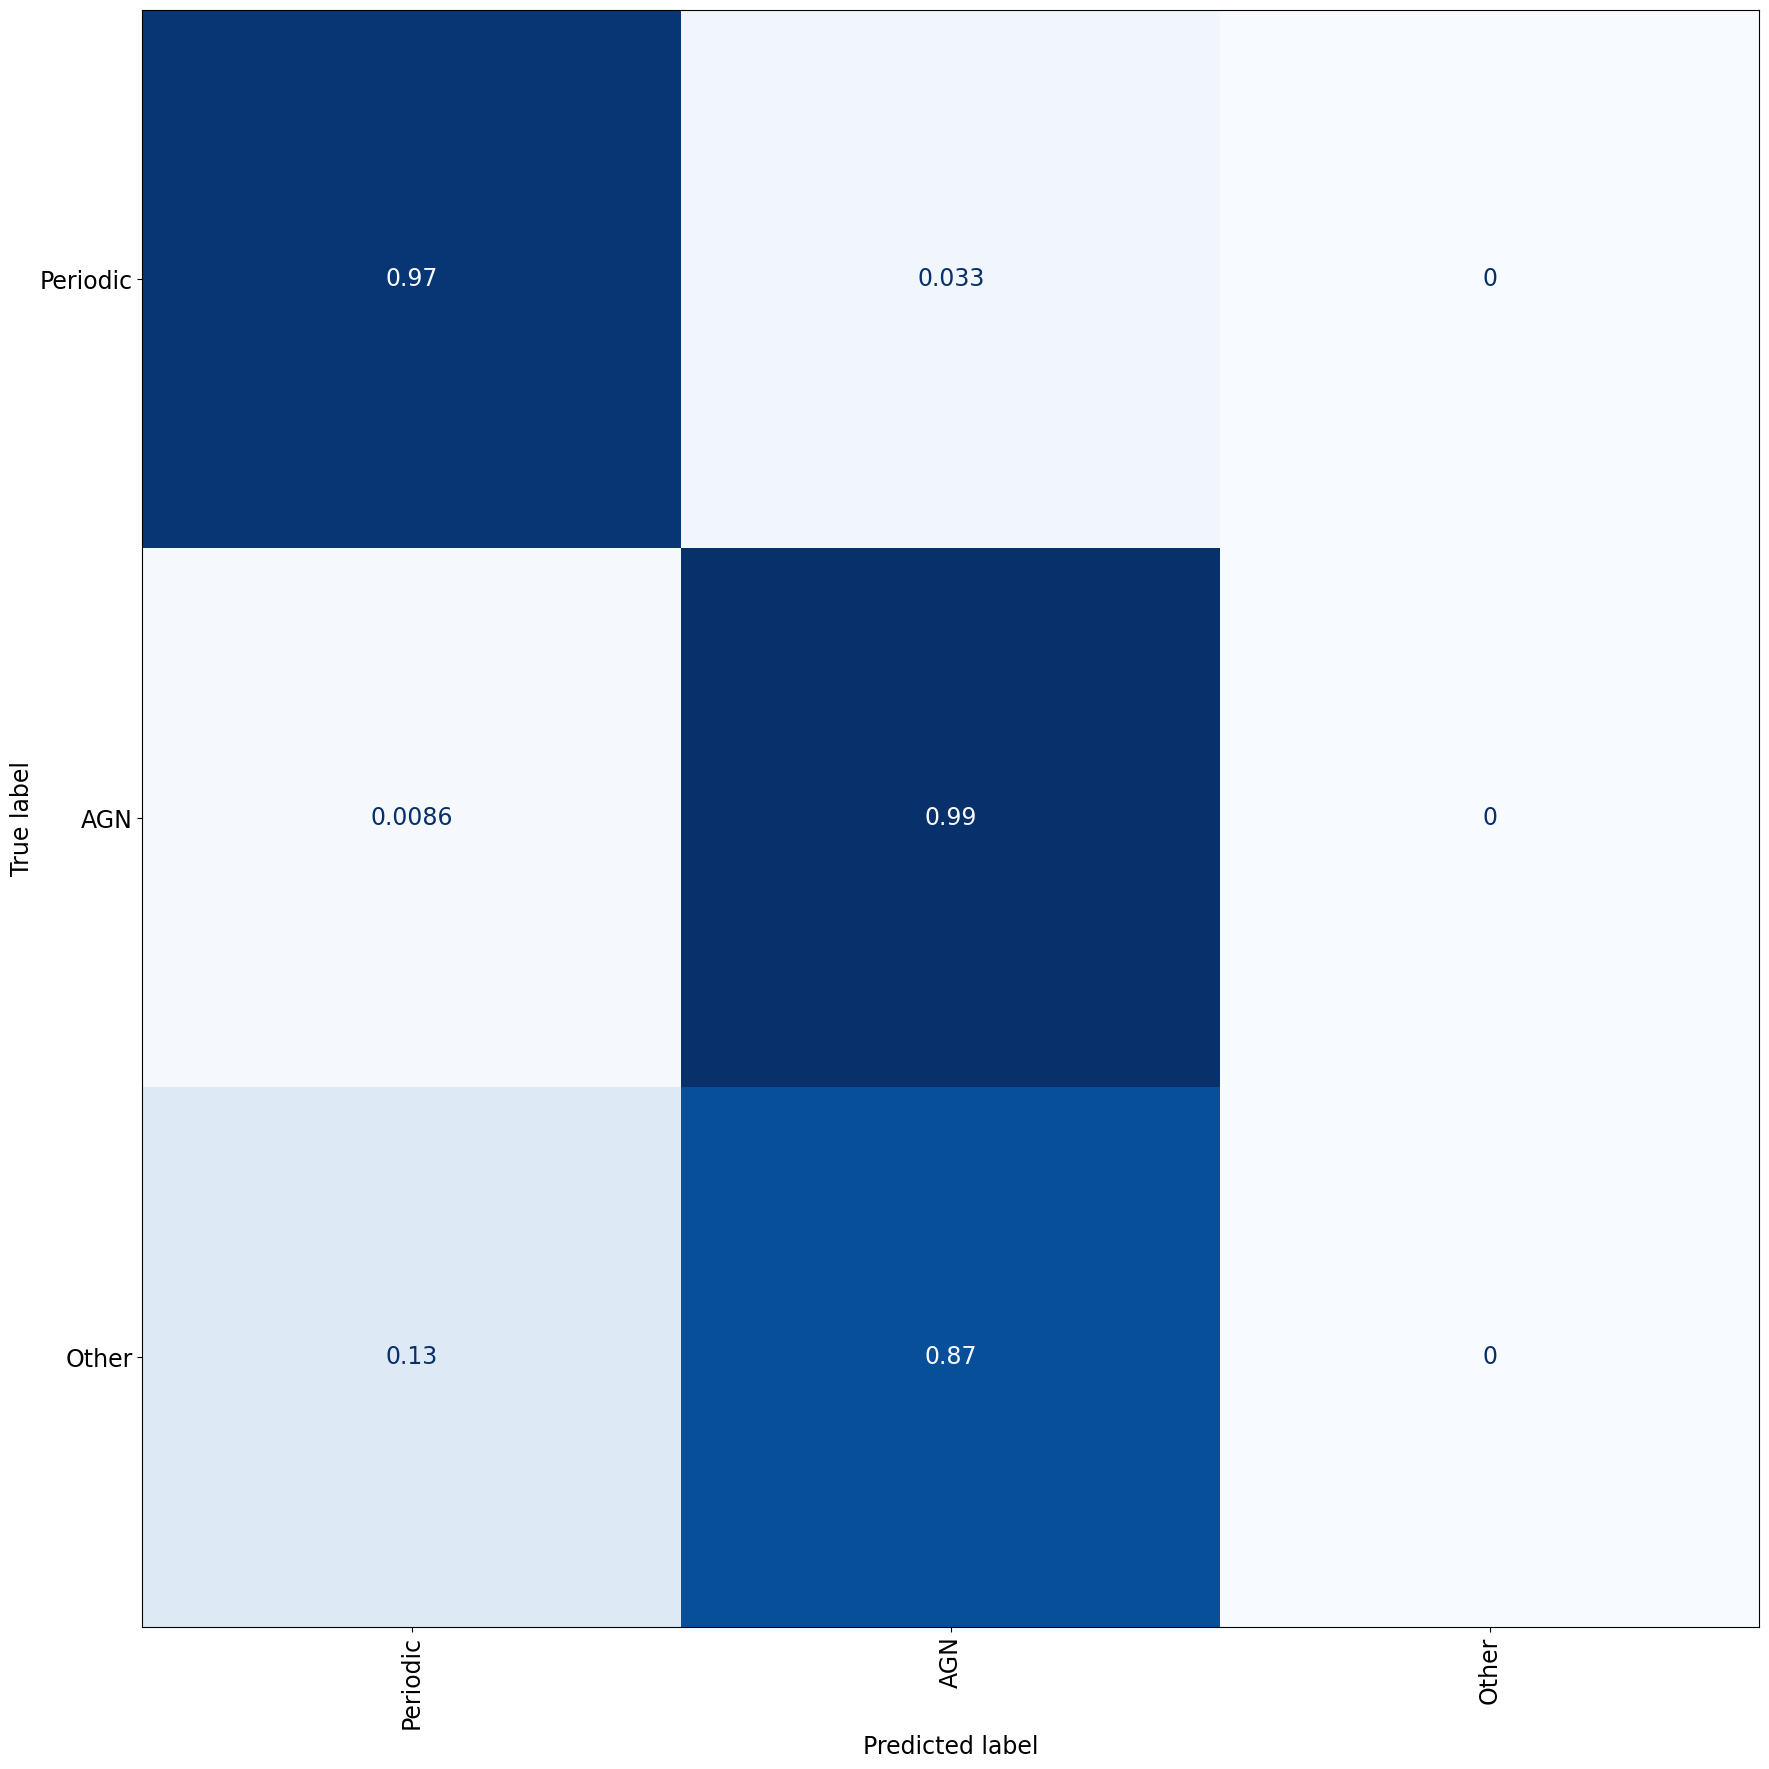

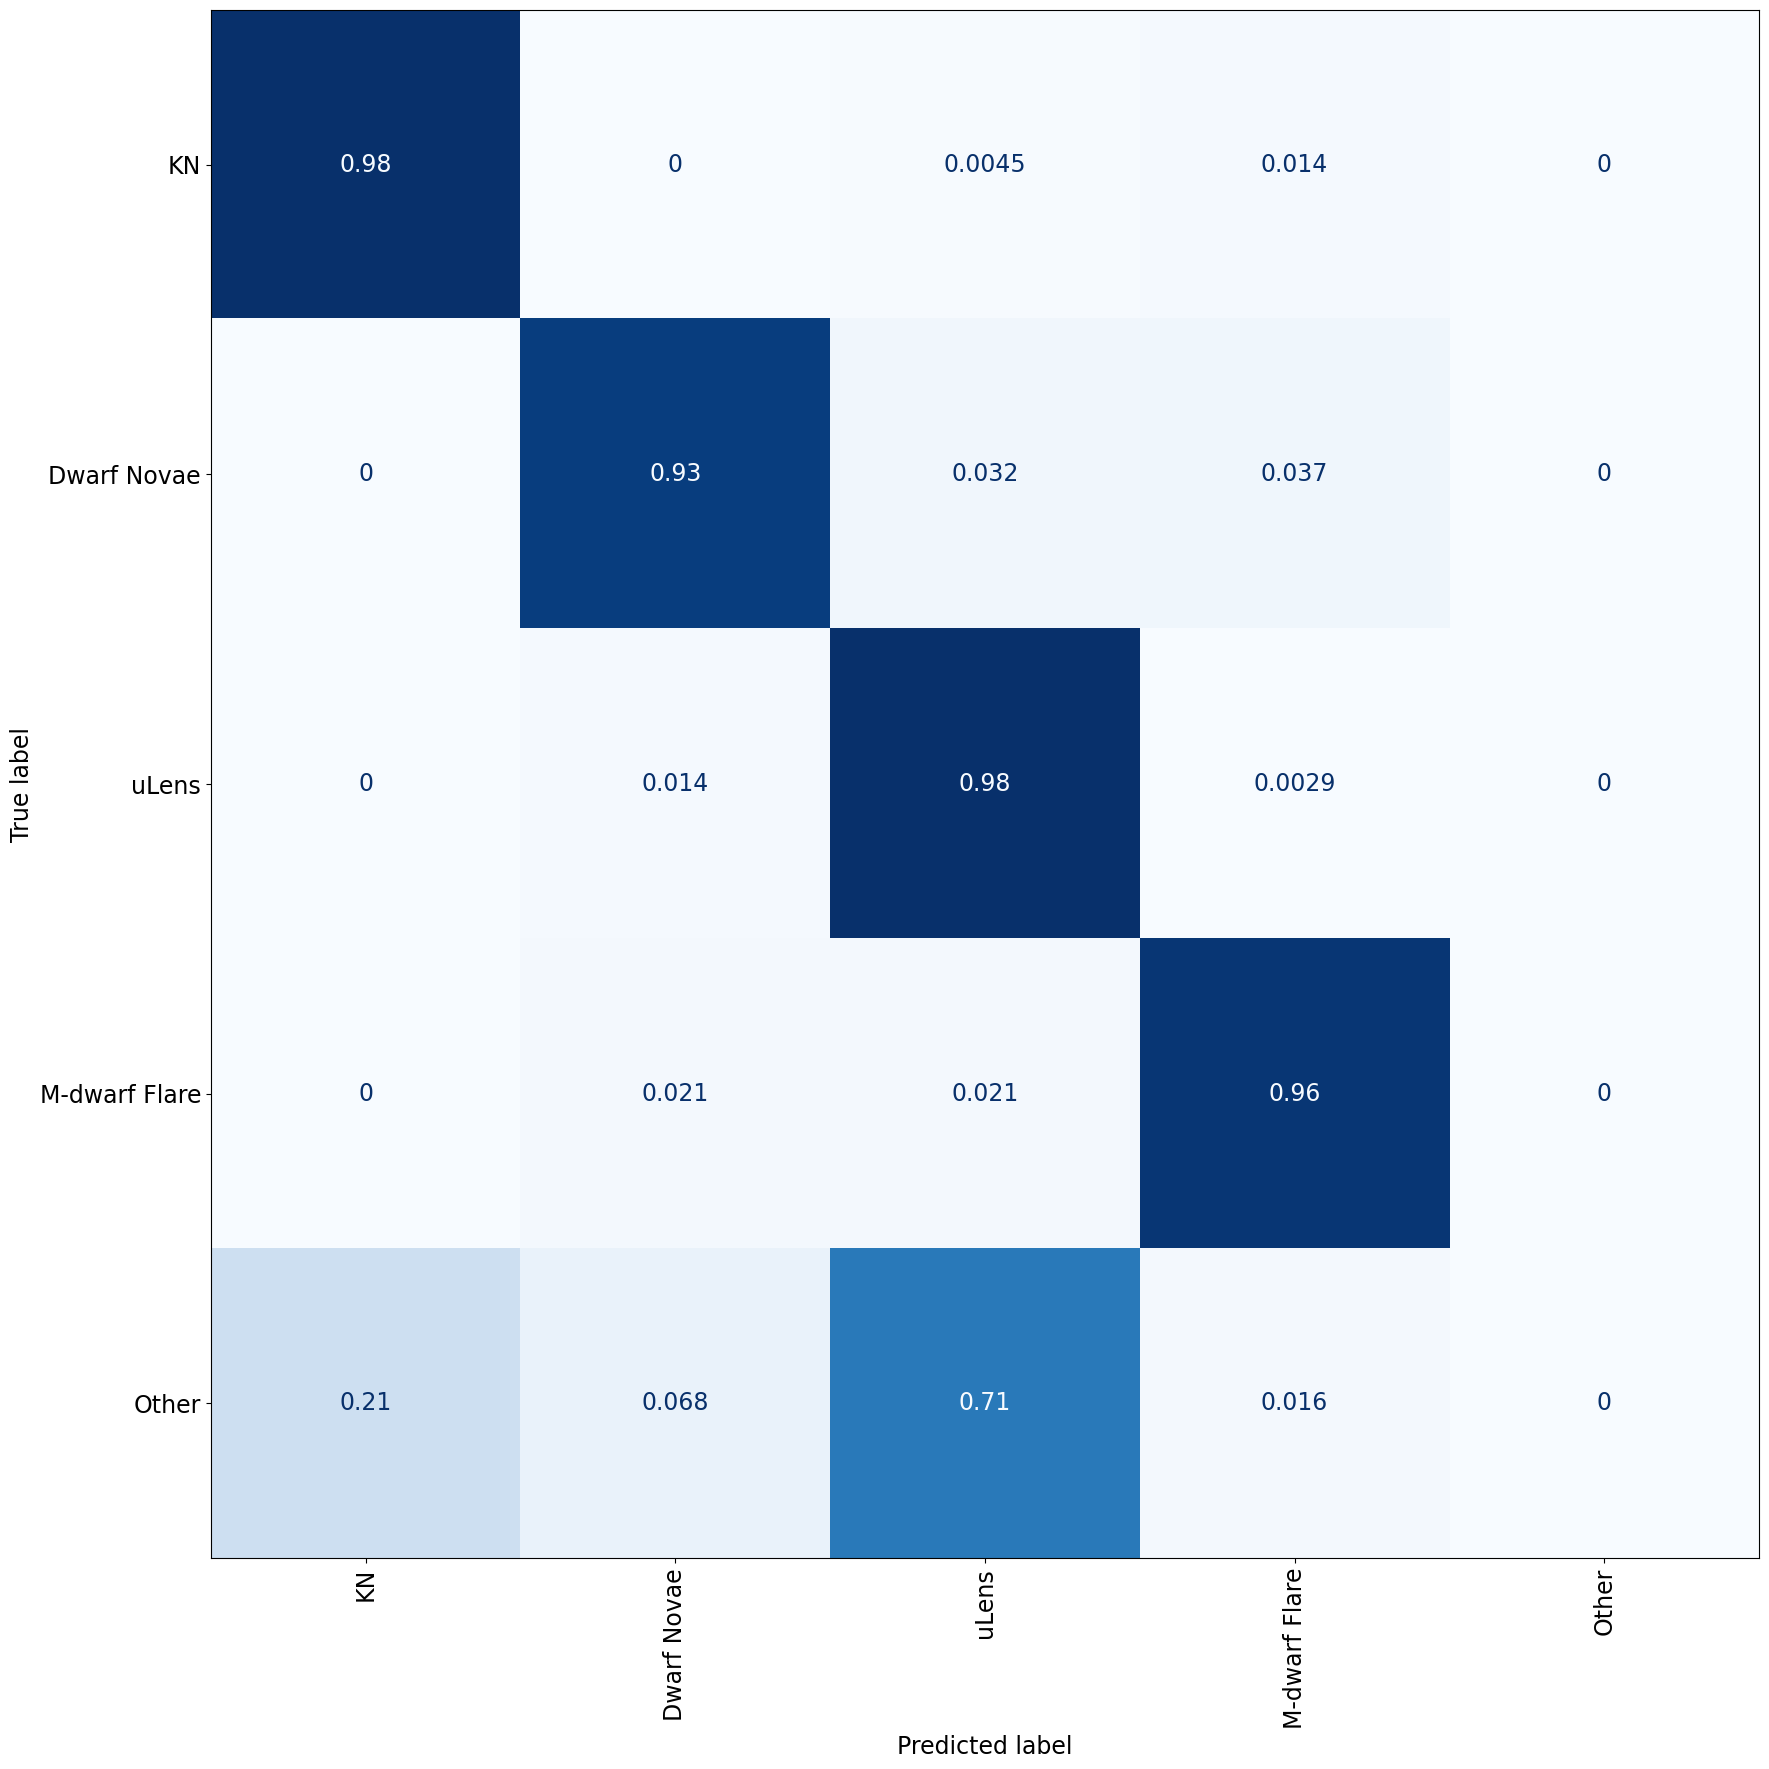

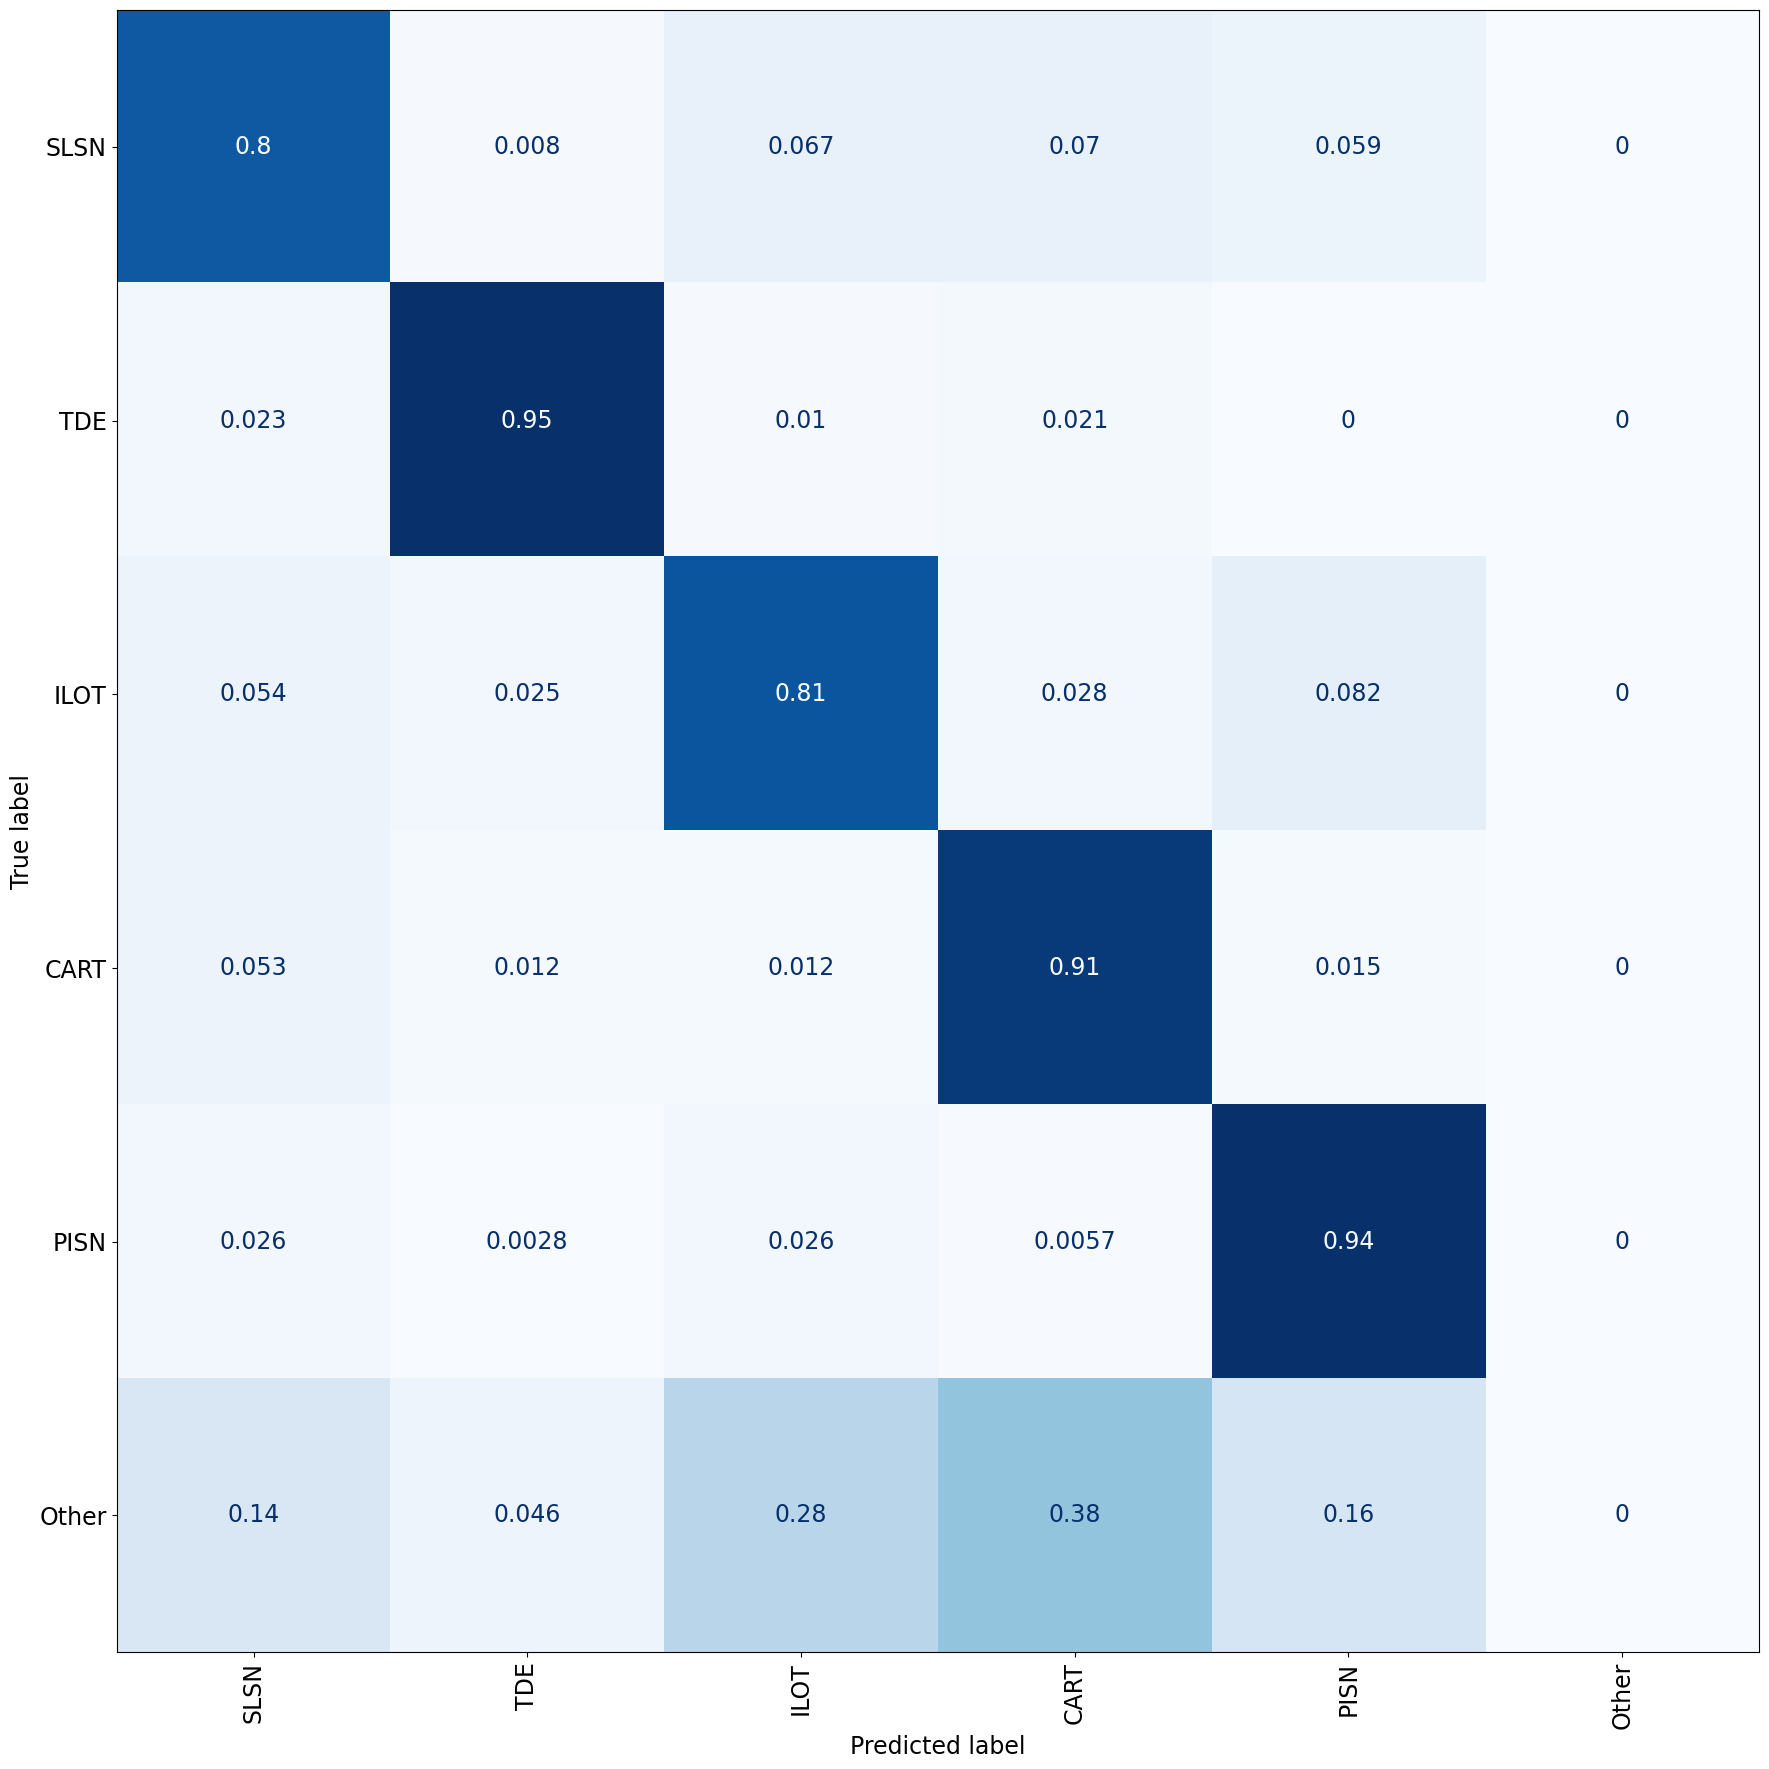

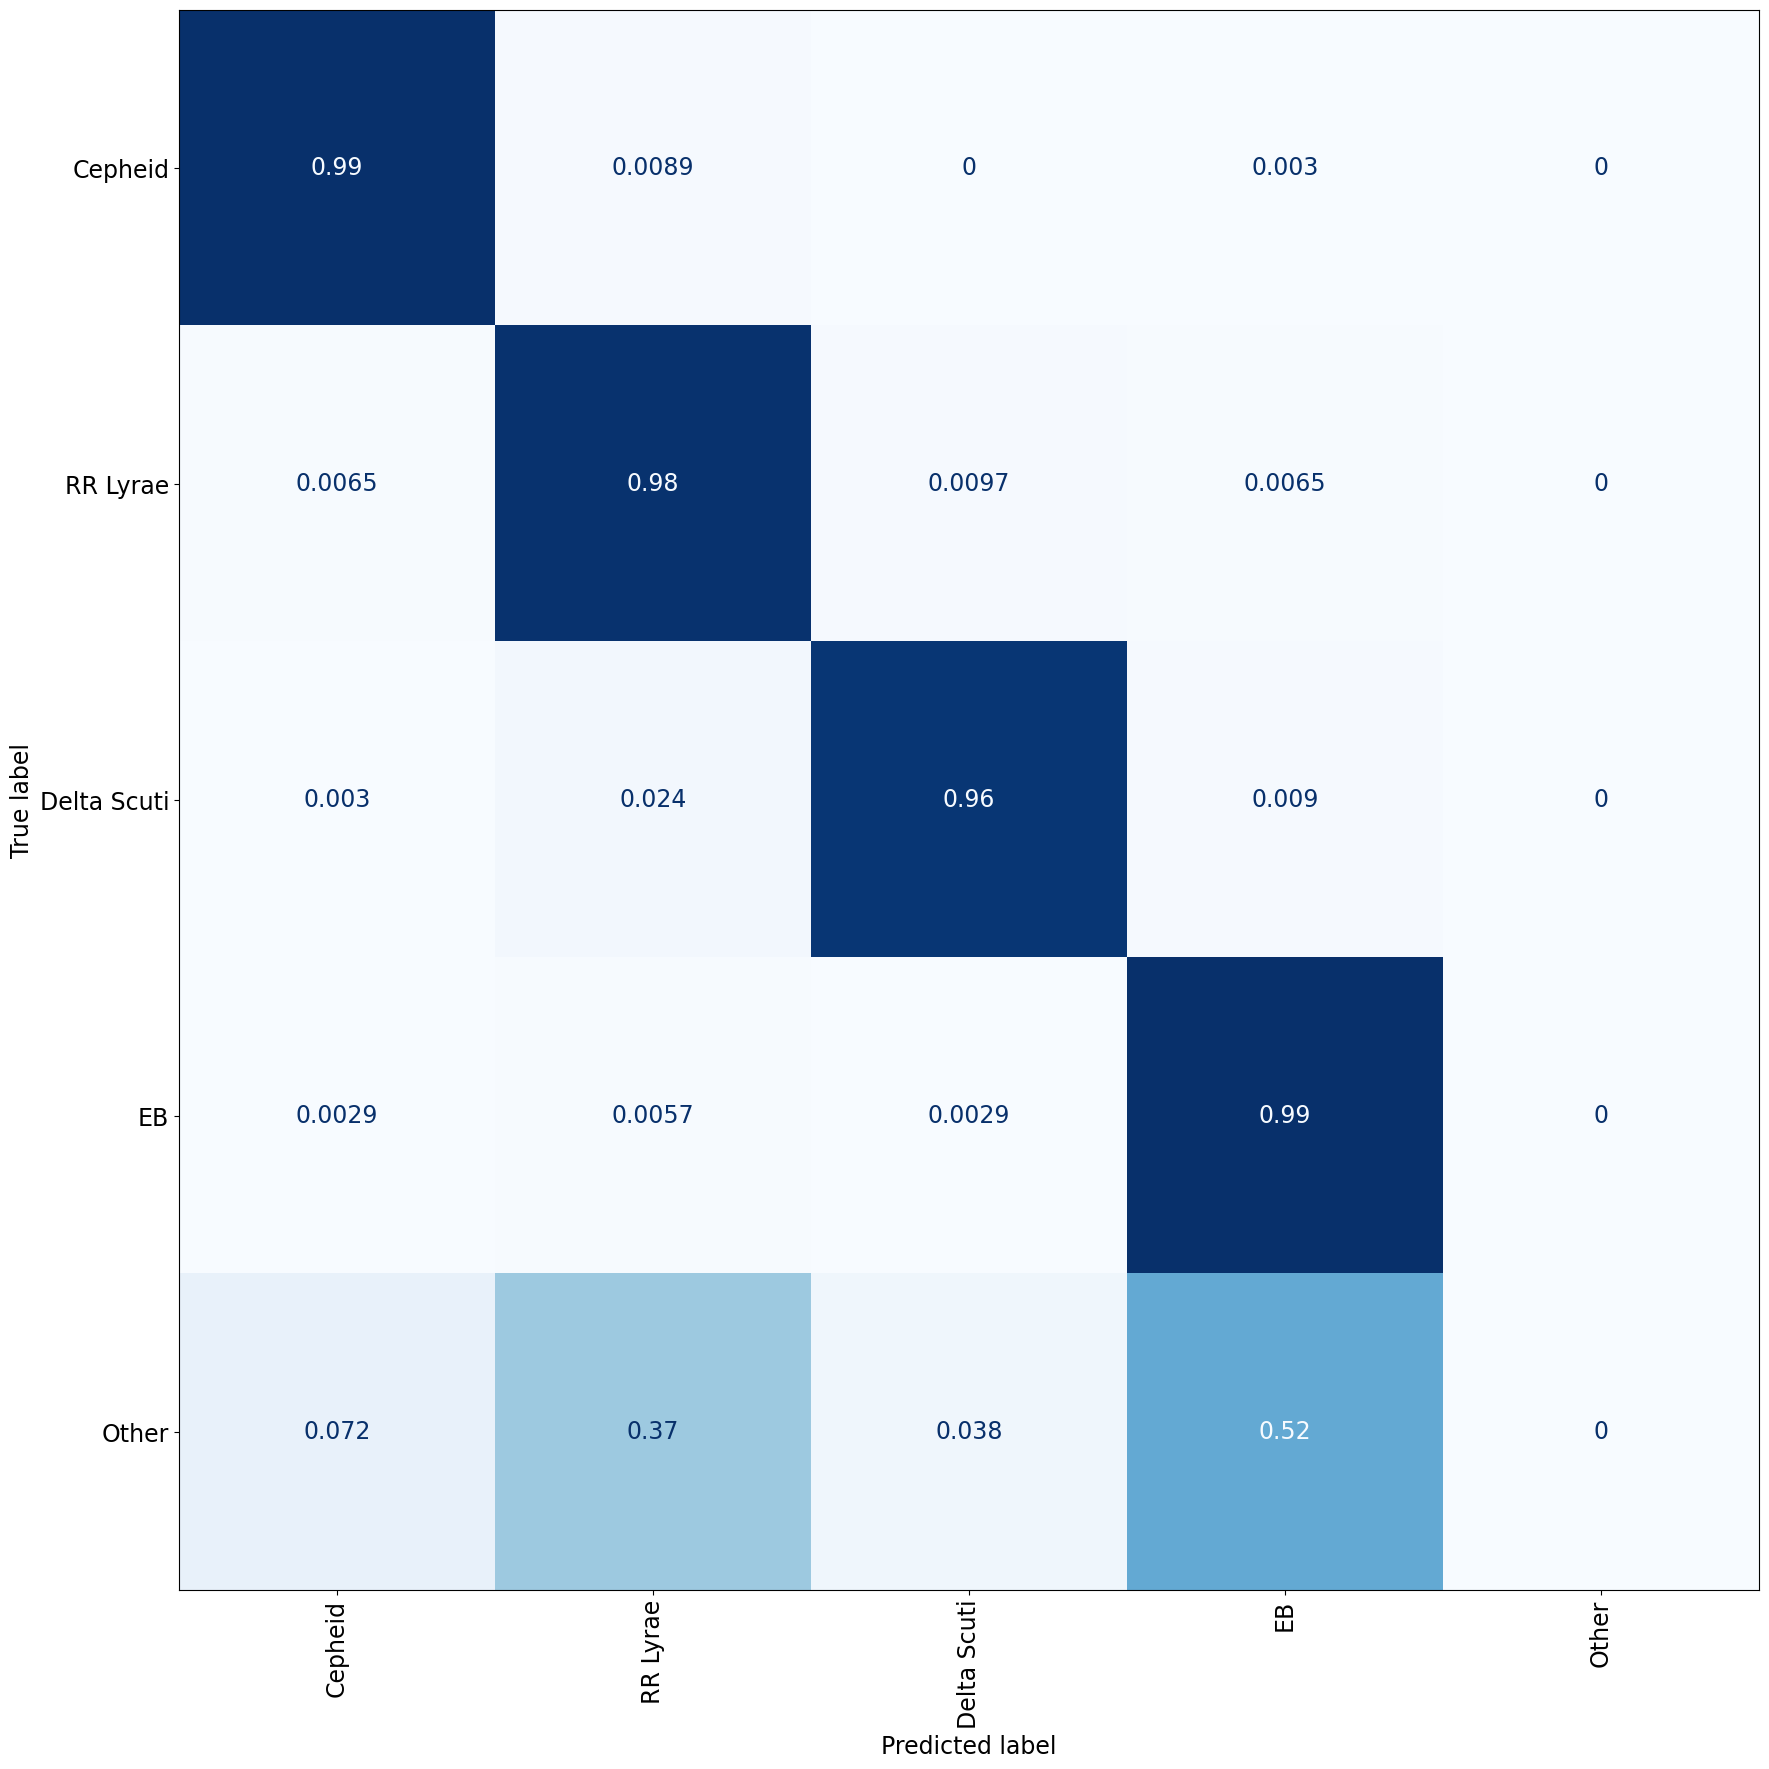

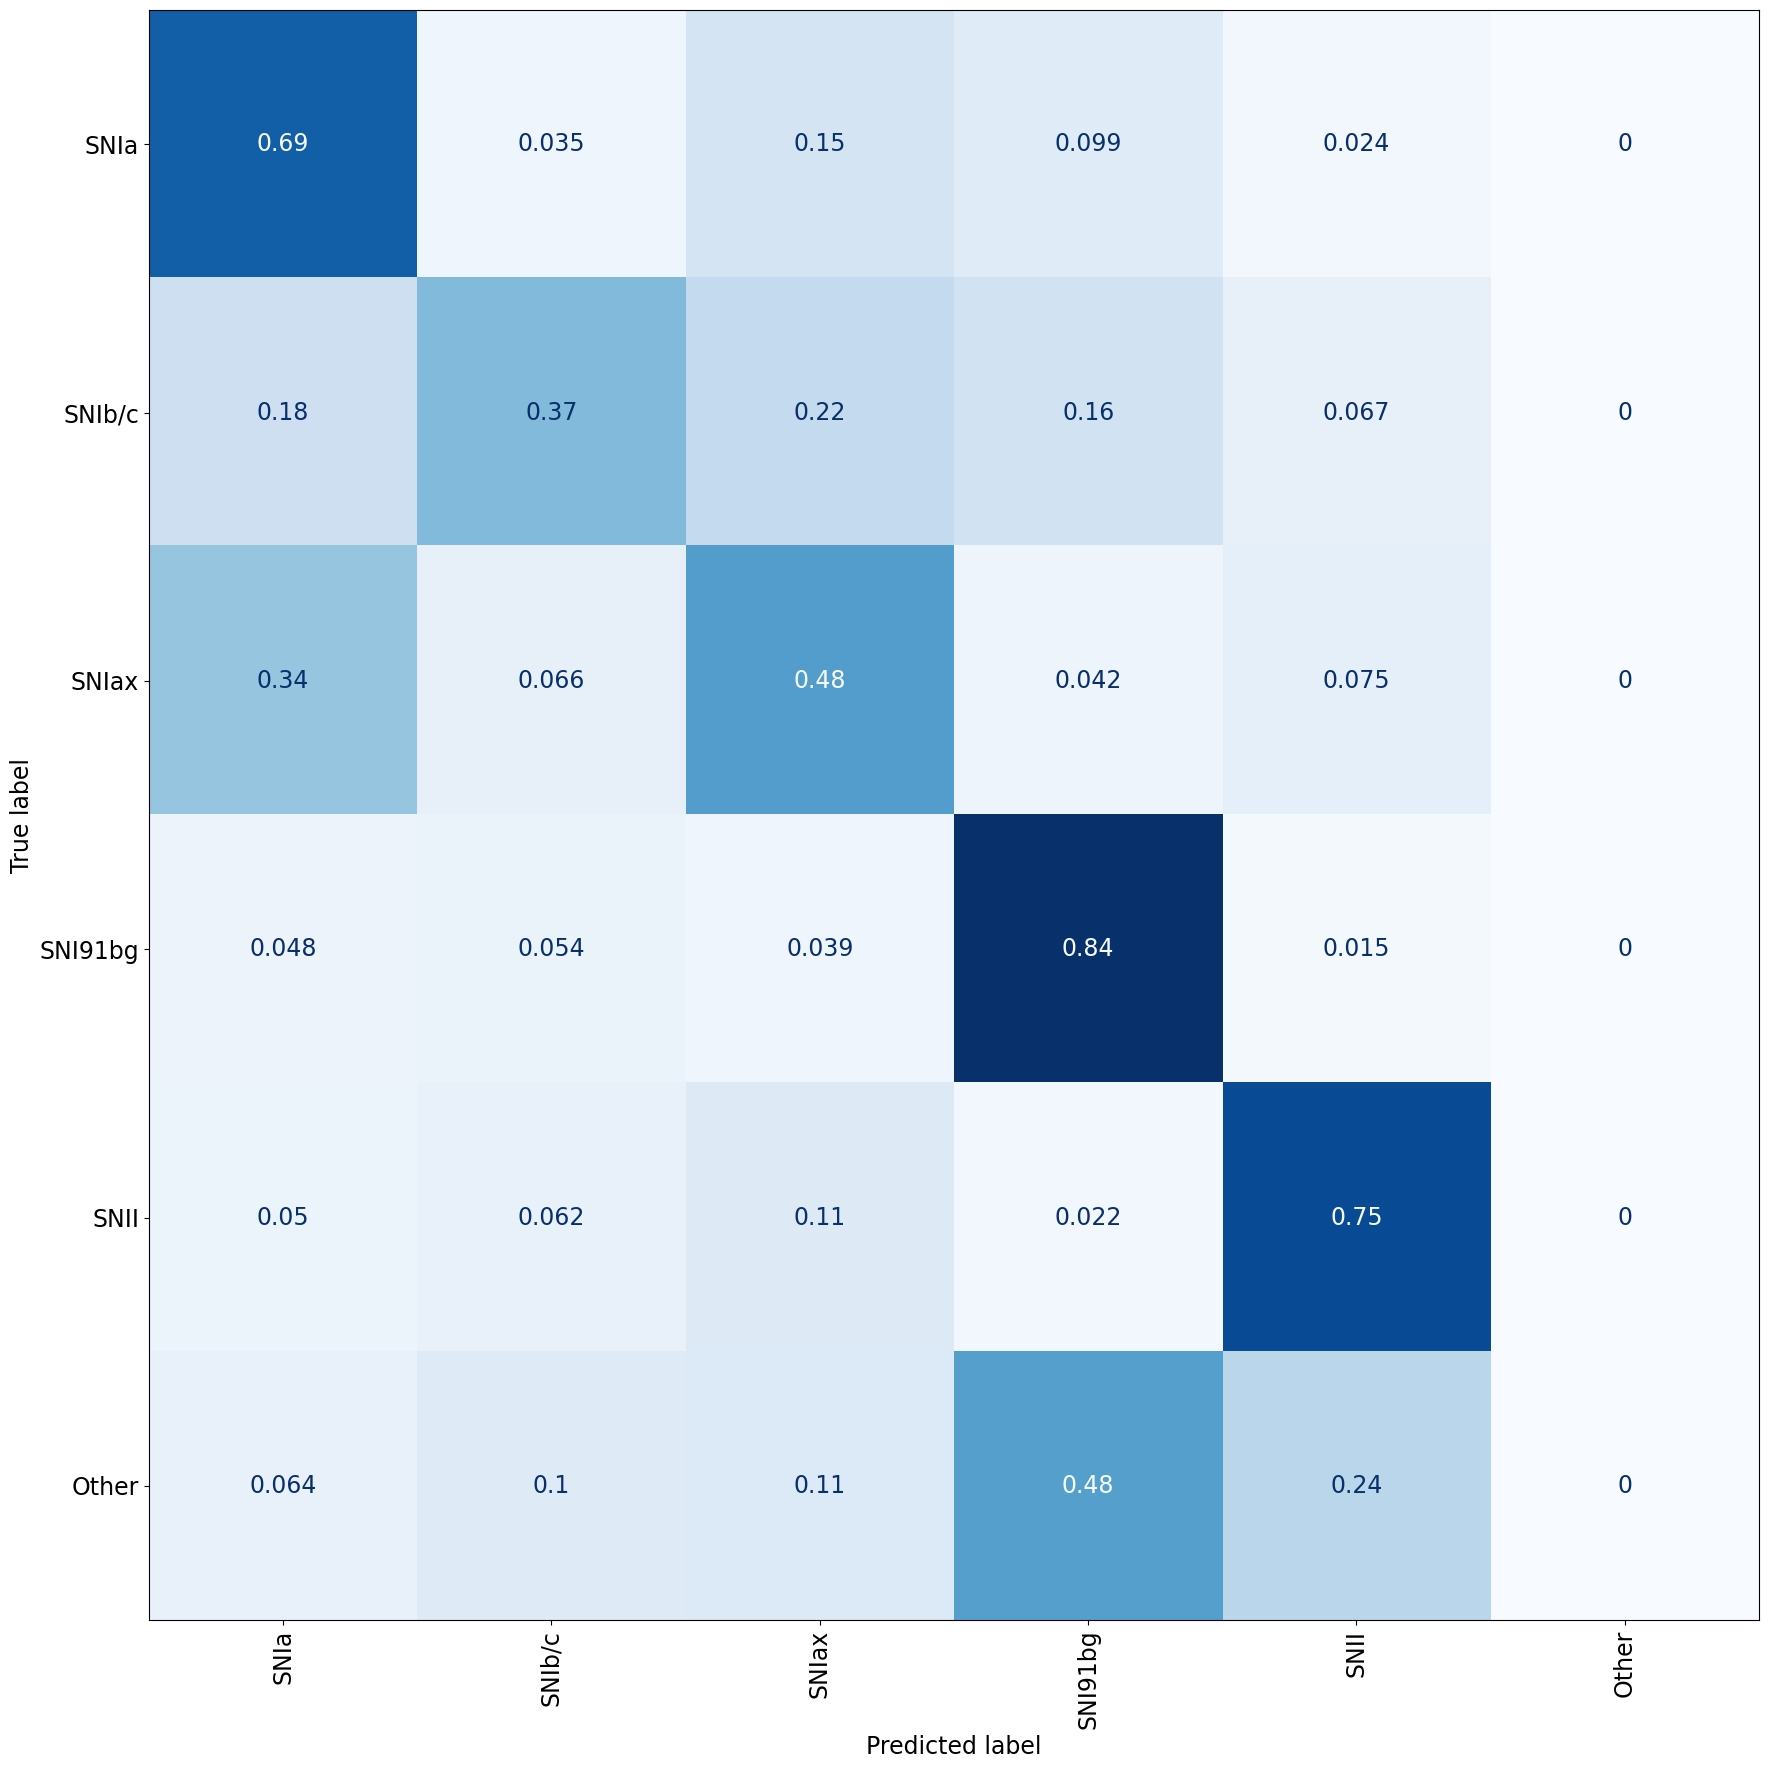

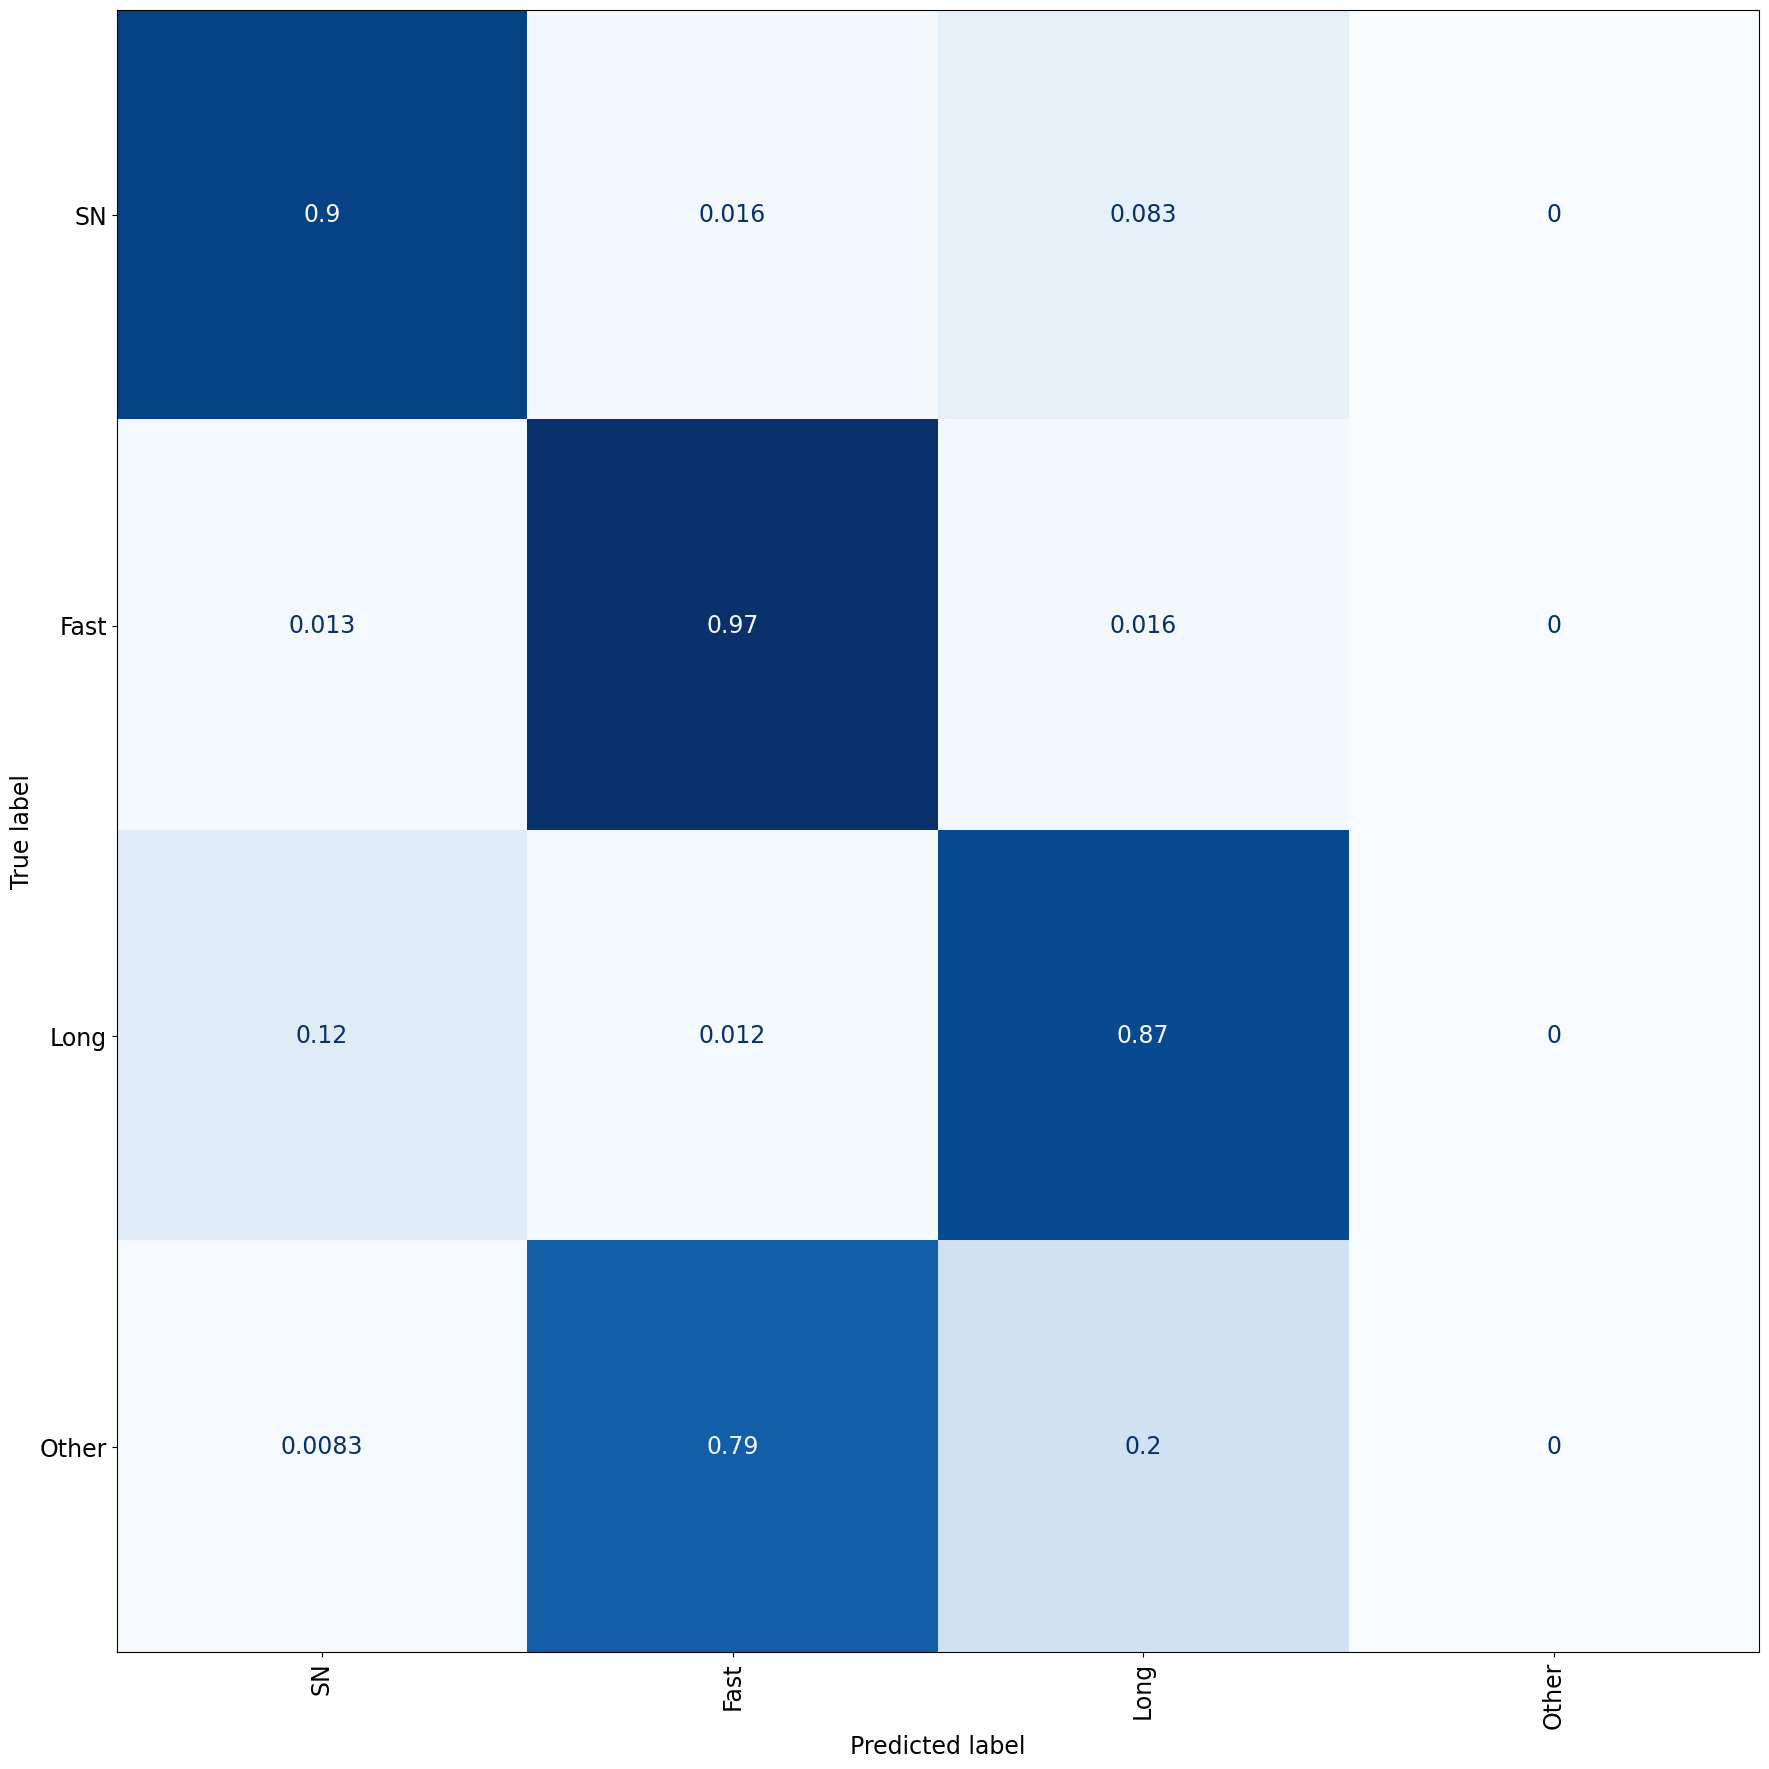

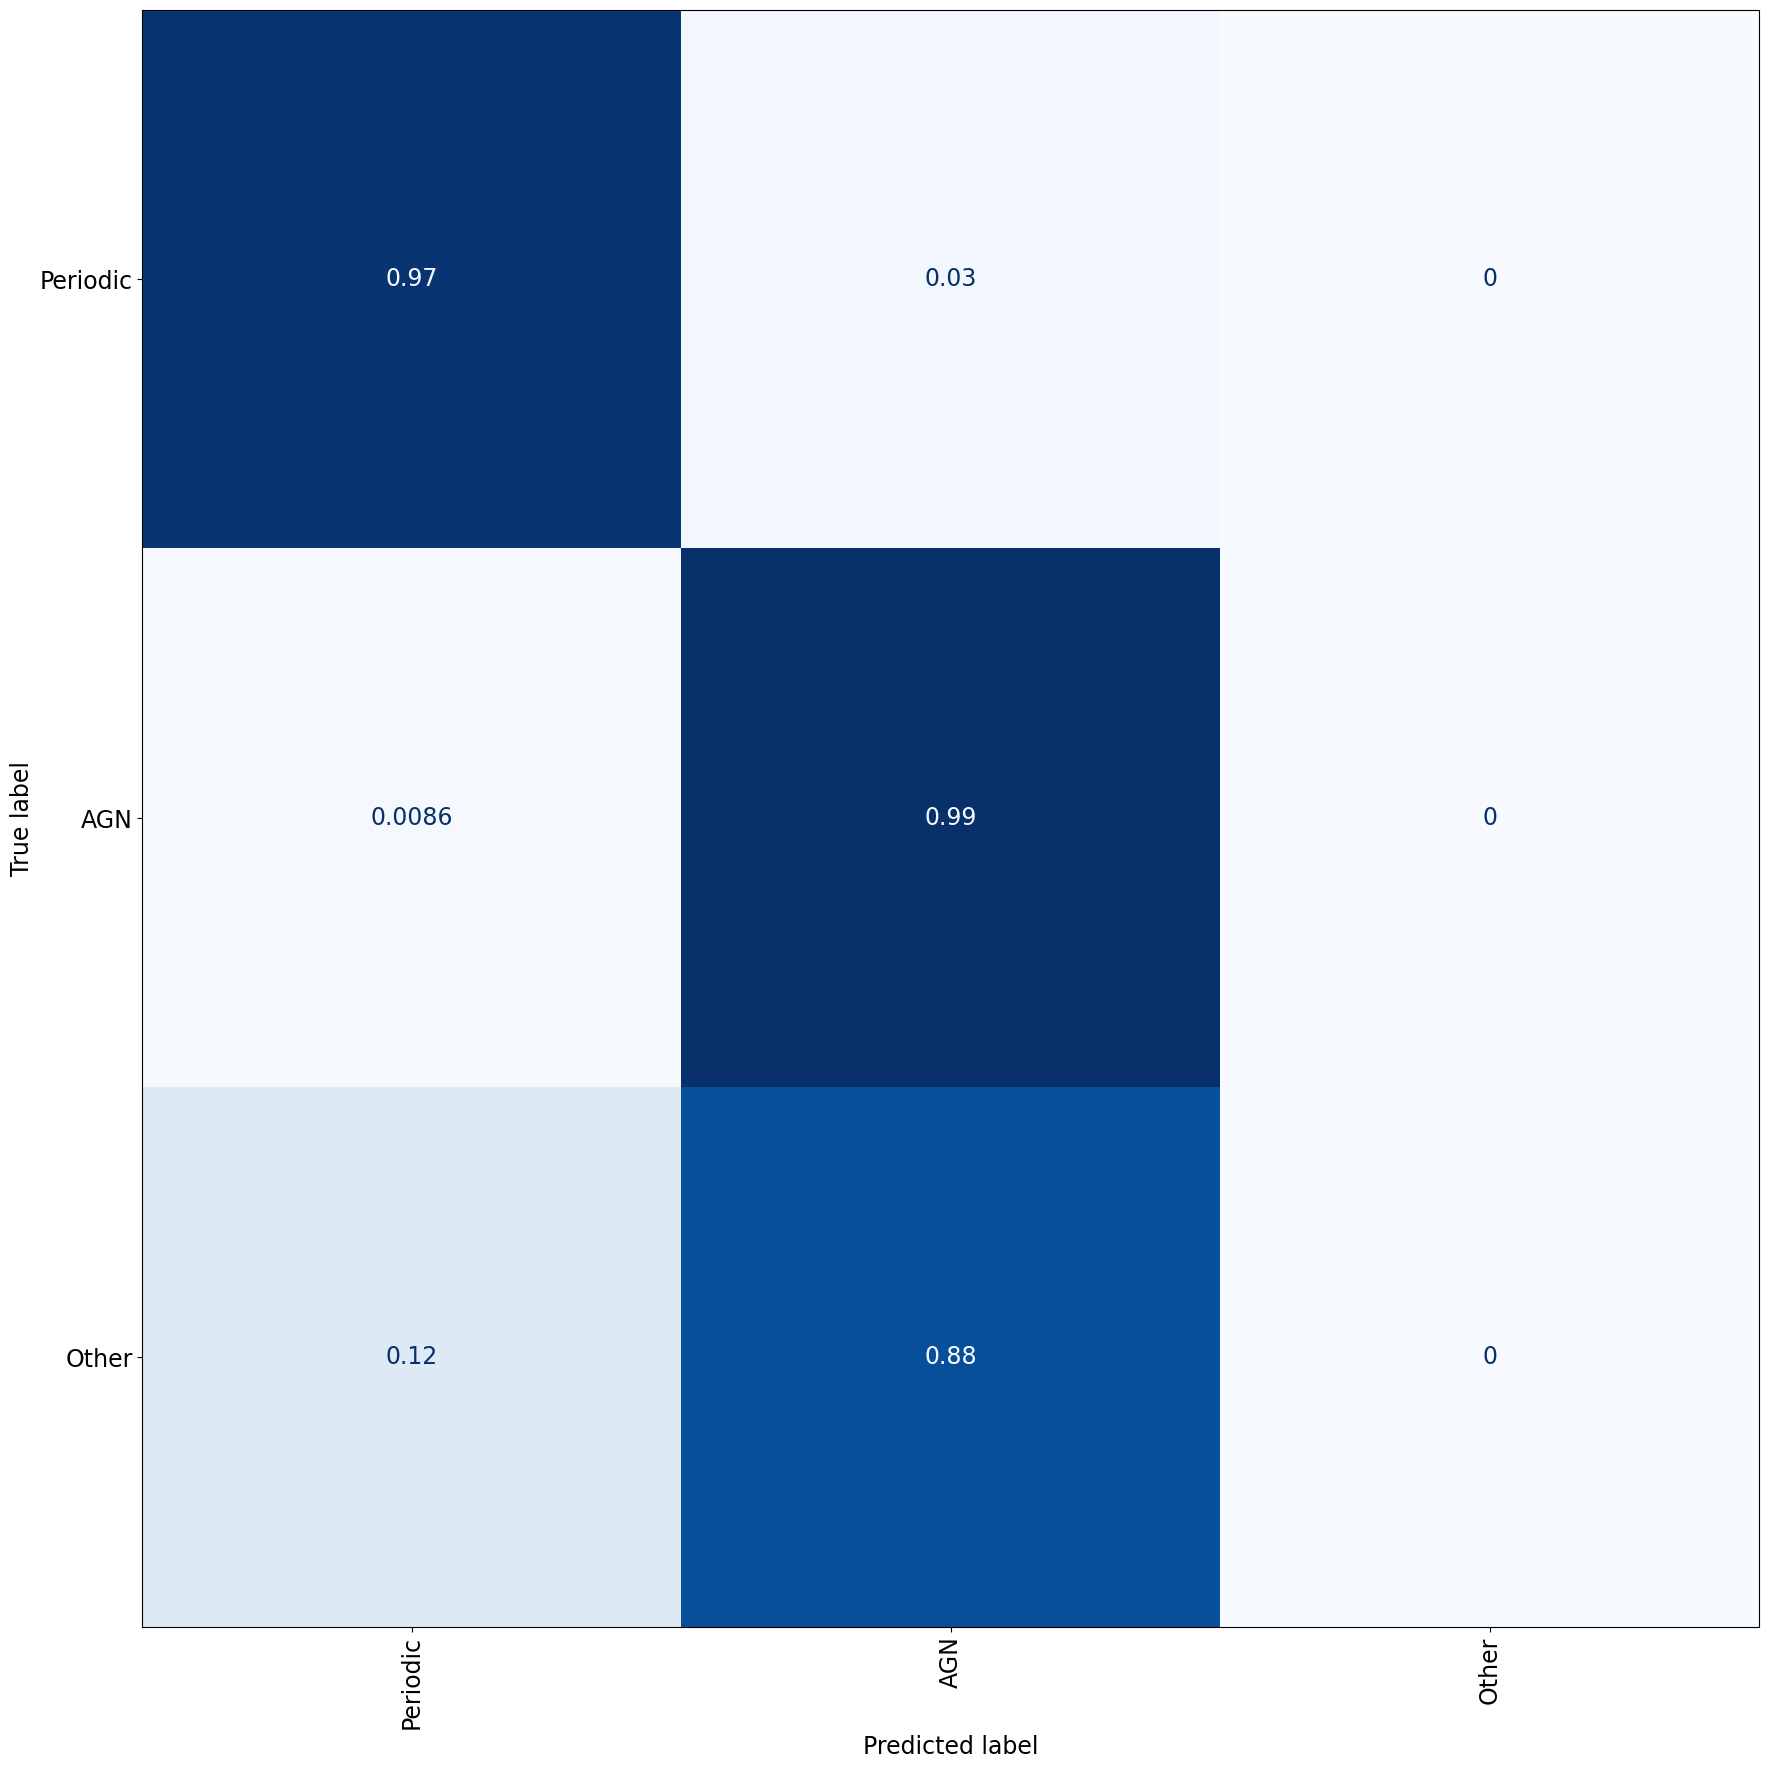

In [22]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    # Get all the indices for where 'f' fraction of the LC was used
    idx = np.where(lc_fraction_val == f)[0]

    # Get the correct samples to run the inference
    x1 = X_ts_val[idx, :, :]
    x2 = X_static_val[idx, :]
    y_true = Y_val[idx, :]
    
    # Run inference on these
    y_pred = saved_model.predict([x1, x2])

    # Get the conditional probabilities
    
    _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)
    
    
    get_all_confusion_matrices(y_true, y_pred, tree)
    #################################
